__Background:__

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

__Data Description:__

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

__Attributes:__

- age : age of customer (numeric)

- job : type of job (categorical)

- marital : marital status (categorical)

- education (categorical)

- default: has credit in default? (binary)

- balance: average yearly balance, in euros (numeric)

- housing: has a housing loan? (binary)

- loan: has personal loan? (binary)

- contact: contact communication type (categorical)

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical)

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

__Output (desired target):__

y - has the client subscribed to a term deposit? (binary)

__Goal(s):__

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

__Success Metric(s):__

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

__Bonus(es):__

- We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.
- What makes the customers buy? Tell us which feature we should be focusing more on.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from scipy.stats import zscore 

from sklearn.model_selection import train_test_split
from pycaret.classification import *

In [2]:
df = pd.read_csv('data/term-deposit-marketing-2020.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


While, the data does not show any missing values, it does show that some features have been labeled 'unknown'

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


We have some large outliers for average yearly balance and contact duration based.
The average age is between 39-41 years old, average calls are made in the middle of the month on the 16th and 17th based on the mean and median of the data. Campaigns also average about 3 calls or contacts for each client.

# EXPLORATORY DATA ANALYSIS

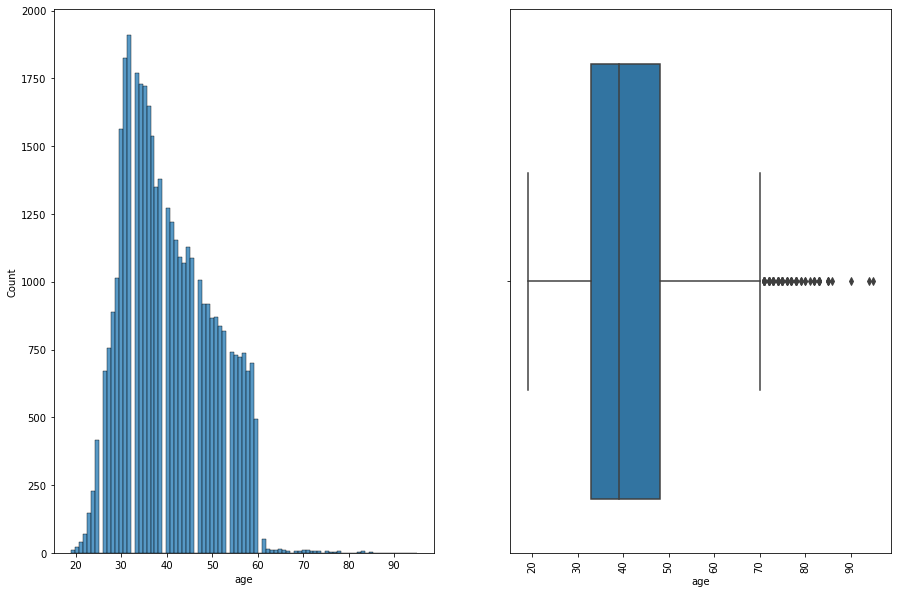

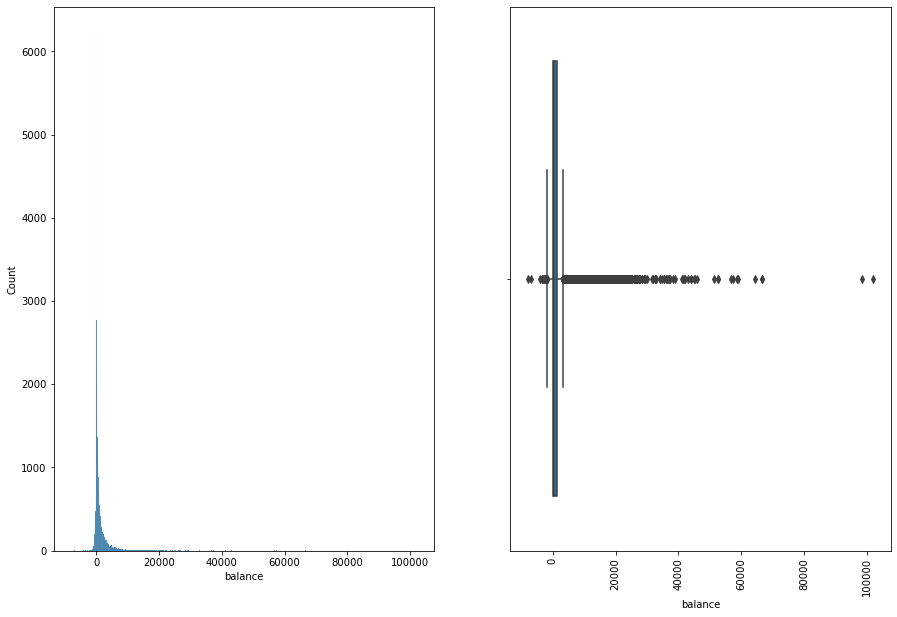

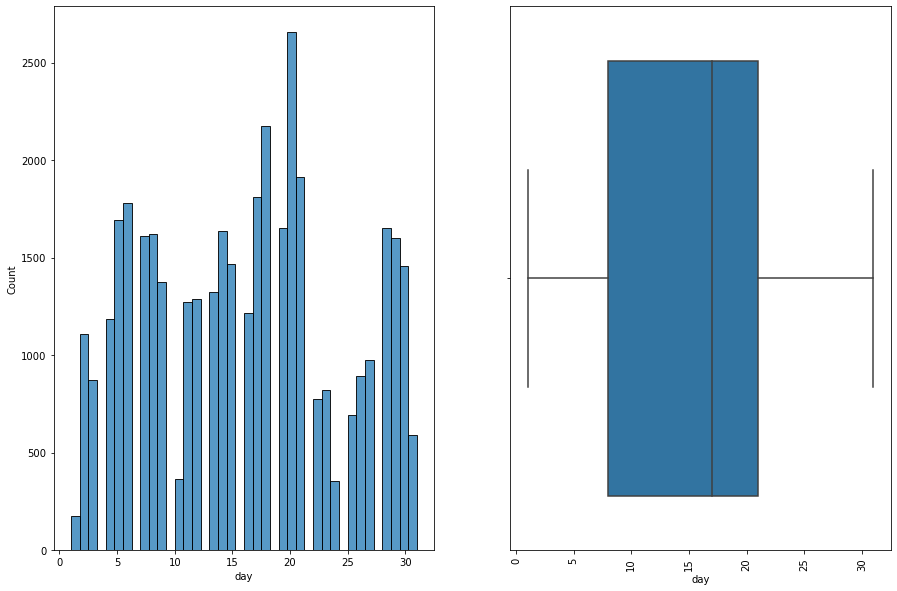

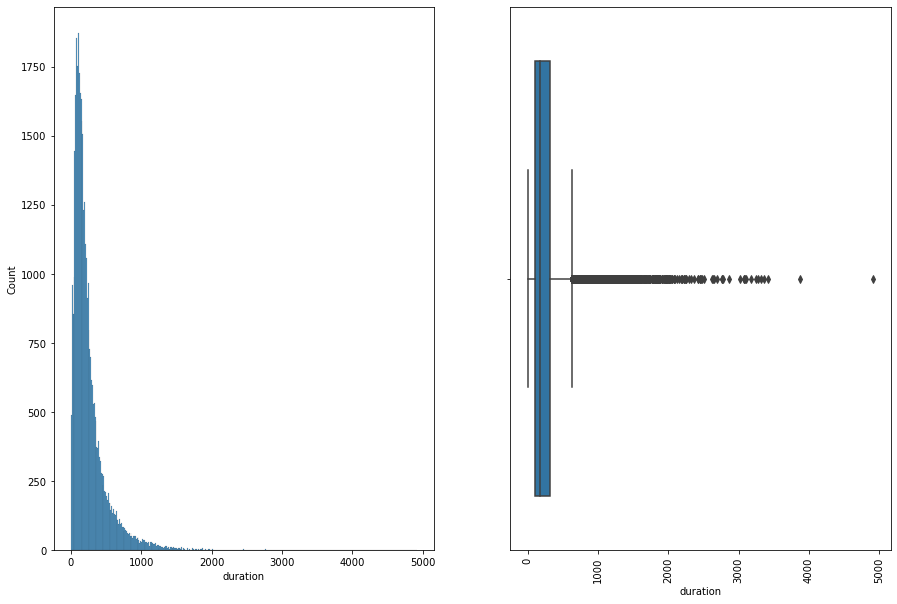

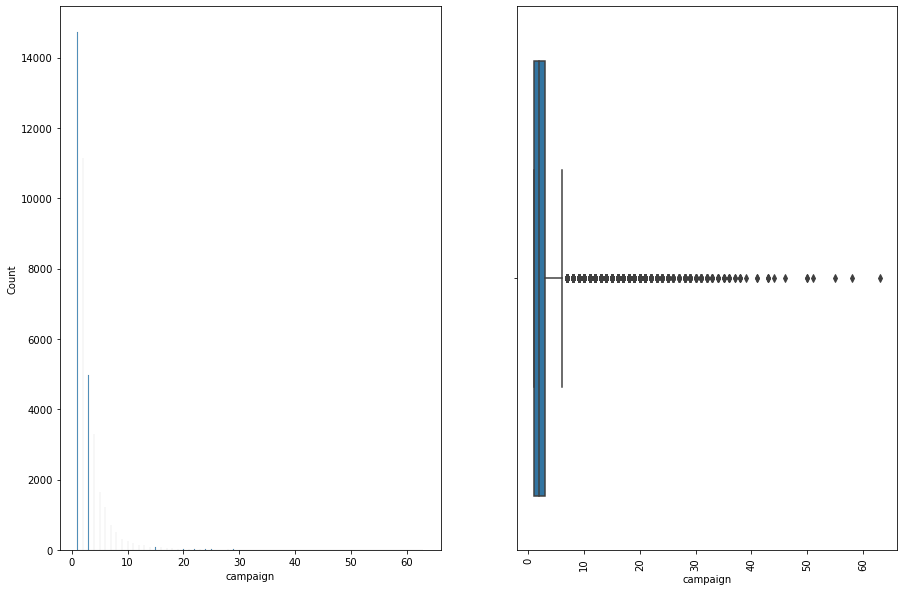

In [6]:
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign']

for i in numeric_features:
    fig, ax = plt.subplots(1, 2, figsize=(15,10))
    sns.histplot(data=df, x=df[i], ax=ax[0])
    sns.boxplot(data=df, x=df[i], ax=ax[1])
    plt.xticks(rotation=90)
    plt.show()

We can see from above that the data is highly imbalanced, especially for numeric features like balance, duration, and campaign. Let's take a closer look at these.

In [7]:
yes_df = df.copy().loc[df.y == 'yes', :].reset_index(drop=True)
no_df = df.copy().loc[df.y == 'no', :].reset_index(drop=True)

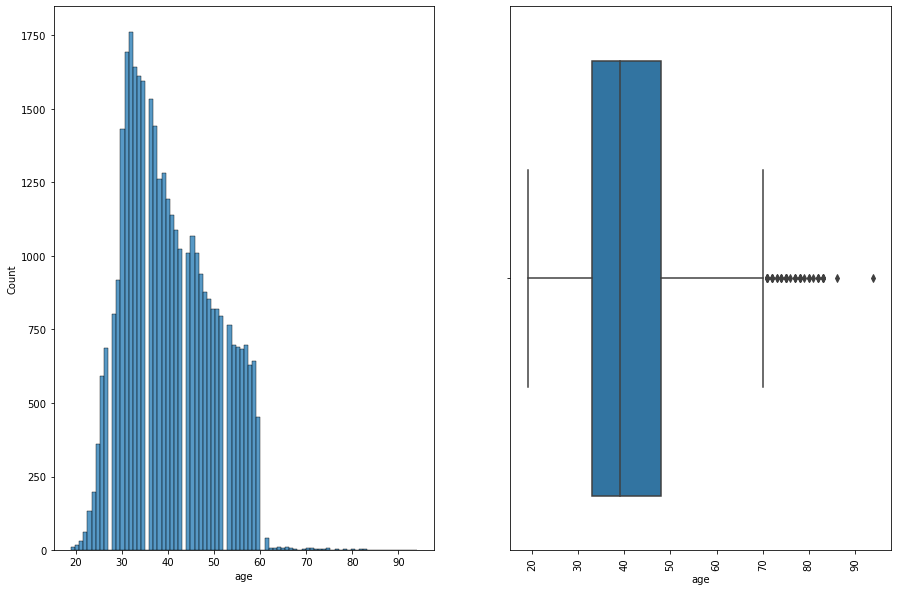

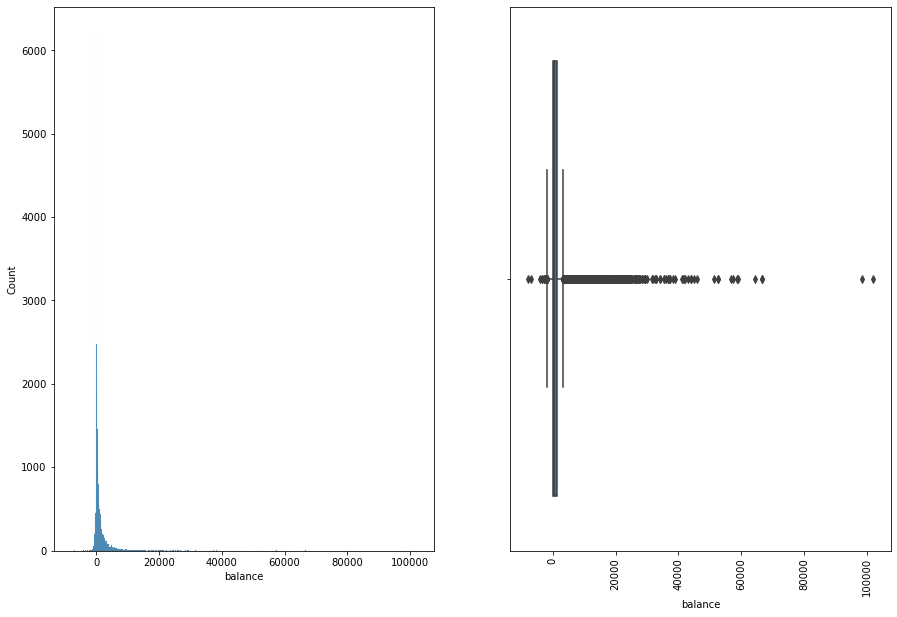

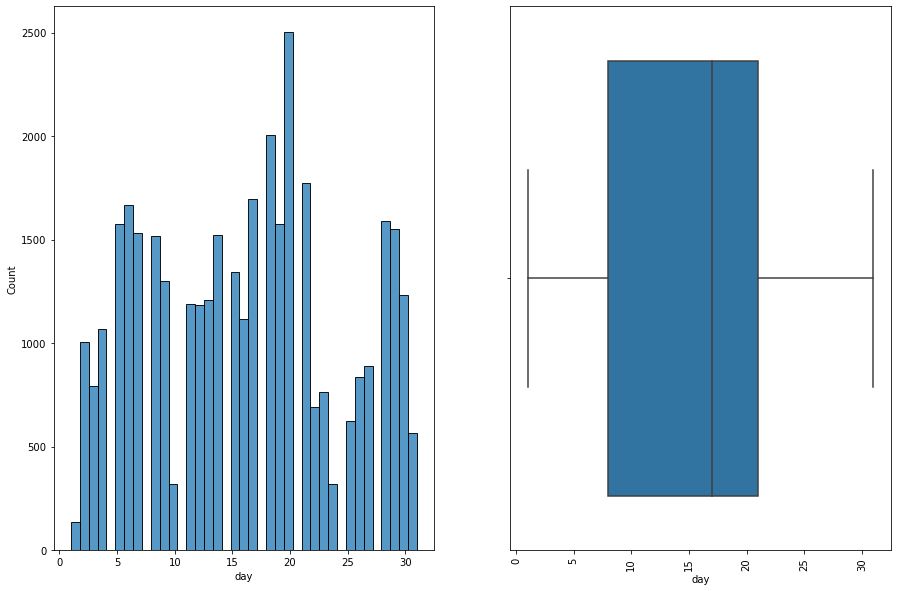

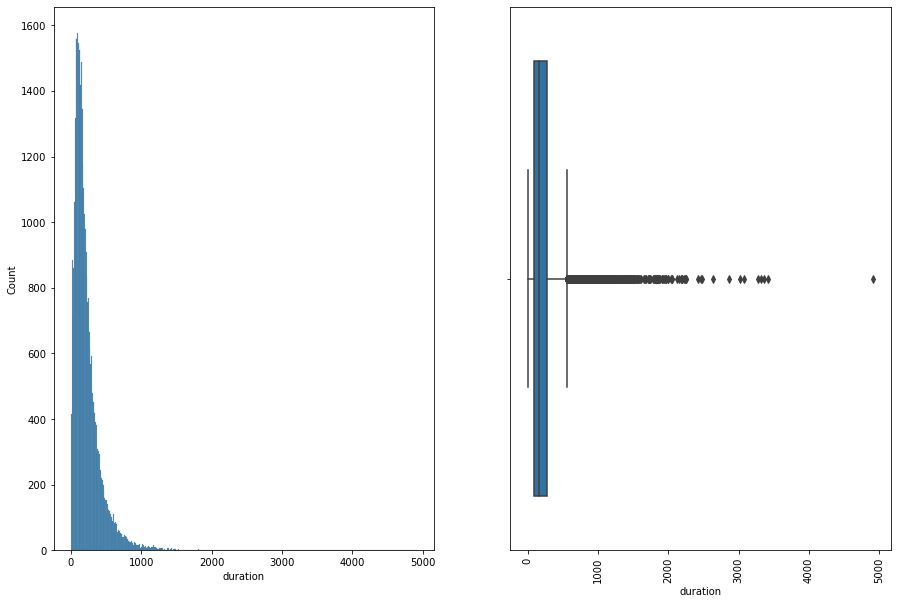

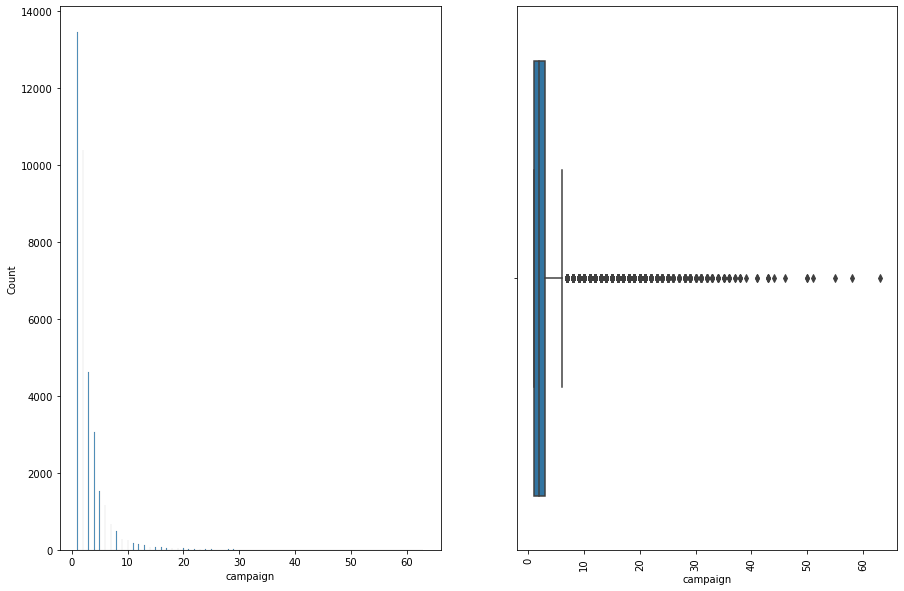

In [8]:
#look at distribution of no subscriptions
for i in numeric_features:
    fig, ax = plt.subplots(1, 2, figsize=(15,10))
    sns.histplot(data=no_df, x=no_df[i], ax=ax[0])
    sns.boxplot(data=no_df, x=no_df[i], ax=ax[1])
    plt.xticks(rotation=90)
    plt.show()

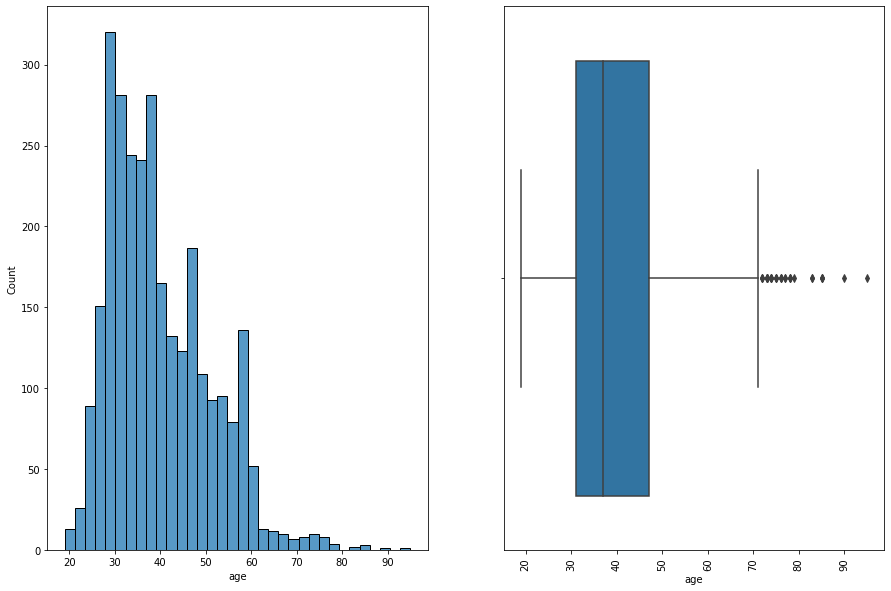

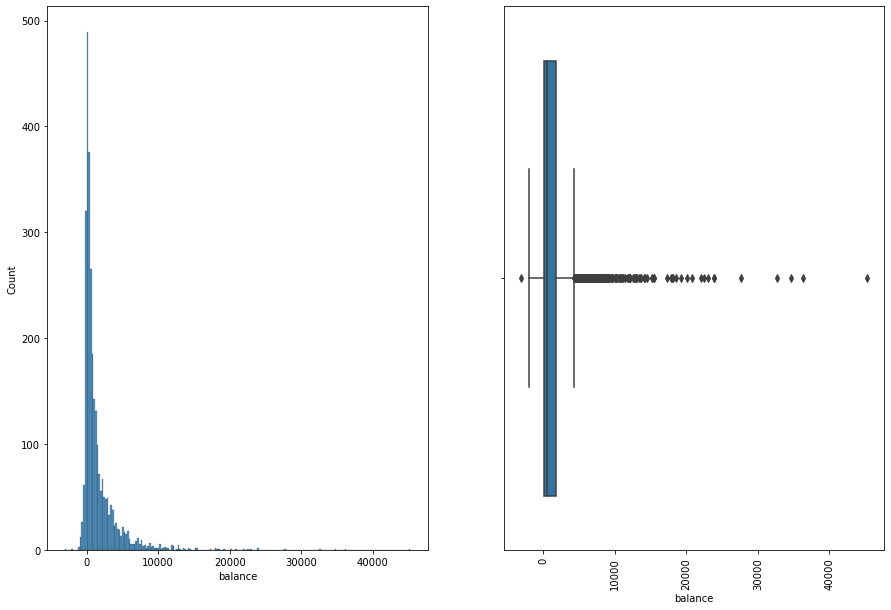

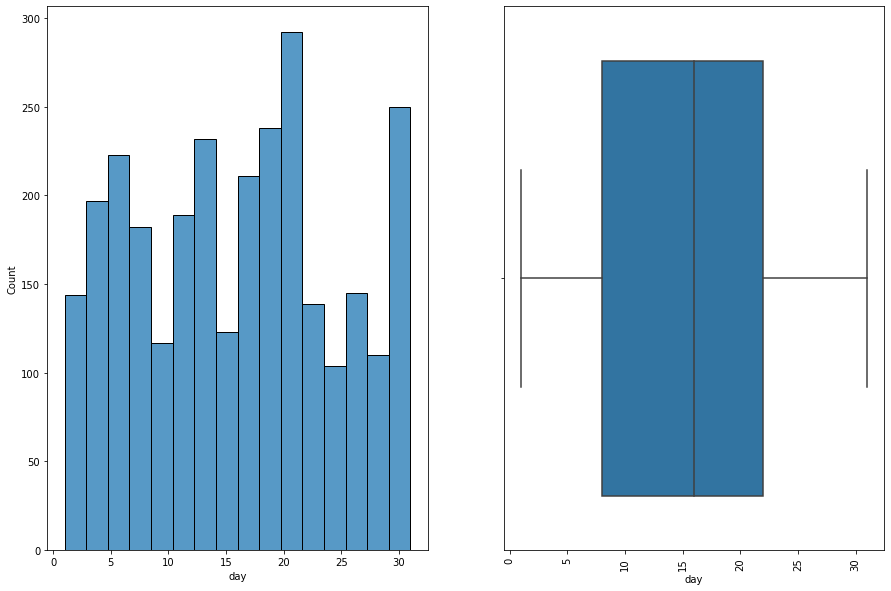

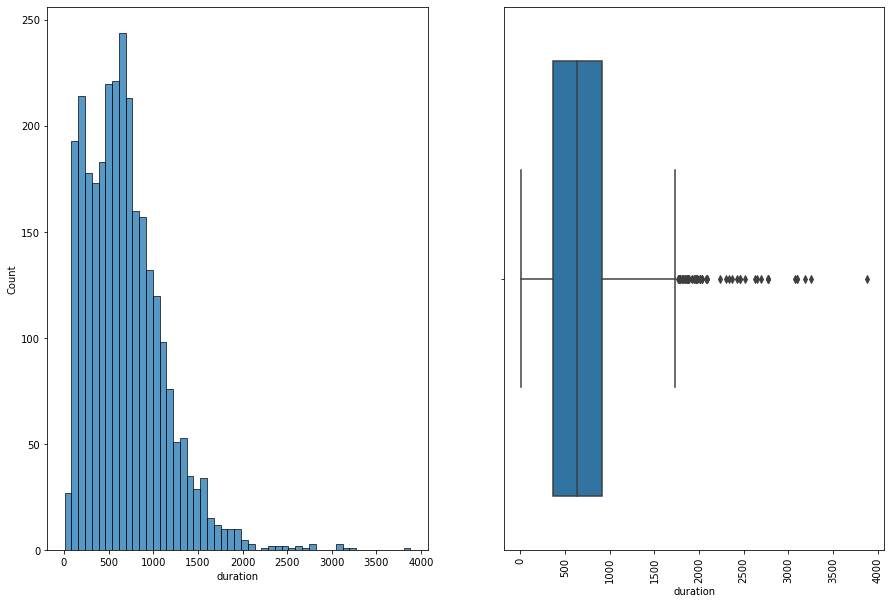

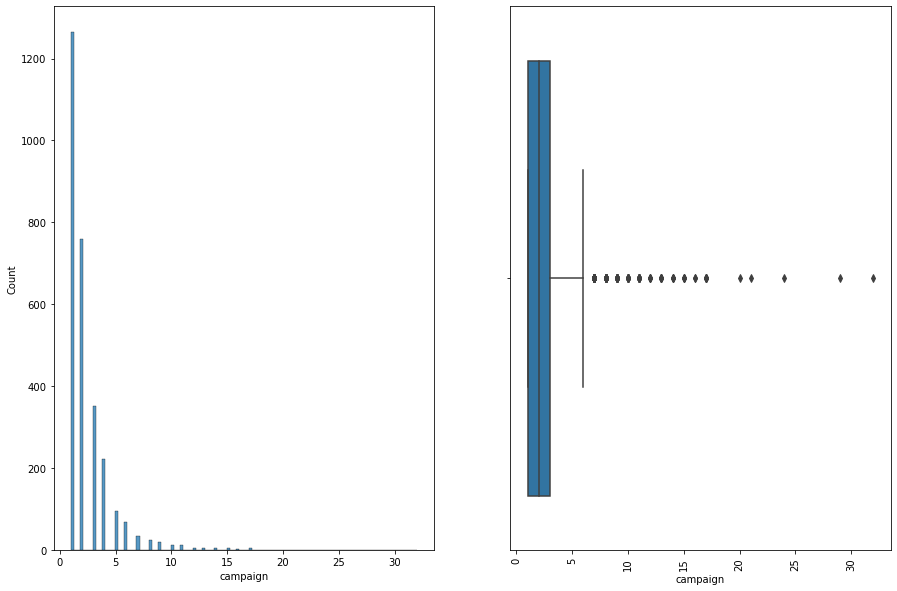

In [9]:
#look at distribution of yes subscriptions

for i in numeric_features:
    fig, ax = plt.subplots(1, 2, figsize=(15,10))
    sns.histplot(data=yes_df, x=yes_df[i], ax=ax[0])
    sns.boxplot(data=yes_df, x=yes_df[i], ax=ax[1])
    plt.xticks(rotation=90)
    plt.show()

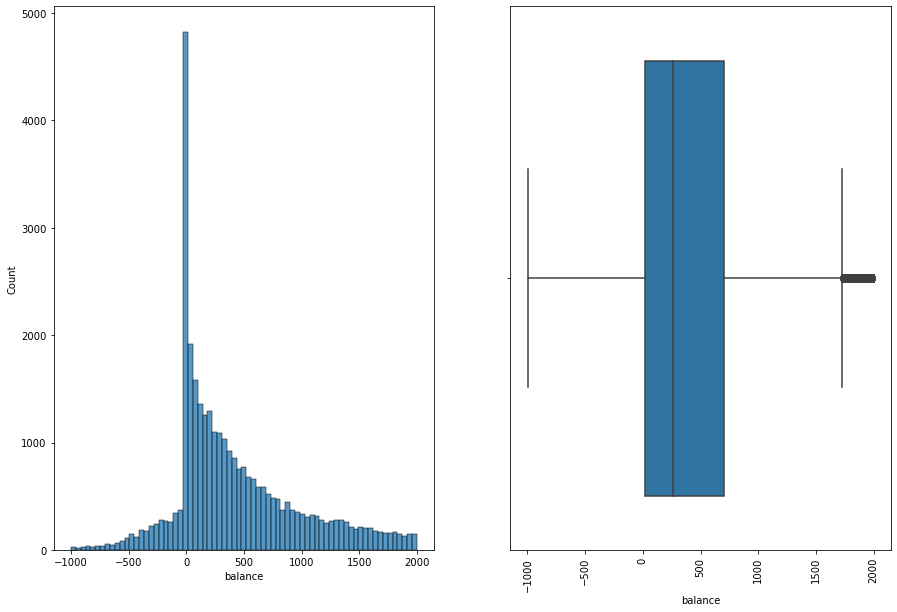

In [10]:
balance = df[(df.balance < 2000) & (df.balance > -1000)]

fig, ax = plt.subplots(1, 2, figsize=(15,10))
sns.histplot(data=balance, x='balance', ax=ax[0])
sns.boxplot(data=balance, x='balance', ax=ax[1])
plt.xticks(rotation=90)
plt.show()

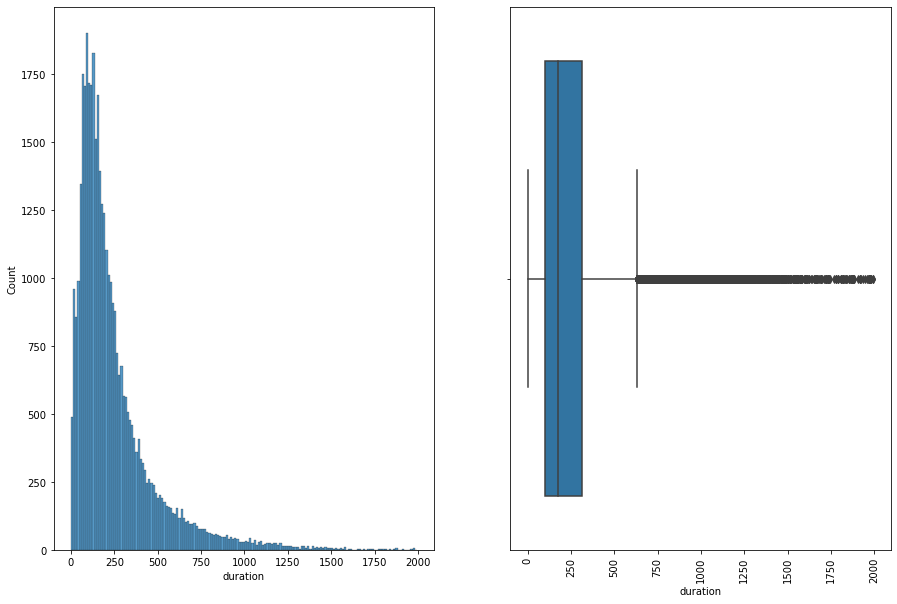

In [11]:
duration = df[df.duration < 2000]

fig, ax = plt.subplots(1, 2, figsize=(15,10))
sns.histplot(data=duration, x='duration', ax=ax[0])
sns.boxplot(data=duration, x='duration', ax=ax[1])
plt.xticks(rotation=90)
plt.show()

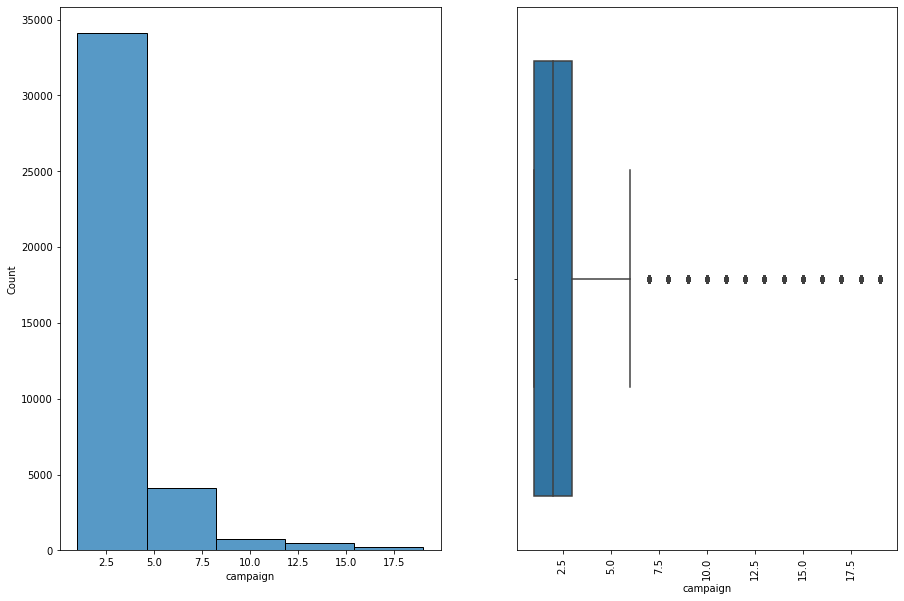

In [12]:
campaign = df[df.campaign < 20]

fig, ax = plt.subplots(1, 2, figsize=(15,10))
sns.histplot(data=campaign, x='campaign', ax=ax[0], bins=5)
sns.boxplot(data=campaign, x='campaign', ax=ax[1])
plt.xticks(rotation=90)
plt.show()

We can see that the longest call is about 1.5 hours while on average most calls never last longer than four minutes.
Based on the day of the month, it also looks like most calls are made from the middle to the end of the month while balances are on average $1500 per year.

In [13]:
subscribed_mean = pd.DataFrame(data = {1 : list(df[df.y == 'yes'].describe().T['mean']), 
                                      0 : list(df[df.y == 'no'].describe().T['mean'])},
                              index = numeric_features)
subscribed_mean.T

,age,balance,day,duration,campaign
1,39.844959,1588.495856,15.827003,682.958564,2.414365
0,40.599208,1249.752533,16.032072,221.408042,2.918688


In [14]:
subscribed_median = pd.DataFrame(data = {1 : list(df[df.y == 'yes'].describe().T['50%']), 
                                      0 : list(df[df.y == 'no'].describe().T['50%'])},
                              index = numeric_features)
subscribed_median.T

,age,balance,day,duration,campaign
1,37.0,620.0,16.0,629.0,2.0
0,39.0,395.0,17.0,164.0,2.0


In [15]:
subscribed_max = pd.DataFrame(data = {1 : list(df[df.y == 'yes'].describe().T['max']), 
                                      0 : list(df[df.y == 'no'].describe().T['max'])},
                              index = numeric_features)
subscribed_max.T

,age,balance,day,duration,campaign
1,95.0,45248.0,31.0,3881.0,32.0
0,94.0,102127.0,31.0,4918.0,63.0


If we breakdown the average, median, and max by those who subscribed or not, we can see that the longer someone is on a call, the likelier they are to subscribe. However, there are diminishing returns if a phone call is longer than an hour. On average those who stay on a call for approximately ~10 minutes are already more likely to purchase. This is also true for the number of campaign calls.

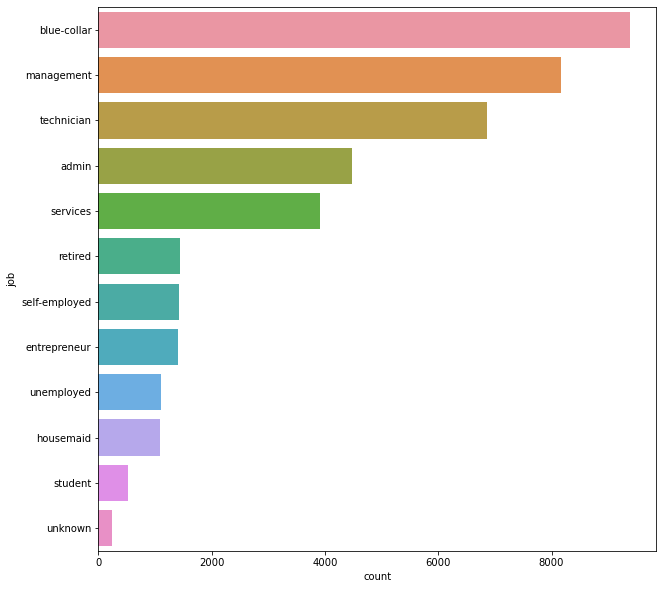

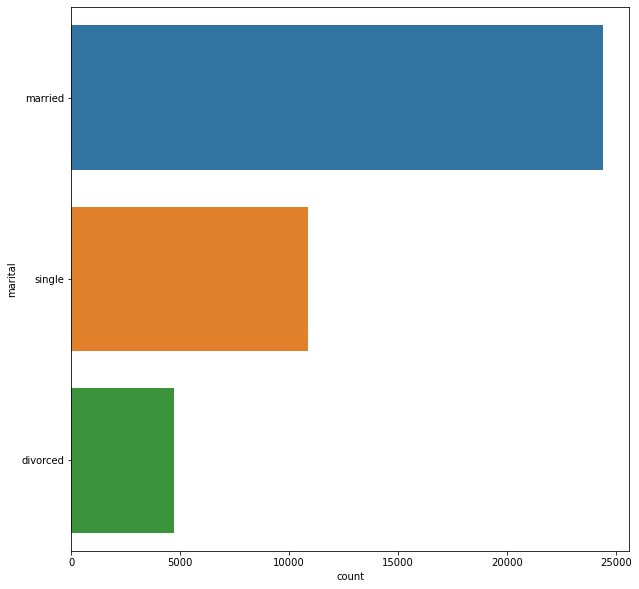

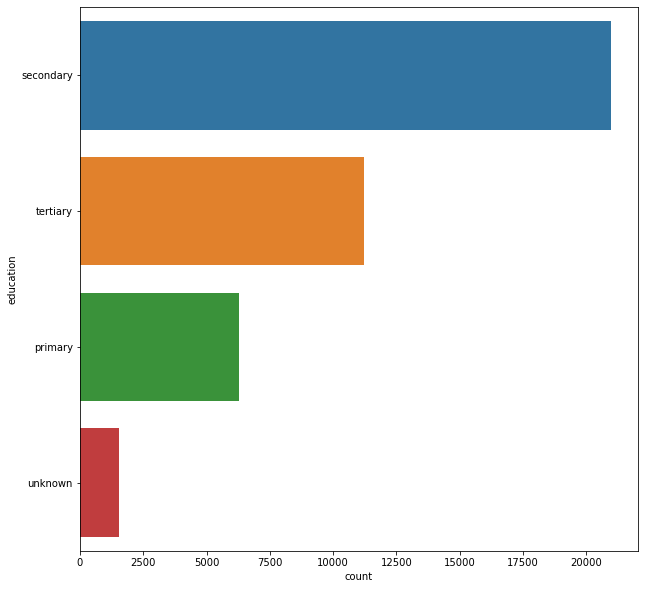

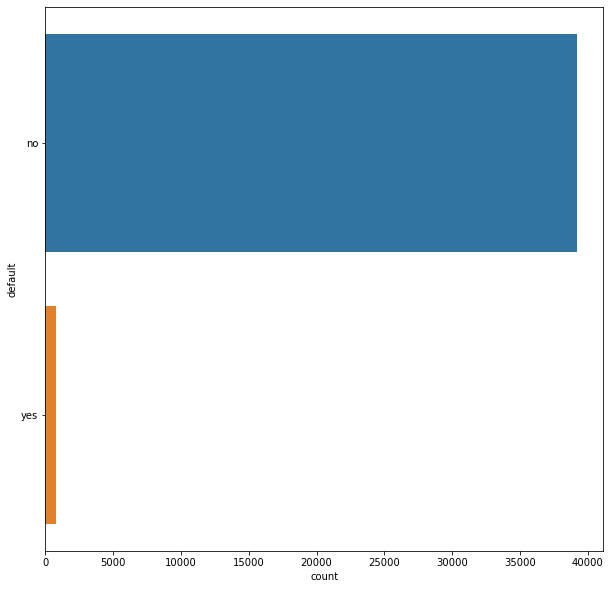

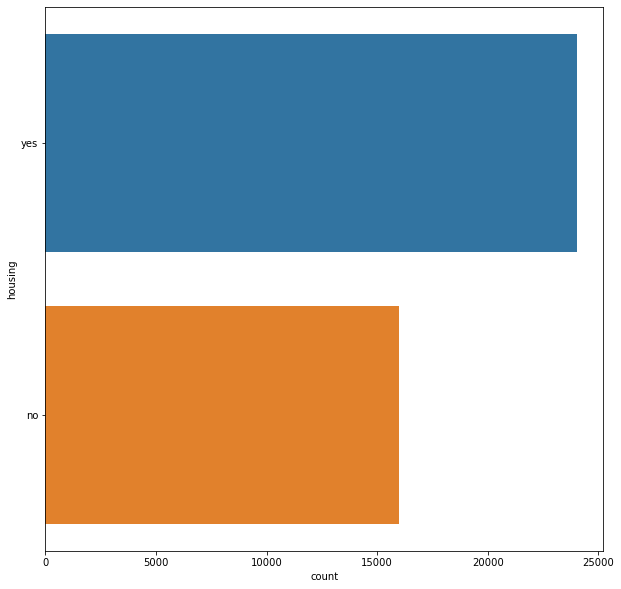

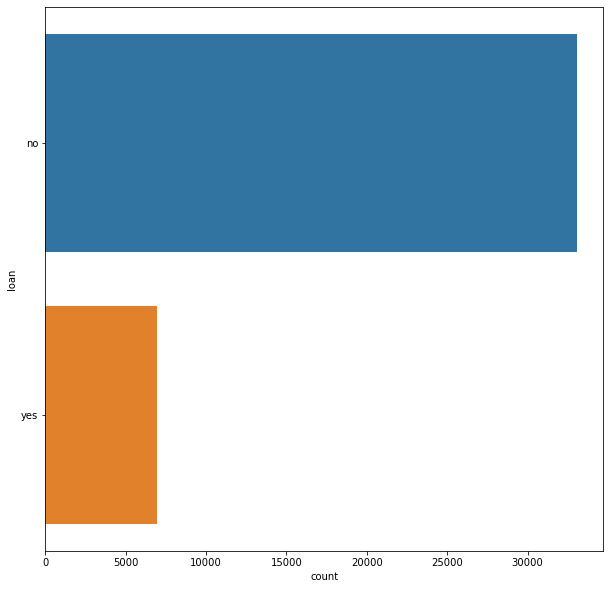

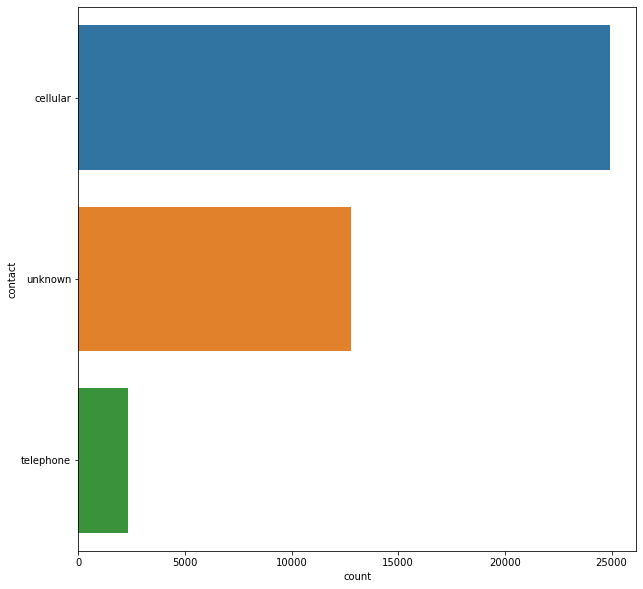

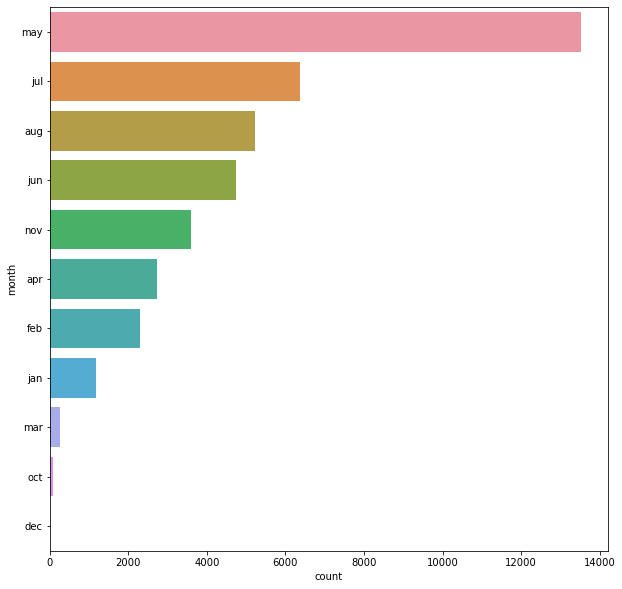

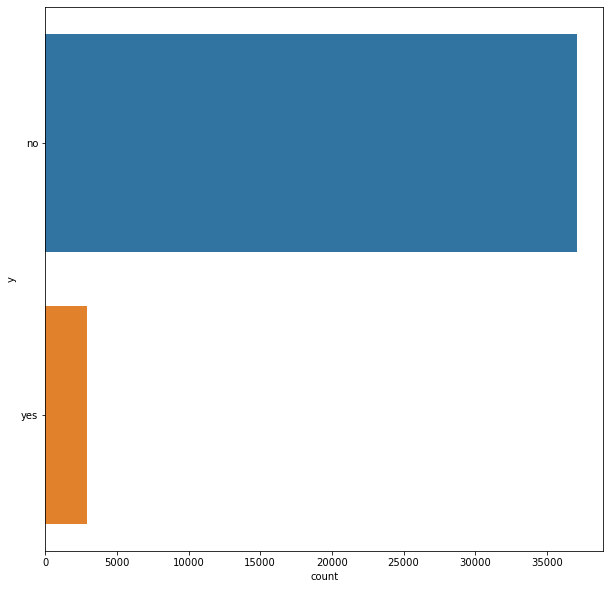

In [16]:
cat_features = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month', 'y']

for i in cat_features:
    plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    sns.countplot(data=df, y=df[i], order=df[i].value_counts().index)
    #plt.xticks(rotation = 90)
    plt.show()

In [17]:
for i in cat_features:
    print(f"{i} subscribed percentage\n{df[i].loc[(df.y == 'yes')].value_counts()/df[i].value_counts()*100}\n")

job subscribed percentage
admin             7.829578
blue-collar       5.701801
entrepreneur      6.263345
housemaid         4.875805
management        8.278227
retired          10.508003
self-employed     7.920792
services          6.086957
student          15.648855
technician        7.253357
unemployed        8.695652
unknown           7.234043
Name: job, dtype: float64

marital subscribed percentage
married     6.060855
single      9.431536
divorced    8.275132
Name: marital, dtype: float64

education subscribed percentage
secondary    6.754632
tertiary     9.182581
primary      5.629984
unknown      6.270411
Name: education, dtype: float64

default subscribed percentage
no     7.264423
yes    6.056860
Name: default, dtype: float64

housing subscribed percentage
yes    6.092131
no     8.967374
Name: housing, dtype: float64

loan subscribed percentage
no     7.608104
yes    5.483405
Name: loan, dtype: float64

contact subscribed percentage
cellular     8.962832
unknown      3.893459

We can also see that there are some differences with the segment of clients that we target versus those who actually subscribe. While blue-collar workers tend to be the main target client, students and retirees are more likely to subscribe to term-market depositing. Similarly, single clients and clients with tertiary education show a higher subscription percentage under marital status and education respectively.

The biggest difference however is in the months that calls our made. Here we can see that no calls were made in the month of September.While most calls were made in May, it only has a 5% subscribed rate and October and March show one of the highest subscription rates at 61% and 48% respectively.

Based on this preliminary review of the data we can already see where we might need to improve:

- the turnover rate on calls needs to be increased
- duration and campaigns need to be limited after a certain number of seconds and calls respectively
- calls made in other months other than May need to be increased
- targeting other demographics such as single clients, retirees, students

# DATA CLEANING

Based on the above, we can immediately do the following:

- change data types to the appropriate type.
- impute any missing data based on further exploratory analysis

In [18]:
#make a copy of the data in case you need the original
df1 = df.copy()

### IMPUTATION

For now, we will leave job and education as 'other' as there is a possibility that there is an occupation that was missed.
For education status, this could encompass people who only graduated highschool or didn't receive a formal education in general.

We will also change default status, housing, loan, and y to boolean values.

In [19]:
#change job to 'other'
df1.loc[df1.job =='unknown', 'job'] = 'other'

#change education to 'other'
df1.loc[df1.education =='unknown', 'education'] = 'other'

#change default to a boolean
df1.loc[df1.default =='yes', 'default'] = 1
df1.loc[df1.default =='no', 'default'] = 0
df1.default = df1.default.astype('int64')

#change housing to a boolean
df1.loc[df1.housing =='yes', 'housing'] = 1
df1.loc[df1.housing =='no', 'housing'] = 0
df1.housing = df1.housing.astype('int64')

#change loan to a boolean 
df1.loc[df1.loan =='yes', 'loan'] = 1
df1.loc[df1.loan =='no', 'loan'] = 0
df1.loan = df1.loan.astype('int64')

#change y to a boolean
df1.loc[df1.y =='yes', 'y'] = 1
df1.loc[df1.y =='no', 'y'] = 0
df1.y = df1.y.astype('int64')

Because there are so many missing and unknown values for contact by cellular or telephone, we can impute this data by backfilling. We will assume that all points of contact by the user are only made over the phone and not in person or by email. This logically only leaves two options: a cellphone or landline. We will back fill to help maintain the same ratio we showed earlier.

In [20]:
#change unknown values in cellular to a NAN value
df1.loc[df1.contact == 'unknown', 'contact'] = np.nan

#back fill contact information
df1.contact.fillna(method='bfill', inplace=True)

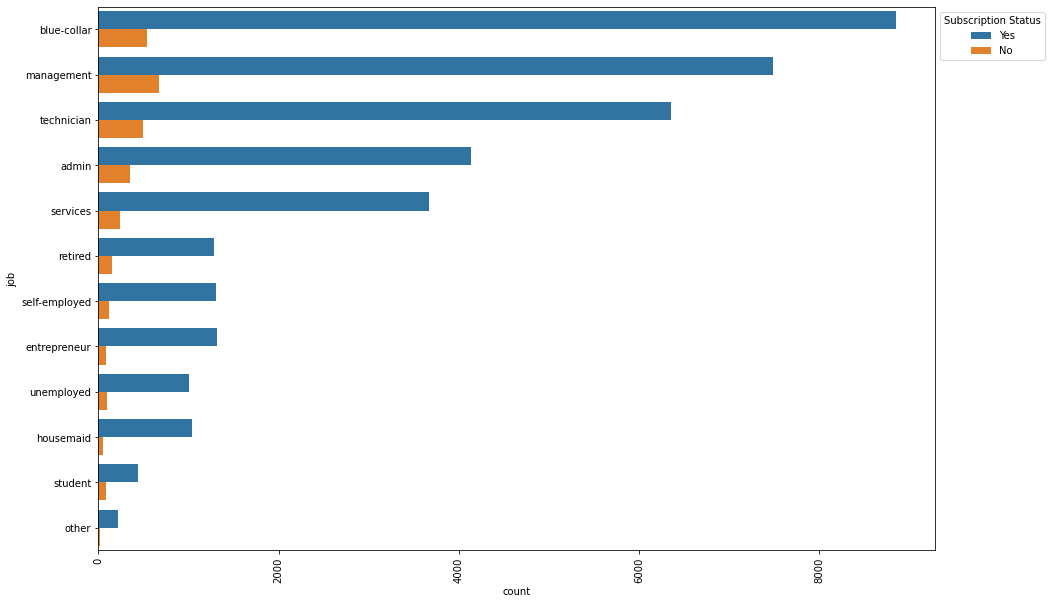

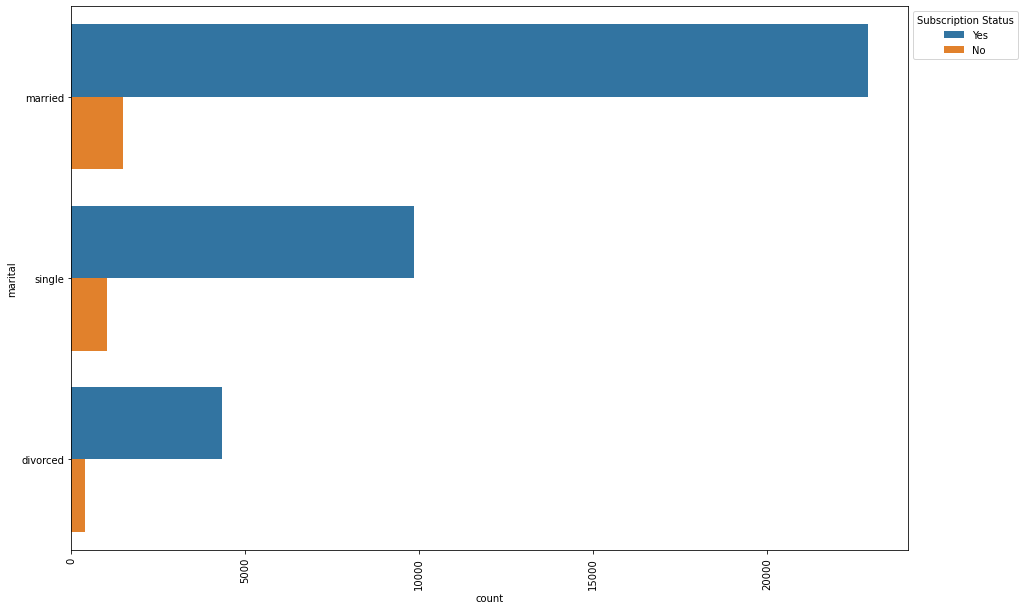

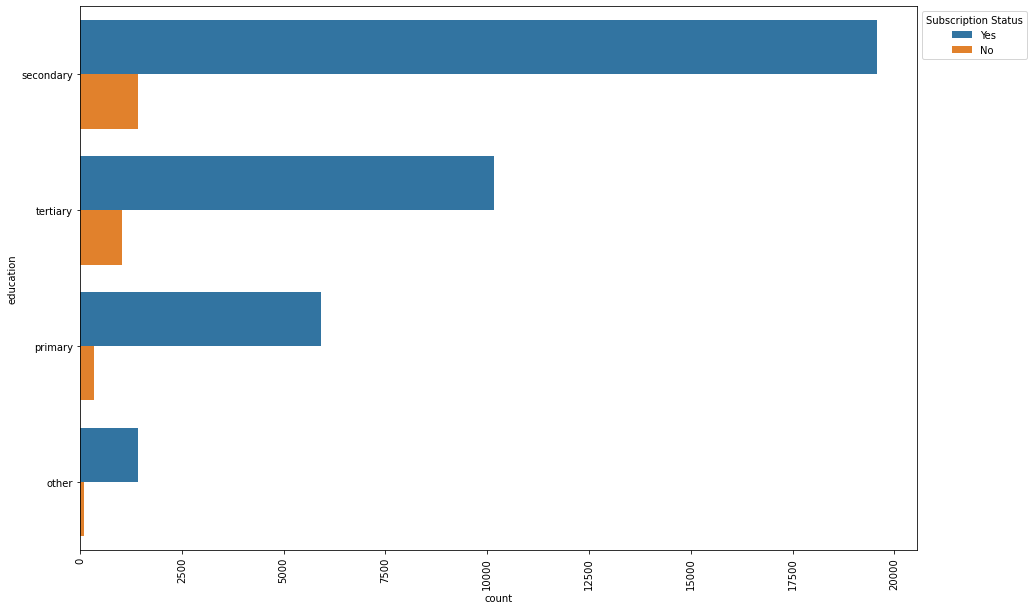

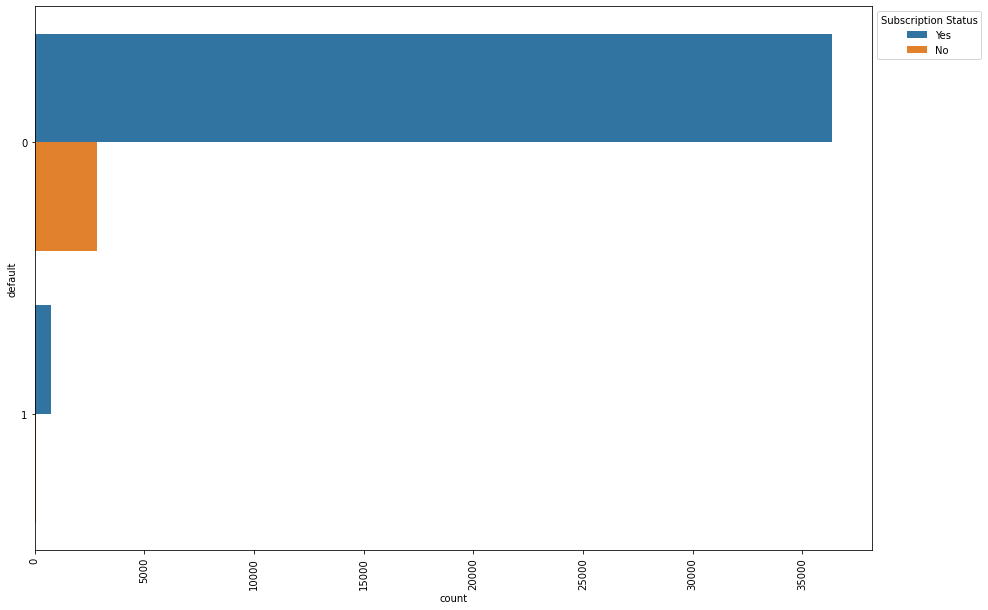

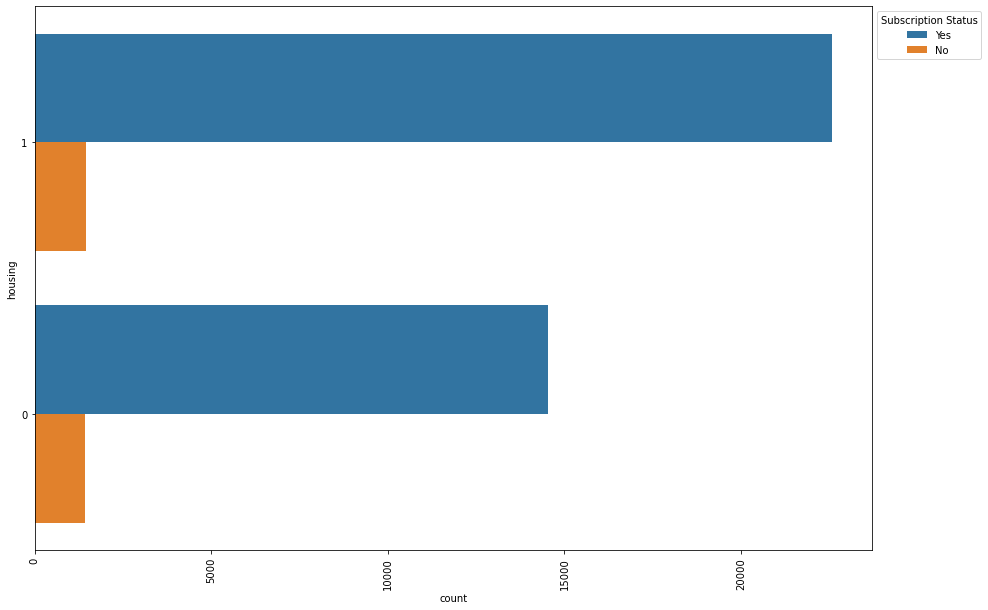

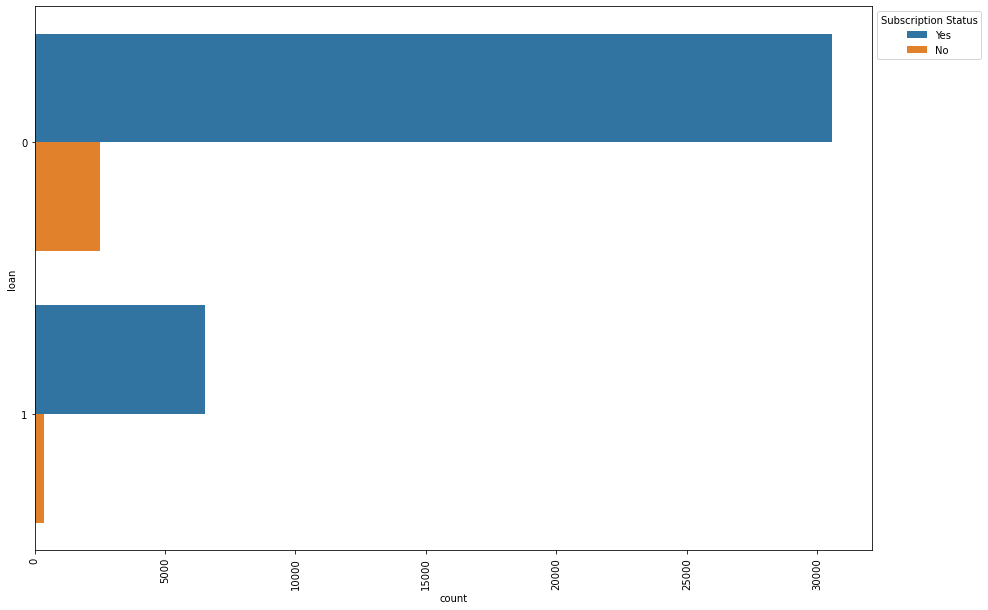

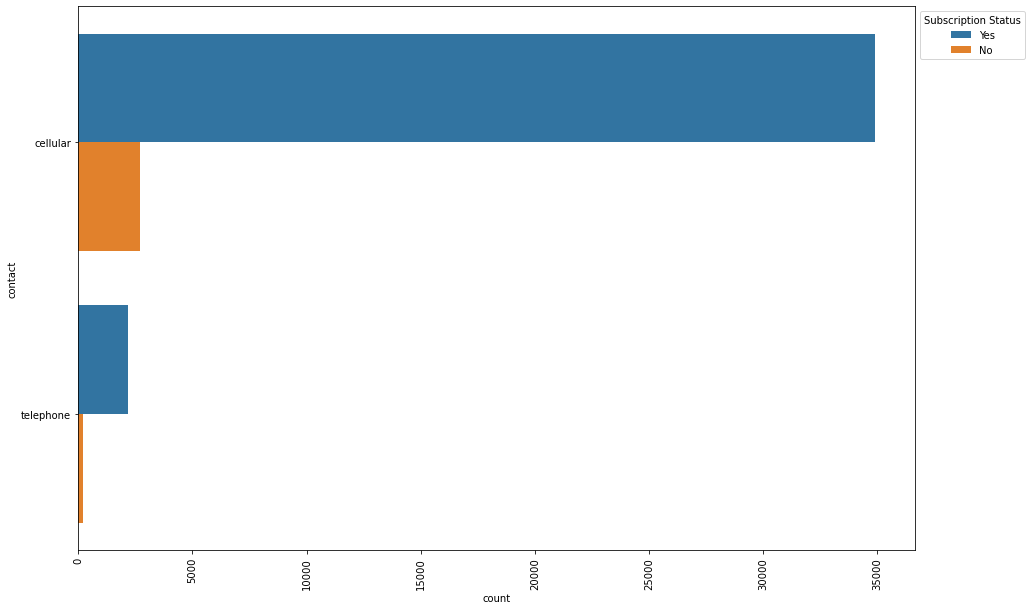

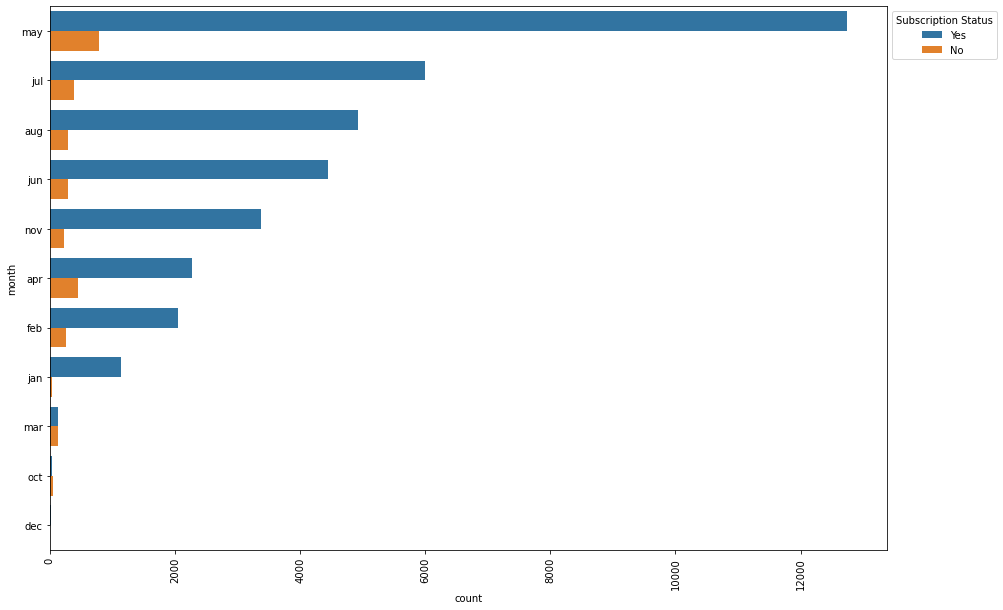

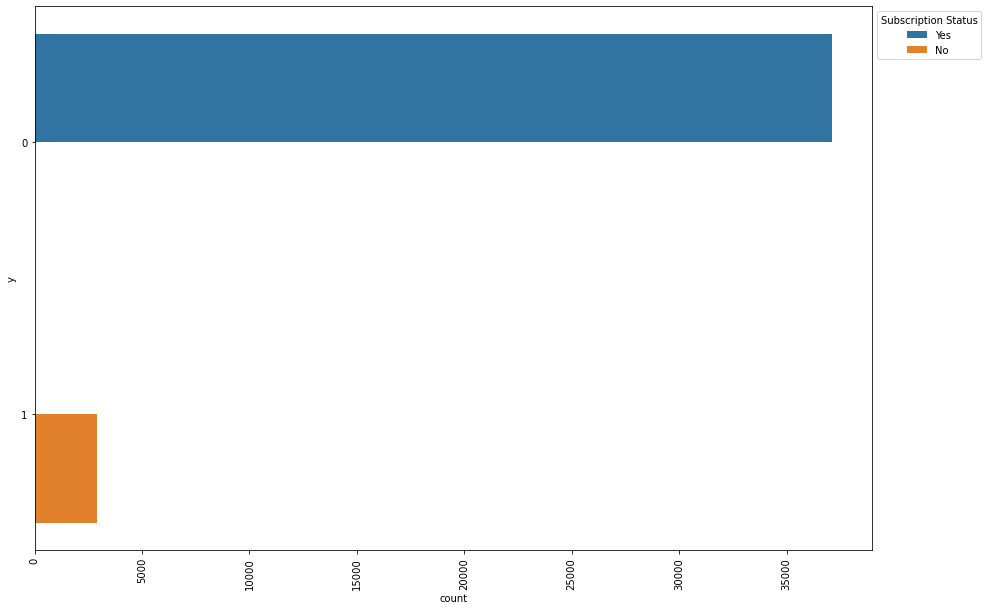

In [21]:
cat_features = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month', 'y']

for i in cat_features:
    plt.figure(figsize=(15,10))
    ax = plt.subplot(1, 1, 1)
    arr = sns.countplot(data=df1, y=df1[i], order=df1[i].value_counts().index, hue='y')
    legend_labels, _= ax.get_legend_handles_labels()
    _ = arr.legend(legend_labels, ['Yes','No'], bbox_to_anchor=(1,1), title='Subscription Status')
    plt.xticks(rotation = 90)
    plt.show()

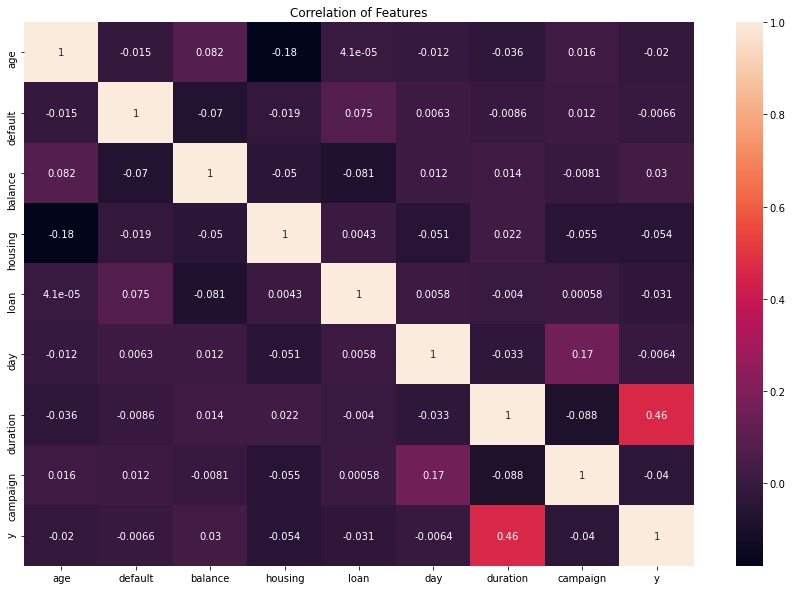

In [22]:
plt.subplots(figsize=(15,10))
plt.title('Correlation of Features')
sns.heatmap(df1.corr(), annot=True)
plt.show()

We can see here that there is a slight relationship between duration and whether or not a client subscribes. This confirms our assumption earlier that the longer the client is on the call the likelier they are to subscribe.

# PRE-PROCESSING

Because this is a highly imbalanced dataset, we are going to preprocess using the  following techniques:

- __Transformation (1st try):__ To normalize the distribution further, we will test various transformations. 
- __Clipping__: If there are any numerical features that are still skewed, we revert back to our original dataset and clip outliers __pre-transformation__ using a z-score and see if this improves skewness
- __Binning:__ At the end of our evaluation and modeling, we want to determine which market segments are most important for converting a customer. We can determine this a lot easier if we initially group certain features like age, duration of calls, customer balance, and campaign.
- __Transformation (2nd try):__ After encoding the variables, we can try transforming on this new dataframe
- __One-Hot or Label Encoding:__ We will change the categorical variables to numerically encoded values and see if the data is still skewed and needs to be transformed. We may not need to transform the data if the skew threshold is less than +/- 0.5
- __Evaluate Model Accuracy:__ Using pycaret, we will check the accuracy of our data
- __Bagging and Bootstrapping:__ If the accuracy is not acceptable, we resample on our imbalanced dataset before creating dummy variables again. 

The current event occurence (acquires a term market deposit) is at 7% 

### TRANSFORMATION (TESTING SKEWNESS)

Before we model on the data, we need to look at some ways to transform each feature and normalize the data. Let's take a look at the skew and kurtosis. Skew is the measure of symmetry of the data on the left and right of the centerpoint and kurtosis measures how heavily tailed the data is relative to the normal distribution.

In [24]:
df1.agg(['skew', 'kurtosis']).T

,skew,kurtosis
age,0.436080,-0.503828
default,6.816736,44.470109
balance,8.259236,141.833247
housing,-0.411561,-1.830709
loan,1.726785,0.981834
day,0.067930,-1.052935
duration,3.165307,18.189852
campaign,4.730901,36.223536
y,3.300155,8.891467


We can see that that balance is heavily right-tailed. While duration and campaign are lightly right-tailed.
We can try and perform the following transformations and see if this normalizes the data:

- yeo-johnson transformation: allows for negative values
- standardization: not sensitive to outliers
- minmax scaler

Since the __balance__ column is the only feature with negative values, we will use the yeo-johnson transformation first and see if the data is sufficiently transformed for further preprocessing. We will also only transform the numeric features like age, balance, day, duration, and campaign.

In [25]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(df1[numeric_features])

yj_arr= pt.transform(df1[numeric_features])
yj_df = pd.DataFrame(yj_arr, columns=numeric_features)
yj_df.agg(['skew', 'kurtosis']).T

,skew,kurtosis
age,0.001901,-0.770615
balance,1.058649,82.982952
day,-0.160918,-0.998209
duration,0.013301,0.360479
campaign,0.213011,-1.169580


We were able to significantly reduce the skew for all numerical features. However, as we can see balance is still moderately skewed. We may need to drop some of the larger outliers as the minimum and maximum values are -33 and -22 respectively. Let's try Standardization and Normalization first and see if this successfully transforms the features.

In [27]:
ss = StandardScaler()
ss.fit(df1[numeric_features])

ss_arr = ss.transform(df1[numeric_features])
ss_df = pd.DataFrame(ss_arr, columns=numeric_features)

ss_df.agg(['skew', 'kurtosis']).T

,skew,kurtosis
age,0.436080,-0.503828
balance,8.259236,141.833247
day,0.067930,-1.052935
duration,3.165307,18.189852
campaign,4.730901,36.223536


In [28]:
mm = MinMaxScaler()
mm.fit(df1[numeric_features])

mm_arr = ss.transform(df1[numeric_features])
mm_df = pd.DataFrame(ss_arr, columns=numeric_features)

mm_df.agg(['skew', 'kurtosis']).T

,skew,kurtosis
age,0.436080,-0.503828
balance,8.259236,141.833247
day,0.067930,-1.052935
duration,3.165307,18.189852
campaign,4.730901,36.223536


We can see that yeo-johnson is the best performing transformation. Let's see if removing any large outliers from balance will change anything.

### CLIPPING

#### BALANCE

In [29]:
# calculate the z-score with and find all outliers beyond the threshold of 3
z = np.abs(zscore(yj_df.balance))

# determine what percentage of our data would be lost if we were to delete these outliers
print(f'After yeo-johnson transformation: {len(np.where( z > 3)[0])}')
print(f'Data Loss: {round(len(np.where( z > 3)[0])/len(df.balance)*100, 2)}%')

# determine what percentage of data would be lost before the transformation
z = np.abs(zscore(df1.balance))
print(f'Before yeo-johnson transformation: {len(np.where(z>3)[0])}')
print(f'Data Loss: {len(np.where( z > 3)[0])/len(df.balance)*100}%')

After yeo-johnson transformation: 765
Data Loss: 1.91%
Before yeo-johnson transformation: 674
Data Loss: 1.685%


We lose less data removing data before the transformation. Let's drop these features and create a new dataframe with them.

In [30]:
drop_index = np.where(z>3)[0]

In [31]:
df2 = df1.drop(drop_index, axis=0).reset_index(drop=True)

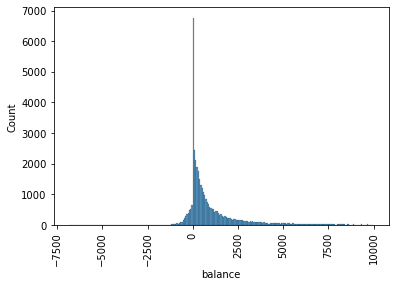

In [32]:
sns.histplot(data=df2, x='balance')
plt.xticks(rotation=90)
plt.show()

Since age and day have a skew less than +/- 0.5, we won't transform these.

In [33]:
num_feats = ['balance', 'duration', 'campaign']

pt = PowerTransformer(method='yeo-johnson')
pt.fit(df2[num_feats])

yj_arr = pt.transform(df2[num_feats])
yj_df = pd.DataFrame(yj_arr, columns=num_feats)
yj_df.agg(['skew', 'kurtosis']).T

,skew,kurtosis
balance,0.296910,17.116444
duration,0.013221,0.358989
campaign,0.212551,-1.168585


We want to be able to look at feature importance for all features, so we will try to group all values into categorical variables and normalize the data this way instead of transforming the data.

### BINNING

We are now going to bin the following features:

- age
- balance
- duration
- campaign
- job

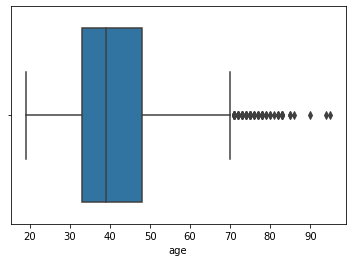

In [34]:
sns.boxplot(data=df2, x='age')
plt.show()

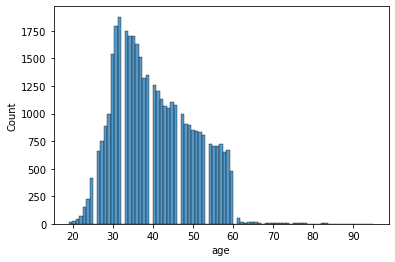

In [35]:
sns.histplot(data=df2, x='age')
plt.show()

Based on the boxplot, we will create labels and increments every 10 years from 20 through 70 inclusive. All other groupings will be '20 and under' and '71+'

#### AGE

In [36]:
# create bins and labels for increments of 10 years
bins = [0, 20, 30, 40, 50, 60, 70, df2.age.max()]
labels = ['20 and under','21-30 years old','31-40 years old','41-50 years old','51-60 years old',
          '61-70', '71+']
# bin data
df2['age'] = pd.cut(df2['age'] , bins=bins, labels=labels, include_lowest=True)

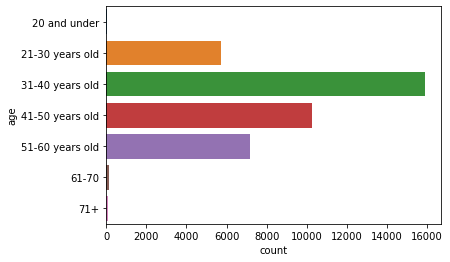

In [37]:
sns.countplot(data=df2, y='age')
plt.show()

#### BALANCE

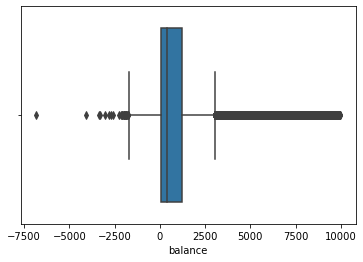

In [38]:
sns.boxplot(data=df2, x='balance')
plt.show()

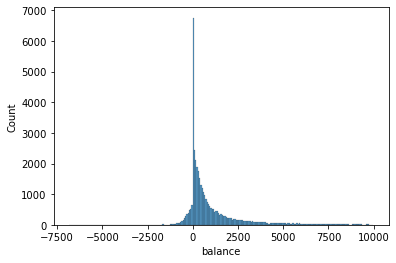

In [39]:
sns.histplot(data=df2, x='balance')
plt.show()

Based on the IQR we will group our data by increments of 500 with anything +/- 2000 as large outliers.

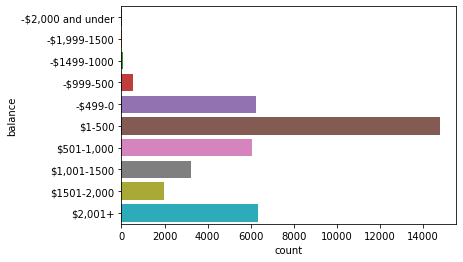

In [40]:
bins = [df2.balance.min(), -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, df2.balance.max()]
labels = ['-$2,000 and under', '-$1,999-1500', '-$1499-1000', '-$999-500', '-$499-0','$1-500', 
          '$501-1,000', '$1,001-1500', '$1501-2,000', '$2,001+']

df2['balance'] = pd.cut(df2['balance'], bins=bins, labels=labels, include_lowest=True)

sns.countplot(data=df2, y='balance')
plt.show()

#### DURATION

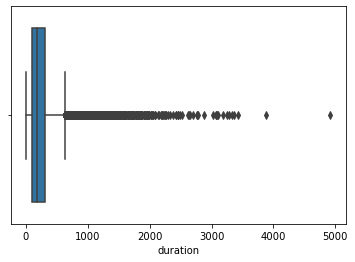

In [41]:
sns.boxplot(data=df2, x='duration')
plt.show()

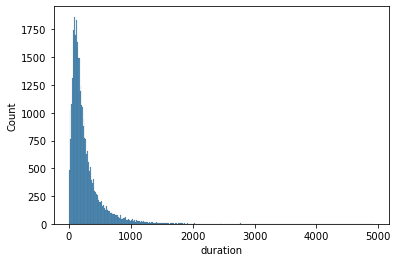

In [42]:
sns.histplot(data=df2, x='duration')
plt.show()

Based on the IQR, we will increment by 1 minute up until 15 minutes at which everything is an outlier.

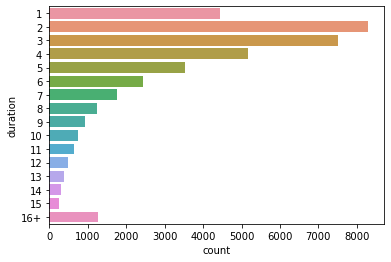

In [43]:
bins = [0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, df2.duration.max()]
#         960, 1020, 1080, 1140, 1200, df1.duration.max()]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, '16+']
#           16, 17, 18, 19, 20, '21+']

df2['duration'] = pd.cut(df2['duration'], bins=bins, labels=labels, include_lowest=True )

sns.countplot(data=df2, y='duration')
plt.show()

#### CAMPAIGN

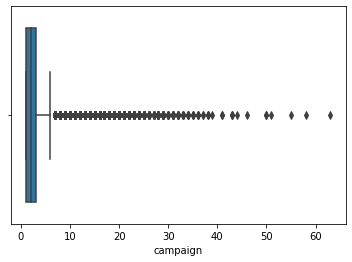

In [44]:
sns.boxplot(data=df2, x='campaign')
plt.show()

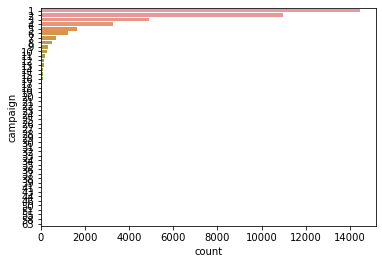

In [45]:
sns.countplot(data=df2, y='campaign')
plt.show()

We will only look at the first 5 campaigns and group anything above a 6 as outliers.

In [46]:
df2.loc[df2.campaign > 5, 'campaign'] = '6+'
df2['campaign'] = df2['campaign'].astype('category')

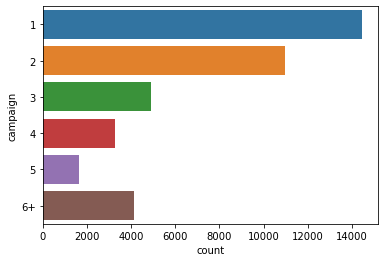

In [47]:
sns.countplot(data=df2, y='campaign')
plt.show()

#### JOB

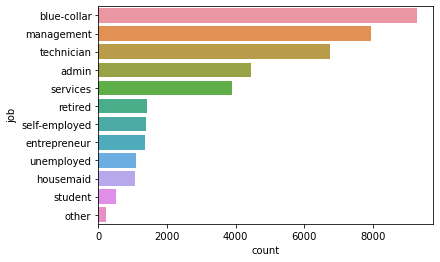

In [48]:
sns.countplot(data=df2, y='job', order=df2.job.value_counts().sort_values(ascending=False).index)
plt.show()

To normalize this data, let's generalize the groupings into the following values:

- blue-collar
- management
- technician
- admin
- services
- unemployed
- entrepreneur
- other

We can move 'housemaid' under 'services', 'student' under 'other', 'self-employed' with 'entrepreneur', and 'retired' with 'unemployed'

In [49]:
df2.loc[df2.job == 'housemaid', 'job'] = 'services'
df2.loc[df2.job == 'self-employed', 'job'] = 'entrepreneur'
df2.loc[df2.job == 'student', 'job'] = 'other'
df2.loc[df2.job == 'retired', 'job'] = 'unemployed'

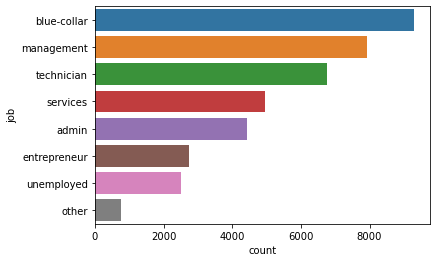

In [50]:
sns.countplot(data=df2, y='job', order=df2.job.value_counts().sort_values(ascending=False).index)
plt.show()

Let's create a new dataframe with out new binned variables.

### DUMMY VARIABLES

We will use two label encoding for all our features. Age, balance, campaign, and duration are already category variables so we can just change everything else.

In [51]:
#create a new dataframe
#get dummies for non-ordinal features
df4 = df2.copy()
#df4 = pd.get_dummies(df4, columns=['job', 'marital', 'contact'])

#job
df4.job = df4.job.astype('category').cat.codes

#marital
df4.marital = df4.marital.astype('category').cat.codes

#contact
df4.contact = df4.contact.astype('category').cat.codes

#get dummies for ordinal features
# age
df4.age = df4.age.cat.codes

# education
df4.education = df4.education.astype('category')
# set order for education
education_sort = ['other', 'primary', 'secondary', 'tertiary']
df4.education = df4.education.cat.reorder_categories(education_sort, ordered=True)
df4.education = df4.education.cat.codes

# balance
df4.balance = df4.balance.cat.codes

# duration
df4.duration = df4.duration.cat.codes

# campaign
df4.campaign = df4.campaign.cat.codes

# month
df4.month = df4.month.astype('category')
# set order for month
month_sort = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec']
df4.month = df4.month.cat.reorder_categories(month_sort, ordered=True)
df4.month = df4.month.cat.codes

In [52]:
# place the target variable y at the end of the dataframe
hold = list(df4.y)
df4 = df4.drop('y', axis=1)

# place y at the end of the dataframe
df4['y']= 0
df4['y'] = hold

# change all to type int
df4=df4.astype('int64')

# MODELING

### TRAIN TEST SPLIT

In [54]:
def create_df(X, y):
    data = pd.DataFrame(X)
    data['y'] = y
    data.reset_index(drop=True, inplace=True)
    return data

In [55]:
df_final = df4.copy()

In [56]:
X = df_final.drop(columns = 'y', axis=1)
y = df_final.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

df = create_df(X_train, y_train)

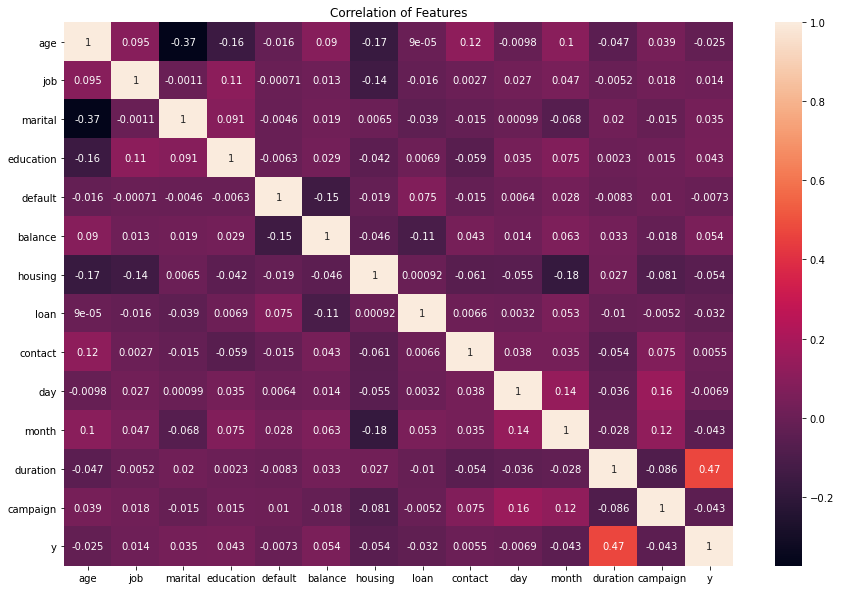

In [57]:
plt.subplots(figsize=(15,10))
plt.title('Correlation of Features')
sns.heatmap(df.corr(), annot=True)
plt.show()

#### MODEL REVIEW

Let's look at which model performs the best based on our current feature engineering.

In [59]:
def get_best_model(data):
    
    clf1 = setup(data, target = data.columns[-1], silent = True, verbose = False)
    #compare the models
    top5 = compare_models(n_select = 3) 
    #find the best model
    best = automl(optimize = 'Accuracy')

    print(best)
    
    return None

In [60]:
get_best_model(df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9372,0.9384,0.3706,0.6057,0.4593,0.4279,0.4428,3.7480
lightgbm,Light Gradient Boosting Machine,0.9350,0.9400,0.3428,0.5838,0.4315,0.3995,0.4157,0.2580
ridge,Ridge Classifier,0.9341,0.0000,0.3049,0.5801,0.3991,0.3679,0.3895,0.0300
gbc,Gradient Boosting Classifier,0.9339,0.9277,0.2582,0.5974,0.3594,0.3303,0.3635,0.8620
lr,Logistic Regression,0.9329,0.9229,0.2967,0.5647,0.3885,0.3567,0.3777,1.6410
ada,Ada Boost Classifier,0.9320,0.9254,0.2885,0.5537,0.3782,0.3461,0.3673,0.2590
rf,Random Forest Classifier,0.9317,0.9249,0.2696,0.5555,0.3624,0.3309,0.3555,0.5610
svm,SVM - Linear Kernel,0.9308,0.0000,0.3016,0.5553,0.3615,0.3313,0.3599,0.1460
et,Extra Trees Classifier,0.9298,0.9110,0.2929,0.5263,0.3758,0.3417,0.3586,0.7090
knn,K Neighbors Classifier,0.9294,0.6594,0.0543,0.6191,0.0992,0.0885,0.1666,0.7050


We need to resample the data because while the accuracy is very high, the precision and recall scores are less than 75%.

### BOOTSTRAPPING AND BAGGING

Let's take a look at the distribution of the target variable and determine it's event occurence.

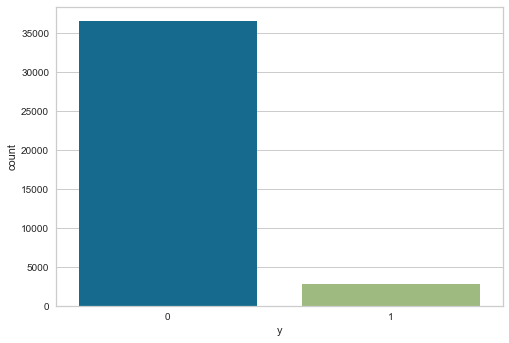

In [61]:
sns.countplot(data=df_final, x='y')
plt.show()

In [62]:
event = df_final.loc[df_final.y == 1, 'y'].count()/len(df_final.loc[:, 'y'])
print(f'The event occurence of a customer getting a term market deposit: {round(event*100, 2)}%\n',
      f"Number of subscribed users: {df_final.loc[df_final.y == 1, 'y'].count()}\n",
      f"Number of subscribed users: {df_final.loc[df_final.y == 0, 'y'].count()}\n",
      f"Number of total users: {len(df_final.loc[:, 'y'])}")

The event occurence of a customer getting a term market deposit: 7.21%
 Number of subscribed users: 2834
 Number of subscribed users: 36492
 Number of total users: 39326


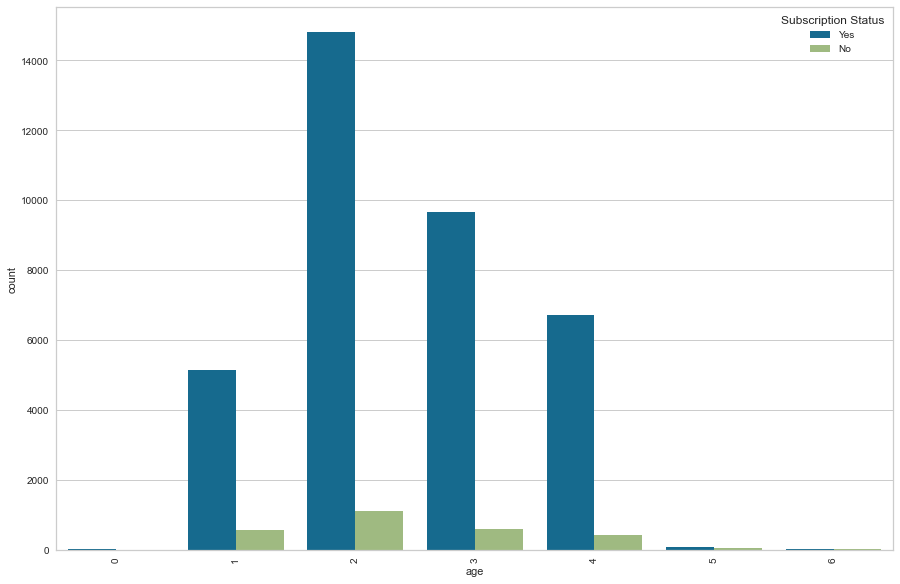

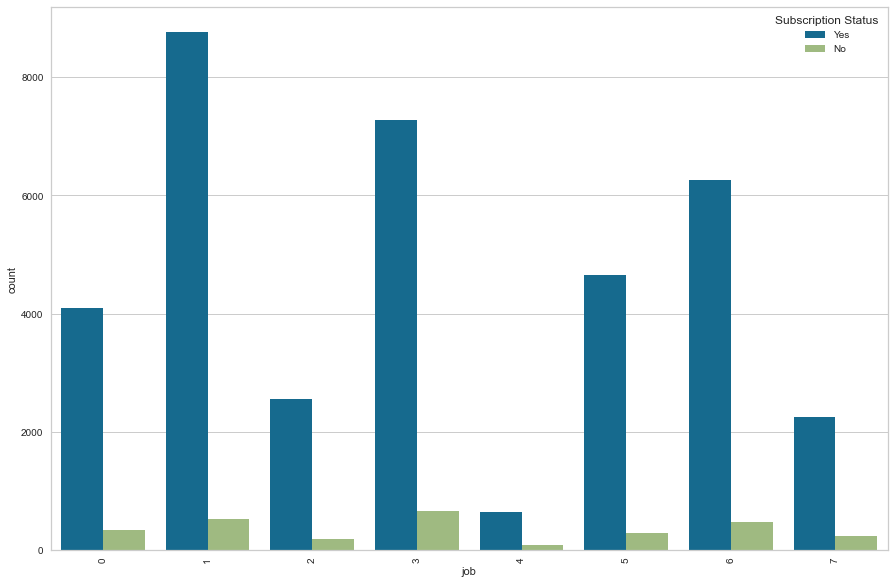

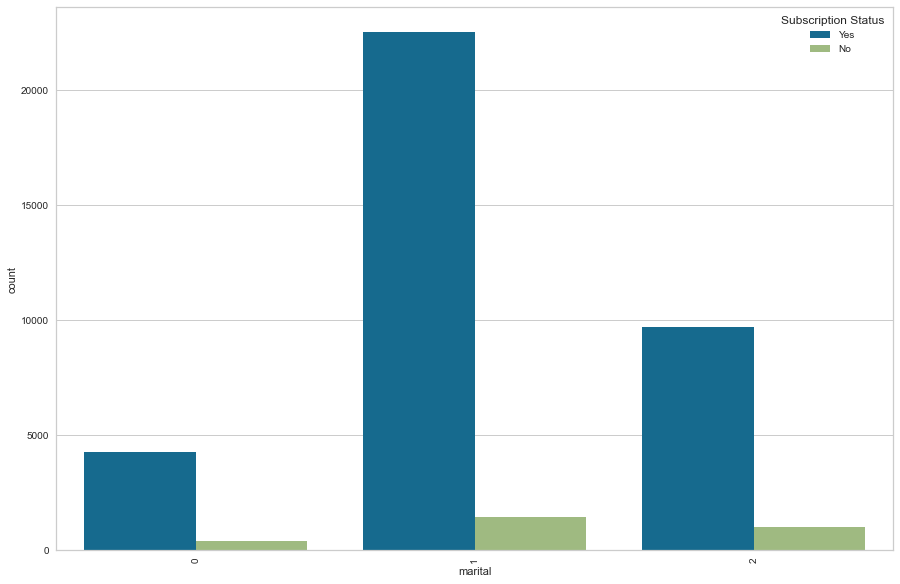

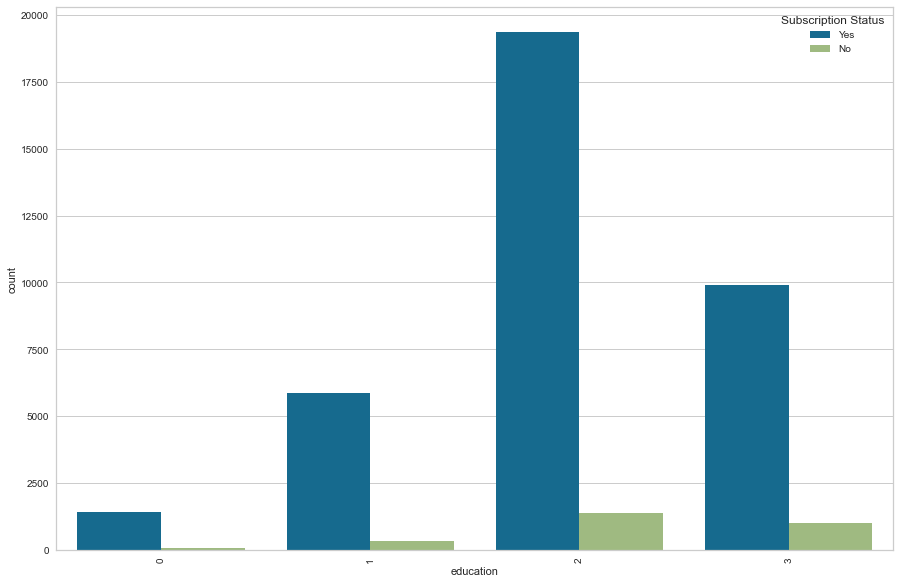

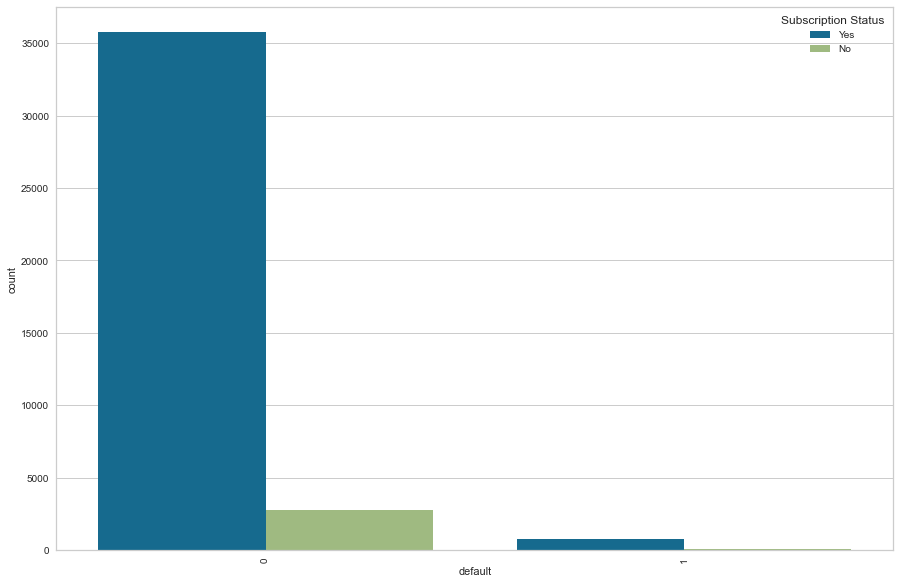

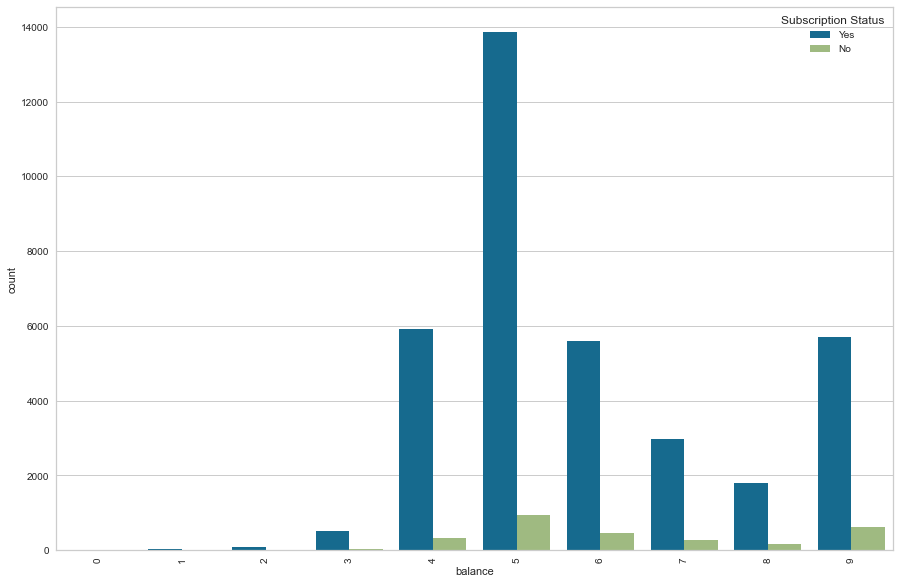

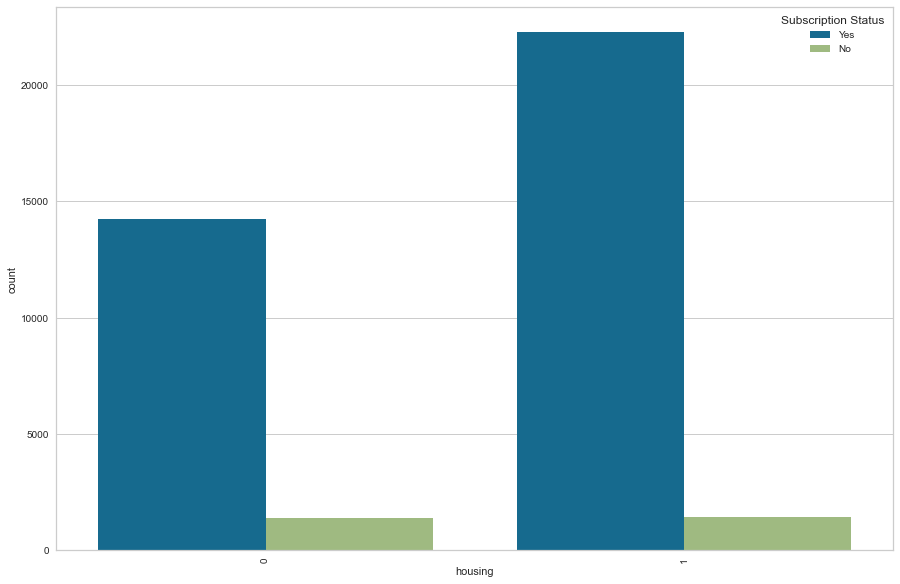

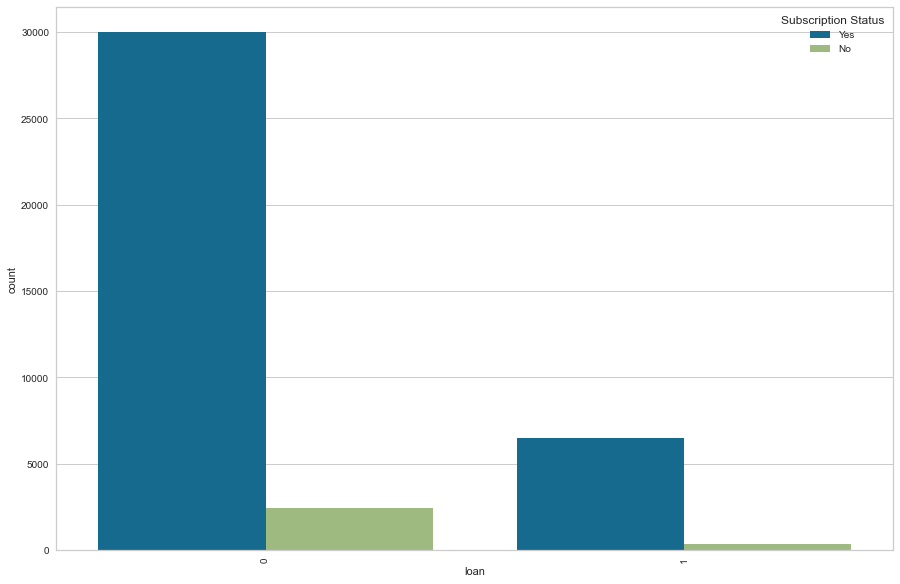

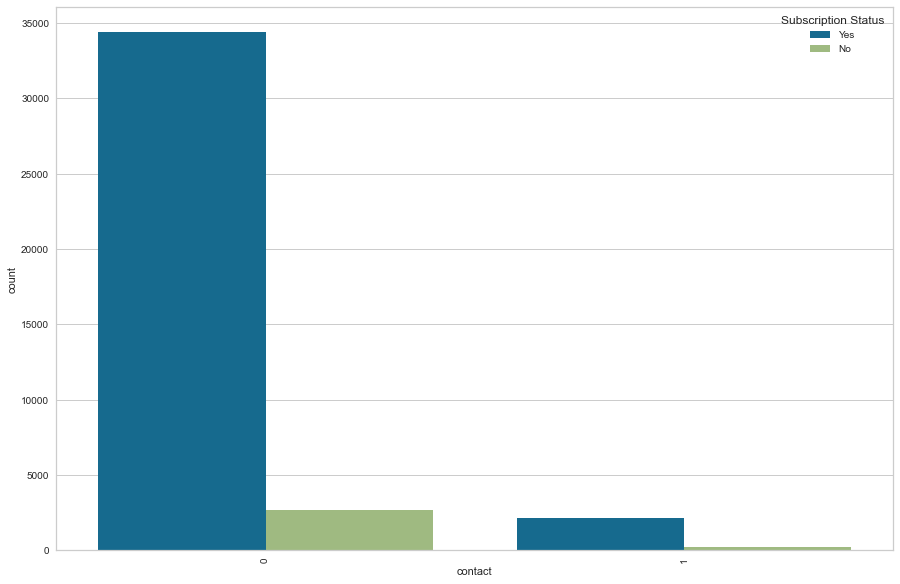

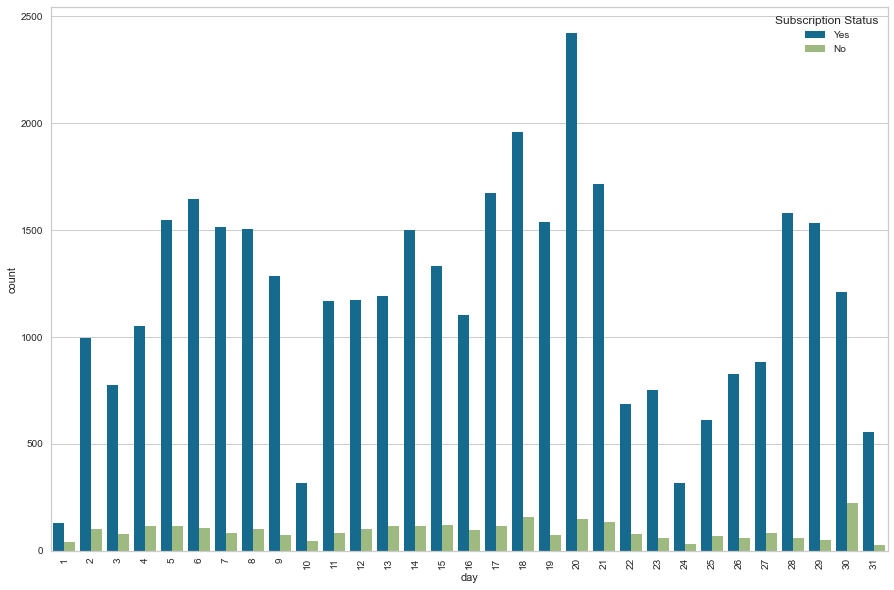

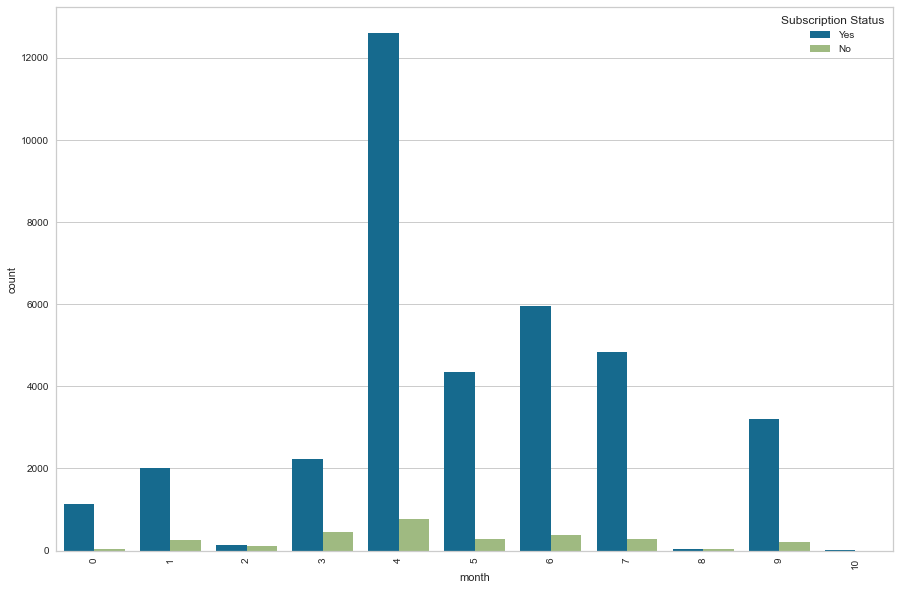

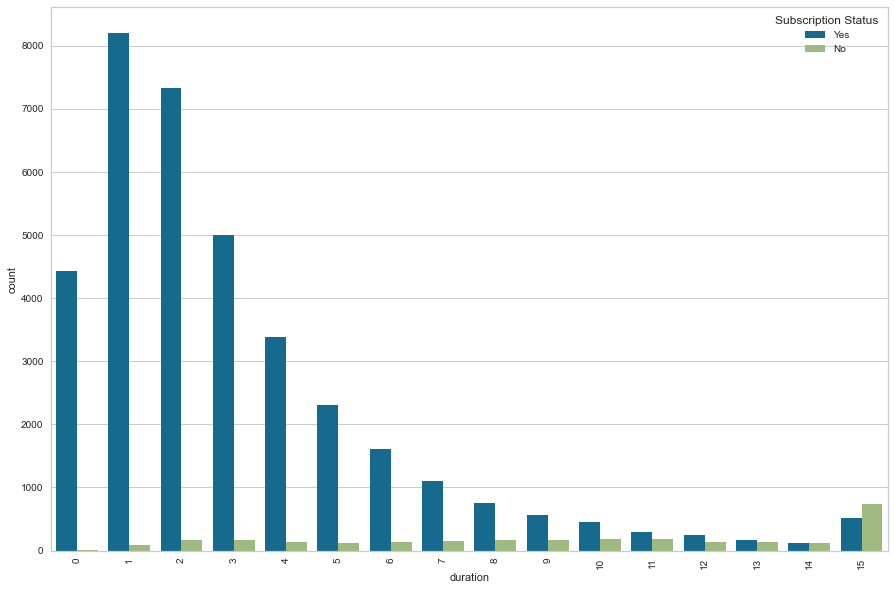

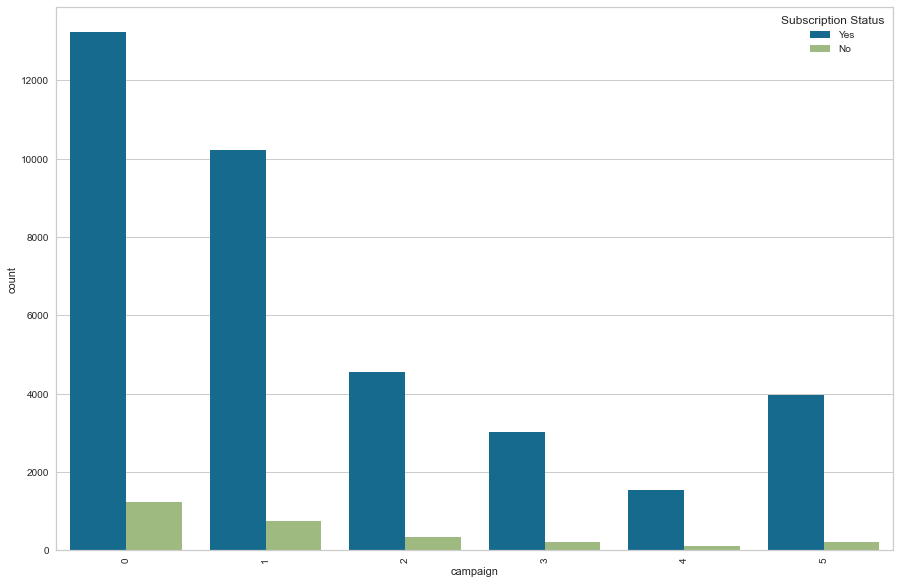

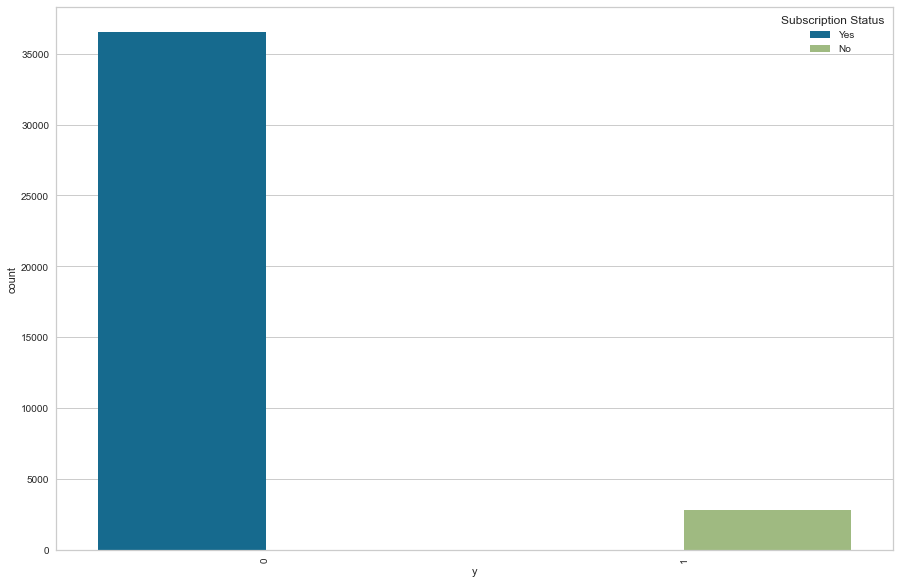

In [63]:
#cat_features = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month', 'y']

# for i in cat_features:
for i in df_final.columns:
    plt.figure(figsize=(15,10))
    ax = plt.subplot(1, 1, 1)
    arr = sns.countplot(data=df_final, x=df_final[i], hue='y')#, order=df_final[i].value_counts().index, hue='y')
    legend_labels, _= ax.get_legend_handles_labels()
    _ = arr.legend(legend_labels, ['Yes','No'], bbox_to_anchor=(1,1), title='Subscription Status')
    plt.xticks(rotation = 90)
    plt.show()

Let's use bootstrapping and bagging with replacement to try and increase the smaller class such that the ratio of unsubscribed to subscribed would be 80/20. This will increase our minority class to 9,123 data points for a total of 45,615 data points. While it would be ideal to create an equal ratio, we don't want to overfit the data too much. We just want the model to be able to recognize the minority class enough that we can increase our precision, recall, and f1-scores.

In [64]:
def bagging(arr, n_iters=40000, replacement=True):
    
    # set n_sample
    n_sample = len(arr)
    
    # create a list to hold our new dataset
    boot = []
    
    # generate samples over desired iterations
    for _ in range(n_iters):
        # choose a random index from the number of samples with replacement
        index = np.random.choice(range(n_sample), replace=replacement)
        # store the random index in a temp variable called sample
        sample = arr[index]
        # append sample to list
        boot.append(sample)
        
    return boot       

In [65]:
# save name of columns from df2 before the dummy variable creation and train test split
df_cols = df2.columns

# split customers by those who subscribed and didn't subscribe
df_1 = df2.loc[df_final.y == 1, :]
df_0 = df2.loc[df_final.y == 0, :]

# create an array with all values
subscribed_array = df_1.values
notsubscribed_array = df_0.values

# generate a random number of samples larger than each target value with replacement
subscribed_boot = bagging(subscribed_array, n_iters=40000, replacement=True)
notsubscribed_boot = bagging(notsubscribed_array, n_iters=40000, replacement=True)

#### UPSAMPLING

Upsample such that the number of subscribed values increases to 9,123 data points. We will keep the number of not subcribed customers the same for a ratio of 20/80 respectively. However, we will also sample these with replacement from the array of bagged samples. 

In [66]:
# set number of iterations to desired ratio for the new dataset
subscribed_iters = 9123
notsubscribed_iters = df2.loc[df_final.y == 0, 'y'].count()

# select values WITHOUT replacement as we've already sampled these with replacement earlier
subscribed = bagging(subscribed_boot, n_iters=subscribed_iters, replacement=False)
notsubscribed = bagging(notsubscribed_boot, n_iters=notsubscribed_iters, replacement=False)

# create a new dataframe
subscribed_df = pd.DataFrame(subscribed, columns=df_cols)
notsubscribed_df = pd.DataFrame(notsubscribed, columns=df_cols)

# concatenate both dataframes
df = pd.concat([subscribed_df, notsubscribed_df], axis=0).reset_index(drop=True)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45615 entries, 0 to 45614
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45615 non-null  object
 1   job        45615 non-null  object
 2   marital    45615 non-null  object
 3   education  45615 non-null  object
 4   default    45615 non-null  int64 
 5   balance    45615 non-null  object
 6   housing    45615 non-null  int64 
 7   loan       45615 non-null  int64 
 8   contact    45615 non-null  object
 9   day        45615 non-null  int64 
 10  month      45615 non-null  object
 11  duration   45615 non-null  object
 12  campaign   45615 non-null  object
 13  y          45615 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 4.9+ MB


In [69]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,51-60 years old,admin,married,secondary,0,-$499-0,1,0,cellular,10,jul,16+,1,1
1,21-30 years old,admin,single,secondary,0,"$2,001+",0,0,cellular,27,may,13,3,1
2,41-50 years old,management,married,other,0,"$2,001+",0,0,cellular,27,feb,4,1,1
3,41-50 years old,unemployed,married,tertiary,0,"$501-1,000",0,0,cellular,27,feb,3,1,1
4,41-50 years old,admin,single,secondary,0,"$2,001+",0,0,cellular,30,apr,11,2,1


#### CREATE NEW DUMMY VARIABLES

In [70]:
#create a new dataframe from upsampled data
#get dummies for non-ordinal features
df4 = df.copy()
#df4 = pd.get_dummies(df4, columns=['job', 'marital', 'contact'])

#job
df4.job = df4.job.astype('category').cat.codes

#marital
df4.marital = df4.marital.astype('category').cat.codes

#contact
df4.contact = df4.contact.astype('category').cat.codes

#get dummies for ordinal features
# age
df4.age = df4.age.astype('category').cat.codes

# education
df4.education = df4.education.astype('category')
# set order for education
education_sort = ['other', 'primary', 'secondary', 'tertiary']
df4.education = df4.education.cat.reorder_categories(education_sort, ordered=True)
df4.education = df4.education.astype('category').cat.codes

# balance
df4.balance = df4.balance.astype('category').cat.codes

# duration
df4.duration = df4.duration.astype('category').cat.codes

# campaign
df4.campaign = df4.campaign.astype('category').cat.codes

# month
df4.month = df4.month.astype('category')
# set order for month
month_sort = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec']
df4.month = df4.month.cat.reorder_categories(month_sort, ordered=True)
df4.month = df4.month.cat.codes

In [71]:
# place the target variable y at the end of the dataframe
hold = list(df4.y)
df4 = df4.drop('y', axis=1)

# place y at the end of the dataframe
df4['y']= 0
df4['y'] = hold

# change all to type int
df4=df4.astype('int64')

In [73]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45615 entries, 0 to 45614
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        45615 non-null  int64
 1   job        45615 non-null  int64
 2   marital    45615 non-null  int64
 3   education  45615 non-null  int64
 4   default    45615 non-null  int64
 5   balance    45615 non-null  int64
 6   housing    45615 non-null  int64
 7   loan       45615 non-null  int64
 8   contact    45615 non-null  int64
 9   day        45615 non-null  int64
 10  month      45615 non-null  int64
 11  duration   45615 non-null  int64
 12  campaign   45615 non-null  int64
 13  y          45615 non-null  int64
dtypes: int64(14)
memory usage: 4.9 MB


In [72]:
df4.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,4,0,1,2,0,8,1,0,0,10,6,15,0,1
1,1,0,2,2,0,3,0,0,0,27,4,12,2,1
2,3,3,1,0,0,3,0,0,0,27,1,3,0,1
3,3,7,1,3,0,4,0,0,0,27,1,2,0,1
4,3,0,2,2,0,3,0,0,0,30,3,10,1,1


In [84]:
df4.agg(['skew']).T

,skew
age,0.325225
job,0.193604
marital,-0.109404
education,-0.598520
default,6.718726
balance,1.000020
housing,-0.385495
loan,1.771764
contact,3.836755
day,0.065423


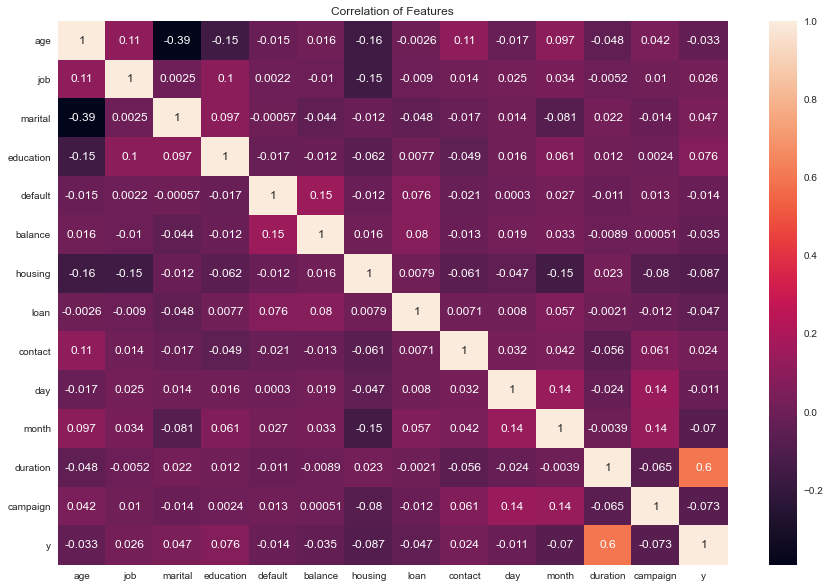

In [83]:
plt.subplots(figsize=(15,10))
plt.title('Correlation of Features')
sns.heatmap(df4.corr(), annot=True)
plt.show()

In [ ]:
# hypothesis test on how whether it makes a difference in subscription based on duration?

Based on the correlation matrix, we can see that duration is highly correlated with the likelihood a customer will subscribe. We don't want any multicollinearity in our models, so we can drop this feature and see if it improves our model. So, we'll create two different datasets:

- df1: keep all features
- df2: keep all features except duration

#### TRAIN TEST SPLIT

In [85]:
df1 = df4.copy()

df2 = df1.drop(columns='duration', axis=1)

In [86]:
X1 = df1.drop(columns = 'y', axis=1)
y1 = df1.y

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

train1 = create_df(X1_train, y1_train)
test1 = create_df(X1_test, y1_test)

In [87]:
X2 = df2.drop(columns = 'y', axis=1)
y2 = df2.y

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

train2 = create_df(X2_train, y2_train)
test2 = create_df(X2_test, y2_test)

In [88]:
get_best_model(train1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9685,0.9926,0.9194,0.9217,0.9205,0.9009,0.9009,0.7070
et,Extra Trees Classifier,0.9667,0.9933,0.9111,0.9202,0.9155,0.8948,0.8949,0.8850
dt,Decision Tree Classifier,0.9555,0.9416,0.9155,0.8676,0.8908,0.8629,0.8635,0.0910
catboost,CatBoost Classifier,0.9342,0.9730,0.8216,0.8428,0.8320,0.7911,0.7912,3.7490
lightgbm,Light Gradient Boosting Machine,0.9193,0.9650,0.7681,0.8145,0.7905,0.7406,0.7411,0.2800
gbc,Gradient Boosting Classifier,0.8925,0.9372,0.6145,0.7971,0.6938,0.6300,0.6379,0.9790
lr,Logistic Regression,0.8826,0.9272,0.6399,0.7340,0.6835,0.6119,0.6142,1.6110
lda,Linear Discriminant Analysis,0.8821,0.9251,0.6731,0.7160,0.6937,0.6208,0.6214,0.1280
ridge,Ridge Classifier,0.8812,0.0000,0.6419,0.7275,0.6818,0.6092,0.6111,0.0300
ada,Ada Boost Classifier,0.8797,0.9291,0.6050,0.7408,0.6659,0.5934,0.5980,0.2940


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=3311, verbose=0,
                       warm_start=False)


In [89]:
get_best_model(train2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9448,0.9497,0.8131,0.9008,0.8546,0.8207,0.8224,0.7180
et,Extra Trees Classifier,0.9389,0.9582,0.8100,0.8747,0.8410,0.8033,0.8042,0.9520
dt,Decision Tree Classifier,0.9124,0.8963,0.8367,0.7525,0.7922,0.7369,0.7387,0.0720
catboost,CatBoost Classifier,0.8548,0.8479,0.3329,0.8468,0.4775,0.4113,0.4722,3.8920
lightgbm,Light Gradient Boosting Machine,0.8406,0.8128,0.2656,0.8042,0.3991,0.3331,0.4018,0.1030
knn,K Neighbors Classifier,0.8381,0.8479,0.5014,0.6156,0.5524,0.4549,0.4586,0.6140
gbc,Gradient Boosting Classifier,0.8290,0.7156,0.1979,0.7807,0.3153,0.2555,0.3354,0.9230
ada,Ada Boost Classifier,0.8192,0.6825,0.1488,0.7296,0.2469,0.1924,0.2729,0.3140
lda,Linear Discriminant Analysis,0.8187,0.6678,0.1529,0.7118,0.2516,0.1948,0.2711,0.1210
lr,Logistic Regression,0.8185,0.6693,0.1370,0.7447,0.2313,0.1805,0.2661,0.4990


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=7943, verbose=0,
                       warm_start=False)


We will go ahead and use the 2nd dataset as it removes any dependence on the target variable and still has a high accuracy, precision, and recall score.

In [79]:
# save the newly cleaned dataset
train2.to_csv('data/train.csv', index=False)
test2.to_csv('data/test.csv', index=False)

After upsampling on the data, we can see that the precision and recall metrics have improved greatly. However, based on the graph We will use the following models with 5-fold cross validation:

- Random Forest
- Extra Trees Classifier
- Decision Tree
- CatBoost
- Light GBM
- Voting Classifier combining the 3 strongest models from above

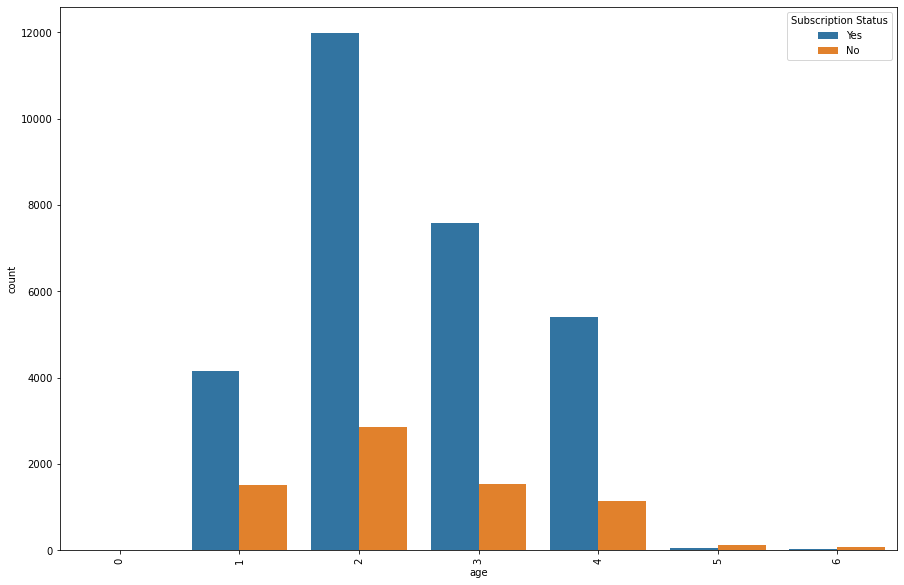

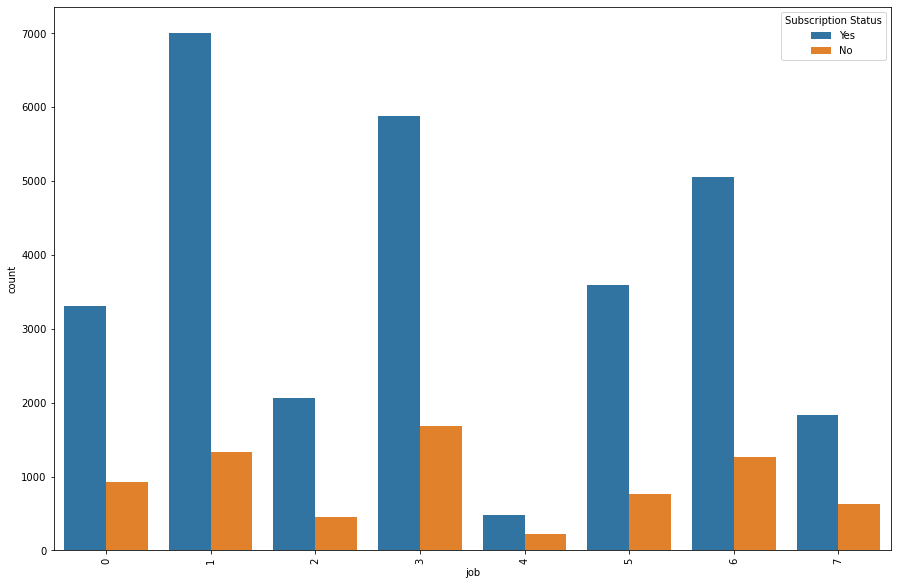

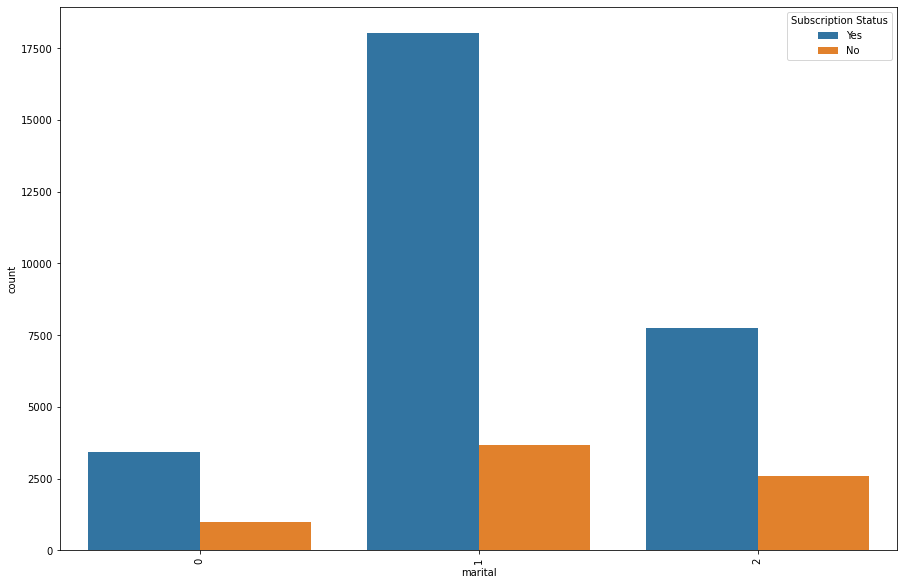

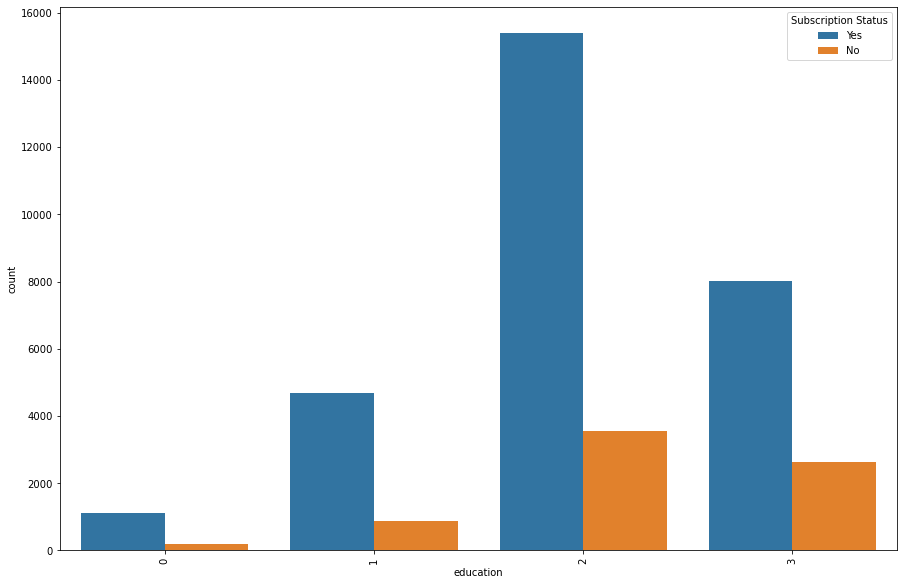

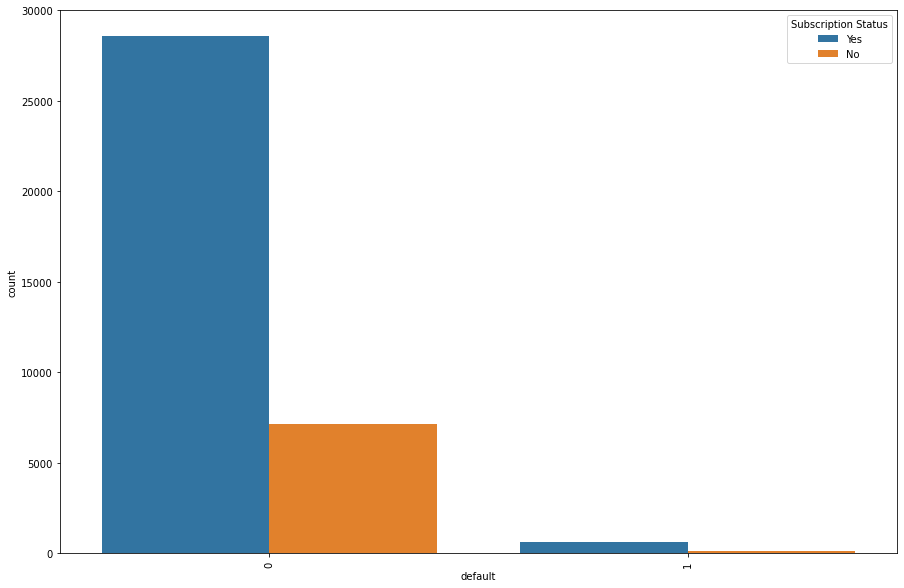

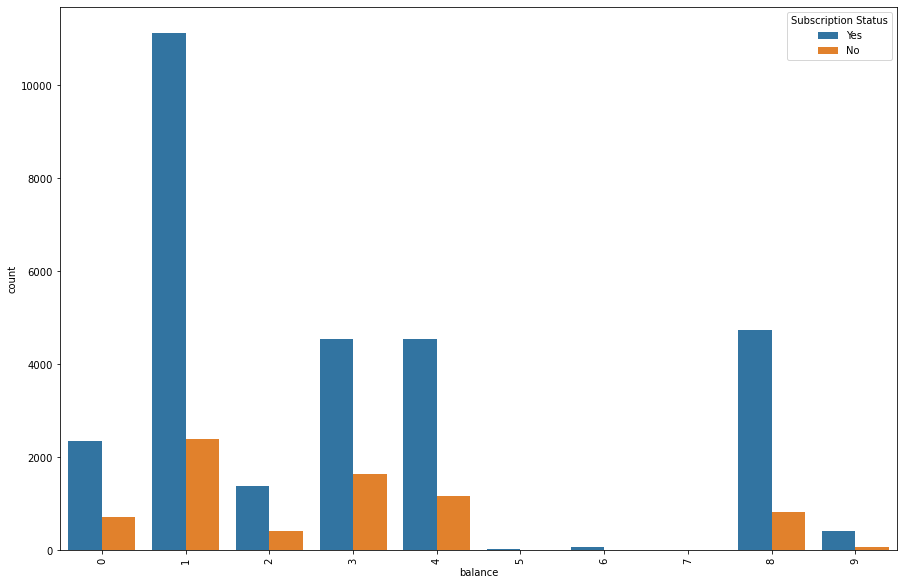

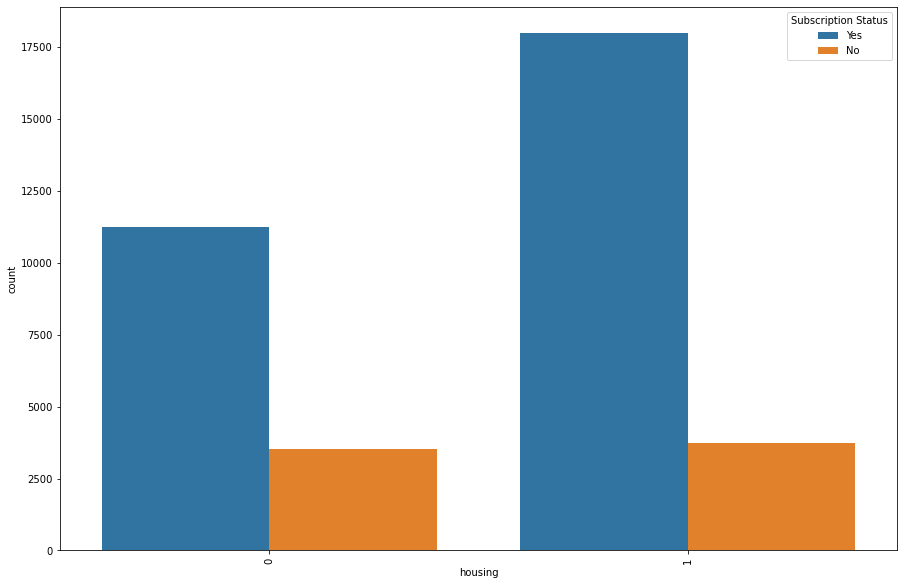

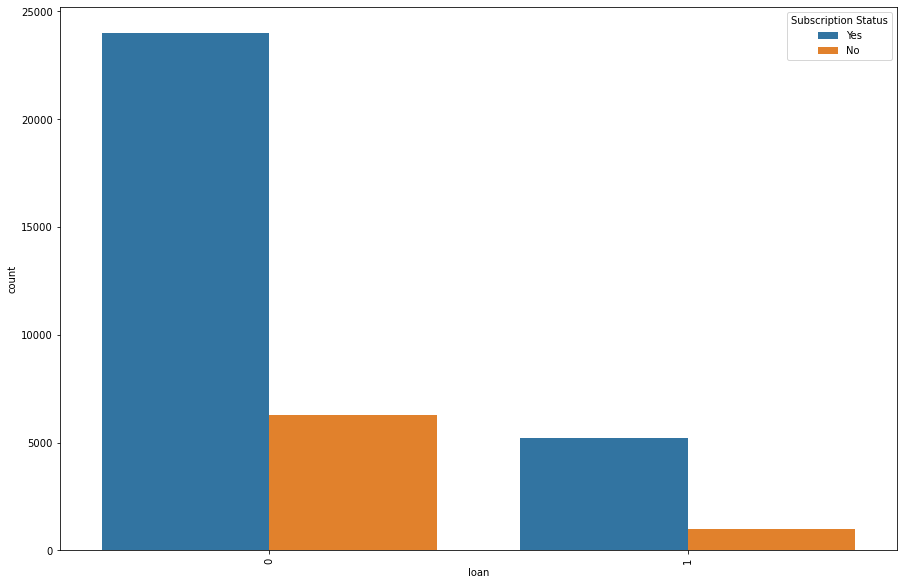

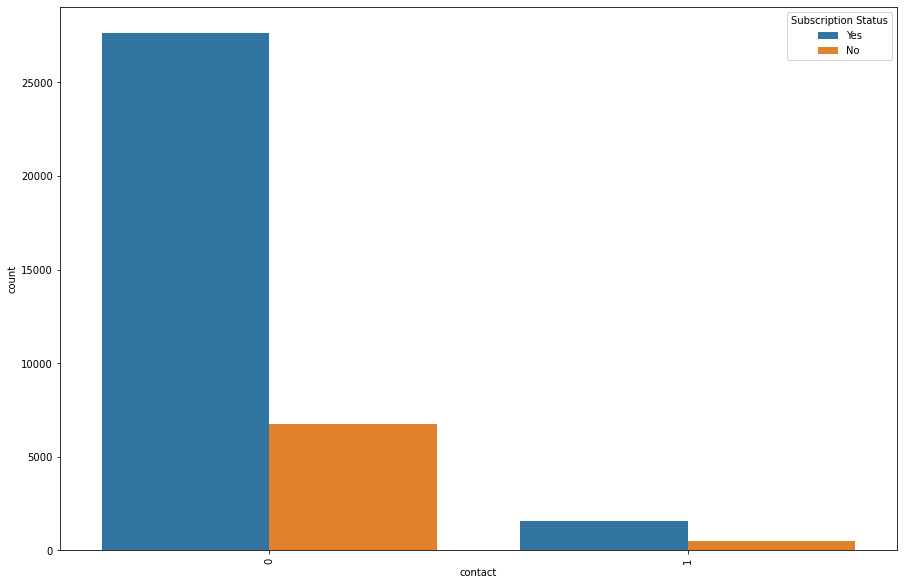

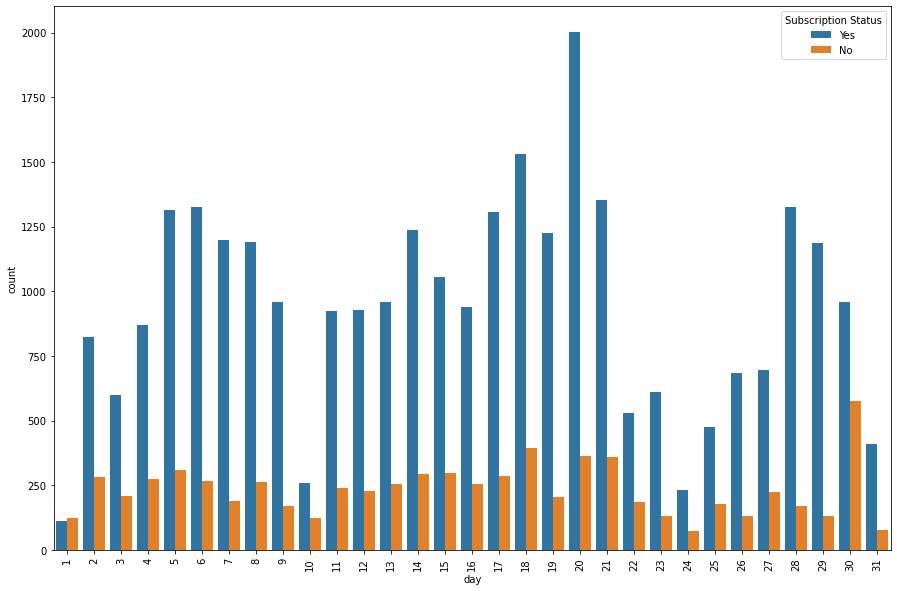

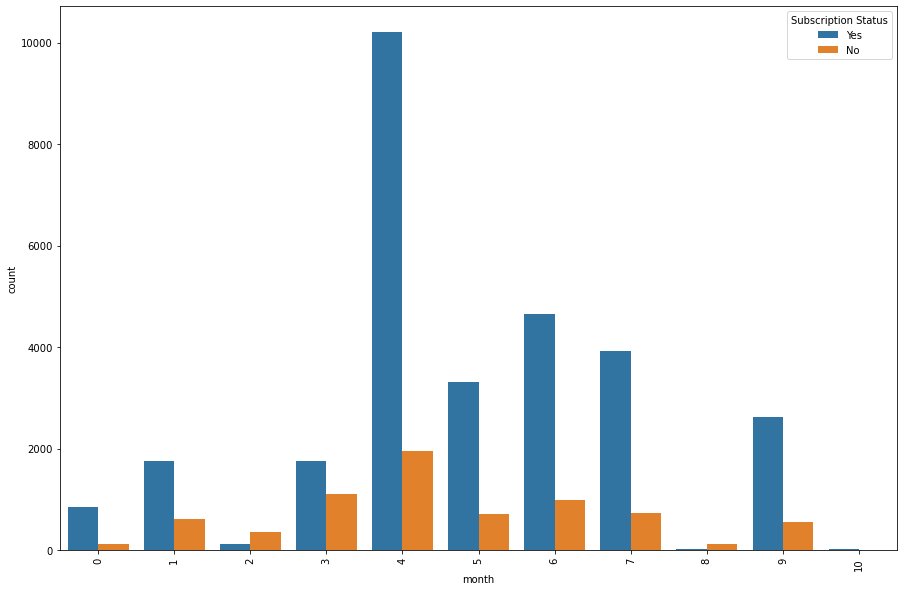

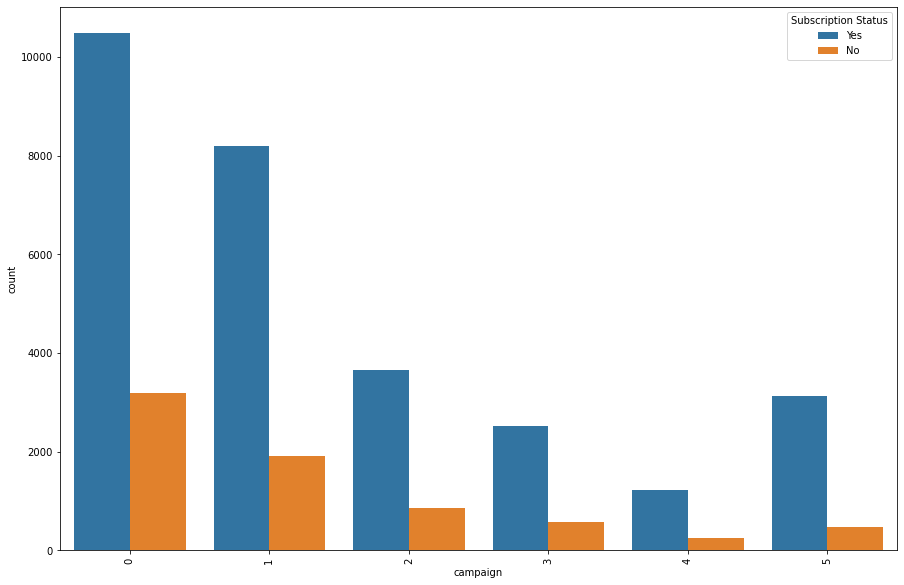

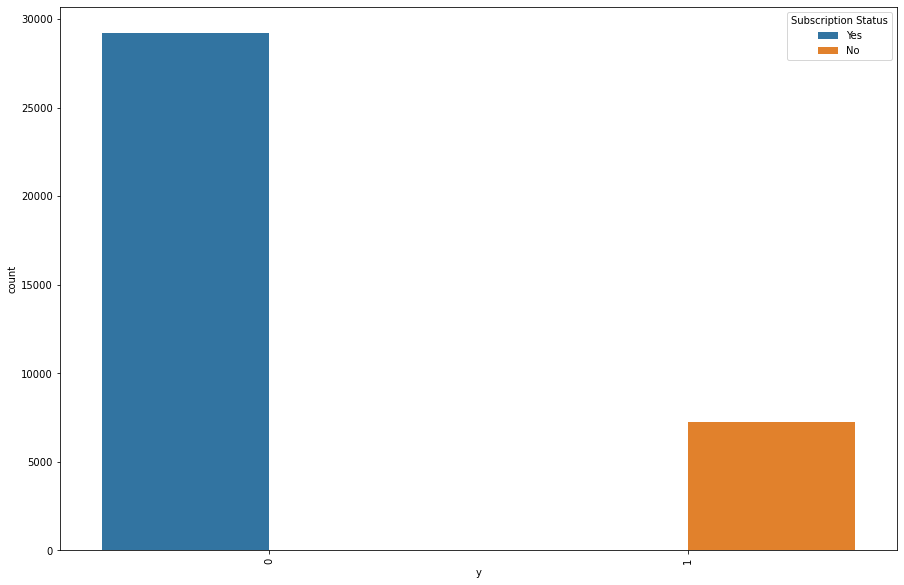

In [11]:
for i in train.columns:
    plt.figure(figsize=(15,10))
    ax = plt.subplot(1, 1, 1)
    arr = sns.countplot(data=train, x=train[i], hue='y')#, order=df_final[i].value_counts().index, hue='y')
    legend_labels, _= ax.get_legend_handles_labels()
    _ = arr.legend(legend_labels, ['Yes','No'], bbox_to_anchor=(1,1), title='Subscription Status')
    plt.xticks(rotation = 90)
    plt.show()

# MODELING

In [93]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, recall_score

In [38]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [39]:
X = pd.concat([train, test], axis=0).drop('y', axis=1)
y = pd.concat([train, test], axis=0).y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [68]:
def grid_search(model, parameters):
    # initialize function
    cv = GridSearchCV(estimator=model, param_grid=parameters)
    fit = cv.fit(X_train, y_train)
    return fit.best_params_

def evaluate_model(classifier):
    
    clf = classifier
    clf.fit(X_train,y_train)
    y_pr = clf.predict(X_test)
    
    # use 5-fold cross validation for average scores
    cv_score = cross_val_score(rf_clf, X=X, y=y, cv=5)
    score = clf.score(X_train, y_train)
    accuracy = accuracy_score(y_test, y_pr)
    
    print(f'5-CV Scores: {cv_score}\nAverage 5-CV score: {cv_score.mean()}')    
    print(f'Train score: {score}\nTest accuracy: {accuracy}\nDifference: {score - accuracy}')
    
    return clf, y_pr

def plot_confusion_matrix(test, pred, title):

    cm = confusion_matrix(test, pred)
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize=(10, 5))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='')
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f'{title} Confusion Matrix')

    return None

def plot_roc_auc(model):
    
    plt.figure(figsize=(15,10))
    # get the probabilities
    model_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, model_prob)
    plt.plot(fpr, tpr, color = 'green')
    plt.plot([0,1], [0, 1], color='blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.show()

In [73]:
def get_model_info(model, title):
    
    # evaluate model
    clf, y_pr = evaluate_model(model)
    # get classification report
    cr = classification_report(y_test, y_pr)
    print(f'\n{title.title()} Classification Report\n\n{cr}')
    # plot confusion matrix
    plot_confusion_matrix(y_test, y_pr, title.title())
    # plot roc auc curve
    plot_roc_auc(clf)

## RANDOM FOREST

In [41]:
# create a parameter grid
param_grid_rf = {'n_estimators':[100, 150, 200],
                'criterion':['gini', 'entropy']}

# determine best params
best_params = grid_search(RandomForestClassifier(), param_grid_rf)
best_params

{'criterion': 'entropy', 'n_estimators': 100}

5-CV Scores: [0.96941795 0.96843144 0.96755453 0.96799298 0.97007563]
Average 5-CV score: 0.9675326098870987
Train score: 0.991093938397457
Test accuracy: 0.9660199495779896
Difference: 0.02507398881946732
Random Forest Classification Report

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7268
           1       0.93      0.90      0.92      1855

    accuracy                           0.97      9123
   macro avg       0.95      0.94      0.95      9123
weighted avg       0.97      0.97      0.97      9123



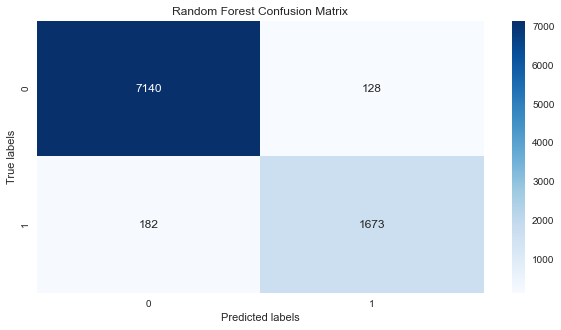

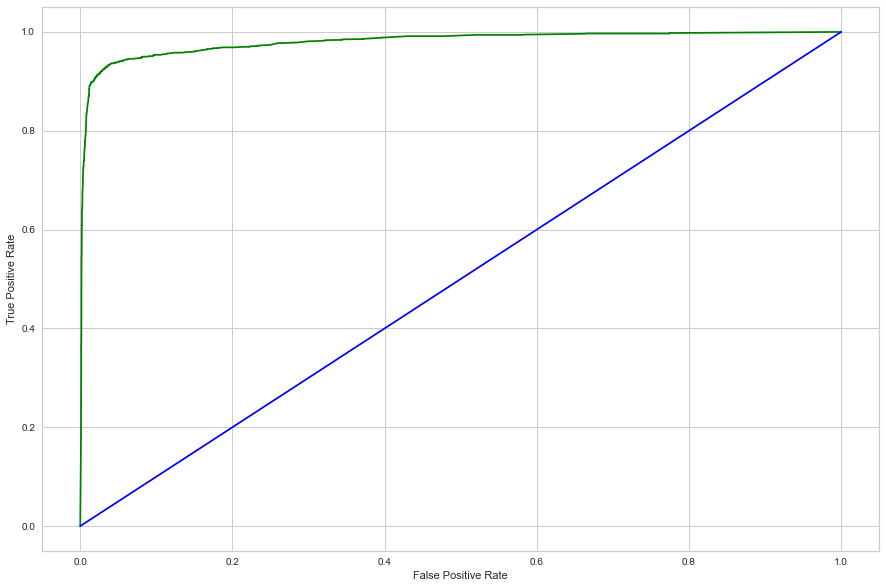

In [72]:
# initialize classifier with best params
rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
get_model_info(rf, 'Random Forest')

## EXTRA TREES

In [74]:
# create a parameter grid
param_grid_et = {'n_estimators':[100, 150, 200],
                'criterion':['gini', 'entropy']}

# determine best params
best_params = grid_search(ExtraTreesClassifier(), param_grid_et)
best_params

{'criterion': 'entropy', 'n_estimators': 100}

5-CV Scores: [0.9681026  0.96832182 0.96667763 0.96711608 0.96886989]
Average 5-CV score: 0.9675326098870987
Train score: 0.991093938397457
Test accuracy: 0.9664584018414996
Difference: 0.024635536555957405

Extra Trees Classification Report

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7268
           1       0.93      0.90      0.92      1855

    accuracy                           0.97      9123
   macro avg       0.95      0.94      0.95      9123
weighted avg       0.97      0.97      0.97      9123



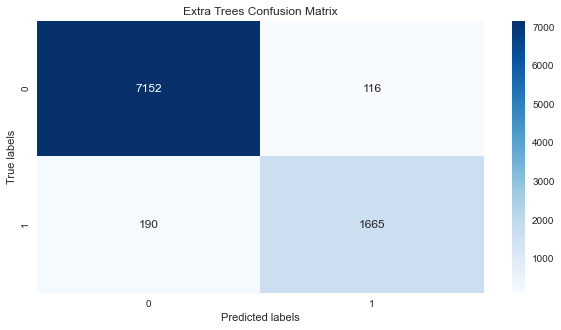

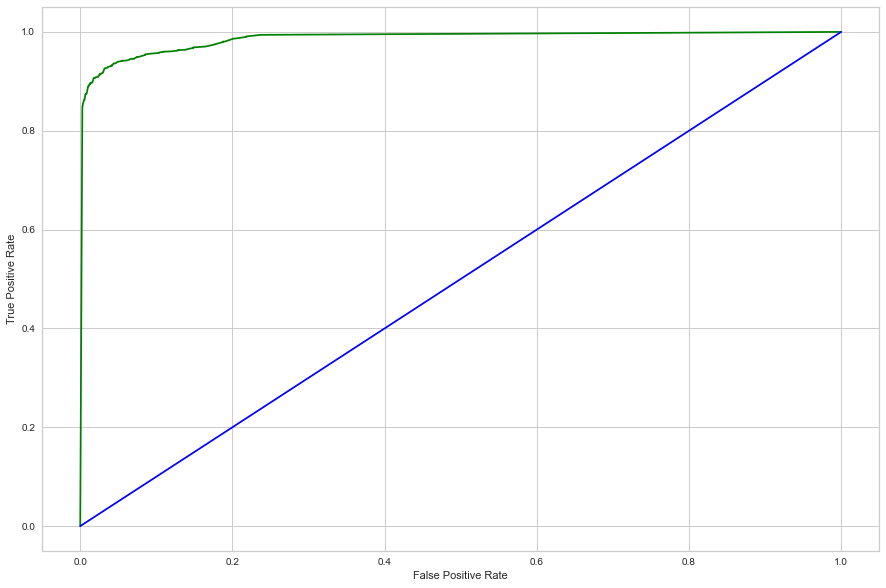

In [75]:
# initialize classifier with best params
et = ExtraTreesClassifier(n_estimators=100, criterion='entropy')
get_model_info(et, 'Extra Trees')

## DECISION TREES

In [76]:
# create a parameter grid
param_grid_dt = {'criterion':['gini', 'entropy'], 
                 'splitter':['best', 'random']}
# determine best params
best_params = grid_search(DecisionTreeClassifier(), param_grid_dt)
best_params

{'criterion': 'entropy', 'splitter': 'best'}

5-CV Scores: [0.96766415 0.96843144 0.96700647 0.96667763 0.96886989]
Average 5-CV score: 0.9675326098870987
Train score: 0.991093938397457
Test accuracy: 0.9489203113011071
Difference: 0.042173627096349864

Decision Tree Classification Report

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7268
           1       0.85      0.91      0.88      1855

    accuracy                           0.95      9123
   macro avg       0.91      0.94      0.92      9123
weighted avg       0.95      0.95      0.95      9123



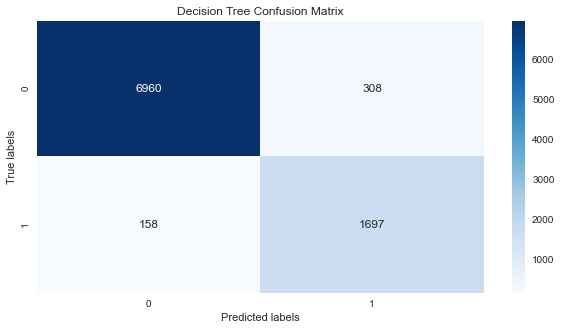

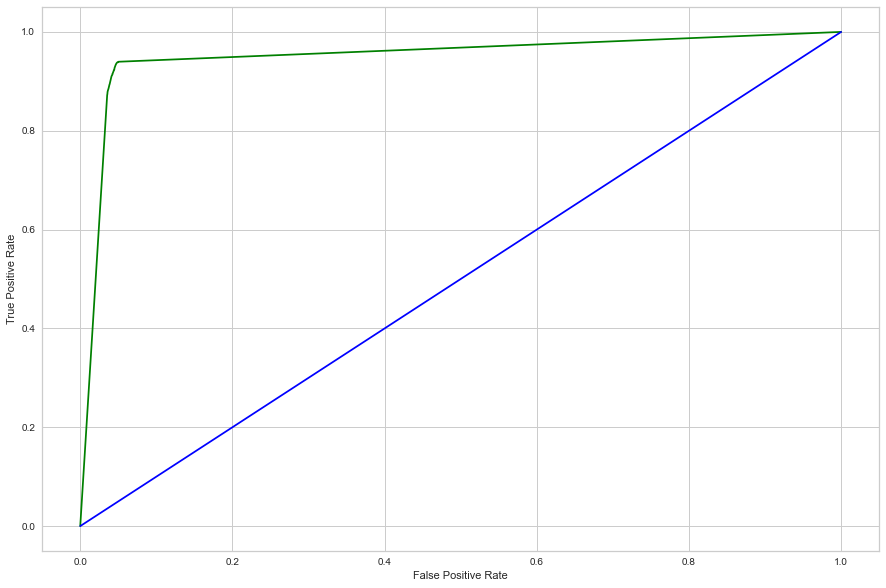

In [77]:
# initialize classifier with best params
dt = DecisionTreeClassifier(criterion='entropy', splitter='best')
get_model_info(dt, 'Decision Tree')

So far, based on the above models our __Random Forest__ is a better model overall. It has an overall higher precision, recall, and f1-score. 

However, because we are trying to determine the number of people that will subscribe, we want to make sure that we can find as many true positive samples as possible and lessen the number of false negatives. This makes the __Decision Tree__ model a better candidate as it has a 91% recall score even if the precision and F1-score are at 85% and 88% respectively.

## CATBOOST

In [79]:
# create a parameter grid
param_grid_cb = {'learning_rate':[0.1, 1.0], 
                 'n_estimators':[100, 500, 1000],
                 'boosting_type': ['Ordered', 'Plain']}
# determine best params
best_params = grid_search(CatBoostClassifier(), param_grid_cb)
best_params

0:	learn: 0.6550129	total: 200ms	remaining: 19.8s
1:	learn: 0.6257179	total: 210ms	remaining: 10.3s
2:	learn: 0.6015569	total: 221ms	remaining: 7.14s
3:	learn: 0.5787139	total: 232ms	remaining: 5.57s
4:	learn: 0.5606876	total: 242ms	remaining: 4.6s
5:	learn: 0.5459914	total: 251ms	remaining: 3.94s
6:	learn: 0.5326978	total: 261ms	remaining: 3.47s
7:	learn: 0.5224417	total: 271ms	remaining: 3.12s
8:	learn: 0.5121644	total: 281ms	remaining: 2.84s
9:	learn: 0.5047020	total: 290ms	remaining: 2.61s
10:	learn: 0.4991629	total: 297ms	remaining: 2.41s
11:	learn: 0.4944314	total: 305ms	remaining: 2.24s
12:	learn: 0.4903143	total: 314ms	remaining: 2.1s
13:	learn: 0.4854093	total: 323ms	remaining: 1.99s
14:	learn: 0.4822543	total: 333ms	remaining: 1.89s
15:	learn: 0.4776305	total: 344ms	remaining: 1.81s
16:	learn: 0.4755599	total: 353ms	remaining: 1.72s
17:	learn: 0.4725128	total: 362ms	remaining: 1.65s
18:	learn: 0.4691953	total: 371ms	remaining: 1.58s
19:	learn: 0.4669842	total: 381ms	remaining

64:	learn: 0.4336150	total: 605ms	remaining: 326ms
65:	learn: 0.4332079	total: 614ms	remaining: 316ms
66:	learn: 0.4325633	total: 624ms	remaining: 307ms
67:	learn: 0.4319688	total: 634ms	remaining: 299ms
68:	learn: 0.4317160	total: 644ms	remaining: 289ms
69:	learn: 0.4312609	total: 652ms	remaining: 279ms
70:	learn: 0.4307859	total: 661ms	remaining: 270ms
71:	learn: 0.4303620	total: 679ms	remaining: 264ms
72:	learn: 0.4299928	total: 688ms	remaining: 255ms
73:	learn: 0.4296544	total: 697ms	remaining: 245ms
74:	learn: 0.4294745	total: 706ms	remaining: 235ms
75:	learn: 0.4289678	total: 714ms	remaining: 226ms
76:	learn: 0.4285971	total: 724ms	remaining: 216ms
77:	learn: 0.4282145	total: 733ms	remaining: 207ms
78:	learn: 0.4279297	total: 742ms	remaining: 197ms
79:	learn: 0.4273827	total: 750ms	remaining: 188ms
80:	learn: 0.4269582	total: 759ms	remaining: 178ms
81:	learn: 0.4265409	total: 769ms	remaining: 169ms
82:	learn: 0.4263570	total: 778ms	remaining: 159ms
83:	learn: 0.4258292	total: 788

31:	learn: 0.4499920	total: 295ms	remaining: 627ms
32:	learn: 0.4491207	total: 305ms	remaining: 618ms
33:	learn: 0.4482896	total: 314ms	remaining: 609ms
34:	learn: 0.4473857	total: 323ms	remaining: 600ms
35:	learn: 0.4467564	total: 332ms	remaining: 590ms
36:	learn: 0.4460917	total: 341ms	remaining: 581ms
37:	learn: 0.4453175	total: 350ms	remaining: 572ms
38:	learn: 0.4448873	total: 359ms	remaining: 561ms
39:	learn: 0.4443884	total: 367ms	remaining: 551ms
40:	learn: 0.4440193	total: 377ms	remaining: 543ms
41:	learn: 0.4434150	total: 387ms	remaining: 534ms
42:	learn: 0.4428228	total: 395ms	remaining: 524ms
43:	learn: 0.4424949	total: 404ms	remaining: 514ms
44:	learn: 0.4420251	total: 412ms	remaining: 504ms
45:	learn: 0.4413319	total: 421ms	remaining: 494ms
46:	learn: 0.4407253	total: 430ms	remaining: 484ms
47:	learn: 0.4404887	total: 438ms	remaining: 474ms
48:	learn: 0.4397023	total: 447ms	remaining: 465ms
49:	learn: 0.4391573	total: 456ms	remaining: 456ms
50:	learn: 0.4387197	total: 465

94:	learn: 0.4208897	total: 918ms	remaining: 48.3ms
95:	learn: 0.4204848	total: 928ms	remaining: 38.7ms
96:	learn: 0.4203466	total: 937ms	remaining: 29ms
97:	learn: 0.4198107	total: 948ms	remaining: 19.3ms
98:	learn: 0.4193497	total: 958ms	remaining: 9.67ms
99:	learn: 0.4190451	total: 966ms	remaining: 0us
0:	learn: 0.6475064	total: 39.2ms	remaining: 19.5s
1:	learn: 0.6152219	total: 57.6ms	remaining: 14.3s
2:	learn: 0.5848370	total: 86.2ms	remaining: 14.3s
3:	learn: 0.5611353	total: 115ms	remaining: 14.3s
4:	learn: 0.5427180	total: 145ms	remaining: 14.4s
5:	learn: 0.5264323	total: 168ms	remaining: 13.8s
6:	learn: 0.5156231	total: 189ms	remaining: 13.3s
7:	learn: 0.5059916	total: 213ms	remaining: 13.1s
8:	learn: 0.4966099	total: 239ms	remaining: 13s
9:	learn: 0.4913160	total: 254ms	remaining: 12.5s
10:	learn: 0.4874641	total: 272ms	remaining: 12.1s
11:	learn: 0.4832546	total: 298ms	remaining: 12.1s
12:	learn: 0.4804454	total: 311ms	remaining: 11.7s
13:	learn: 0.4784351	total: 325ms	remai

157:	learn: 0.3895103	total: 4.05s	remaining: 8.77s
158:	learn: 0.3893485	total: 4.08s	remaining: 8.75s
159:	learn: 0.3891745	total: 4.11s	remaining: 8.73s
160:	learn: 0.3889038	total: 4.14s	remaining: 8.72s
161:	learn: 0.3887054	total: 4.17s	remaining: 8.7s
162:	learn: 0.3885418	total: 4.2s	remaining: 8.68s
163:	learn: 0.3882543	total: 4.23s	remaining: 8.66s
164:	learn: 0.3877730	total: 4.26s	remaining: 8.65s
165:	learn: 0.3876780	total: 4.29s	remaining: 8.63s
166:	learn: 0.3873259	total: 4.31s	remaining: 8.6s
167:	learn: 0.3870347	total: 4.34s	remaining: 8.58s
168:	learn: 0.3867467	total: 4.36s	remaining: 8.55s
169:	learn: 0.3867005	total: 4.39s	remaining: 8.52s
170:	learn: 0.3865431	total: 4.42s	remaining: 8.5s
171:	learn: 0.3861831	total: 4.44s	remaining: 8.47s
172:	learn: 0.3861080	total: 4.47s	remaining: 8.45s
173:	learn: 0.3856219	total: 4.49s	remaining: 8.42s
174:	learn: 0.3852291	total: 4.52s	remaining: 8.39s
175:	learn: 0.3847918	total: 4.54s	remaining: 8.36s
176:	learn: 0.38

318:	learn: 0.3560685	total: 8.22s	remaining: 4.67s
319:	learn: 0.3558741	total: 8.26s	remaining: 4.64s
320:	learn: 0.3556307	total: 8.29s	remaining: 4.62s
321:	learn: 0.3554507	total: 8.31s	remaining: 4.6s
322:	learn: 0.3552912	total: 8.34s	remaining: 4.57s
323:	learn: 0.3551220	total: 8.37s	remaining: 4.55s
324:	learn: 0.3549063	total: 8.4s	remaining: 4.52s
325:	learn: 0.3548975	total: 8.42s	remaining: 4.5s
326:	learn: 0.3548570	total: 8.45s	remaining: 4.47s
327:	learn: 0.3547667	total: 8.48s	remaining: 4.45s
328:	learn: 0.3546668	total: 8.51s	remaining: 4.42s
329:	learn: 0.3544651	total: 8.53s	remaining: 4.4s
330:	learn: 0.3541321	total: 8.56s	remaining: 4.37s
331:	learn: 0.3540069	total: 8.58s	remaining: 4.34s
332:	learn: 0.3538274	total: 8.61s	remaining: 4.32s
333:	learn: 0.3536578	total: 8.63s	remaining: 4.29s
334:	learn: 0.3533135	total: 8.65s	remaining: 4.26s
335:	learn: 0.3532032	total: 8.68s	remaining: 4.24s
336:	learn: 0.3530909	total: 8.7s	remaining: 4.21s
337:	learn: 0.352

484:	learn: 0.3350862	total: 12.2s	remaining: 378ms
485:	learn: 0.3350387	total: 12.2s	remaining: 352ms
486:	learn: 0.3347668	total: 12.3s	remaining: 327ms
487:	learn: 0.3346996	total: 12.3s	remaining: 302ms
488:	learn: 0.3345410	total: 12.3s	remaining: 277ms
489:	learn: 0.3343518	total: 12.3s	remaining: 252ms
490:	learn: 0.3342590	total: 12.4s	remaining: 227ms
491:	learn: 0.3340270	total: 12.4s	remaining: 202ms
492:	learn: 0.3337823	total: 12.4s	remaining: 176ms
493:	learn: 0.3335872	total: 12.4s	remaining: 151ms
494:	learn: 0.3335529	total: 12.5s	remaining: 126ms
495:	learn: 0.3335365	total: 12.5s	remaining: 101ms
496:	learn: 0.3333467	total: 12.5s	remaining: 75.6ms
497:	learn: 0.3331544	total: 12.5s	remaining: 50.4ms
498:	learn: 0.3331426	total: 12.6s	remaining: 25.2ms
499:	learn: 0.3330783	total: 12.6s	remaining: 0us
0:	learn: 0.6475954	total: 24.8ms	remaining: 12.4s
1:	learn: 0.6154082	total: 43.3ms	remaining: 10.8s
2:	learn: 0.5842414	total: 69.2ms	remaining: 11.5s
3:	learn: 0.56

146:	learn: 0.3937523	total: 3.57s	remaining: 8.57s
147:	learn: 0.3932084	total: 3.6s	remaining: 8.55s
148:	learn: 0.3930201	total: 3.62s	remaining: 8.52s
149:	learn: 0.3928223	total: 3.64s	remaining: 8.49s
150:	learn: 0.3924370	total: 3.66s	remaining: 8.47s
151:	learn: 0.3919128	total: 3.69s	remaining: 8.44s
152:	learn: 0.3916627	total: 3.72s	remaining: 8.43s
153:	learn: 0.3914908	total: 3.75s	remaining: 8.41s
154:	learn: 0.3912609	total: 3.77s	remaining: 8.39s
155:	learn: 0.3909119	total: 3.8s	remaining: 8.37s
156:	learn: 0.3906724	total: 3.82s	remaining: 8.34s
157:	learn: 0.3902793	total: 3.85s	remaining: 8.32s
158:	learn: 0.3897927	total: 3.87s	remaining: 8.3s
159:	learn: 0.3894209	total: 3.89s	remaining: 8.28s
160:	learn: 0.3890153	total: 3.92s	remaining: 8.26s
161:	learn: 0.3887267	total: 3.95s	remaining: 8.24s
162:	learn: 0.3883953	total: 3.97s	remaining: 8.22s
163:	learn: 0.3880523	total: 4s	remaining: 8.19s
164:	learn: 0.3878356	total: 4.02s	remaining: 8.16s
165:	learn: 0.3876

307:	learn: 0.3584372	total: 7.53s	remaining: 4.69s
308:	learn: 0.3582263	total: 7.56s	remaining: 4.67s
309:	learn: 0.3580591	total: 7.58s	remaining: 4.65s
310:	learn: 0.3577895	total: 7.61s	remaining: 4.62s
311:	learn: 0.3576627	total: 7.63s	remaining: 4.6s
312:	learn: 0.3574991	total: 7.66s	remaining: 4.58s
313:	learn: 0.3574501	total: 7.68s	remaining: 4.55s
314:	learn: 0.3573273	total: 7.71s	remaining: 4.53s
315:	learn: 0.3571288	total: 7.73s	remaining: 4.5s
316:	learn: 0.3569525	total: 7.76s	remaining: 4.48s
317:	learn: 0.3568564	total: 7.79s	remaining: 4.46s
318:	learn: 0.3566568	total: 7.81s	remaining: 4.43s
319:	learn: 0.3562352	total: 7.84s	remaining: 4.41s
320:	learn: 0.3562041	total: 7.86s	remaining: 4.38s
321:	learn: 0.3559917	total: 7.88s	remaining: 4.36s
322:	learn: 0.3557512	total: 7.91s	remaining: 4.33s
323:	learn: 0.3555801	total: 7.94s	remaining: 4.31s
324:	learn: 0.3553642	total: 7.96s	remaining: 4.29s
325:	learn: 0.3550732	total: 7.98s	remaining: 4.26s
326:	learn: 0.

473:	learn: 0.3370545	total: 11.5s	remaining: 634ms
474:	learn: 0.3368867	total: 11.6s	remaining: 609ms
475:	learn: 0.3368737	total: 11.6s	remaining: 585ms
476:	learn: 0.3368583	total: 11.6s	remaining: 560ms
477:	learn: 0.3368545	total: 11.6s	remaining: 536ms
478:	learn: 0.3366966	total: 11.7s	remaining: 512ms
479:	learn: 0.3364152	total: 11.7s	remaining: 487ms
480:	learn: 0.3363041	total: 11.7s	remaining: 463ms
481:	learn: 0.3362670	total: 11.7s	remaining: 439ms
482:	learn: 0.3361067	total: 11.8s	remaining: 414ms
483:	learn: 0.3360867	total: 11.8s	remaining: 390ms
484:	learn: 0.3358150	total: 11.8s	remaining: 366ms
485:	learn: 0.3356167	total: 11.8s	remaining: 341ms
486:	learn: 0.3355253	total: 11.9s	remaining: 317ms
487:	learn: 0.3355202	total: 11.9s	remaining: 292ms
488:	learn: 0.3355105	total: 11.9s	remaining: 268ms
489:	learn: 0.3354955	total: 11.9s	remaining: 244ms
490:	learn: 0.3353491	total: 12s	remaining: 219ms
491:	learn: 0.3350913	total: 12s	remaining: 195ms
492:	learn: 0.33

135:	learn: 0.3958459	total: 3.21s	remaining: 8.6s
136:	learn: 0.3955994	total: 3.24s	remaining: 8.58s
137:	learn: 0.3949705	total: 3.26s	remaining: 8.56s
138:	learn: 0.3944613	total: 3.29s	remaining: 8.54s
139:	learn: 0.3941328	total: 3.31s	remaining: 8.52s
140:	learn: 0.3938191	total: 3.33s	remaining: 8.49s
141:	learn: 0.3935449	total: 3.36s	remaining: 8.46s
142:	learn: 0.3930708	total: 3.38s	remaining: 8.43s
143:	learn: 0.3927427	total: 3.4s	remaining: 8.41s
144:	learn: 0.3924907	total: 3.43s	remaining: 8.39s
145:	learn: 0.3922997	total: 3.45s	remaining: 8.36s
146:	learn: 0.3921190	total: 3.47s	remaining: 8.33s
147:	learn: 0.3917727	total: 3.49s	remaining: 8.31s
148:	learn: 0.3914411	total: 3.52s	remaining: 8.29s
149:	learn: 0.3911834	total: 3.54s	remaining: 8.25s
150:	learn: 0.3909695	total: 3.56s	remaining: 8.22s
151:	learn: 0.3907504	total: 3.58s	remaining: 8.2s
152:	learn: 0.3903484	total: 3.61s	remaining: 8.18s
153:	learn: 0.3900840	total: 3.63s	remaining: 8.15s
154:	learn: 0.3

295:	learn: 0.3602478	total: 6.96s	remaining: 4.79s
296:	learn: 0.3597856	total: 6.98s	remaining: 4.77s
297:	learn: 0.3595915	total: 7.01s	remaining: 4.75s
298:	learn: 0.3593941	total: 7.03s	remaining: 4.72s
299:	learn: 0.3593479	total: 7.05s	remaining: 4.7s
300:	learn: 0.3592569	total: 7.07s	remaining: 4.68s
301:	learn: 0.3591075	total: 7.1s	remaining: 4.65s
302:	learn: 0.3589396	total: 7.12s	remaining: 4.63s
303:	learn: 0.3587587	total: 7.15s	remaining: 4.61s
304:	learn: 0.3587197	total: 7.17s	remaining: 4.58s
305:	learn: 0.3585285	total: 7.19s	remaining: 4.56s
306:	learn: 0.3583602	total: 7.21s	remaining: 4.53s
307:	learn: 0.3583414	total: 7.24s	remaining: 4.51s
308:	learn: 0.3582421	total: 7.26s	remaining: 4.49s
309:	learn: 0.3580761	total: 7.28s	remaining: 4.46s
310:	learn: 0.3579796	total: 7.3s	remaining: 4.44s
311:	learn: 0.3576962	total: 7.32s	remaining: 4.41s
312:	learn: 0.3572213	total: 7.35s	remaining: 4.39s
313:	learn: 0.3570584	total: 7.37s	remaining: 4.37s
314:	learn: 0.3

461:	learn: 0.3406285	total: 10.9s	remaining: 897ms
462:	learn: 0.3406281	total: 10.9s	remaining: 874ms
463:	learn: 0.3406231	total: 11s	remaining: 850ms
464:	learn: 0.3405184	total: 11s	remaining: 826ms
465:	learn: 0.3404611	total: 11s	remaining: 802ms
466:	learn: 0.3404328	total: 11s	remaining: 779ms
467:	learn: 0.3404039	total: 11s	remaining: 755ms
468:	learn: 0.3402247	total: 11.1s	remaining: 732ms
469:	learn: 0.3401865	total: 11.1s	remaining: 708ms
470:	learn: 0.3399900	total: 11.1s	remaining: 685ms
471:	learn: 0.3397744	total: 11.1s	remaining: 661ms
472:	learn: 0.3397008	total: 11.2s	remaining: 637ms
473:	learn: 0.3394933	total: 11.2s	remaining: 614ms
474:	learn: 0.3394383	total: 11.2s	remaining: 590ms
475:	learn: 0.3393940	total: 11.2s	remaining: 567ms
476:	learn: 0.3393697	total: 11.3s	remaining: 544ms
477:	learn: 0.3392118	total: 11.3s	remaining: 520ms
478:	learn: 0.3389566	total: 11.3s	remaining: 497ms
479:	learn: 0.3388073	total: 11.4s	remaining: 473ms
480:	learn: 0.3387798	

125:	learn: 0.3982604	total: 2.96s	remaining: 8.79s
126:	learn: 0.3979405	total: 2.99s	remaining: 8.77s
127:	learn: 0.3976860	total: 3.01s	remaining: 8.75s
128:	learn: 0.3970865	total: 3.04s	remaining: 8.73s
129:	learn: 0.3966872	total: 3.06s	remaining: 8.72s
130:	learn: 0.3961747	total: 3.09s	remaining: 8.71s
131:	learn: 0.3958959	total: 3.12s	remaining: 8.7s
132:	learn: 0.3955680	total: 3.15s	remaining: 8.68s
133:	learn: 0.3951687	total: 3.17s	remaining: 8.67s
134:	learn: 0.3947710	total: 3.2s	remaining: 8.66s
135:	learn: 0.3945489	total: 3.23s	remaining: 8.65s
136:	learn: 0.3942939	total: 3.26s	remaining: 8.64s
137:	learn: 0.3939957	total: 3.29s	remaining: 8.62s
138:	learn: 0.3937435	total: 3.32s	remaining: 8.62s
139:	learn: 0.3934319	total: 3.35s	remaining: 8.6s
140:	learn: 0.3929924	total: 3.38s	remaining: 8.6s
141:	learn: 0.3925738	total: 3.41s	remaining: 8.6s
142:	learn: 0.3922867	total: 3.45s	remaining: 8.61s
143:	learn: 0.3918734	total: 3.48s	remaining: 8.6s
144:	learn: 0.3916

286:	learn: 0.3606408	total: 6.92s	remaining: 5.14s
287:	learn: 0.3604763	total: 6.95s	remaining: 5.11s
288:	learn: 0.3603326	total: 6.97s	remaining: 5.09s
289:	learn: 0.3601396	total: 6.99s	remaining: 5.06s
290:	learn: 0.3600254	total: 7.02s	remaining: 5.04s
291:	learn: 0.3595178	total: 7.04s	remaining: 5.01s
292:	learn: 0.3594244	total: 7.06s	remaining: 4.99s
293:	learn: 0.3591617	total: 7.08s	remaining: 4.96s
294:	learn: 0.3588314	total: 7.11s	remaining: 4.94s
295:	learn: 0.3586972	total: 7.13s	remaining: 4.92s
296:	learn: 0.3585131	total: 7.16s	remaining: 4.89s
297:	learn: 0.3584737	total: 7.18s	remaining: 4.87s
298:	learn: 0.3582059	total: 7.21s	remaining: 4.84s
299:	learn: 0.3581088	total: 7.23s	remaining: 4.82s
300:	learn: 0.3579964	total: 7.25s	remaining: 4.79s
301:	learn: 0.3578525	total: 7.27s	remaining: 4.77s
302:	learn: 0.3577225	total: 7.3s	remaining: 4.74s
303:	learn: 0.3576492	total: 7.32s	remaining: 4.72s
304:	learn: 0.3574742	total: 7.34s	remaining: 4.7s
305:	learn: 0.

446:	learn: 0.3400727	total: 10.7s	remaining: 1.27s
447:	learn: 0.3400438	total: 10.7s	remaining: 1.24s
448:	learn: 0.3397303	total: 10.7s	remaining: 1.22s
449:	learn: 0.3397292	total: 10.8s	remaining: 1.2s
450:	learn: 0.3396053	total: 10.8s	remaining: 1.17s
451:	learn: 0.3395830	total: 10.8s	remaining: 1.15s
452:	learn: 0.3395039	total: 10.8s	remaining: 1.12s
453:	learn: 0.3394164	total: 10.9s	remaining: 1.1s
454:	learn: 0.3392988	total: 10.9s	remaining: 1.07s
455:	learn: 0.3392382	total: 10.9s	remaining: 1.05s
456:	learn: 0.3391081	total: 10.9s	remaining: 1.03s
457:	learn: 0.3388926	total: 11s	remaining: 1s
458:	learn: 0.3387862	total: 11s	remaining: 981ms
459:	learn: 0.3387396	total: 11s	remaining: 957ms
460:	learn: 0.3385494	total: 11s	remaining: 932ms
461:	learn: 0.3383770	total: 11s	remaining: 908ms
462:	learn: 0.3383331	total: 11.1s	remaining: 884ms
463:	learn: 0.3382249	total: 11.1s	remaining: 860ms
464:	learn: 0.3381644	total: 11.1s	remaining: 837ms
465:	learn: 0.3378745	total

107:	learn: 0.4060096	total: 2.53s	remaining: 9.19s
108:	learn: 0.4056305	total: 2.56s	remaining: 9.17s
109:	learn: 0.4053362	total: 2.58s	remaining: 9.15s
110:	learn: 0.4050334	total: 2.6s	remaining: 9.13s
111:	learn: 0.4045799	total: 2.63s	remaining: 9.1s
112:	learn: 0.4040280	total: 2.65s	remaining: 9.08s
113:	learn: 0.4036686	total: 2.67s	remaining: 9.05s
114:	learn: 0.4031870	total: 2.7s	remaining: 9.04s
115:	learn: 0.4031846	total: 2.71s	remaining: 8.98s
116:	learn: 0.4027973	total: 2.74s	remaining: 8.97s
117:	learn: 0.4023396	total: 2.76s	remaining: 8.95s
118:	learn: 0.4020458	total: 2.79s	remaining: 8.92s
119:	learn: 0.4015430	total: 2.81s	remaining: 8.9s
120:	learn: 0.4011019	total: 2.83s	remaining: 8.87s
121:	learn: 0.4006807	total: 2.85s	remaining: 8.84s
122:	learn: 0.4003164	total: 2.88s	remaining: 8.82s
123:	learn: 0.3999155	total: 2.9s	remaining: 8.79s
124:	learn: 0.3996415	total: 2.92s	remaining: 8.77s
125:	learn: 0.3992783	total: 2.94s	remaining: 8.73s
126:	learn: 0.398

270:	learn: 0.3646295	total: 6.3s	remaining: 5.33s
271:	learn: 0.3646077	total: 6.33s	remaining: 5.3s
272:	learn: 0.3644254	total: 6.35s	remaining: 5.28s
273:	learn: 0.3642418	total: 6.37s	remaining: 5.26s
274:	learn: 0.3641897	total: 6.4s	remaining: 5.23s
275:	learn: 0.3641070	total: 6.42s	remaining: 5.21s
276:	learn: 0.3639282	total: 6.45s	remaining: 5.19s
277:	learn: 0.3637599	total: 6.47s	remaining: 5.17s
278:	learn: 0.3635705	total: 6.5s	remaining: 5.15s
279:	learn: 0.3634092	total: 6.52s	remaining: 5.12s
280:	learn: 0.3632459	total: 6.54s	remaining: 5.1s
281:	learn: 0.3629086	total: 6.57s	remaining: 5.08s
282:	learn: 0.3627727	total: 6.59s	remaining: 5.05s
283:	learn: 0.3626711	total: 6.62s	remaining: 5.03s
284:	learn: 0.3625856	total: 6.64s	remaining: 5.01s
285:	learn: 0.3624878	total: 6.66s	remaining: 4.99s
286:	learn: 0.3622144	total: 6.69s	remaining: 4.96s
287:	learn: 0.3621051	total: 6.71s	remaining: 4.94s
288:	learn: 0.3619672	total: 6.73s	remaining: 4.92s
289:	learn: 0.361

430:	learn: 0.3454741	total: 10.1s	remaining: 1.61s
431:	learn: 0.3454509	total: 10.1s	remaining: 1.59s
432:	learn: 0.3454180	total: 10.1s	remaining: 1.57s
433:	learn: 0.3452730	total: 10.1s	remaining: 1.54s
434:	learn: 0.3452099	total: 10.2s	remaining: 1.52s
435:	learn: 0.3451605	total: 10.2s	remaining: 1.5s
436:	learn: 0.3451151	total: 10.2s	remaining: 1.47s
437:	learn: 0.3450459	total: 10.2s	remaining: 1.45s
438:	learn: 0.3449343	total: 10.3s	remaining: 1.42s
439:	learn: 0.3449336	total: 10.3s	remaining: 1.4s
440:	learn: 0.3448450	total: 10.3s	remaining: 1.38s
441:	learn: 0.3447765	total: 10.3s	remaining: 1.35s
442:	learn: 0.3446961	total: 10.3s	remaining: 1.33s
443:	learn: 0.3446247	total: 10.4s	remaining: 1.31s
444:	learn: 0.3445696	total: 10.4s	remaining: 1.28s
445:	learn: 0.3445592	total: 10.4s	remaining: 1.26s
446:	learn: 0.3444809	total: 10.4s	remaining: 1.24s
447:	learn: 0.3444488	total: 10.5s	remaining: 1.21s
448:	learn: 0.3443619	total: 10.5s	remaining: 1.19s
449:	learn: 0.

94:	learn: 0.4143837	total: 2.17s	remaining: 20.7s
95:	learn: 0.4137832	total: 2.2s	remaining: 20.7s
96:	learn: 0.4134289	total: 2.22s	remaining: 20.7s
97:	learn: 0.4129841	total: 2.25s	remaining: 20.7s
98:	learn: 0.4125583	total: 2.27s	remaining: 20.7s
99:	learn: 0.4121741	total: 2.3s	remaining: 20.7s
100:	learn: 0.4118163	total: 2.32s	remaining: 20.7s
101:	learn: 0.4114260	total: 2.34s	remaining: 20.6s
102:	learn: 0.4109690	total: 2.37s	remaining: 20.6s
103:	learn: 0.4105086	total: 2.39s	remaining: 20.6s
104:	learn: 0.4102635	total: 2.42s	remaining: 20.6s
105:	learn: 0.4098359	total: 2.44s	remaining: 20.6s
106:	learn: 0.4093673	total: 2.46s	remaining: 20.6s
107:	learn: 0.4090165	total: 2.49s	remaining: 20.5s
108:	learn: 0.4086664	total: 2.51s	remaining: 20.5s
109:	learn: 0.4083732	total: 2.54s	remaining: 20.5s
110:	learn: 0.4079479	total: 2.56s	remaining: 20.5s
111:	learn: 0.4074549	total: 2.59s	remaining: 20.5s
112:	learn: 0.4071293	total: 2.61s	remaining: 20.5s
113:	learn: 0.406860

256:	learn: 0.3655411	total: 6.2s	remaining: 17.9s
257:	learn: 0.3652959	total: 6.23s	remaining: 17.9s
258:	learn: 0.3652779	total: 6.26s	remaining: 17.9s
259:	learn: 0.3651389	total: 6.28s	remaining: 17.9s
260:	learn: 0.3650459	total: 6.31s	remaining: 17.9s
261:	learn: 0.3650070	total: 6.33s	remaining: 17.8s
262:	learn: 0.3649897	total: 6.35s	remaining: 17.8s
263:	learn: 0.3647108	total: 6.38s	remaining: 17.8s
264:	learn: 0.3647008	total: 6.4s	remaining: 17.8s
265:	learn: 0.3644901	total: 6.42s	remaining: 17.7s
266:	learn: 0.3643476	total: 6.45s	remaining: 17.7s
267:	learn: 0.3642561	total: 6.47s	remaining: 17.7s
268:	learn: 0.3639900	total: 6.49s	remaining: 17.6s
269:	learn: 0.3638767	total: 6.51s	remaining: 17.6s
270:	learn: 0.3636447	total: 6.54s	remaining: 17.6s
271:	learn: 0.3634020	total: 6.56s	remaining: 17.6s
272:	learn: 0.3632554	total: 6.58s	remaining: 17.5s
273:	learn: 0.3631636	total: 6.61s	remaining: 17.5s
274:	learn: 0.3630565	total: 6.63s	remaining: 17.5s
275:	learn: 0.

416:	learn: 0.3430236	total: 9.97s	remaining: 13.9s
417:	learn: 0.3428581	total: 9.99s	remaining: 13.9s
418:	learn: 0.3428053	total: 10s	remaining: 13.9s
419:	learn: 0.3426579	total: 10s	remaining: 13.9s
420:	learn: 0.3426369	total: 10.1s	remaining: 13.8s
421:	learn: 0.3425641	total: 10.1s	remaining: 13.8s
422:	learn: 0.3423713	total: 10.1s	remaining: 13.8s
423:	learn: 0.3423111	total: 10.1s	remaining: 13.8s
424:	learn: 0.3421340	total: 10.2s	remaining: 13.7s
425:	learn: 0.3419776	total: 10.2s	remaining: 13.7s
426:	learn: 0.3418439	total: 10.2s	remaining: 13.7s
427:	learn: 0.3417642	total: 10.2s	remaining: 13.7s
428:	learn: 0.3415675	total: 10.2s	remaining: 13.6s
429:	learn: 0.3415451	total: 10.3s	remaining: 13.6s
430:	learn: 0.3414162	total: 10.3s	remaining: 13.6s
431:	learn: 0.3411769	total: 10.3s	remaining: 13.6s
432:	learn: 0.3410480	total: 10.3s	remaining: 13.5s
433:	learn: 0.3410449	total: 10.4s	remaining: 13.5s
434:	learn: 0.3409436	total: 10.4s	remaining: 13.5s
435:	learn: 0.34

582:	learn: 0.3271056	total: 13.9s	remaining: 9.97s
583:	learn: 0.3269212	total: 14s	remaining: 9.95s
584:	learn: 0.3267734	total: 14s	remaining: 9.93s
585:	learn: 0.3266619	total: 14s	remaining: 9.9s
586:	learn: 0.3264895	total: 14s	remaining: 9.88s
587:	learn: 0.3264243	total: 14.1s	remaining: 9.85s
588:	learn: 0.3264148	total: 14.1s	remaining: 9.83s
589:	learn: 0.3264122	total: 14.1s	remaining: 9.8s
590:	learn: 0.3263682	total: 14.1s	remaining: 9.78s
591:	learn: 0.3262543	total: 14.2s	remaining: 9.75s
592:	learn: 0.3261537	total: 14.2s	remaining: 9.73s
593:	learn: 0.3260185	total: 14.2s	remaining: 9.7s
594:	learn: 0.3259682	total: 14.2s	remaining: 9.68s
595:	learn: 0.3257559	total: 14.2s	remaining: 9.65s
596:	learn: 0.3256760	total: 14.3s	remaining: 9.63s
597:	learn: 0.3255978	total: 14.3s	remaining: 9.61s
598:	learn: 0.3255082	total: 14.3s	remaining: 9.58s
599:	learn: 0.3254715	total: 14.3s	remaining: 9.55s
600:	learn: 0.3252436	total: 14.4s	remaining: 9.53s
601:	learn: 0.3250465	t

747:	learn: 0.3175377	total: 17.7s	remaining: 5.98s
748:	learn: 0.3175374	total: 17.8s	remaining: 5.95s
749:	learn: 0.3174522	total: 17.8s	remaining: 5.93s
750:	learn: 0.3174217	total: 17.8s	remaining: 5.9s
751:	learn: 0.3174215	total: 17.8s	remaining: 5.88s
752:	learn: 0.3174212	total: 17.8s	remaining: 5.85s
753:	learn: 0.3174210	total: 17.9s	remaining: 5.83s
754:	learn: 0.3174210	total: 17.9s	remaining: 5.8s
755:	learn: 0.3174209	total: 17.9s	remaining: 5.78s
756:	learn: 0.3173021	total: 17.9s	remaining: 5.75s
757:	learn: 0.3172149	total: 17.9s	remaining: 5.73s
758:	learn: 0.3172149	total: 18s	remaining: 5.7s
759:	learn: 0.3171513	total: 18s	remaining: 5.68s
760:	learn: 0.3171333	total: 18s	remaining: 5.66s
761:	learn: 0.3171270	total: 18s	remaining: 5.63s
762:	learn: 0.3171246	total: 18.1s	remaining: 5.61s
763:	learn: 0.3170730	total: 18.1s	remaining: 5.58s
764:	learn: 0.3170008	total: 18.1s	remaining: 5.56s
765:	learn: 0.3169335	total: 18.1s	remaining: 5.54s
766:	learn: 0.3169333	t

910:	learn: 0.3123334	total: 21.4s	remaining: 2.09s
911:	learn: 0.3123000	total: 21.4s	remaining: 2.06s
912:	learn: 0.3122525	total: 21.4s	remaining: 2.04s
913:	learn: 0.3121824	total: 21.4s	remaining: 2.02s
914:	learn: 0.3120559	total: 21.5s	remaining: 1.99s
915:	learn: 0.3119479	total: 21.5s	remaining: 1.97s
916:	learn: 0.3118982	total: 21.5s	remaining: 1.95s
917:	learn: 0.3118269	total: 21.5s	remaining: 1.92s
918:	learn: 0.3118093	total: 21.5s	remaining: 1.9s
919:	learn: 0.3116839	total: 21.6s	remaining: 1.88s
920:	learn: 0.3116785	total: 21.6s	remaining: 1.85s
921:	learn: 0.3116596	total: 21.6s	remaining: 1.83s
922:	learn: 0.3115963	total: 21.6s	remaining: 1.8s
923:	learn: 0.3115805	total: 21.6s	remaining: 1.78s
924:	learn: 0.3115714	total: 21.7s	remaining: 1.76s
925:	learn: 0.3115661	total: 21.7s	remaining: 1.73s
926:	learn: 0.3115631	total: 21.7s	remaining: 1.71s
927:	learn: 0.3115232	total: 21.7s	remaining: 1.69s
928:	learn: 0.3115227	total: 21.8s	remaining: 1.66s
929:	learn: 0.

74:	learn: 0.4211881	total: 1.74s	remaining: 21.5s
75:	learn: 0.4207463	total: 1.77s	remaining: 21.5s
76:	learn: 0.4202438	total: 1.79s	remaining: 21.5s
77:	learn: 0.4194483	total: 1.82s	remaining: 21.5s
78:	learn: 0.4190287	total: 1.85s	remaining: 21.6s
79:	learn: 0.4185700	total: 1.87s	remaining: 21.5s
80:	learn: 0.4185480	total: 1.89s	remaining: 21.5s
81:	learn: 0.4183398	total: 1.91s	remaining: 21.4s
82:	learn: 0.4178933	total: 1.94s	remaining: 21.4s
83:	learn: 0.4173760	total: 1.96s	remaining: 21.4s
84:	learn: 0.4170590	total: 1.99s	remaining: 21.4s
85:	learn: 0.4165976	total: 2.01s	remaining: 21.4s
86:	learn: 0.4162539	total: 2.03s	remaining: 21.3s
87:	learn: 0.4162248	total: 2.05s	remaining: 21.3s
88:	learn: 0.4156202	total: 2.07s	remaining: 21.2s
89:	learn: 0.4154414	total: 2.1s	remaining: 21.2s
90:	learn: 0.4152047	total: 2.12s	remaining: 21.2s
91:	learn: 0.4149163	total: 2.14s	remaining: 21.2s
92:	learn: 0.4147569	total: 2.17s	remaining: 21.1s
93:	learn: 0.4143652	total: 2.19

240:	learn: 0.3709687	total: 5.69s	remaining: 17.9s
241:	learn: 0.3708810	total: 5.72s	remaining: 17.9s
242:	learn: 0.3705438	total: 5.74s	remaining: 17.9s
243:	learn: 0.3702236	total: 5.76s	remaining: 17.9s
244:	learn: 0.3699320	total: 5.79s	remaining: 17.8s
245:	learn: 0.3697728	total: 5.81s	remaining: 17.8s
246:	learn: 0.3694456	total: 5.83s	remaining: 17.8s
247:	learn: 0.3692995	total: 5.85s	remaining: 17.7s
248:	learn: 0.3692478	total: 5.87s	remaining: 17.7s
249:	learn: 0.3691386	total: 5.9s	remaining: 17.7s
250:	learn: 0.3690299	total: 5.92s	remaining: 17.7s
251:	learn: 0.3690230	total: 5.94s	remaining: 17.6s
252:	learn: 0.3688245	total: 5.96s	remaining: 17.6s
253:	learn: 0.3687085	total: 5.99s	remaining: 17.6s
254:	learn: 0.3685965	total: 6.01s	remaining: 17.6s
255:	learn: 0.3685503	total: 6.03s	remaining: 17.5s
256:	learn: 0.3683945	total: 6.05s	remaining: 17.5s
257:	learn: 0.3680723	total: 6.08s	remaining: 17.5s
258:	learn: 0.3677630	total: 6.1s	remaining: 17.5s
259:	learn: 0.

406:	learn: 0.3430213	total: 9.66s	remaining: 14.1s
407:	learn: 0.3429100	total: 9.68s	remaining: 14s
408:	learn: 0.3428826	total: 9.7s	remaining: 14s
409:	learn: 0.3427879	total: 9.73s	remaining: 14s
410:	learn: 0.3425577	total: 9.75s	remaining: 14s
411:	learn: 0.3424686	total: 9.78s	remaining: 14s
412:	learn: 0.3423086	total: 9.8s	remaining: 13.9s
413:	learn: 0.3422751	total: 9.82s	remaining: 13.9s
414:	learn: 0.3419077	total: 9.85s	remaining: 13.9s
415:	learn: 0.3418210	total: 9.88s	remaining: 13.9s
416:	learn: 0.3418105	total: 9.9s	remaining: 13.8s
417:	learn: 0.3417988	total: 9.92s	remaining: 13.8s
418:	learn: 0.3417949	total: 9.94s	remaining: 13.8s
419:	learn: 0.3417144	total: 9.96s	remaining: 13.8s
420:	learn: 0.3416828	total: 9.99s	remaining: 13.7s
421:	learn: 0.3416397	total: 10s	remaining: 13.7s
422:	learn: 0.3416012	total: 10s	remaining: 13.7s
423:	learn: 0.3415044	total: 10.1s	remaining: 13.7s
424:	learn: 0.3414105	total: 10.1s	remaining: 13.6s
425:	learn: 0.3413893	total: 

568:	learn: 0.3302202	total: 13.4s	remaining: 10.2s
569:	learn: 0.3302192	total: 13.5s	remaining: 10.2s
570:	learn: 0.3302181	total: 13.5s	remaining: 10.1s
571:	learn: 0.3302176	total: 13.5s	remaining: 10.1s
572:	learn: 0.3302022	total: 13.5s	remaining: 10.1s
573:	learn: 0.3302019	total: 13.6s	remaining: 10.1s
574:	learn: 0.3301988	total: 13.6s	remaining: 10s
575:	learn: 0.3301988	total: 13.6s	remaining: 10s
576:	learn: 0.3301984	total: 13.6s	remaining: 9.99s
577:	learn: 0.3301972	total: 13.6s	remaining: 9.96s
578:	learn: 0.3301970	total: 13.7s	remaining: 9.94s
579:	learn: 0.3301055	total: 13.7s	remaining: 9.91s
580:	learn: 0.3300776	total: 13.7s	remaining: 9.89s
581:	learn: 0.3300382	total: 13.7s	remaining: 9.87s
582:	learn: 0.3300378	total: 13.8s	remaining: 9.84s
583:	learn: 0.3300375	total: 13.8s	remaining: 9.81s
584:	learn: 0.3300106	total: 13.8s	remaining: 9.79s
585:	learn: 0.3299742	total: 13.8s	remaining: 9.77s
586:	learn: 0.3299350	total: 13.8s	remaining: 9.74s
587:	learn: 0.32

729:	learn: 0.3233496	total: 16.9s	remaining: 6.27s
730:	learn: 0.3233222	total: 17s	remaining: 6.25s
731:	learn: 0.3232346	total: 17s	remaining: 6.22s
732:	learn: 0.3231986	total: 17s	remaining: 6.2s
733:	learn: 0.3231970	total: 17s	remaining: 6.18s
734:	learn: 0.3231763	total: 17.1s	remaining: 6.15s
735:	learn: 0.3231747	total: 17.1s	remaining: 6.13s
736:	learn: 0.3231490	total: 17.1s	remaining: 6.11s
737:	learn: 0.3229353	total: 17.1s	remaining: 6.08s
738:	learn: 0.3229125	total: 17.2s	remaining: 6.06s
739:	learn: 0.3226965	total: 17.2s	remaining: 6.04s
740:	learn: 0.3226494	total: 17.2s	remaining: 6.01s
741:	learn: 0.3226197	total: 17.2s	remaining: 5.99s
742:	learn: 0.3224794	total: 17.3s	remaining: 5.97s
743:	learn: 0.3223770	total: 17.3s	remaining: 5.95s
744:	learn: 0.3221574	total: 17.3s	remaining: 5.92s
745:	learn: 0.3221206	total: 17.3s	remaining: 5.9s
746:	learn: 0.3220560	total: 17.3s	remaining: 5.88s
747:	learn: 0.3220368	total: 17.4s	remaining: 5.85s
748:	learn: 0.3219637	

894:	learn: 0.3178199	total: 20.5s	remaining: 2.41s
895:	learn: 0.3178172	total: 20.6s	remaining: 2.39s
896:	learn: 0.3178170	total: 20.6s	remaining: 2.36s
897:	learn: 0.3178148	total: 20.6s	remaining: 2.34s
898:	learn: 0.3178034	total: 20.6s	remaining: 2.32s
899:	learn: 0.3178030	total: 20.7s	remaining: 2.29s
900:	learn: 0.3177365	total: 20.7s	remaining: 2.27s
901:	learn: 0.3177354	total: 20.7s	remaining: 2.25s
902:	learn: 0.3177032	total: 20.7s	remaining: 2.23s
903:	learn: 0.3177022	total: 20.7s	remaining: 2.2s
904:	learn: 0.3177016	total: 20.8s	remaining: 2.18s
905:	learn: 0.3176422	total: 20.8s	remaining: 2.15s
906:	learn: 0.3176383	total: 20.8s	remaining: 2.13s
907:	learn: 0.3176312	total: 20.8s	remaining: 2.11s
908:	learn: 0.3175357	total: 20.8s	remaining: 2.09s
909:	learn: 0.3175348	total: 20.9s	remaining: 2.06s
910:	learn: 0.3175217	total: 20.9s	remaining: 2.04s
911:	learn: 0.3175199	total: 20.9s	remaining: 2.02s
912:	learn: 0.3175189	total: 20.9s	remaining: 1.99s
913:	learn: 0

59:	learn: 0.4267906	total: 1.38s	remaining: 21.7s
60:	learn: 0.4260739	total: 1.41s	remaining: 21.7s
61:	learn: 0.4256880	total: 1.43s	remaining: 21.6s
62:	learn: 0.4251036	total: 1.45s	remaining: 21.6s
63:	learn: 0.4245155	total: 1.48s	remaining: 21.6s
64:	learn: 0.4238648	total: 1.5s	remaining: 21.6s
65:	learn: 0.4233165	total: 1.52s	remaining: 21.5s
66:	learn: 0.4228452	total: 1.54s	remaining: 21.5s
67:	learn: 0.4224487	total: 1.57s	remaining: 21.5s
68:	learn: 0.4217626	total: 1.59s	remaining: 21.5s
69:	learn: 0.4214153	total: 1.62s	remaining: 21.5s
70:	learn: 0.4211330	total: 1.64s	remaining: 21.5s
71:	learn: 0.4207391	total: 1.66s	remaining: 21.4s
72:	learn: 0.4199573	total: 1.69s	remaining: 21.4s
73:	learn: 0.4199565	total: 1.7s	remaining: 21.3s
74:	learn: 0.4194251	total: 1.72s	remaining: 21.2s
75:	learn: 0.4187725	total: 1.75s	remaining: 21.2s
76:	learn: 0.4181815	total: 1.77s	remaining: 21.2s
77:	learn: 0.4178972	total: 1.79s	remaining: 21.2s
78:	learn: 0.4178574	total: 1.81s

219:	learn: 0.3742423	total: 5.09s	remaining: 18.1s
220:	learn: 0.3741999	total: 5.12s	remaining: 18s
221:	learn: 0.3739222	total: 5.14s	remaining: 18s
222:	learn: 0.3735446	total: 5.16s	remaining: 18s
223:	learn: 0.3734488	total: 5.19s	remaining: 18s
224:	learn: 0.3733513	total: 5.21s	remaining: 18s
225:	learn: 0.3731527	total: 5.24s	remaining: 17.9s
226:	learn: 0.3730083	total: 5.26s	remaining: 17.9s
227:	learn: 0.3728188	total: 5.29s	remaining: 17.9s
228:	learn: 0.3725909	total: 5.31s	remaining: 17.9s
229:	learn: 0.3724180	total: 5.33s	remaining: 17.8s
230:	learn: 0.3722568	total: 5.35s	remaining: 17.8s
231:	learn: 0.3720493	total: 5.38s	remaining: 17.8s
232:	learn: 0.3719236	total: 5.4s	remaining: 17.8s
233:	learn: 0.3717884	total: 5.42s	remaining: 17.7s
234:	learn: 0.3716894	total: 5.44s	remaining: 17.7s
235:	learn: 0.3715380	total: 5.47s	remaining: 17.7s
236:	learn: 0.3714132	total: 5.5s	remaining: 17.7s
237:	learn: 0.3711203	total: 5.52s	remaining: 17.7s
238:	learn: 0.3710278	to

384:	learn: 0.3480533	total: 8.85s	remaining: 14.1s
385:	learn: 0.3479640	total: 8.88s	remaining: 14.1s
386:	learn: 0.3479020	total: 8.9s	remaining: 14.1s
387:	learn: 0.3475980	total: 8.92s	remaining: 14.1s
388:	learn: 0.3474375	total: 8.95s	remaining: 14.1s
389:	learn: 0.3473758	total: 8.97s	remaining: 14s
390:	learn: 0.3473658	total: 8.99s	remaining: 14s
391:	learn: 0.3472419	total: 9.02s	remaining: 14s
392:	learn: 0.3471627	total: 9.04s	remaining: 14s
393:	learn: 0.3471606	total: 9.06s	remaining: 13.9s
394:	learn: 0.3469232	total: 9.08s	remaining: 13.9s
395:	learn: 0.3465316	total: 9.11s	remaining: 13.9s
396:	learn: 0.3464420	total: 9.13s	remaining: 13.9s
397:	learn: 0.3462460	total: 9.15s	remaining: 13.8s
398:	learn: 0.3460824	total: 9.18s	remaining: 13.8s
399:	learn: 0.3460129	total: 9.2s	remaining: 13.8s
400:	learn: 0.3460049	total: 9.22s	remaining: 13.8s
401:	learn: 0.3458934	total: 9.25s	remaining: 13.8s
402:	learn: 0.3458657	total: 9.27s	remaining: 13.7s
403:	learn: 0.3457931	

544:	learn: 0.3347140	total: 12.4s	remaining: 10.4s
545:	learn: 0.3347082	total: 12.4s	remaining: 10.3s
546:	learn: 0.3345463	total: 12.5s	remaining: 10.3s
547:	learn: 0.3345384	total: 12.5s	remaining: 10.3s
548:	learn: 0.3343005	total: 12.5s	remaining: 10.3s
549:	learn: 0.3342540	total: 12.5s	remaining: 10.2s
550:	learn: 0.3341857	total: 12.5s	remaining: 10.2s
551:	learn: 0.3341520	total: 12.6s	remaining: 10.2s
552:	learn: 0.3340983	total: 12.6s	remaining: 10.2s
553:	learn: 0.3340830	total: 12.6s	remaining: 10.2s
554:	learn: 0.3340313	total: 12.6s	remaining: 10.1s
555:	learn: 0.3339476	total: 12.7s	remaining: 10.1s
556:	learn: 0.3339045	total: 12.7s	remaining: 10.1s
557:	learn: 0.3339032	total: 12.7s	remaining: 10.1s
558:	learn: 0.3338121	total: 12.7s	remaining: 10s
559:	learn: 0.3336926	total: 12.7s	remaining: 10s
560:	learn: 0.3336109	total: 12.8s	remaining: 9.99s
561:	learn: 0.3335473	total: 12.8s	remaining: 9.97s
562:	learn: 0.3334481	total: 12.8s	remaining: 9.95s
563:	learn: 0.33

711:	learn: 0.3265447	total: 16.2s	remaining: 6.55s
712:	learn: 0.3265446	total: 16.2s	remaining: 6.53s
713:	learn: 0.3265271	total: 16.2s	remaining: 6.5s
714:	learn: 0.3265088	total: 16.3s	remaining: 6.48s
715:	learn: 0.3264642	total: 16.3s	remaining: 6.46s
716:	learn: 0.3264277	total: 16.3s	remaining: 6.43s
717:	learn: 0.3262925	total: 16.3s	remaining: 6.41s
718:	learn: 0.3262922	total: 16.3s	remaining: 6.39s
719:	learn: 0.3262915	total: 16.4s	remaining: 6.36s
720:	learn: 0.3262718	total: 16.4s	remaining: 6.34s
721:	learn: 0.3262110	total: 16.4s	remaining: 6.32s
722:	learn: 0.3261821	total: 16.4s	remaining: 6.29s
723:	learn: 0.3261821	total: 16.4s	remaining: 6.27s
724:	learn: 0.3261811	total: 16.5s	remaining: 6.25s
725:	learn: 0.3261811	total: 16.5s	remaining: 6.22s
726:	learn: 0.3261044	total: 16.5s	remaining: 6.2s
727:	learn: 0.3261042	total: 16.5s	remaining: 6.17s
728:	learn: 0.3261039	total: 16.5s	remaining: 6.15s
729:	learn: 0.3261037	total: 16.6s	remaining: 6.13s
730:	learn: 0.

879:	learn: 0.3208797	total: 19.6s	remaining: 2.67s
880:	learn: 0.3208795	total: 19.6s	remaining: 2.65s
881:	learn: 0.3208336	total: 19.6s	remaining: 2.63s
882:	learn: 0.3208335	total: 19.6s	remaining: 2.6s
883:	learn: 0.3207902	total: 19.7s	remaining: 2.58s
884:	learn: 0.3207802	total: 19.7s	remaining: 2.56s
885:	learn: 0.3207664	total: 19.7s	remaining: 2.54s
886:	learn: 0.3206839	total: 19.7s	remaining: 2.51s
887:	learn: 0.3206340	total: 19.8s	remaining: 2.49s
888:	learn: 0.3206339	total: 19.8s	remaining: 2.47s
889:	learn: 0.3205335	total: 19.8s	remaining: 2.45s
890:	learn: 0.3203830	total: 19.8s	remaining: 2.42s
891:	learn: 0.3203830	total: 19.8s	remaining: 2.4s
892:	learn: 0.3203828	total: 19.8s	remaining: 2.38s
893:	learn: 0.3203765	total: 19.9s	remaining: 2.36s
894:	learn: 0.3203759	total: 19.9s	remaining: 2.33s
895:	learn: 0.3203379	total: 19.9s	remaining: 2.31s
896:	learn: 0.3202816	total: 19.9s	remaining: 2.29s
897:	learn: 0.3202716	total: 20s	remaining: 2.27s
898:	learn: 0.32

43:	learn: 0.4375093	total: 979ms	remaining: 21.3s
44:	learn: 0.4366451	total: 1s	remaining: 21.3s
45:	learn: 0.4356725	total: 1.02s	remaining: 21.3s
46:	learn: 0.4348753	total: 1.05s	remaining: 21.3s
47:	learn: 0.4344974	total: 1.07s	remaining: 21.2s
48:	learn: 0.4341790	total: 1.09s	remaining: 21.2s
49:	learn: 0.4335243	total: 1.11s	remaining: 21.2s
50:	learn: 0.4328964	total: 1.14s	remaining: 21.2s
51:	learn: 0.4325149	total: 1.16s	remaining: 21.2s
52:	learn: 0.4319163	total: 1.19s	remaining: 21.3s
53:	learn: 0.4312911	total: 1.22s	remaining: 21.3s
54:	learn: 0.4308564	total: 1.24s	remaining: 21.3s
55:	learn: 0.4303491	total: 1.25s	remaining: 21.2s
56:	learn: 0.4294802	total: 1.28s	remaining: 21.2s
57:	learn: 0.4286049	total: 1.3s	remaining: 21.1s
58:	learn: 0.4278285	total: 1.32s	remaining: 21.1s
59:	learn: 0.4272649	total: 1.35s	remaining: 21.2s
60:	learn: 0.4266570	total: 1.38s	remaining: 21.2s
61:	learn: 0.4261522	total: 1.4s	remaining: 21.1s
62:	learn: 0.4256179	total: 1.42s	re

206:	learn: 0.3758338	total: 4.97s	remaining: 19s
207:	learn: 0.3755606	total: 4.99s	remaining: 19s
208:	learn: 0.3753776	total: 5.01s	remaining: 19s
209:	learn: 0.3752822	total: 5.04s	remaining: 19s
210:	learn: 0.3751689	total: 5.06s	remaining: 18.9s
211:	learn: 0.3749586	total: 5.08s	remaining: 18.9s
212:	learn: 0.3748009	total: 5.11s	remaining: 18.9s
213:	learn: 0.3746383	total: 5.13s	remaining: 18.8s
214:	learn: 0.3744468	total: 5.16s	remaining: 18.8s
215:	learn: 0.3741306	total: 5.19s	remaining: 18.8s
216:	learn: 0.3739408	total: 5.21s	remaining: 18.8s
217:	learn: 0.3736908	total: 5.23s	remaining: 18.8s
218:	learn: 0.3733435	total: 5.26s	remaining: 18.7s
219:	learn: 0.3732177	total: 5.28s	remaining: 18.7s
220:	learn: 0.3730728	total: 5.3s	remaining: 18.7s
221:	learn: 0.3729416	total: 5.33s	remaining: 18.7s
222:	learn: 0.3725322	total: 5.36s	remaining: 18.7s
223:	learn: 0.3723883	total: 5.38s	remaining: 18.6s
224:	learn: 0.3721931	total: 5.4s	remaining: 18.6s
225:	learn: 0.3718940	

366:	learn: 0.3488437	total: 8.74s	remaining: 15.1s
367:	learn: 0.3484939	total: 8.77s	remaining: 15.1s
368:	learn: 0.3483014	total: 8.79s	remaining: 15s
369:	learn: 0.3482782	total: 8.81s	remaining: 15s
370:	learn: 0.3480913	total: 8.83s	remaining: 15s
371:	learn: 0.3480887	total: 8.86s	remaining: 15s
372:	learn: 0.3480378	total: 8.88s	remaining: 14.9s
373:	learn: 0.3479773	total: 8.9s	remaining: 14.9s
374:	learn: 0.3479178	total: 8.92s	remaining: 14.9s
375:	learn: 0.3476558	total: 8.95s	remaining: 14.8s
376:	learn: 0.3474853	total: 8.97s	remaining: 14.8s
377:	learn: 0.3473930	total: 8.99s	remaining: 14.8s
378:	learn: 0.3472119	total: 9.02s	remaining: 14.8s
379:	learn: 0.3470501	total: 9.04s	remaining: 14.7s
380:	learn: 0.3467832	total: 9.06s	remaining: 14.7s
381:	learn: 0.3467330	total: 9.09s	remaining: 14.7s
382:	learn: 0.3467003	total: 9.11s	remaining: 14.7s
383:	learn: 0.3466777	total: 9.13s	remaining: 14.6s
384:	learn: 0.3466091	total: 9.15s	remaining: 14.6s
385:	learn: 0.3465825

529:	learn: 0.3329618	total: 12.7s	remaining: 11.3s
530:	learn: 0.3329456	total: 12.7s	remaining: 11.2s
531:	learn: 0.3329254	total: 12.7s	remaining: 11.2s
532:	learn: 0.3327627	total: 12.8s	remaining: 11.2s
533:	learn: 0.3327151	total: 12.8s	remaining: 11.2s
534:	learn: 0.3325290	total: 12.8s	remaining: 11.1s
535:	learn: 0.3323576	total: 12.8s	remaining: 11.1s
536:	learn: 0.3321840	total: 12.9s	remaining: 11.1s
537:	learn: 0.3321628	total: 12.9s	remaining: 11.1s
538:	learn: 0.3321518	total: 12.9s	remaining: 11s
539:	learn: 0.3320389	total: 12.9s	remaining: 11s
540:	learn: 0.3320342	total: 12.9s	remaining: 11s
541:	learn: 0.3319963	total: 13s	remaining: 11s
542:	learn: 0.3318354	total: 13s	remaining: 10.9s
543:	learn: 0.3316418	total: 13s	remaining: 10.9s
544:	learn: 0.3315821	total: 13s	remaining: 10.9s
545:	learn: 0.3314589	total: 13.1s	remaining: 10.9s
546:	learn: 0.3313840	total: 13.1s	remaining: 10.8s
547:	learn: 0.3311568	total: 13.1s	remaining: 10.8s
548:	learn: 0.3311550	total:

688:	learn: 0.3250333	total: 16.4s	remaining: 7.42s
689:	learn: 0.3250321	total: 16.5s	remaining: 7.4s
690:	learn: 0.3250095	total: 16.5s	remaining: 7.38s
691:	learn: 0.3249637	total: 16.5s	remaining: 7.35s
692:	learn: 0.3248942	total: 16.5s	remaining: 7.33s
693:	learn: 0.3248941	total: 16.6s	remaining: 7.3s
694:	learn: 0.3248445	total: 16.6s	remaining: 7.28s
695:	learn: 0.3248444	total: 16.6s	remaining: 7.25s
696:	learn: 0.3247267	total: 16.6s	remaining: 7.22s
697:	learn: 0.3247186	total: 16.6s	remaining: 7.2s
698:	learn: 0.3246242	total: 16.7s	remaining: 7.17s
699:	learn: 0.3244397	total: 16.7s	remaining: 7.15s
700:	learn: 0.3244353	total: 16.7s	remaining: 7.13s
701:	learn: 0.3244239	total: 16.7s	remaining: 7.1s
702:	learn: 0.3244225	total: 16.8s	remaining: 7.08s
703:	learn: 0.3244223	total: 16.8s	remaining: 7.05s
704:	learn: 0.3244035	total: 16.8s	remaining: 7.03s
705:	learn: 0.3244006	total: 16.8s	remaining: 7s
706:	learn: 0.3243756	total: 16.8s	remaining: 6.98s
707:	learn: 0.32437

854:	learn: 0.3200507	total: 20.2s	remaining: 3.43s
855:	learn: 0.3200354	total: 20.2s	remaining: 3.4s
856:	learn: 0.3199671	total: 20.3s	remaining: 3.38s
857:	learn: 0.3199610	total: 20.3s	remaining: 3.36s
858:	learn: 0.3199490	total: 20.3s	remaining: 3.33s
859:	learn: 0.3199093	total: 20.3s	remaining: 3.31s
860:	learn: 0.3199074	total: 20.4s	remaining: 3.29s
861:	learn: 0.3198667	total: 20.4s	remaining: 3.26s
862:	learn: 0.3198174	total: 20.4s	remaining: 3.24s
863:	learn: 0.3198093	total: 20.4s	remaining: 3.21s
864:	learn: 0.3198091	total: 20.4s	remaining: 3.19s
865:	learn: 0.3197908	total: 20.5s	remaining: 3.17s
866:	learn: 0.3197775	total: 20.5s	remaining: 3.14s
867:	learn: 0.3197766	total: 20.5s	remaining: 3.12s
868:	learn: 0.3197464	total: 20.5s	remaining: 3.09s
869:	learn: 0.3197464	total: 20.5s	remaining: 3.07s
870:	learn: 0.3197362	total: 20.6s	remaining: 3.04s
871:	learn: 0.3197217	total: 20.6s	remaining: 3.02s
872:	learn: 0.3197216	total: 20.6s	remaining: 3s
873:	learn: 0.31

18:	learn: 0.4573483	total: 443ms	remaining: 22.9s
19:	learn: 0.4555023	total: 468ms	remaining: 23s
20:	learn: 0.4539635	total: 493ms	remaining: 23s
21:	learn: 0.4523513	total: 515ms	remaining: 22.9s
22:	learn: 0.4508879	total: 540ms	remaining: 22.9s
23:	learn: 0.4493476	total: 563ms	remaining: 22.9s
24:	learn: 0.4481924	total: 591ms	remaining: 23.1s
25:	learn: 0.4468970	total: 616ms	remaining: 23.1s
26:	learn: 0.4458358	total: 640ms	remaining: 23.1s
27:	learn: 0.4443571	total: 660ms	remaining: 22.9s
28:	learn: 0.4433860	total: 683ms	remaining: 22.9s
29:	learn: 0.4430396	total: 696ms	remaining: 22.5s
30:	learn: 0.4416669	total: 720ms	remaining: 22.5s
31:	learn: 0.4410621	total: 742ms	remaining: 22.4s
32:	learn: 0.4399120	total: 767ms	remaining: 22.5s
33:	learn: 0.4392973	total: 790ms	remaining: 22.4s
34:	learn: 0.4384132	total: 813ms	remaining: 22.4s
35:	learn: 0.4371562	total: 836ms	remaining: 22.4s
36:	learn: 0.4363932	total: 866ms	remaining: 22.6s
37:	learn: 0.4362983	total: 882ms	r

181:	learn: 0.3811122	total: 4.28s	remaining: 19.2s
182:	learn: 0.3808394	total: 4.31s	remaining: 19.2s
183:	learn: 0.3806103	total: 4.33s	remaining: 19.2s
184:	learn: 0.3802693	total: 4.36s	remaining: 19.2s
185:	learn: 0.3800011	total: 4.39s	remaining: 19.2s
186:	learn: 0.3797662	total: 4.42s	remaining: 19.2s
187:	learn: 0.3794111	total: 4.44s	remaining: 19.2s
188:	learn: 0.3792859	total: 4.46s	remaining: 19.2s
189:	learn: 0.3791214	total: 4.49s	remaining: 19.1s
190:	learn: 0.3788962	total: 4.51s	remaining: 19.1s
191:	learn: 0.3786728	total: 4.54s	remaining: 19.1s
192:	learn: 0.3784453	total: 4.57s	remaining: 19.1s
193:	learn: 0.3782537	total: 4.59s	remaining: 19.1s
194:	learn: 0.3779671	total: 4.62s	remaining: 19.1s
195:	learn: 0.3777233	total: 4.65s	remaining: 19.1s
196:	learn: 0.3775641	total: 4.67s	remaining: 19s
197:	learn: 0.3774591	total: 4.7s	remaining: 19s
198:	learn: 0.3773066	total: 4.72s	remaining: 19s
199:	learn: 0.3771259	total: 4.74s	remaining: 19s
200:	learn: 0.3769828

347:	learn: 0.3544002	total: 8.18s	remaining: 15.3s
348:	learn: 0.3543048	total: 8.21s	remaining: 15.3s
349:	learn: 0.3541205	total: 8.23s	remaining: 15.3s
350:	learn: 0.3539371	total: 8.26s	remaining: 15.3s
351:	learn: 0.3536861	total: 8.28s	remaining: 15.2s
352:	learn: 0.3536714	total: 8.3s	remaining: 15.2s
353:	learn: 0.3535574	total: 8.33s	remaining: 15.2s
354:	learn: 0.3535033	total: 8.35s	remaining: 15.2s
355:	learn: 0.3533683	total: 8.38s	remaining: 15.2s
356:	learn: 0.3532757	total: 8.4s	remaining: 15.1s
357:	learn: 0.3529813	total: 8.43s	remaining: 15.1s
358:	learn: 0.3528743	total: 8.45s	remaining: 15.1s
359:	learn: 0.3528390	total: 8.48s	remaining: 15.1s
360:	learn: 0.3526591	total: 8.5s	remaining: 15s
361:	learn: 0.3525836	total: 8.52s	remaining: 15s
362:	learn: 0.3524571	total: 8.55s	remaining: 15s
363:	learn: 0.3523237	total: 8.57s	remaining: 15s
364:	learn: 0.3521593	total: 8.6s	remaining: 15s
365:	learn: 0.3520381	total: 8.62s	remaining: 14.9s
366:	learn: 0.3518909	tota

506:	learn: 0.3400368	total: 11.9s	remaining: 11.6s
507:	learn: 0.3400095	total: 12s	remaining: 11.6s
508:	learn: 0.3400058	total: 12s	remaining: 11.6s
509:	learn: 0.3399731	total: 12s	remaining: 11.5s
510:	learn: 0.3399438	total: 12s	remaining: 11.5s
511:	learn: 0.3398476	total: 12.1s	remaining: 11.5s
512:	learn: 0.3397896	total: 12.1s	remaining: 11.5s
513:	learn: 0.3397280	total: 12.1s	remaining: 11.4s
514:	learn: 0.3396853	total: 12.1s	remaining: 11.4s
515:	learn: 0.3396626	total: 12.2s	remaining: 11.4s
516:	learn: 0.3395699	total: 12.2s	remaining: 11.4s
517:	learn: 0.3395432	total: 12.2s	remaining: 11.4s
518:	learn: 0.3394398	total: 12.2s	remaining: 11.3s
519:	learn: 0.3393903	total: 12.2s	remaining: 11.3s
520:	learn: 0.3393091	total: 12.3s	remaining: 11.3s
521:	learn: 0.3392867	total: 12.3s	remaining: 11.3s
522:	learn: 0.3392781	total: 12.3s	remaining: 11.2s
523:	learn: 0.3392611	total: 12.3s	remaining: 11.2s
524:	learn: 0.3392386	total: 12.4s	remaining: 11.2s
525:	learn: 0.339199

667:	learn: 0.3322659	total: 15.7s	remaining: 7.79s
668:	learn: 0.3322597	total: 15.7s	remaining: 7.76s
669:	learn: 0.3322571	total: 15.7s	remaining: 7.74s
670:	learn: 0.3322385	total: 15.7s	remaining: 7.71s
671:	learn: 0.3321890	total: 15.8s	remaining: 7.69s
672:	learn: 0.3321860	total: 15.8s	remaining: 7.67s
673:	learn: 0.3321695	total: 15.8s	remaining: 7.64s
674:	learn: 0.3321634	total: 15.8s	remaining: 7.62s
675:	learn: 0.3321600	total: 15.8s	remaining: 7.59s
676:	learn: 0.3321178	total: 15.9s	remaining: 7.57s
677:	learn: 0.3319921	total: 15.9s	remaining: 7.55s
678:	learn: 0.3319916	total: 15.9s	remaining: 7.52s
679:	learn: 0.3319632	total: 15.9s	remaining: 7.5s
680:	learn: 0.3319632	total: 15.9s	remaining: 7.47s
681:	learn: 0.3319624	total: 16s	remaining: 7.45s
682:	learn: 0.3319174	total: 16s	remaining: 7.42s
683:	learn: 0.3319164	total: 16s	remaining: 7.4s
684:	learn: 0.3319005	total: 16s	remaining: 7.38s
685:	learn: 0.3319000	total: 16.1s	remaining: 7.35s
686:	learn: 0.3318944	

832:	learn: 0.3289861	total: 19.3s	remaining: 3.87s
833:	learn: 0.3289538	total: 19.3s	remaining: 3.85s
834:	learn: 0.3289532	total: 19.3s	remaining: 3.82s
835:	learn: 0.3289494	total: 19.4s	remaining: 3.8s
836:	learn: 0.3289492	total: 19.4s	remaining: 3.78s
837:	learn: 0.3289390	total: 19.4s	remaining: 3.76s
838:	learn: 0.3289380	total: 19.5s	remaining: 3.73s
839:	learn: 0.3289352	total: 19.5s	remaining: 3.71s
840:	learn: 0.3289269	total: 19.5s	remaining: 3.69s
841:	learn: 0.3289232	total: 19.6s	remaining: 3.67s
842:	learn: 0.3289221	total: 19.6s	remaining: 3.65s
843:	learn: 0.3289213	total: 19.6s	remaining: 3.62s
844:	learn: 0.3288987	total: 19.6s	remaining: 3.6s
845:	learn: 0.3288904	total: 19.7s	remaining: 3.58s
846:	learn: 0.3288612	total: 19.7s	remaining: 3.56s
847:	learn: 0.3288610	total: 19.7s	remaining: 3.53s
848:	learn: 0.3288607	total: 19.7s	remaining: 3.51s
849:	learn: 0.3288601	total: 19.8s	remaining: 3.49s
850:	learn: 0.3288039	total: 19.8s	remaining: 3.47s
851:	learn: 0.

997:	learn: 0.3262772	total: 23.2s	remaining: 46.5ms
998:	learn: 0.3262644	total: 23.2s	remaining: 23.3ms
999:	learn: 0.3262559	total: 23.3s	remaining: 0us
0:	learn: 0.4787619	total: 9.94ms	remaining: 985ms
1:	learn: 0.4677321	total: 19.1ms	remaining: 934ms
2:	learn: 0.4584020	total: 29.7ms	remaining: 961ms
3:	learn: 0.4495234	total: 40.8ms	remaining: 980ms
4:	learn: 0.4448014	total: 50.9ms	remaining: 967ms
5:	learn: 0.4390966	total: 60.4ms	remaining: 947ms
6:	learn: 0.4359179	total: 69.6ms	remaining: 924ms
7:	learn: 0.4339044	total: 78.6ms	remaining: 904ms
8:	learn: 0.4310883	total: 87.9ms	remaining: 889ms
9:	learn: 0.4286615	total: 96.5ms	remaining: 869ms
10:	learn: 0.4247693	total: 106ms	remaining: 862ms
11:	learn: 0.4207162	total: 116ms	remaining: 848ms
12:	learn: 0.4187319	total: 125ms	remaining: 835ms
13:	learn: 0.4172721	total: 134ms	remaining: 820ms
14:	learn: 0.4148397	total: 143ms	remaining: 808ms
15:	learn: 0.4119553	total: 152ms	remaining: 796ms
16:	learn: 0.4111785	total: 

72:	learn: 0.3312766	total: 764ms	remaining: 282ms
73:	learn: 0.3304505	total: 774ms	remaining: 272ms
74:	learn: 0.3294670	total: 786ms	remaining: 262ms
75:	learn: 0.3285621	total: 797ms	remaining: 252ms
76:	learn: 0.3283224	total: 809ms	remaining: 242ms
77:	learn: 0.3277687	total: 820ms	remaining: 231ms
78:	learn: 0.3271352	total: 831ms	remaining: 221ms
79:	learn: 0.3261246	total: 843ms	remaining: 211ms
80:	learn: 0.3249543	total: 853ms	remaining: 200ms
81:	learn: 0.3239862	total: 863ms	remaining: 189ms
82:	learn: 0.3229872	total: 874ms	remaining: 179ms
83:	learn: 0.3226036	total: 884ms	remaining: 168ms
84:	learn: 0.3218793	total: 894ms	remaining: 158ms
85:	learn: 0.3211849	total: 903ms	remaining: 147ms
86:	learn: 0.3206188	total: 912ms	remaining: 136ms
87:	learn: 0.3193326	total: 922ms	remaining: 126ms
88:	learn: 0.3186796	total: 931ms	remaining: 115ms
89:	learn: 0.3177978	total: 940ms	remaining: 104ms
90:	learn: 0.3173426	total: 950ms	remaining: 93.9ms
91:	learn: 0.3163005	total: 96

34:	learn: 0.3810906	total: 396ms	remaining: 735ms
35:	learn: 0.3804471	total: 406ms	remaining: 722ms
36:	learn: 0.3780131	total: 416ms	remaining: 708ms
37:	learn: 0.3771051	total: 426ms	remaining: 695ms
38:	learn: 0.3755044	total: 437ms	remaining: 683ms
39:	learn: 0.3742772	total: 446ms	remaining: 668ms
40:	learn: 0.3727136	total: 455ms	remaining: 655ms
41:	learn: 0.3719652	total: 463ms	remaining: 640ms
42:	learn: 0.3711483	total: 472ms	remaining: 626ms
43:	learn: 0.3705697	total: 482ms	remaining: 613ms
44:	learn: 0.3689065	total: 493ms	remaining: 602ms
45:	learn: 0.3677633	total: 504ms	remaining: 591ms
46:	learn: 0.3662779	total: 514ms	remaining: 579ms
47:	learn: 0.3652414	total: 524ms	remaining: 568ms
48:	learn: 0.3640632	total: 534ms	remaining: 556ms
49:	learn: 0.3620881	total: 544ms	remaining: 544ms
50:	learn: 0.3607058	total: 554ms	remaining: 532ms
51:	learn: 0.3585262	total: 564ms	remaining: 520ms
52:	learn: 0.3578970	total: 573ms	remaining: 509ms
53:	learn: 0.3571710	total: 583

1:	learn: 0.4654801	total: 52.9ms	remaining: 13.2s
2:	learn: 0.4520684	total: 79.9ms	remaining: 13.2s
3:	learn: 0.4446280	total: 105ms	remaining: 13s
4:	learn: 0.4403062	total: 127ms	remaining: 12.6s
5:	learn: 0.4354720	total: 152ms	remaining: 12.5s
6:	learn: 0.4323433	total: 176ms	remaining: 12.4s
7:	learn: 0.4305944	total: 197ms	remaining: 12.1s
8:	learn: 0.4261280	total: 222ms	remaining: 12.1s
9:	learn: 0.4218572	total: 247ms	remaining: 12.1s
10:	learn: 0.4195043	total: 273ms	remaining: 12.2s
11:	learn: 0.4156039	total: 298ms	remaining: 12.1s
12:	learn: 0.4133767	total: 321ms	remaining: 12s
13:	learn: 0.4093695	total: 345ms	remaining: 12s
14:	learn: 0.4066614	total: 367ms	remaining: 11.9s
15:	learn: 0.4045205	total: 392ms	remaining: 11.9s
16:	learn: 0.4028302	total: 416ms	remaining: 11.8s
17:	learn: 0.4003692	total: 442ms	remaining: 11.8s
18:	learn: 0.3980158	total: 466ms	remaining: 11.8s
19:	learn: 0.3961575	total: 489ms	remaining: 11.7s
20:	learn: 0.3932622	total: 514ms	remaining:

166:	learn: 0.2459247	total: 4.25s	remaining: 8.48s
167:	learn: 0.2458009	total: 4.28s	remaining: 8.45s
168:	learn: 0.2455728	total: 4.3s	remaining: 8.42s
169:	learn: 0.2452693	total: 4.33s	remaining: 8.4s
170:	learn: 0.2450596	total: 4.35s	remaining: 8.37s
171:	learn: 0.2449634	total: 4.39s	remaining: 8.37s
172:	learn: 0.2444267	total: 4.42s	remaining: 8.35s
173:	learn: 0.2439380	total: 4.44s	remaining: 8.32s
174:	learn: 0.2437661	total: 4.47s	remaining: 8.29s
175:	learn: 0.2433295	total: 4.49s	remaining: 8.27s
176:	learn: 0.2429687	total: 4.51s	remaining: 8.23s
177:	learn: 0.2426861	total: 4.53s	remaining: 8.2s
178:	learn: 0.2423415	total: 4.55s	remaining: 8.17s
179:	learn: 0.2416581	total: 4.58s	remaining: 8.13s
180:	learn: 0.2415783	total: 4.6s	remaining: 8.11s
181:	learn: 0.2411531	total: 4.62s	remaining: 8.08s
182:	learn: 0.2406890	total: 4.65s	remaining: 8.06s
183:	learn: 0.2399894	total: 4.68s	remaining: 8.04s
184:	learn: 0.2395667	total: 4.71s	remaining: 8.01s
185:	learn: 0.23

325:	learn: 0.2000233	total: 8.03s	remaining: 4.29s
326:	learn: 0.1997577	total: 8.06s	remaining: 4.26s
327:	learn: 0.1996254	total: 8.09s	remaining: 4.24s
328:	learn: 0.1995711	total: 8.11s	remaining: 4.22s
329:	learn: 0.1995041	total: 8.14s	remaining: 4.19s
330:	learn: 0.1992577	total: 8.16s	remaining: 4.17s
331:	learn: 0.1988601	total: 8.19s	remaining: 4.14s
332:	learn: 0.1984572	total: 8.21s	remaining: 4.12s
333:	learn: 0.1982232	total: 8.24s	remaining: 4.09s
334:	learn: 0.1977311	total: 8.26s	remaining: 4.07s
335:	learn: 0.1975766	total: 8.28s	remaining: 4.04s
336:	learn: 0.1974329	total: 8.31s	remaining: 4.02s
337:	learn: 0.1970750	total: 8.33s	remaining: 3.99s
338:	learn: 0.1966210	total: 8.35s	remaining: 3.96s
339:	learn: 0.1962215	total: 8.37s	remaining: 3.94s
340:	learn: 0.1960537	total: 8.4s	remaining: 3.92s
341:	learn: 0.1958789	total: 8.42s	remaining: 3.89s
342:	learn: 0.1955548	total: 8.44s	remaining: 3.86s
343:	learn: 0.1953212	total: 8.46s	remaining: 3.84s
344:	learn: 0

487:	learn: 0.1792605	total: 12s	remaining: 294ms
488:	learn: 0.1792254	total: 12s	remaining: 270ms
489:	learn: 0.1791592	total: 12s	remaining: 245ms
490:	learn: 0.1790362	total: 12s	remaining: 221ms
491:	learn: 0.1788298	total: 12.1s	remaining: 196ms
492:	learn: 0.1787391	total: 12.1s	remaining: 172ms
493:	learn: 0.1786441	total: 12.1s	remaining: 147ms
494:	learn: 0.1784918	total: 12.1s	remaining: 123ms
495:	learn: 0.1782979	total: 12.2s	remaining: 98.1ms
496:	learn: 0.1780599	total: 12.2s	remaining: 73.6ms
497:	learn: 0.1780482	total: 12.2s	remaining: 49ms
498:	learn: 0.1779998	total: 12.2s	remaining: 24.5ms
499:	learn: 0.1779169	total: 12.2s	remaining: 0us
0:	learn: 0.4735506	total: 26.1ms	remaining: 13s
1:	learn: 0.4615110	total: 53.4ms	remaining: 13.3s
2:	learn: 0.4535190	total: 79.8ms	remaining: 13.2s
3:	learn: 0.4444469	total: 105ms	remaining: 13s
4:	learn: 0.4370438	total: 131ms	remaining: 13s
5:	learn: 0.4329663	total: 156ms	remaining: 12.8s
6:	learn: 0.4304852	total: 179ms	re

153:	learn: 0.2463586	total: 3.86s	remaining: 8.68s
154:	learn: 0.2459147	total: 3.88s	remaining: 8.65s
155:	learn: 0.2452604	total: 3.91s	remaining: 8.62s
156:	learn: 0.2443564	total: 3.93s	remaining: 8.59s
157:	learn: 0.2439129	total: 3.95s	remaining: 8.56s
158:	learn: 0.2435514	total: 3.98s	remaining: 8.54s
159:	learn: 0.2428276	total: 4s	remaining: 8.51s
160:	learn: 0.2424086	total: 4.03s	remaining: 8.48s
161:	learn: 0.2421893	total: 4.05s	remaining: 8.45s
162:	learn: 0.2420512	total: 4.08s	remaining: 8.43s
163:	learn: 0.2420239	total: 4.1s	remaining: 8.4s
164:	learn: 0.2420111	total: 4.12s	remaining: 8.37s
165:	learn: 0.2418654	total: 4.15s	remaining: 8.35s
166:	learn: 0.2417330	total: 4.18s	remaining: 8.33s
167:	learn: 0.2415553	total: 4.2s	remaining: 8.3s
168:	learn: 0.2405951	total: 4.22s	remaining: 8.27s
169:	learn: 0.2399460	total: 4.25s	remaining: 8.25s
170:	learn: 0.2396306	total: 4.28s	remaining: 8.23s
171:	learn: 0.2394181	total: 4.3s	remaining: 8.2s
172:	learn: 0.2392923

314:	learn: 0.2082110	total: 7.59s	remaining: 4.46s
315:	learn: 0.2081805	total: 7.61s	remaining: 4.43s
316:	learn: 0.2080018	total: 7.63s	remaining: 4.4s
317:	learn: 0.2070906	total: 7.65s	remaining: 4.38s
318:	learn: 0.2069523	total: 7.67s	remaining: 4.36s
319:	learn: 0.2067978	total: 7.7s	remaining: 4.33s
320:	learn: 0.2065961	total: 7.72s	remaining: 4.3s
321:	learn: 0.2065801	total: 7.74s	remaining: 4.28s
322:	learn: 0.2061325	total: 7.76s	remaining: 4.25s
323:	learn: 0.2061040	total: 7.78s	remaining: 4.23s
324:	learn: 0.2057330	total: 7.8s	remaining: 4.2s
325:	learn: 0.2056190	total: 7.83s	remaining: 4.18s
326:	learn: 0.2056151	total: 7.84s	remaining: 4.15s
327:	learn: 0.2056136	total: 7.86s	remaining: 4.12s
328:	learn: 0.2049244	total: 7.88s	remaining: 4.1s
329:	learn: 0.2043471	total: 7.9s	remaining: 4.07s
330:	learn: 0.2043471	total: 7.92s	remaining: 4.04s
331:	learn: 0.2043013	total: 7.94s	remaining: 4.02s
332:	learn: 0.2038421	total: 7.97s	remaining: 4s
333:	learn: 0.2036284	

480:	learn: 0.1821625	total: 11.3s	remaining: 448ms
481:	learn: 0.1817457	total: 11.4s	remaining: 424ms
482:	learn: 0.1816107	total: 11.4s	remaining: 401ms
483:	learn: 0.1816039	total: 11.4s	remaining: 377ms
484:	learn: 0.1816039	total: 11.4s	remaining: 353ms
485:	learn: 0.1816037	total: 11.4s	remaining: 329ms
486:	learn: 0.1812385	total: 11.5s	remaining: 306ms
487:	learn: 0.1811055	total: 11.5s	remaining: 282ms
488:	learn: 0.1810948	total: 11.5s	remaining: 259ms
489:	learn: 0.1809624	total: 11.5s	remaining: 235ms
490:	learn: 0.1807909	total: 11.6s	remaining: 212ms
491:	learn: 0.1807852	total: 11.6s	remaining: 188ms
492:	learn: 0.1807280	total: 11.6s	remaining: 165ms
493:	learn: 0.1806540	total: 11.6s	remaining: 141ms
494:	learn: 0.1806088	total: 11.6s	remaining: 118ms
495:	learn: 0.1805833	total: 11.7s	remaining: 94ms
496:	learn: 0.1805176	total: 11.7s	remaining: 70.5ms
497:	learn: 0.1805033	total: 11.7s	remaining: 47ms
498:	learn: 0.1804082	total: 11.7s	remaining: 23.5ms
499:	learn: 

141:	learn: 0.2569551	total: 3.68s	remaining: 9.29s
142:	learn: 0.2567141	total: 3.72s	remaining: 9.29s
143:	learn: 0.2562906	total: 3.76s	remaining: 9.29s
144:	learn: 0.2560339	total: 3.79s	remaining: 9.28s
145:	learn: 0.2553236	total: 3.82s	remaining: 9.27s
146:	learn: 0.2548731	total: 3.87s	remaining: 9.29s
147:	learn: 0.2545154	total: 3.9s	remaining: 9.28s
148:	learn: 0.2542895	total: 3.93s	remaining: 9.26s
149:	learn: 0.2541718	total: 3.96s	remaining: 9.25s
150:	learn: 0.2521758	total: 4s	remaining: 9.24s
151:	learn: 0.2518629	total: 4.02s	remaining: 9.21s
152:	learn: 0.2513172	total: 4.05s	remaining: 9.18s
153:	learn: 0.2512565	total: 4.07s	remaining: 9.15s
154:	learn: 0.2509284	total: 4.1s	remaining: 9.13s
155:	learn: 0.2505767	total: 4.13s	remaining: 9.1s
156:	learn: 0.2497316	total: 4.15s	remaining: 9.07s
157:	learn: 0.2491140	total: 4.17s	remaining: 9.04s
158:	learn: 0.2485463	total: 4.2s	remaining: 9s
159:	learn: 0.2484203	total: 4.22s	remaining: 8.96s
160:	learn: 0.2475857	

302:	learn: 0.2038975	total: 7.69s	remaining: 5s
303:	learn: 0.2037671	total: 7.72s	remaining: 4.98s
304:	learn: 0.2036242	total: 7.74s	remaining: 4.95s
305:	learn: 0.2035344	total: 7.76s	remaining: 4.92s
306:	learn: 0.2034210	total: 7.79s	remaining: 4.9s
307:	learn: 0.2030258	total: 7.81s	remaining: 4.87s
308:	learn: 0.2024248	total: 7.83s	remaining: 4.84s
309:	learn: 0.2021655	total: 7.86s	remaining: 4.82s
310:	learn: 0.2019132	total: 7.89s	remaining: 4.79s
311:	learn: 0.2015370	total: 7.91s	remaining: 4.77s
312:	learn: 0.2014560	total: 7.93s	remaining: 4.74s
313:	learn: 0.2013700	total: 7.96s	remaining: 4.71s
314:	learn: 0.2011991	total: 7.99s	remaining: 4.69s
315:	learn: 0.2009557	total: 8.02s	remaining: 4.67s
316:	learn: 0.2008875	total: 8.05s	remaining: 4.65s
317:	learn: 0.2006966	total: 8.08s	remaining: 4.62s
318:	learn: 0.2000544	total: 8.11s	remaining: 4.6s
319:	learn: 0.1996154	total: 8.13s	remaining: 4.57s
320:	learn: 0.1990384	total: 8.16s	remaining: 4.55s
321:	learn: 0.198

466:	learn: 0.1749181	total: 12.3s	remaining: 867ms
467:	learn: 0.1749099	total: 12.3s	remaining: 841ms
468:	learn: 0.1747549	total: 12.3s	remaining: 814ms
469:	learn: 0.1745855	total: 12.3s	remaining: 788ms
470:	learn: 0.1745357	total: 12.4s	remaining: 762ms
471:	learn: 0.1743880	total: 12.4s	remaining: 735ms
472:	learn: 0.1743285	total: 12.4s	remaining: 709ms
473:	learn: 0.1736716	total: 12.4s	remaining: 683ms
474:	learn: 0.1735694	total: 12.5s	remaining: 656ms
475:	learn: 0.1733709	total: 12.5s	remaining: 630ms
476:	learn: 0.1733193	total: 12.5s	remaining: 604ms
477:	learn: 0.1731725	total: 12.5s	remaining: 577ms
478:	learn: 0.1731202	total: 12.6s	remaining: 551ms
479:	learn: 0.1730456	total: 12.6s	remaining: 525ms
480:	learn: 0.1725738	total: 12.6s	remaining: 498ms
481:	learn: 0.1723261	total: 12.6s	remaining: 472ms
482:	learn: 0.1718411	total: 12.7s	remaining: 446ms
483:	learn: 0.1717123	total: 12.7s	remaining: 419ms
484:	learn: 0.1716843	total: 12.7s	remaining: 393ms
485:	learn: 

128:	learn: 0.2538704	total: 3.09s	remaining: 8.89s
129:	learn: 0.2531221	total: 3.12s	remaining: 8.87s
130:	learn: 0.2529381	total: 3.14s	remaining: 8.85s
131:	learn: 0.2524789	total: 3.16s	remaining: 8.82s
132:	learn: 0.2515387	total: 3.19s	remaining: 8.79s
133:	learn: 0.2510551	total: 3.21s	remaining: 8.77s
134:	learn: 0.2501554	total: 3.23s	remaining: 8.74s
135:	learn: 0.2491568	total: 3.26s	remaining: 8.72s
136:	learn: 0.2486051	total: 3.28s	remaining: 8.7s
137:	learn: 0.2478448	total: 3.31s	remaining: 8.67s
138:	learn: 0.2473898	total: 3.33s	remaining: 8.64s
139:	learn: 0.2466885	total: 3.35s	remaining: 8.62s
140:	learn: 0.2462493	total: 3.37s	remaining: 8.59s
141:	learn: 0.2450043	total: 3.4s	remaining: 8.57s
142:	learn: 0.2443034	total: 3.42s	remaining: 8.54s
143:	learn: 0.2439412	total: 3.44s	remaining: 8.52s
144:	learn: 0.2437661	total: 3.47s	remaining: 8.49s
145:	learn: 0.2432392	total: 3.49s	remaining: 8.47s
146:	learn: 0.2421728	total: 3.51s	remaining: 8.44s
147:	learn: 0.

287:	learn: 0.1937380	total: 6.86s	remaining: 5.05s
288:	learn: 0.1934106	total: 6.88s	remaining: 5.02s
289:	learn: 0.1932892	total: 6.91s	remaining: 5s
290:	learn: 0.1927455	total: 6.93s	remaining: 4.98s
291:	learn: 0.1920764	total: 6.95s	remaining: 4.95s
292:	learn: 0.1919742	total: 6.97s	remaining: 4.93s
293:	learn: 0.1919692	total: 6.99s	remaining: 4.9s
294:	learn: 0.1916858	total: 7.02s	remaining: 4.88s
295:	learn: 0.1916716	total: 7.04s	remaining: 4.85s
296:	learn: 0.1913399	total: 7.07s	remaining: 4.83s
297:	learn: 0.1911236	total: 7.09s	remaining: 4.81s
298:	learn: 0.1907400	total: 7.12s	remaining: 4.79s
299:	learn: 0.1907051	total: 7.14s	remaining: 4.76s
300:	learn: 0.1906425	total: 7.17s	remaining: 4.74s
301:	learn: 0.1902767	total: 7.19s	remaining: 4.71s
302:	learn: 0.1900804	total: 7.21s	remaining: 4.69s
303:	learn: 0.1899397	total: 7.23s	remaining: 4.66s
304:	learn: 0.1894743	total: 7.26s	remaining: 4.64s
305:	learn: 0.1894417	total: 7.28s	remaining: 4.62s
306:	learn: 0.18

447:	learn: 0.1715664	total: 10.6s	remaining: 1.23s
448:	learn: 0.1715418	total: 10.6s	remaining: 1.2s
449:	learn: 0.1715104	total: 10.6s	remaining: 1.18s
450:	learn: 0.1715065	total: 10.6s	remaining: 1.16s
451:	learn: 0.1714496	total: 10.7s	remaining: 1.13s
452:	learn: 0.1713242	total: 10.7s	remaining: 1.11s
453:	learn: 0.1712695	total: 10.7s	remaining: 1.08s
454:	learn: 0.1712193	total: 10.7s	remaining: 1.06s
455:	learn: 0.1711434	total: 10.7s	remaining: 1.04s
456:	learn: 0.1710799	total: 10.8s	remaining: 1.01s
457:	learn: 0.1710175	total: 10.8s	remaining: 989ms
458:	learn: 0.1710017	total: 10.8s	remaining: 965ms
459:	learn: 0.1709963	total: 10.8s	remaining: 941ms
460:	learn: 0.1709286	total: 10.8s	remaining: 917ms
461:	learn: 0.1709115	total: 10.9s	remaining: 894ms
462:	learn: 0.1709095	total: 10.9s	remaining: 870ms
463:	learn: 0.1707206	total: 10.9s	remaining: 846ms
464:	learn: 0.1705821	total: 10.9s	remaining: 822ms
465:	learn: 0.1705292	total: 11s	remaining: 799ms
466:	learn: 0.1

112:	learn: 0.2710452	total: 2.72s	remaining: 9.3s
113:	learn: 0.2704445	total: 2.74s	remaining: 9.28s
114:	learn: 0.2698217	total: 2.77s	remaining: 9.26s
115:	learn: 0.2689091	total: 2.79s	remaining: 9.24s
116:	learn: 0.2682061	total: 2.82s	remaining: 9.22s
117:	learn: 0.2677647	total: 2.84s	remaining: 9.19s
118:	learn: 0.2664813	total: 2.86s	remaining: 9.17s
119:	learn: 0.2662618	total: 2.89s	remaining: 9.14s
120:	learn: 0.2657356	total: 2.91s	remaining: 9.13s
121:	learn: 0.2646813	total: 2.94s	remaining: 9.11s
122:	learn: 0.2636157	total: 2.96s	remaining: 9.08s
123:	learn: 0.2628234	total: 2.98s	remaining: 9.05s
124:	learn: 0.2623761	total: 3.01s	remaining: 9.02s
125:	learn: 0.2619672	total: 3.03s	remaining: 9s
126:	learn: 0.2611200	total: 3.06s	remaining: 8.98s
127:	learn: 0.2608198	total: 3.08s	remaining: 8.96s
128:	learn: 0.2600185	total: 3.11s	remaining: 8.94s
129:	learn: 0.2593661	total: 3.13s	remaining: 8.91s
130:	learn: 0.2587701	total: 3.16s	remaining: 8.89s
131:	learn: 0.25

276:	learn: 0.2008395	total: 6.85s	remaining: 5.51s
277:	learn: 0.2006023	total: 6.87s	remaining: 5.49s
278:	learn: 0.2005147	total: 6.9s	remaining: 5.46s
279:	learn: 0.2002212	total: 6.92s	remaining: 5.44s
280:	learn: 0.2001558	total: 6.95s	remaining: 5.41s
281:	learn: 0.1999877	total: 6.97s	remaining: 5.39s
282:	learn: 0.1995026	total: 6.99s	remaining: 5.36s
283:	learn: 0.1994654	total: 7.01s	remaining: 5.33s
284:	learn: 0.1990850	total: 7.04s	remaining: 5.31s
285:	learn: 0.1990642	total: 7.06s	remaining: 5.28s
286:	learn: 0.1989793	total: 7.08s	remaining: 5.26s
287:	learn: 0.1989365	total: 7.11s	remaining: 5.23s
288:	learn: 0.1987059	total: 7.13s	remaining: 5.21s
289:	learn: 0.1985287	total: 7.16s	remaining: 5.18s
290:	learn: 0.1984254	total: 7.18s	remaining: 5.16s
291:	learn: 0.1984106	total: 7.2s	remaining: 5.13s
292:	learn: 0.1979844	total: 7.22s	remaining: 5.1s
293:	learn: 0.1978149	total: 7.25s	remaining: 5.08s
294:	learn: 0.1977143	total: 7.27s	remaining: 5.05s
295:	learn: 0.1

435:	learn: 0.1807671	total: 10.6s	remaining: 1.55s
436:	learn: 0.1807216	total: 10.6s	remaining: 1.53s
437:	learn: 0.1806478	total: 10.6s	remaining: 1.5s
438:	learn: 0.1805934	total: 10.7s	remaining: 1.48s
439:	learn: 0.1805643	total: 10.7s	remaining: 1.46s
440:	learn: 0.1805280	total: 10.7s	remaining: 1.43s
441:	learn: 0.1804327	total: 10.7s	remaining: 1.41s
442:	learn: 0.1804296	total: 10.7s	remaining: 1.38s
443:	learn: 0.1803719	total: 10.8s	remaining: 1.36s
444:	learn: 0.1802556	total: 10.8s	remaining: 1.33s
445:	learn: 0.1800275	total: 10.8s	remaining: 1.31s
446:	learn: 0.1798786	total: 10.8s	remaining: 1.28s
447:	learn: 0.1798701	total: 10.9s	remaining: 1.26s
448:	learn: 0.1796665	total: 10.9s	remaining: 1.24s
449:	learn: 0.1796345	total: 10.9s	remaining: 1.21s
450:	learn: 0.1796169	total: 10.9s	remaining: 1.19s
451:	learn: 0.1794466	total: 11s	remaining: 1.16s
452:	learn: 0.1793476	total: 11s	remaining: 1.14s
453:	learn: 0.1793340	total: 11s	remaining: 1.11s
454:	learn: 0.17925

100:	learn: 0.2850731	total: 2.43s	remaining: 21.6s
101:	learn: 0.2845510	total: 2.46s	remaining: 21.6s
102:	learn: 0.2836795	total: 2.48s	remaining: 21.6s
103:	learn: 0.2832894	total: 2.5s	remaining: 21.6s
104:	learn: 0.2825109	total: 2.52s	remaining: 21.5s
105:	learn: 0.2816977	total: 2.55s	remaining: 21.5s
106:	learn: 0.2809312	total: 2.57s	remaining: 21.5s
107:	learn: 0.2805171	total: 2.6s	remaining: 21.5s
108:	learn: 0.2800452	total: 2.63s	remaining: 21.5s
109:	learn: 0.2792990	total: 2.65s	remaining: 21.5s
110:	learn: 0.2778209	total: 2.67s	remaining: 21.4s
111:	learn: 0.2768093	total: 2.7s	remaining: 21.4s
112:	learn: 0.2754799	total: 2.73s	remaining: 21.4s
113:	learn: 0.2748023	total: 2.75s	remaining: 21.4s
114:	learn: 0.2738002	total: 2.78s	remaining: 21.4s
115:	learn: 0.2736148	total: 2.8s	remaining: 21.4s
116:	learn: 0.2725990	total: 2.83s	remaining: 21.3s
117:	learn: 0.2709790	total: 2.85s	remaining: 21.3s
118:	learn: 0.2706449	total: 2.88s	remaining: 21.3s
119:	learn: 0.27

264:	learn: 0.2170954	total: 6.4s	remaining: 17.8s
265:	learn: 0.2169245	total: 6.43s	remaining: 17.7s
266:	learn: 0.2167172	total: 6.46s	remaining: 17.7s
267:	learn: 0.2166229	total: 6.48s	remaining: 17.7s
268:	learn: 0.2160888	total: 6.5s	remaining: 17.7s
269:	learn: 0.2159495	total: 6.52s	remaining: 17.6s
270:	learn: 0.2158453	total: 6.54s	remaining: 17.6s
271:	learn: 0.2156635	total: 6.57s	remaining: 17.6s
272:	learn: 0.2149502	total: 6.59s	remaining: 17.6s
273:	learn: 0.2143939	total: 6.62s	remaining: 17.5s
274:	learn: 0.2137757	total: 6.64s	remaining: 17.5s
275:	learn: 0.2129801	total: 6.67s	remaining: 17.5s
276:	learn: 0.2123569	total: 6.69s	remaining: 17.5s
277:	learn: 0.2121714	total: 6.71s	remaining: 17.4s
278:	learn: 0.2119046	total: 6.74s	remaining: 17.4s
279:	learn: 0.2118017	total: 6.76s	remaining: 17.4s
280:	learn: 0.2116487	total: 6.79s	remaining: 17.4s
281:	learn: 0.2116098	total: 6.81s	remaining: 17.3s
282:	learn: 0.2105473	total: 6.84s	remaining: 17.3s
283:	learn: 0.

426:	learn: 0.1856644	total: 10.2s	remaining: 13.6s
427:	learn: 0.1856607	total: 10.2s	remaining: 13.6s
428:	learn: 0.1856287	total: 10.2s	remaining: 13.6s
429:	learn: 0.1855736	total: 10.2s	remaining: 13.6s
430:	learn: 0.1854369	total: 10.3s	remaining: 13.5s
431:	learn: 0.1852587	total: 10.3s	remaining: 13.5s
432:	learn: 0.1851263	total: 10.3s	remaining: 13.5s
433:	learn: 0.1849852	total: 10.3s	remaining: 13.5s
434:	learn: 0.1848933	total: 10.3s	remaining: 13.4s
435:	learn: 0.1848385	total: 10.4s	remaining: 13.4s
436:	learn: 0.1848039	total: 10.4s	remaining: 13.4s
437:	learn: 0.1847948	total: 10.4s	remaining: 13.4s
438:	learn: 0.1847607	total: 10.4s	remaining: 13.3s
439:	learn: 0.1846752	total: 10.5s	remaining: 13.3s
440:	learn: 0.1846673	total: 10.5s	remaining: 13.3s
441:	learn: 0.1846607	total: 10.5s	remaining: 13.3s
442:	learn: 0.1845451	total: 10.5s	remaining: 13.2s
443:	learn: 0.1844751	total: 10.6s	remaining: 13.2s
444:	learn: 0.1841712	total: 10.6s	remaining: 13.2s
445:	learn: 

585:	learn: 0.1706268	total: 13.7s	remaining: 9.7s
586:	learn: 0.1704934	total: 13.8s	remaining: 9.68s
587:	learn: 0.1703795	total: 13.8s	remaining: 9.65s
588:	learn: 0.1703074	total: 13.8s	remaining: 9.63s
589:	learn: 0.1702613	total: 13.8s	remaining: 9.61s
590:	learn: 0.1702052	total: 13.8s	remaining: 9.58s
591:	learn: 0.1697946	total: 13.9s	remaining: 9.56s
592:	learn: 0.1697509	total: 13.9s	remaining: 9.53s
593:	learn: 0.1697151	total: 13.9s	remaining: 9.51s
594:	learn: 0.1695933	total: 13.9s	remaining: 9.49s
595:	learn: 0.1695667	total: 14s	remaining: 9.46s
596:	learn: 0.1694058	total: 14s	remaining: 9.44s
597:	learn: 0.1693897	total: 14s	remaining: 9.41s
598:	learn: 0.1693618	total: 14s	remaining: 9.39s
599:	learn: 0.1692934	total: 14s	remaining: 9.37s
600:	learn: 0.1692761	total: 14.1s	remaining: 9.34s
601:	learn: 0.1690772	total: 14.1s	remaining: 9.32s
602:	learn: 0.1690390	total: 14.1s	remaining: 9.29s
603:	learn: 0.1689954	total: 14.1s	remaining: 9.27s
604:	learn: 0.1689800	t

748:	learn: 0.1607246	total: 17.3s	remaining: 5.79s
749:	learn: 0.1607245	total: 17.3s	remaining: 5.77s
750:	learn: 0.1607176	total: 17.3s	remaining: 5.74s
751:	learn: 0.1606440	total: 17.3s	remaining: 5.72s
752:	learn: 0.1605469	total: 17.4s	remaining: 5.7s
753:	learn: 0.1605201	total: 17.4s	remaining: 5.67s
754:	learn: 0.1604977	total: 17.4s	remaining: 5.65s
755:	learn: 0.1604937	total: 17.4s	remaining: 5.63s
756:	learn: 0.1603327	total: 17.5s	remaining: 5.6s
757:	learn: 0.1603326	total: 17.5s	remaining: 5.58s
758:	learn: 0.1601553	total: 17.5s	remaining: 5.56s
759:	learn: 0.1600213	total: 17.5s	remaining: 5.53s
760:	learn: 0.1599985	total: 17.5s	remaining: 5.51s
761:	learn: 0.1599929	total: 17.6s	remaining: 5.49s
762:	learn: 0.1599879	total: 17.6s	remaining: 5.46s
763:	learn: 0.1599866	total: 17.6s	remaining: 5.43s
764:	learn: 0.1598344	total: 17.6s	remaining: 5.41s
765:	learn: 0.1598273	total: 17.6s	remaining: 5.39s
766:	learn: 0.1596804	total: 17.7s	remaining: 5.36s
767:	learn: 0.

913:	learn: 0.1534294	total: 20.9s	remaining: 1.96s
914:	learn: 0.1534183	total: 20.9s	remaining: 1.94s
915:	learn: 0.1534134	total: 20.9s	remaining: 1.92s
916:	learn: 0.1533826	total: 20.9s	remaining: 1.89s
917:	learn: 0.1533824	total: 20.9s	remaining: 1.87s
918:	learn: 0.1533787	total: 21s	remaining: 1.85s
919:	learn: 0.1533688	total: 21s	remaining: 1.82s
920:	learn: 0.1533651	total: 21s	remaining: 1.8s
921:	learn: 0.1533348	total: 21s	remaining: 1.78s
922:	learn: 0.1533136	total: 21s	remaining: 1.75s
923:	learn: 0.1532286	total: 21.1s	remaining: 1.73s
924:	learn: 0.1532157	total: 21.1s	remaining: 1.71s
925:	learn: 0.1531499	total: 21.1s	remaining: 1.69s
926:	learn: 0.1531470	total: 21.1s	remaining: 1.66s
927:	learn: 0.1531465	total: 21.1s	remaining: 1.64s
928:	learn: 0.1530917	total: 21.2s	remaining: 1.62s
929:	learn: 0.1530851	total: 21.2s	remaining: 1.59s
930:	learn: 0.1530430	total: 21.2s	remaining: 1.57s
931:	learn: 0.1530427	total: 21.2s	remaining: 1.55s
932:	learn: 0.1530415	t

78:	learn: 0.3033334	total: 1.95s	remaining: 22.8s
79:	learn: 0.3021906	total: 1.98s	remaining: 22.8s
80:	learn: 0.3007244	total: 2.02s	remaining: 22.9s
81:	learn: 0.2998161	total: 2.04s	remaining: 22.8s
82:	learn: 0.2983932	total: 2.08s	remaining: 23s
83:	learn: 0.2978428	total: 2.1s	remaining: 22.9s
84:	learn: 0.2963853	total: 2.13s	remaining: 22.9s
85:	learn: 0.2955033	total: 2.15s	remaining: 22.9s
86:	learn: 0.2945667	total: 2.18s	remaining: 22.9s
87:	learn: 0.2938095	total: 2.2s	remaining: 22.8s
88:	learn: 0.2931403	total: 2.22s	remaining: 22.7s
89:	learn: 0.2922508	total: 2.25s	remaining: 22.7s
90:	learn: 0.2904845	total: 2.27s	remaining: 22.6s
91:	learn: 0.2898177	total: 2.29s	remaining: 22.6s
92:	learn: 0.2885846	total: 2.31s	remaining: 22.6s
93:	learn: 0.2871960	total: 2.34s	remaining: 22.6s
94:	learn: 0.2859011	total: 2.37s	remaining: 22.6s
95:	learn: 0.2853510	total: 2.39s	remaining: 22.5s
96:	learn: 0.2844547	total: 2.41s	remaining: 22.4s
97:	learn: 0.2838602	total: 2.43s	r

244:	learn: 0.2200787	total: 5.96s	remaining: 18.4s
245:	learn: 0.2195364	total: 5.99s	remaining: 18.3s
246:	learn: 0.2192177	total: 6.01s	remaining: 18.3s
247:	learn: 0.2191696	total: 6.03s	remaining: 18.3s
248:	learn: 0.2187746	total: 6.05s	remaining: 18.3s
249:	learn: 0.2187287	total: 6.07s	remaining: 18.2s
250:	learn: 0.2186767	total: 6.09s	remaining: 18.2s
251:	learn: 0.2186143	total: 6.12s	remaining: 18.2s
252:	learn: 0.2185792	total: 6.14s	remaining: 18.1s
253:	learn: 0.2181965	total: 6.17s	remaining: 18.1s
254:	learn: 0.2181563	total: 6.19s	remaining: 18.1s
255:	learn: 0.2178817	total: 6.21s	remaining: 18.1s
256:	learn: 0.2178404	total: 6.24s	remaining: 18s
257:	learn: 0.2178254	total: 6.26s	remaining: 18s
258:	learn: 0.2173710	total: 6.28s	remaining: 18s
259:	learn: 0.2170194	total: 6.3s	remaining: 17.9s
260:	learn: 0.2167458	total: 6.33s	remaining: 17.9s
261:	learn: 0.2166899	total: 6.36s	remaining: 17.9s
262:	learn: 0.2166827	total: 6.38s	remaining: 17.9s
263:	learn: 0.21662

407:	learn: 0.1891413	total: 9.69s	remaining: 14.1s
408:	learn: 0.1891271	total: 9.72s	remaining: 14s
409:	learn: 0.1887144	total: 9.74s	remaining: 14s
410:	learn: 0.1885551	total: 9.76s	remaining: 14s
411:	learn: 0.1881922	total: 9.78s	remaining: 14s
412:	learn: 0.1880734	total: 9.81s	remaining: 13.9s
413:	learn: 0.1880515	total: 9.83s	remaining: 13.9s
414:	learn: 0.1880382	total: 9.85s	remaining: 13.9s
415:	learn: 0.1876753	total: 9.87s	remaining: 13.9s
416:	learn: 0.1876673	total: 9.9s	remaining: 13.8s
417:	learn: 0.1874343	total: 9.92s	remaining: 13.8s
418:	learn: 0.1874272	total: 9.94s	remaining: 13.8s
419:	learn: 0.1874179	total: 9.96s	remaining: 13.8s
420:	learn: 0.1873691	total: 9.98s	remaining: 13.7s
421:	learn: 0.1872577	total: 10s	remaining: 13.7s
422:	learn: 0.1871240	total: 10s	remaining: 13.7s
423:	learn: 0.1869502	total: 10.1s	remaining: 13.7s
424:	learn: 0.1869222	total: 10.1s	remaining: 13.6s
425:	learn: 0.1865241	total: 10.1s	remaining: 13.6s
426:	learn: 0.1865134	tot

573:	learn: 0.1744040	total: 13.5s	remaining: 9.99s
574:	learn: 0.1744024	total: 13.5s	remaining: 9.96s
575:	learn: 0.1743877	total: 13.5s	remaining: 9.94s
576:	learn: 0.1742536	total: 13.5s	remaining: 9.92s
577:	learn: 0.1742095	total: 13.6s	remaining: 9.89s
578:	learn: 0.1738951	total: 13.6s	remaining: 9.87s
579:	learn: 0.1738879	total: 13.6s	remaining: 9.84s
580:	learn: 0.1738827	total: 13.6s	remaining: 9.82s
581:	learn: 0.1738809	total: 13.6s	remaining: 9.79s
582:	learn: 0.1736657	total: 13.7s	remaining: 9.77s
583:	learn: 0.1736386	total: 13.7s	remaining: 9.75s
584:	learn: 0.1732659	total: 13.7s	remaining: 9.72s
585:	learn: 0.1732053	total: 13.7s	remaining: 9.7s
586:	learn: 0.1730877	total: 13.8s	remaining: 9.68s
587:	learn: 0.1730743	total: 13.8s	remaining: 9.65s
588:	learn: 0.1730652	total: 13.8s	remaining: 9.63s
589:	learn: 0.1730613	total: 13.8s	remaining: 9.6s
590:	learn: 0.1730577	total: 13.8s	remaining: 9.58s
591:	learn: 0.1730572	total: 13.9s	remaining: 9.55s
592:	learn: 0.

736:	learn: 0.1655274	total: 17s	remaining: 6.07s
737:	learn: 0.1655274	total: 17s	remaining: 6.05s
738:	learn: 0.1655256	total: 17s	remaining: 6.02s
739:	learn: 0.1655197	total: 17.1s	remaining: 6s
740:	learn: 0.1653186	total: 17.1s	remaining: 5.97s
741:	learn: 0.1652779	total: 17.1s	remaining: 5.95s
742:	learn: 0.1652699	total: 17.1s	remaining: 5.93s
743:	learn: 0.1652690	total: 17.2s	remaining: 5.91s
744:	learn: 0.1652676	total: 17.2s	remaining: 5.88s
745:	learn: 0.1652593	total: 17.2s	remaining: 5.86s
746:	learn: 0.1652047	total: 17.2s	remaining: 5.84s
747:	learn: 0.1651375	total: 17.3s	remaining: 5.81s
748:	learn: 0.1651343	total: 17.3s	remaining: 5.79s
749:	learn: 0.1650065	total: 17.3s	remaining: 5.77s
750:	learn: 0.1648567	total: 17.3s	remaining: 5.74s
751:	learn: 0.1648053	total: 17.3s	remaining: 5.72s
752:	learn: 0.1648012	total: 17.4s	remaining: 5.7s
753:	learn: 0.1647993	total: 17.4s	remaining: 5.67s
754:	learn: 0.1647903	total: 17.4s	remaining: 5.65s
755:	learn: 0.1647835	

899:	learn: 0.1577943	total: 20.5s	remaining: 2.28s
900:	learn: 0.1577942	total: 20.5s	remaining: 2.26s
901:	learn: 0.1577694	total: 20.6s	remaining: 2.23s
902:	learn: 0.1577683	total: 20.6s	remaining: 2.21s
903:	learn: 0.1577601	total: 20.6s	remaining: 2.19s
904:	learn: 0.1577442	total: 20.6s	remaining: 2.16s
905:	learn: 0.1577441	total: 20.6s	remaining: 2.14s
906:	learn: 0.1577437	total: 20.6s	remaining: 2.12s
907:	learn: 0.1577436	total: 20.7s	remaining: 2.09s
908:	learn: 0.1577328	total: 20.7s	remaining: 2.07s
909:	learn: 0.1577214	total: 20.7s	remaining: 2.05s
910:	learn: 0.1577159	total: 20.7s	remaining: 2.02s
911:	learn: 0.1576971	total: 20.7s	remaining: 2s
912:	learn: 0.1576460	total: 20.8s	remaining: 1.98s
913:	learn: 0.1576207	total: 20.8s	remaining: 1.96s
914:	learn: 0.1576062	total: 20.8s	remaining: 1.93s
915:	learn: 0.1575992	total: 20.8s	remaining: 1.91s
916:	learn: 0.1575948	total: 20.9s	remaining: 1.89s
917:	learn: 0.1574329	total: 20.9s	remaining: 1.86s
918:	learn: 0.1

64:	learn: 0.3137509	total: 1.7s	remaining: 24.4s
65:	learn: 0.3124354	total: 1.73s	remaining: 24.4s
66:	learn: 0.3116842	total: 1.75s	remaining: 24.3s
67:	learn: 0.3108759	total: 1.77s	remaining: 24.3s
68:	learn: 0.3084861	total: 1.79s	remaining: 24.2s
69:	learn: 0.3078765	total: 1.82s	remaining: 24.2s
70:	learn: 0.3060591	total: 1.84s	remaining: 24.1s
71:	learn: 0.3050410	total: 1.86s	remaining: 24s
72:	learn: 0.3045995	total: 1.89s	remaining: 24s
73:	learn: 0.3038196	total: 1.91s	remaining: 23.9s
74:	learn: 0.3027230	total: 1.94s	remaining: 23.9s
75:	learn: 0.3015521	total: 1.96s	remaining: 23.9s
76:	learn: 0.3005544	total: 1.99s	remaining: 23.8s
77:	learn: 0.2998486	total: 2.01s	remaining: 23.8s
78:	learn: 0.2988825	total: 2.04s	remaining: 23.7s
79:	learn: 0.2984905	total: 2.06s	remaining: 23.7s
80:	learn: 0.2978786	total: 2.08s	remaining: 23.7s
81:	learn: 0.2964218	total: 2.11s	remaining: 23.7s
82:	learn: 0.2951838	total: 2.14s	remaining: 23.6s
83:	learn: 0.2942382	total: 2.16s	re

230:	learn: 0.2210906	total: 5.69s	remaining: 18.9s
231:	learn: 0.2208870	total: 5.71s	remaining: 18.9s
232:	learn: 0.2207471	total: 5.73s	remaining: 18.9s
233:	learn: 0.2204189	total: 5.75s	remaining: 18.8s
234:	learn: 0.2202230	total: 5.78s	remaining: 18.8s
235:	learn: 0.2199361	total: 5.8s	remaining: 18.8s
236:	learn: 0.2196856	total: 5.82s	remaining: 18.8s
237:	learn: 0.2195033	total: 5.85s	remaining: 18.7s
238:	learn: 0.2194161	total: 5.87s	remaining: 18.7s
239:	learn: 0.2192094	total: 5.89s	remaining: 18.7s
240:	learn: 0.2189873	total: 5.92s	remaining: 18.6s
241:	learn: 0.2187500	total: 5.94s	remaining: 18.6s
242:	learn: 0.2187183	total: 5.97s	remaining: 18.6s
243:	learn: 0.2180769	total: 5.99s	remaining: 18.6s
244:	learn: 0.2179043	total: 6.01s	remaining: 18.5s
245:	learn: 0.2176873	total: 6.04s	remaining: 18.5s
246:	learn: 0.2174179	total: 6.06s	remaining: 18.5s
247:	learn: 0.2172505	total: 6.08s	remaining: 18.4s
248:	learn: 0.2170335	total: 6.11s	remaining: 18.4s
249:	learn: 0

393:	learn: 0.1849254	total: 9.68s	remaining: 14.9s
394:	learn: 0.1848115	total: 9.71s	remaining: 14.9s
395:	learn: 0.1847152	total: 9.73s	remaining: 14.8s
396:	learn: 0.1846259	total: 9.75s	remaining: 14.8s
397:	learn: 0.1845815	total: 9.78s	remaining: 14.8s
398:	learn: 0.1844525	total: 9.8s	remaining: 14.8s
399:	learn: 0.1844089	total: 9.82s	remaining: 14.7s
400:	learn: 0.1843546	total: 9.84s	remaining: 14.7s
401:	learn: 0.1843495	total: 9.86s	remaining: 14.7s
402:	learn: 0.1843038	total: 9.89s	remaining: 14.6s
403:	learn: 0.1842910	total: 9.91s	remaining: 14.6s
404:	learn: 0.1836258	total: 9.93s	remaining: 14.6s
405:	learn: 0.1834465	total: 9.96s	remaining: 14.6s
406:	learn: 0.1834195	total: 9.98s	remaining: 14.5s
407:	learn: 0.1832726	total: 10s	remaining: 14.5s
408:	learn: 0.1832378	total: 10s	remaining: 14.5s
409:	learn: 0.1832001	total: 10s	remaining: 14.5s
410:	learn: 0.1831178	total: 10.1s	remaining: 14.4s
411:	learn: 0.1829352	total: 10.1s	remaining: 14.4s
412:	learn: 0.18278

559:	learn: 0.1617270	total: 13.6s	remaining: 10.7s
560:	learn: 0.1616944	total: 13.6s	remaining: 10.7s
561:	learn: 0.1615621	total: 13.7s	remaining: 10.7s
562:	learn: 0.1614462	total: 13.7s	remaining: 10.6s
563:	learn: 0.1613690	total: 13.7s	remaining: 10.6s
564:	learn: 0.1613585	total: 13.7s	remaining: 10.6s
565:	learn: 0.1611662	total: 13.8s	remaining: 10.5s
566:	learn: 0.1610824	total: 13.8s	remaining: 10.5s
567:	learn: 0.1609068	total: 13.8s	remaining: 10.5s
568:	learn: 0.1608975	total: 13.8s	remaining: 10.5s
569:	learn: 0.1608756	total: 13.8s	remaining: 10.4s
570:	learn: 0.1608508	total: 13.9s	remaining: 10.4s
571:	learn: 0.1605651	total: 13.9s	remaining: 10.4s
572:	learn: 0.1604913	total: 13.9s	remaining: 10.4s
573:	learn: 0.1602775	total: 13.9s	remaining: 10.3s
574:	learn: 0.1600986	total: 13.9s	remaining: 10.3s
575:	learn: 0.1600217	total: 14s	remaining: 10.3s
576:	learn: 0.1600044	total: 14s	remaining: 10.3s
577:	learn: 0.1597060	total: 14s	remaining: 10.2s
578:	learn: 0.1596

726:	learn: 0.1474330	total: 17.4s	remaining: 6.54s
727:	learn: 0.1473947	total: 17.4s	remaining: 6.52s
728:	learn: 0.1472742	total: 17.5s	remaining: 6.49s
729:	learn: 0.1471956	total: 17.5s	remaining: 6.47s
730:	learn: 0.1471903	total: 17.5s	remaining: 6.44s
731:	learn: 0.1471414	total: 17.5s	remaining: 6.42s
732:	learn: 0.1470890	total: 17.5s	remaining: 6.39s
733:	learn: 0.1470737	total: 17.6s	remaining: 6.37s
734:	learn: 0.1470366	total: 17.6s	remaining: 6.34s
735:	learn: 0.1470292	total: 17.6s	remaining: 6.32s
736:	learn: 0.1470262	total: 17.6s	remaining: 6.29s
737:	learn: 0.1470170	total: 17.6s	remaining: 6.26s
738:	learn: 0.1468450	total: 17.7s	remaining: 6.24s
739:	learn: 0.1468414	total: 17.7s	remaining: 6.21s
740:	learn: 0.1467136	total: 17.7s	remaining: 6.19s
741:	learn: 0.1467100	total: 17.7s	remaining: 6.16s
742:	learn: 0.1466153	total: 17.8s	remaining: 6.14s
743:	learn: 0.1465183	total: 17.8s	remaining: 6.12s
744:	learn: 0.1464944	total: 17.8s	remaining: 6.09s
745:	learn: 

893:	learn: 0.1383708	total: 21s	remaining: 2.48s
894:	learn: 0.1383631	total: 21s	remaining: 2.46s
895:	learn: 0.1383463	total: 21s	remaining: 2.44s
896:	learn: 0.1383294	total: 21s	remaining: 2.41s
897:	learn: 0.1382951	total: 21s	remaining: 2.39s
898:	learn: 0.1382858	total: 21.1s	remaining: 2.37s
899:	learn: 0.1382784	total: 21.1s	remaining: 2.34s
900:	learn: 0.1382748	total: 21.1s	remaining: 2.32s
901:	learn: 0.1382695	total: 21.1s	remaining: 2.29s
902:	learn: 0.1382514	total: 21.1s	remaining: 2.27s
903:	learn: 0.1382356	total: 21.2s	remaining: 2.25s
904:	learn: 0.1382013	total: 21.2s	remaining: 2.22s
905:	learn: 0.1381892	total: 21.2s	remaining: 2.2s
906:	learn: 0.1381787	total: 21.2s	remaining: 2.17s
907:	learn: 0.1381738	total: 21.2s	remaining: 2.15s
908:	learn: 0.1381693	total: 21.3s	remaining: 2.13s
909:	learn: 0.1381641	total: 21.3s	remaining: 2.1s
910:	learn: 0.1381640	total: 21.3s	remaining: 2.08s
911:	learn: 0.1381001	total: 21.3s	remaining: 2.06s
912:	learn: 0.1380973	to

57:	learn: 0.3287144	total: 1.4s	remaining: 22.7s
58:	learn: 0.3273592	total: 1.42s	remaining: 22.7s
59:	learn: 0.3258682	total: 1.45s	remaining: 22.6s
60:	learn: 0.3246965	total: 1.47s	remaining: 22.6s
61:	learn: 0.3235692	total: 1.49s	remaining: 22.6s
62:	learn: 0.3220258	total: 1.51s	remaining: 22.5s
63:	learn: 0.3200467	total: 1.54s	remaining: 22.6s
64:	learn: 0.3184927	total: 1.57s	remaining: 22.5s
65:	learn: 0.3172430	total: 1.59s	remaining: 22.5s
66:	learn: 0.3164122	total: 1.61s	remaining: 22.4s
67:	learn: 0.3139967	total: 1.63s	remaining: 22.4s
68:	learn: 0.3128472	total: 1.66s	remaining: 22.4s
69:	learn: 0.3125485	total: 1.68s	remaining: 22.3s
70:	learn: 0.3113068	total: 1.7s	remaining: 22.3s
71:	learn: 0.3103245	total: 1.73s	remaining: 22.3s
72:	learn: 0.3090665	total: 1.75s	remaining: 22.2s
73:	learn: 0.3077133	total: 1.78s	remaining: 22.2s
74:	learn: 0.3065973	total: 1.8s	remaining: 22.2s
75:	learn: 0.3048809	total: 1.83s	remaining: 22.2s
76:	learn: 0.3035382	total: 1.85s	

222:	learn: 0.2098616	total: 5.38s	remaining: 18.7s
223:	learn: 0.2097492	total: 5.42s	remaining: 18.8s
224:	learn: 0.2096516	total: 5.44s	remaining: 18.8s
225:	learn: 0.2095606	total: 5.47s	remaining: 18.7s
226:	learn: 0.2094278	total: 5.49s	remaining: 18.7s
227:	learn: 0.2088522	total: 5.52s	remaining: 18.7s
228:	learn: 0.2085399	total: 5.54s	remaining: 18.7s
229:	learn: 0.2084333	total: 5.57s	remaining: 18.6s
230:	learn: 0.2075632	total: 5.6s	remaining: 18.6s
231:	learn: 0.2073317	total: 5.62s	remaining: 18.6s
232:	learn: 0.2072855	total: 5.65s	remaining: 18.6s
233:	learn: 0.2069163	total: 5.68s	remaining: 18.6s
234:	learn: 0.2062788	total: 5.7s	remaining: 18.6s
235:	learn: 0.2058643	total: 5.73s	remaining: 18.5s
236:	learn: 0.2053211	total: 5.75s	remaining: 18.5s
237:	learn: 0.2041125	total: 5.78s	remaining: 18.5s
238:	learn: 0.2033142	total: 5.8s	remaining: 18.5s
239:	learn: 0.2029475	total: 5.83s	remaining: 18.5s
240:	learn: 0.2026815	total: 5.85s	remaining: 18.4s
241:	learn: 0.2

388:	learn: 0.1763760	total: 9.38s	remaining: 14.7s
389:	learn: 0.1762092	total: 9.4s	remaining: 14.7s
390:	learn: 0.1757981	total: 9.42s	remaining: 14.7s
391:	learn: 0.1757530	total: 9.45s	remaining: 14.7s
392:	learn: 0.1754117	total: 9.48s	remaining: 14.6s
393:	learn: 0.1753864	total: 9.5s	remaining: 14.6s
394:	learn: 0.1752355	total: 9.53s	remaining: 14.6s
395:	learn: 0.1751490	total: 9.55s	remaining: 14.6s
396:	learn: 0.1750579	total: 9.58s	remaining: 14.6s
397:	learn: 0.1745817	total: 9.61s	remaining: 14.5s
398:	learn: 0.1744713	total: 9.63s	remaining: 14.5s
399:	learn: 0.1743928	total: 9.67s	remaining: 14.5s
400:	learn: 0.1743497	total: 9.7s	remaining: 14.5s
401:	learn: 0.1743453	total: 9.73s	remaining: 14.5s
402:	learn: 0.1743047	total: 9.76s	remaining: 14.5s
403:	learn: 0.1741408	total: 9.78s	remaining: 14.4s
404:	learn: 0.1741118	total: 9.8s	remaining: 14.4s
405:	learn: 0.1740926	total: 9.83s	remaining: 14.4s
406:	learn: 0.1739828	total: 9.86s	remaining: 14.4s
407:	learn: 0.17

553:	learn: 0.1635142	total: 13.3s	remaining: 10.7s
554:	learn: 0.1632961	total: 13.3s	remaining: 10.7s
555:	learn: 0.1630239	total: 13.4s	remaining: 10.7s
556:	learn: 0.1630111	total: 13.4s	remaining: 10.6s
557:	learn: 0.1629057	total: 13.4s	remaining: 10.6s
558:	learn: 0.1627804	total: 13.4s	remaining: 10.6s
559:	learn: 0.1627551	total: 13.4s	remaining: 10.6s
560:	learn: 0.1627496	total: 13.5s	remaining: 10.5s
561:	learn: 0.1627469	total: 13.5s	remaining: 10.5s
562:	learn: 0.1627293	total: 13.5s	remaining: 10.5s
563:	learn: 0.1627238	total: 13.5s	remaining: 10.5s
564:	learn: 0.1627209	total: 13.6s	remaining: 10.4s
565:	learn: 0.1626945	total: 13.6s	remaining: 10.4s
566:	learn: 0.1626289	total: 13.6s	remaining: 10.4s
567:	learn: 0.1626264	total: 13.6s	remaining: 10.4s
568:	learn: 0.1626068	total: 13.6s	remaining: 10.3s
569:	learn: 0.1625889	total: 13.7s	remaining: 10.3s
570:	learn: 0.1625730	total: 13.7s	remaining: 10.3s
571:	learn: 0.1625245	total: 13.7s	remaining: 10.3s
572:	learn: 

718:	learn: 0.1544777	total: 17s	remaining: 6.65s
719:	learn: 0.1544578	total: 17.1s	remaining: 6.63s
720:	learn: 0.1543517	total: 17.1s	remaining: 6.61s
721:	learn: 0.1543501	total: 17.1s	remaining: 6.58s
722:	learn: 0.1543142	total: 17.1s	remaining: 6.56s
723:	learn: 0.1542927	total: 17.2s	remaining: 6.54s
724:	learn: 0.1542429	total: 17.2s	remaining: 6.51s
725:	learn: 0.1541020	total: 17.2s	remaining: 6.49s
726:	learn: 0.1540997	total: 17.2s	remaining: 6.47s
727:	learn: 0.1540437	total: 17.2s	remaining: 6.44s
728:	learn: 0.1539371	total: 17.3s	remaining: 6.42s
729:	learn: 0.1538942	total: 17.3s	remaining: 6.4s
730:	learn: 0.1537965	total: 17.3s	remaining: 6.37s
731:	learn: 0.1537605	total: 17.3s	remaining: 6.35s
732:	learn: 0.1537517	total: 17.4s	remaining: 6.32s
733:	learn: 0.1537196	total: 17.4s	remaining: 6.3s
734:	learn: 0.1537181	total: 17.4s	remaining: 6.27s
735:	learn: 0.1537035	total: 17.4s	remaining: 6.25s
736:	learn: 0.1536806	total: 17.5s	remaining: 6.23s
737:	learn: 0.15

880:	learn: 0.1485049	total: 20.6s	remaining: 2.78s
881:	learn: 0.1485037	total: 20.6s	remaining: 2.76s
882:	learn: 0.1484695	total: 20.6s	remaining: 2.73s
883:	learn: 0.1484531	total: 20.7s	remaining: 2.71s
884:	learn: 0.1484425	total: 20.7s	remaining: 2.69s
885:	learn: 0.1483486	total: 20.7s	remaining: 2.66s
886:	learn: 0.1483288	total: 20.7s	remaining: 2.64s
887:	learn: 0.1482662	total: 20.7s	remaining: 2.62s
888:	learn: 0.1482622	total: 20.8s	remaining: 2.59s
889:	learn: 0.1482350	total: 20.8s	remaining: 2.57s
890:	learn: 0.1482305	total: 20.8s	remaining: 2.55s
891:	learn: 0.1482000	total: 20.8s	remaining: 2.52s
892:	learn: 0.1481770	total: 20.9s	remaining: 2.5s
893:	learn: 0.1481700	total: 20.9s	remaining: 2.48s
894:	learn: 0.1481606	total: 20.9s	remaining: 2.45s
895:	learn: 0.1481592	total: 20.9s	remaining: 2.43s
896:	learn: 0.1481558	total: 20.9s	remaining: 2.4s
897:	learn: 0.1481557	total: 21s	remaining: 2.38s
898:	learn: 0.1481436	total: 21s	remaining: 2.36s
899:	learn: 0.1481

40:	learn: 0.3507843	total: 991ms	remaining: 23.2s
41:	learn: 0.3486175	total: 1.01s	remaining: 23.2s
42:	learn: 0.3472102	total: 1.04s	remaining: 23.2s
43:	learn: 0.3453261	total: 1.06s	remaining: 23.2s
44:	learn: 0.3436988	total: 1.09s	remaining: 23.1s
45:	learn: 0.3419626	total: 1.11s	remaining: 23s
46:	learn: 0.3398317	total: 1.13s	remaining: 23s
47:	learn: 0.3380857	total: 1.16s	remaining: 22.9s
48:	learn: 0.3365028	total: 1.18s	remaining: 23s
49:	learn: 0.3345816	total: 1.21s	remaining: 23s
50:	learn: 0.3336555	total: 1.23s	remaining: 23s
51:	learn: 0.3315055	total: 1.26s	remaining: 22.9s
52:	learn: 0.3300137	total: 1.28s	remaining: 22.9s
53:	learn: 0.3292118	total: 1.3s	remaining: 22.9s
54:	learn: 0.3279202	total: 1.33s	remaining: 22.9s
55:	learn: 0.3265615	total: 1.36s	remaining: 22.9s
56:	learn: 0.3251507	total: 1.38s	remaining: 22.8s
57:	learn: 0.3241763	total: 1.4s	remaining: 22.8s
58:	learn: 0.3225373	total: 1.43s	remaining: 22.8s
59:	learn: 0.3209777	total: 1.45s	remaining

204:	learn: 0.2218481	total: 5.02s	remaining: 19.5s
205:	learn: 0.2215446	total: 5.04s	remaining: 19.4s
206:	learn: 0.2210229	total: 5.07s	remaining: 19.4s
207:	learn: 0.2203250	total: 5.09s	remaining: 19.4s
208:	learn: 0.2200418	total: 5.11s	remaining: 19.4s
209:	learn: 0.2190577	total: 5.14s	remaining: 19.3s
210:	learn: 0.2188570	total: 5.16s	remaining: 19.3s
211:	learn: 0.2184647	total: 5.18s	remaining: 19.3s
212:	learn: 0.2183262	total: 5.21s	remaining: 19.2s
213:	learn: 0.2180063	total: 5.23s	remaining: 19.2s
214:	learn: 0.2176933	total: 5.25s	remaining: 19.2s
215:	learn: 0.2173152	total: 5.28s	remaining: 19.2s
216:	learn: 0.2170972	total: 5.3s	remaining: 19.1s
217:	learn: 0.2166906	total: 5.32s	remaining: 19.1s
218:	learn: 0.2165342	total: 5.34s	remaining: 19.1s
219:	learn: 0.2160262	total: 5.37s	remaining: 19s
220:	learn: 0.2158231	total: 5.4s	remaining: 19s
221:	learn: 0.2158056	total: 5.42s	remaining: 19s
222:	learn: 0.2154103	total: 5.45s	remaining: 19s
223:	learn: 0.2150719	

363:	learn: 0.1883305	total: 8.81s	remaining: 15.4s
364:	learn: 0.1880690	total: 8.84s	remaining: 15.4s
365:	learn: 0.1880423	total: 8.87s	remaining: 15.4s
366:	learn: 0.1877559	total: 8.89s	remaining: 15.3s
367:	learn: 0.1875530	total: 8.91s	remaining: 15.3s
368:	learn: 0.1873348	total: 8.94s	remaining: 15.3s
369:	learn: 0.1873186	total: 8.96s	remaining: 15.3s
370:	learn: 0.1871577	total: 8.98s	remaining: 15.2s
371:	learn: 0.1870744	total: 9.01s	remaining: 15.2s
372:	learn: 0.1870627	total: 9.04s	remaining: 15.2s
373:	learn: 0.1869950	total: 9.06s	remaining: 15.2s
374:	learn: 0.1869246	total: 9.09s	remaining: 15.1s
375:	learn: 0.1867917	total: 9.11s	remaining: 15.1s
376:	learn: 0.1867506	total: 9.14s	remaining: 15.1s
377:	learn: 0.1864836	total: 9.16s	remaining: 15.1s
378:	learn: 0.1864099	total: 9.19s	remaining: 15.1s
379:	learn: 0.1863451	total: 9.21s	remaining: 15s
380:	learn: 0.1861431	total: 9.23s	remaining: 15s
381:	learn: 0.1858814	total: 9.26s	remaining: 15s
382:	learn: 0.1858

526:	learn: 0.1719265	total: 12.6s	remaining: 11.3s
527:	learn: 0.1718756	total: 12.6s	remaining: 11.2s
528:	learn: 0.1718746	total: 12.6s	remaining: 11.2s
529:	learn: 0.1718424	total: 12.6s	remaining: 11.2s
530:	learn: 0.1717704	total: 12.6s	remaining: 11.2s
531:	learn: 0.1717643	total: 12.7s	remaining: 11.1s
532:	learn: 0.1716655	total: 12.7s	remaining: 11.1s
533:	learn: 0.1714199	total: 12.7s	remaining: 11.1s
534:	learn: 0.1713770	total: 12.7s	remaining: 11.1s
535:	learn: 0.1712705	total: 12.8s	remaining: 11s
536:	learn: 0.1712376	total: 12.8s	remaining: 11s
537:	learn: 0.1712104	total: 12.8s	remaining: 11s
538:	learn: 0.1712018	total: 12.8s	remaining: 11s
539:	learn: 0.1711972	total: 12.9s	remaining: 10.9s
540:	learn: 0.1711823	total: 12.9s	remaining: 10.9s
541:	learn: 0.1710303	total: 12.9s	remaining: 10.9s
542:	learn: 0.1710194	total: 12.9s	remaining: 10.9s
543:	learn: 0.1709816	total: 12.9s	remaining: 10.9s
544:	learn: 0.1709024	total: 13s	remaining: 10.8s
545:	learn: 0.1708202	

691:	learn: 0.1629767	total: 16.3s	remaining: 7.26s
692:	learn: 0.1629600	total: 16.3s	remaining: 7.24s
693:	learn: 0.1629579	total: 16.4s	remaining: 7.21s
694:	learn: 0.1629381	total: 16.4s	remaining: 7.19s
695:	learn: 0.1629290	total: 16.4s	remaining: 7.16s
696:	learn: 0.1629139	total: 16.4s	remaining: 7.14s
697:	learn: 0.1629137	total: 16.4s	remaining: 7.11s
698:	learn: 0.1629126	total: 16.5s	remaining: 7.09s
699:	learn: 0.1629065	total: 16.5s	remaining: 7.06s
700:	learn: 0.1628951	total: 16.5s	remaining: 7.04s
701:	learn: 0.1628692	total: 16.5s	remaining: 7.01s
702:	learn: 0.1628656	total: 16.5s	remaining: 6.99s
703:	learn: 0.1627728	total: 16.6s	remaining: 6.96s
704:	learn: 0.1627389	total: 16.6s	remaining: 6.94s
705:	learn: 0.1627191	total: 16.6s	remaining: 6.91s
706:	learn: 0.1627017	total: 16.6s	remaining: 6.89s
707:	learn: 0.1626958	total: 16.6s	remaining: 6.86s
708:	learn: 0.1626022	total: 16.7s	remaining: 6.84s
709:	learn: 0.1625897	total: 16.7s	remaining: 6.81s
710:	learn: 

858:	learn: 0.1566575	total: 19.9s	remaining: 3.27s
859:	learn: 0.1566440	total: 19.9s	remaining: 3.24s
860:	learn: 0.1566413	total: 19.9s	remaining: 3.22s
861:	learn: 0.1566206	total: 20s	remaining: 3.19s
862:	learn: 0.1565781	total: 20s	remaining: 3.17s
863:	learn: 0.1565660	total: 20s	remaining: 3.15s
864:	learn: 0.1565506	total: 20s	remaining: 3.13s
865:	learn: 0.1565429	total: 20.1s	remaining: 3.1s
866:	learn: 0.1563299	total: 20.1s	remaining: 3.08s
867:	learn: 0.1563181	total: 20.1s	remaining: 3.06s
868:	learn: 0.1562894	total: 20.1s	remaining: 3.04s
869:	learn: 0.1562650	total: 20.2s	remaining: 3.01s
870:	learn: 0.1562431	total: 20.2s	remaining: 2.99s
871:	learn: 0.1562276	total: 20.2s	remaining: 2.97s
872:	learn: 0.1562108	total: 20.2s	remaining: 2.94s
873:	learn: 0.1562054	total: 20.3s	remaining: 2.92s
874:	learn: 0.1562045	total: 20.3s	remaining: 2.9s
875:	learn: 0.1561134	total: 20.3s	remaining: 2.87s
876:	learn: 0.1561072	total: 20.3s	remaining: 2.85s
877:	learn: 0.1560149	

45:	learn: 0.4384324	total: 196ms	remaining: 230ms
46:	learn: 0.4378553	total: 201ms	remaining: 227ms
47:	learn: 0.4374946	total: 205ms	remaining: 222ms
48:	learn: 0.4369905	total: 209ms	remaining: 217ms
49:	learn: 0.4364644	total: 212ms	remaining: 212ms
50:	learn: 0.4359746	total: 218ms	remaining: 209ms
51:	learn: 0.4354930	total: 222ms	remaining: 205ms
52:	learn: 0.4351154	total: 225ms	remaining: 200ms
53:	learn: 0.4346001	total: 229ms	remaining: 195ms
54:	learn: 0.4342236	total: 234ms	remaining: 191ms
55:	learn: 0.4339933	total: 237ms	remaining: 186ms
56:	learn: 0.4335704	total: 241ms	remaining: 182ms
57:	learn: 0.4329938	total: 246ms	remaining: 178ms
58:	learn: 0.4325526	total: 250ms	remaining: 174ms
59:	learn: 0.4321182	total: 254ms	remaining: 169ms
60:	learn: 0.4316249	total: 257ms	remaining: 164ms
61:	learn: 0.4310442	total: 263ms	remaining: 161ms
62:	learn: 0.4306873	total: 266ms	remaining: 156ms
63:	learn: 0.4303643	total: 270ms	remaining: 152ms
64:	learn: 0.4300964	total: 273

42:	learn: 0.4423883	total: 180ms	remaining: 238ms
43:	learn: 0.4418494	total: 185ms	remaining: 235ms
44:	learn: 0.4411036	total: 189ms	remaining: 231ms
45:	learn: 0.4402004	total: 192ms	remaining: 226ms
46:	learn: 0.4396418	total: 196ms	remaining: 221ms
47:	learn: 0.4389980	total: 200ms	remaining: 217ms
48:	learn: 0.4381897	total: 204ms	remaining: 212ms
49:	learn: 0.4376787	total: 208ms	remaining: 208ms
50:	learn: 0.4368798	total: 211ms	remaining: 203ms
51:	learn: 0.4365619	total: 215ms	remaining: 198ms
52:	learn: 0.4362764	total: 218ms	remaining: 194ms
53:	learn: 0.4358517	total: 222ms	remaining: 189ms
54:	learn: 0.4354175	total: 226ms	remaining: 185ms
55:	learn: 0.4350891	total: 229ms	remaining: 180ms
56:	learn: 0.4345252	total: 233ms	remaining: 176ms
57:	learn: 0.4337981	total: 236ms	remaining: 171ms
58:	learn: 0.4333356	total: 240ms	remaining: 167ms
59:	learn: 0.4328441	total: 244ms	remaining: 162ms
60:	learn: 0.4321760	total: 247ms	remaining: 158ms
61:	learn: 0.4317217	total: 251

49:	learn: 0.4355764	total: 182ms	remaining: 182ms
50:	learn: 0.4346896	total: 186ms	remaining: 179ms
51:	learn: 0.4343747	total: 189ms	remaining: 175ms
52:	learn: 0.4337459	total: 193ms	remaining: 171ms
53:	learn: 0.4332042	total: 196ms	remaining: 167ms
54:	learn: 0.4327352	total: 200ms	remaining: 164ms
55:	learn: 0.4321466	total: 203ms	remaining: 160ms
56:	learn: 0.4317117	total: 207ms	remaining: 156ms
57:	learn: 0.4311537	total: 211ms	remaining: 152ms
58:	learn: 0.4306024	total: 214ms	remaining: 149ms
59:	learn: 0.4302265	total: 218ms	remaining: 146ms
60:	learn: 0.4297459	total: 222ms	remaining: 142ms
61:	learn: 0.4293839	total: 226ms	remaining: 138ms
62:	learn: 0.4289446	total: 229ms	remaining: 135ms
63:	learn: 0.4286064	total: 233ms	remaining: 131ms
64:	learn: 0.4281067	total: 236ms	remaining: 127ms
65:	learn: 0.4277948	total: 240ms	remaining: 123ms
66:	learn: 0.4275972	total: 243ms	remaining: 120ms
67:	learn: 0.4274027	total: 247ms	remaining: 116ms
68:	learn: 0.4270846	total: 250

110:	learn: 0.3982545	total: 839ms	remaining: 2.94s
111:	learn: 0.3978074	total: 847ms	remaining: 2.94s
112:	learn: 0.3972695	total: 855ms	remaining: 2.93s
113:	learn: 0.3968999	total: 863ms	remaining: 2.92s
114:	learn: 0.3965403	total: 870ms	remaining: 2.91s
115:	learn: 0.3962813	total: 878ms	remaining: 2.9s
116:	learn: 0.3958308	total: 885ms	remaining: 2.9s
117:	learn: 0.3956287	total: 893ms	remaining: 2.89s
118:	learn: 0.3952907	total: 900ms	remaining: 2.88s
119:	learn: 0.3949475	total: 908ms	remaining: 2.88s
120:	learn: 0.3943389	total: 916ms	remaining: 2.87s
121:	learn: 0.3938909	total: 923ms	remaining: 2.86s
122:	learn: 0.3933641	total: 931ms	remaining: 2.85s
123:	learn: 0.3927959	total: 938ms	remaining: 2.85s
124:	learn: 0.3923985	total: 946ms	remaining: 2.84s
125:	learn: 0.3920080	total: 954ms	remaining: 2.83s
126:	learn: 0.3916624	total: 961ms	remaining: 2.82s
127:	learn: 0.3914773	total: 968ms	remaining: 2.81s
128:	learn: 0.3911165	total: 976ms	remaining: 2.81s
129:	learn: 0.

276:	learn: 0.3460116	total: 2.08s	remaining: 1.67s
277:	learn: 0.3455936	total: 2.08s	remaining: 1.66s
278:	learn: 0.3452845	total: 2.09s	remaining: 1.66s
279:	learn: 0.3450934	total: 2.1s	remaining: 1.65s
280:	learn: 0.3449016	total: 2.1s	remaining: 1.64s
281:	learn: 0.3447843	total: 2.11s	remaining: 1.63s
282:	learn: 0.3444915	total: 2.12s	remaining: 1.62s
283:	learn: 0.3441618	total: 2.12s	remaining: 1.61s
284:	learn: 0.3438579	total: 2.13s	remaining: 1.61s
285:	learn: 0.3434590	total: 2.14s	remaining: 1.6s
286:	learn: 0.3433230	total: 2.15s	remaining: 1.59s
287:	learn: 0.3430447	total: 2.15s	remaining: 1.58s
288:	learn: 0.3427861	total: 2.16s	remaining: 1.58s
289:	learn: 0.3426076	total: 2.17s	remaining: 1.57s
290:	learn: 0.3424223	total: 2.17s	remaining: 1.56s
291:	learn: 0.3421115	total: 2.18s	remaining: 1.55s
292:	learn: 0.3418330	total: 2.19s	remaining: 1.54s
293:	learn: 0.3415544	total: 2.19s	remaining: 1.54s
294:	learn: 0.3412586	total: 2.2s	remaining: 1.53s
295:	learn: 0.34

451:	learn: 0.3090739	total: 3.5s	remaining: 371ms
452:	learn: 0.3089049	total: 3.5s	remaining: 364ms
453:	learn: 0.3086840	total: 3.51s	remaining: 356ms
454:	learn: 0.3085135	total: 3.52s	remaining: 348ms
455:	learn: 0.3083198	total: 3.53s	remaining: 341ms
456:	learn: 0.3081702	total: 3.54s	remaining: 333ms
457:	learn: 0.3078475	total: 3.54s	remaining: 325ms
458:	learn: 0.3076712	total: 3.55s	remaining: 317ms
459:	learn: 0.3074869	total: 3.56s	remaining: 310ms
460:	learn: 0.3072712	total: 3.57s	remaining: 302ms
461:	learn: 0.3070742	total: 3.58s	remaining: 294ms
462:	learn: 0.3069060	total: 3.59s	remaining: 287ms
463:	learn: 0.3066551	total: 3.6s	remaining: 279ms
464:	learn: 0.3065326	total: 3.61s	remaining: 271ms
465:	learn: 0.3063695	total: 3.61s	remaining: 264ms
466:	learn: 0.3061304	total: 3.62s	remaining: 256ms
467:	learn: 0.3058802	total: 3.63s	remaining: 248ms
468:	learn: 0.3056244	total: 3.64s	remaining: 241ms
469:	learn: 0.3054649	total: 3.65s	remaining: 233ms
470:	learn: 0.3

130:	learn: 0.3910004	total: 955ms	remaining: 2.69s
131:	learn: 0.3904882	total: 961ms	remaining: 2.68s
132:	learn: 0.3900082	total: 969ms	remaining: 2.67s
133:	learn: 0.3895556	total: 977ms	remaining: 2.67s
134:	learn: 0.3891548	total: 985ms	remaining: 2.66s
135:	learn: 0.3887807	total: 993ms	remaining: 2.66s
136:	learn: 0.3885241	total: 1s	remaining: 2.65s
137:	learn: 0.3881613	total: 1.01s	remaining: 2.64s
138:	learn: 0.3877924	total: 1.02s	remaining: 2.64s
139:	learn: 0.3874434	total: 1.02s	remaining: 2.63s
140:	learn: 0.3870598	total: 1.03s	remaining: 2.63s
141:	learn: 0.3867125	total: 1.04s	remaining: 2.62s
142:	learn: 0.3862118	total: 1.05s	remaining: 2.62s
143:	learn: 0.3858933	total: 1.06s	remaining: 2.61s
144:	learn: 0.3853946	total: 1.06s	remaining: 2.6s
145:	learn: 0.3851174	total: 1.07s	remaining: 2.6s
146:	learn: 0.3846615	total: 1.08s	remaining: 2.59s
147:	learn: 0.3844308	total: 1.09s	remaining: 2.59s
148:	learn: 0.3840245	total: 1.09s	remaining: 2.58s
149:	learn: 0.383

299:	learn: 0.3406401	total: 2.37s	remaining: 1.58s
300:	learn: 0.3402487	total: 2.38s	remaining: 1.57s
301:	learn: 0.3399648	total: 2.38s	remaining: 1.56s
302:	learn: 0.3397393	total: 2.39s	remaining: 1.55s
303:	learn: 0.3394561	total: 2.4s	remaining: 1.55s
304:	learn: 0.3390443	total: 2.41s	remaining: 1.54s
305:	learn: 0.3388520	total: 2.42s	remaining: 1.53s
306:	learn: 0.3385596	total: 2.42s	remaining: 1.52s
307:	learn: 0.3382718	total: 2.43s	remaining: 1.51s
308:	learn: 0.3380272	total: 2.44s	remaining: 1.51s
309:	learn: 0.3376967	total: 2.44s	remaining: 1.5s
310:	learn: 0.3375458	total: 2.45s	remaining: 1.49s
311:	learn: 0.3374216	total: 2.46s	remaining: 1.48s
312:	learn: 0.3373045	total: 2.47s	remaining: 1.47s
313:	learn: 0.3370682	total: 2.47s	remaining: 1.47s
314:	learn: 0.3368491	total: 2.48s	remaining: 1.46s
315:	learn: 0.3367167	total: 2.49s	remaining: 1.45s
316:	learn: 0.3364385	total: 2.49s	remaining: 1.44s
317:	learn: 0.3362039	total: 2.5s	remaining: 1.43s
318:	learn: 0.3

466:	learn: 0.3069473	total: 3.61s	remaining: 255ms
467:	learn: 0.3068380	total: 3.62s	remaining: 247ms
468:	learn: 0.3066478	total: 3.63s	remaining: 240ms
469:	learn: 0.3064726	total: 3.63s	remaining: 232ms
470:	learn: 0.3063755	total: 3.64s	remaining: 224ms
471:	learn: 0.3062666	total: 3.65s	remaining: 217ms
472:	learn: 0.3060682	total: 3.66s	remaining: 209ms
473:	learn: 0.3059135	total: 3.67s	remaining: 201ms
474:	learn: 0.3057473	total: 3.67s	remaining: 193ms
475:	learn: 0.3056338	total: 3.68s	remaining: 186ms
476:	learn: 0.3054129	total: 3.69s	remaining: 178ms
477:	learn: 0.3052962	total: 3.7s	remaining: 170ms
478:	learn: 0.3051271	total: 3.71s	remaining: 162ms
479:	learn: 0.3049940	total: 3.71s	remaining: 155ms
480:	learn: 0.3047891	total: 3.72s	remaining: 147ms
481:	learn: 0.3046479	total: 3.73s	remaining: 139ms
482:	learn: 0.3044155	total: 3.73s	remaining: 131ms
483:	learn: 0.3042115	total: 3.74s	remaining: 124ms
484:	learn: 0.3040072	total: 3.75s	remaining: 116ms
485:	learn: 0

135:	learn: 0.3883928	total: 1.09s	remaining: 2.93s
136:	learn: 0.3880370	total: 1.1s	remaining: 2.92s
137:	learn: 0.3876446	total: 1.11s	remaining: 2.92s
138:	learn: 0.3873069	total: 1.12s	remaining: 2.91s
139:	learn: 0.3868879	total: 1.13s	remaining: 2.91s
140:	learn: 0.3865365	total: 1.14s	remaining: 2.9s
141:	learn: 0.3862321	total: 1.15s	remaining: 2.9s
142:	learn: 0.3858980	total: 1.16s	remaining: 2.89s
143:	learn: 0.3855991	total: 1.17s	remaining: 2.89s
144:	learn: 0.3851891	total: 1.18s	remaining: 2.88s
145:	learn: 0.3847911	total: 1.19s	remaining: 2.88s
146:	learn: 0.3845380	total: 1.2s	remaining: 2.87s
147:	learn: 0.3842429	total: 1.21s	remaining: 2.87s
148:	learn: 0.3840189	total: 1.21s	remaining: 2.86s
149:	learn: 0.3837973	total: 1.22s	remaining: 2.85s
150:	learn: 0.3835013	total: 1.23s	remaining: 2.84s
151:	learn: 0.3832228	total: 1.24s	remaining: 2.84s
152:	learn: 0.3828444	total: 1.25s	remaining: 2.83s
153:	learn: 0.3825130	total: 1.26s	remaining: 2.83s
154:	learn: 0.38

296:	learn: 0.3423951	total: 2.51s	remaining: 1.72s
297:	learn: 0.3422583	total: 2.52s	remaining: 1.71s
298:	learn: 0.3420400	total: 2.53s	remaining: 1.7s
299:	learn: 0.3417613	total: 2.54s	remaining: 1.69s
300:	learn: 0.3415687	total: 2.54s	remaining: 1.68s
301:	learn: 0.3413988	total: 2.55s	remaining: 1.67s
302:	learn: 0.3410944	total: 2.56s	remaining: 1.67s
303:	learn: 0.3408218	total: 2.57s	remaining: 1.66s
304:	learn: 0.3406292	total: 2.58s	remaining: 1.65s
305:	learn: 0.3403936	total: 2.58s	remaining: 1.64s
306:	learn: 0.3401722	total: 2.59s	remaining: 1.63s
307:	learn: 0.3400043	total: 2.6s	remaining: 1.62s
308:	learn: 0.3397864	total: 2.61s	remaining: 1.61s
309:	learn: 0.3394099	total: 2.62s	remaining: 1.6s
310:	learn: 0.3391779	total: 2.62s	remaining: 1.59s
311:	learn: 0.3389060	total: 2.63s	remaining: 1.59s
312:	learn: 0.3386955	total: 2.64s	remaining: 1.58s
313:	learn: 0.3385775	total: 2.65s	remaining: 1.57s
314:	learn: 0.3384468	total: 2.66s	remaining: 1.56s
315:	learn: 0.3

469:	learn: 0.3077850	total: 3.93s	remaining: 251ms
470:	learn: 0.3076580	total: 3.94s	remaining: 242ms
471:	learn: 0.3075558	total: 3.94s	remaining: 234ms
472:	learn: 0.3074598	total: 3.95s	remaining: 226ms
473:	learn: 0.3072759	total: 3.96s	remaining: 217ms
474:	learn: 0.3070375	total: 3.97s	remaining: 209ms
475:	learn: 0.3069316	total: 3.98s	remaining: 200ms
476:	learn: 0.3066601	total: 3.98s	remaining: 192ms
477:	learn: 0.3065190	total: 3.99s	remaining: 184ms
478:	learn: 0.3062941	total: 4s	remaining: 175ms
479:	learn: 0.3061735	total: 4s	remaining: 167ms
480:	learn: 0.3060331	total: 4.01s	remaining: 158ms
481:	learn: 0.3059765	total: 4.02s	remaining: 150ms
482:	learn: 0.3058654	total: 4.03s	remaining: 142ms
483:	learn: 0.3058043	total: 4.03s	remaining: 133ms
484:	learn: 0.3056313	total: 4.04s	remaining: 125ms
485:	learn: 0.3054931	total: 4.05s	remaining: 117ms
486:	learn: 0.3053652	total: 4.05s	remaining: 108ms
487:	learn: 0.3051874	total: 4.06s	remaining: 99.9ms
488:	learn: 0.305

141:	learn: 0.3868436	total: 1.13s	remaining: 2.84s
142:	learn: 0.3862429	total: 1.13s	remaining: 2.83s
143:	learn: 0.3860161	total: 1.14s	remaining: 2.82s
144:	learn: 0.3856693	total: 1.15s	remaining: 2.81s
145:	learn: 0.3852724	total: 1.16s	remaining: 2.81s
146:	learn: 0.3849139	total: 1.17s	remaining: 2.8s
147:	learn: 0.3845534	total: 1.17s	remaining: 2.79s
148:	learn: 0.3842198	total: 1.18s	remaining: 2.78s
149:	learn: 0.3836856	total: 1.19s	remaining: 2.78s
150:	learn: 0.3833558	total: 1.2s	remaining: 2.77s
151:	learn: 0.3830914	total: 1.21s	remaining: 2.76s
152:	learn: 0.3826874	total: 1.21s	remaining: 2.75s
153:	learn: 0.3823328	total: 1.22s	remaining: 2.75s
154:	learn: 0.3820357	total: 1.23s	remaining: 2.74s
155:	learn: 0.3818328	total: 1.24s	remaining: 2.73s
156:	learn: 0.3814105	total: 1.24s	remaining: 2.72s
157:	learn: 0.3810194	total: 1.25s	remaining: 2.71s
158:	learn: 0.3807167	total: 1.26s	remaining: 2.7s
159:	learn: 0.3803729	total: 1.27s	remaining: 2.69s
160:	learn: 0.3

320:	learn: 0.3363442	total: 2.54s	remaining: 1.41s
321:	learn: 0.3361534	total: 2.54s	remaining: 1.41s
322:	learn: 0.3359573	total: 2.55s	remaining: 1.4s
323:	learn: 0.3357154	total: 2.56s	remaining: 1.39s
324:	learn: 0.3355149	total: 2.57s	remaining: 1.38s
325:	learn: 0.3351577	total: 2.58s	remaining: 1.37s
326:	learn: 0.3348659	total: 2.58s	remaining: 1.37s
327:	learn: 0.3346498	total: 2.59s	remaining: 1.36s
328:	learn: 0.3345005	total: 2.6s	remaining: 1.35s
329:	learn: 0.3342699	total: 2.6s	remaining: 1.34s
330:	learn: 0.3341784	total: 2.61s	remaining: 1.33s
331:	learn: 0.3340155	total: 2.62s	remaining: 1.32s
332:	learn: 0.3339393	total: 2.62s	remaining: 1.32s
333:	learn: 0.3337075	total: 2.63s	remaining: 1.31s
334:	learn: 0.3335440	total: 2.64s	remaining: 1.3s
335:	learn: 0.3333850	total: 2.65s	remaining: 1.29s
336:	learn: 0.3332293	total: 2.65s	remaining: 1.28s
337:	learn: 0.3331086	total: 2.66s	remaining: 1.27s
338:	learn: 0.3327009	total: 2.67s	remaining: 1.27s
339:	learn: 0.33

492:	learn: 0.3037544	total: 3.77s	remaining: 53.6ms
493:	learn: 0.3035941	total: 3.78s	remaining: 45.9ms
494:	learn: 0.3034533	total: 3.79s	remaining: 38.3ms
495:	learn: 0.3032709	total: 3.8s	remaining: 30.6ms
496:	learn: 0.3031374	total: 3.81s	remaining: 23ms
497:	learn: 0.3029598	total: 3.81s	remaining: 15.3ms
498:	learn: 0.3027374	total: 3.82s	remaining: 7.66ms
499:	learn: 0.3025989	total: 3.83s	remaining: 0us
0:	learn: 0.6455064	total: 8.16ms	remaining: 4.07s
1:	learn: 0.6089718	total: 16.3ms	remaining: 4.05s
2:	learn: 0.5790999	total: 24.2ms	remaining: 4s
3:	learn: 0.5544483	total: 31.6ms	remaining: 3.92s
4:	learn: 0.5372603	total: 39.5ms	remaining: 3.91s
5:	learn: 0.5208479	total: 47.2ms	remaining: 3.89s
6:	learn: 0.5088245	total: 55.9ms	remaining: 3.94s
7:	learn: 0.4991842	total: 64ms	remaining: 3.93s
8:	learn: 0.4900327	total: 70.9ms	remaining: 3.87s
9:	learn: 0.4837008	total: 78.5ms	remaining: 3.85s
10:	learn: 0.4788655	total: 86ms	remaining: 3.82s
11:	learn: 0.4740032	total:

167:	learn: 0.3765104	total: 1.3s	remaining: 2.57s
168:	learn: 0.3761515	total: 1.31s	remaining: 2.57s
169:	learn: 0.3758474	total: 1.32s	remaining: 2.56s
170:	learn: 0.3756832	total: 1.33s	remaining: 2.55s
171:	learn: 0.3752476	total: 1.33s	remaining: 2.54s
172:	learn: 0.3748347	total: 1.34s	remaining: 2.54s
173:	learn: 0.3746369	total: 1.35s	remaining: 2.53s
174:	learn: 0.3742263	total: 1.36s	remaining: 2.52s
175:	learn: 0.3738286	total: 1.37s	remaining: 2.52s
176:	learn: 0.3734921	total: 1.37s	remaining: 2.51s
177:	learn: 0.3732494	total: 1.38s	remaining: 2.5s
178:	learn: 0.3729392	total: 1.39s	remaining: 2.49s
179:	learn: 0.3726122	total: 1.4s	remaining: 2.48s
180:	learn: 0.3722578	total: 1.4s	remaining: 2.48s
181:	learn: 0.3719373	total: 1.41s	remaining: 2.47s
182:	learn: 0.3717026	total: 1.42s	remaining: 2.46s
183:	learn: 0.3713706	total: 1.43s	remaining: 2.45s
184:	learn: 0.3712450	total: 1.43s	remaining: 2.44s
185:	learn: 0.3710755	total: 1.44s	remaining: 2.43s
186:	learn: 0.37

329:	learn: 0.3341946	total: 2.54s	remaining: 1.31s
330:	learn: 0.3339558	total: 2.54s	remaining: 1.3s
331:	learn: 0.3336910	total: 2.55s	remaining: 1.29s
332:	learn: 0.3332747	total: 2.56s	remaining: 1.28s
333:	learn: 0.3330157	total: 2.57s	remaining: 1.28s
334:	learn: 0.3328485	total: 2.58s	remaining: 1.27s
335:	learn: 0.3326107	total: 2.58s	remaining: 1.26s
336:	learn: 0.3324031	total: 2.59s	remaining: 1.25s
337:	learn: 0.3321793	total: 2.6s	remaining: 1.25s
338:	learn: 0.3319843	total: 2.6s	remaining: 1.24s
339:	learn: 0.3317935	total: 2.61s	remaining: 1.23s
340:	learn: 0.3316805	total: 2.62s	remaining: 1.22s
341:	learn: 0.3314973	total: 2.63s	remaining: 1.21s
342:	learn: 0.3313274	total: 2.63s	remaining: 1.21s
343:	learn: 0.3311175	total: 2.64s	remaining: 1.2s
344:	learn: 0.3309774	total: 2.65s	remaining: 1.19s
345:	learn: 0.3308491	total: 2.66s	remaining: 1.18s
346:	learn: 0.3305459	total: 2.67s	remaining: 1.18s
347:	learn: 0.3302927	total: 2.67s	remaining: 1.17s
348:	learn: 0.33

1:	learn: 0.6094300	total: 16.7ms	remaining: 8.33s
2:	learn: 0.5810819	total: 24.6ms	remaining: 8.18s
3:	learn: 0.5567025	total: 32.9ms	remaining: 8.19s
4:	learn: 0.5393274	total: 41ms	remaining: 8.16s
5:	learn: 0.5229164	total: 49.4ms	remaining: 8.18s
6:	learn: 0.5106962	total: 58.3ms	remaining: 8.27s
7:	learn: 0.5011005	total: 66.5ms	remaining: 8.25s
8:	learn: 0.4918740	total: 73.3ms	remaining: 8.07s
9:	learn: 0.4842917	total: 81.2ms	remaining: 8.04s
10:	learn: 0.4792508	total: 89.5ms	remaining: 8.05s
11:	learn: 0.4744250	total: 97.2ms	remaining: 8.01s
12:	learn: 0.4704238	total: 105ms	remaining: 7.97s
13:	learn: 0.4666057	total: 112ms	remaining: 7.86s
14:	learn: 0.4637438	total: 119ms	remaining: 7.83s
15:	learn: 0.4614441	total: 126ms	remaining: 7.77s
16:	learn: 0.4589807	total: 134ms	remaining: 7.74s
17:	learn: 0.4564402	total: 142ms	remaining: 7.77s
18:	learn: 0.4545661	total: 150ms	remaining: 7.73s
19:	learn: 0.4526986	total: 157ms	remaining: 7.68s
20:	learn: 0.4515215	total: 164

164:	learn: 0.3782465	total: 1.26s	remaining: 6.36s
165:	learn: 0.3781182	total: 1.26s	remaining: 6.36s
166:	learn: 0.3778140	total: 1.27s	remaining: 6.35s
167:	learn: 0.3774145	total: 1.28s	remaining: 6.35s
168:	learn: 0.3770964	total: 1.29s	remaining: 6.34s
169:	learn: 0.3766401	total: 1.3s	remaining: 6.34s
170:	learn: 0.3765251	total: 1.31s	remaining: 6.33s
171:	learn: 0.3760789	total: 1.31s	remaining: 6.33s
172:	learn: 0.3756559	total: 1.32s	remaining: 6.32s
173:	learn: 0.3754281	total: 1.33s	remaining: 6.31s
174:	learn: 0.3751435	total: 1.34s	remaining: 6.31s
175:	learn: 0.3748948	total: 1.34s	remaining: 6.3s
176:	learn: 0.3745872	total: 1.35s	remaining: 6.29s
177:	learn: 0.3744501	total: 1.36s	remaining: 6.29s
178:	learn: 0.3740874	total: 1.37s	remaining: 6.28s
179:	learn: 0.3737753	total: 1.38s	remaining: 6.27s
180:	learn: 0.3733175	total: 1.38s	remaining: 6.27s
181:	learn: 0.3729445	total: 1.39s	remaining: 6.26s
182:	learn: 0.3725069	total: 1.4s	remaining: 6.25s
183:	learn: 0.3

331:	learn: 0.3329349	total: 2.5s	remaining: 5.02s
332:	learn: 0.3328327	total: 2.5s	remaining: 5.01s
333:	learn: 0.3326018	total: 2.51s	remaining: 5.01s
334:	learn: 0.3323950	total: 2.52s	remaining: 5s
335:	learn: 0.3321242	total: 2.53s	remaining: 4.99s
336:	learn: 0.3318971	total: 2.54s	remaining: 4.99s
337:	learn: 0.3317230	total: 2.54s	remaining: 4.98s
338:	learn: 0.3314610	total: 2.55s	remaining: 4.97s
339:	learn: 0.3313352	total: 2.56s	remaining: 4.96s
340:	learn: 0.3310994	total: 2.56s	remaining: 4.96s
341:	learn: 0.3309317	total: 2.57s	remaining: 4.95s
342:	learn: 0.3306353	total: 2.58s	remaining: 4.94s
343:	learn: 0.3303541	total: 2.59s	remaining: 4.94s
344:	learn: 0.3302019	total: 2.6s	remaining: 4.93s
345:	learn: 0.3298492	total: 2.6s	remaining: 4.92s
346:	learn: 0.3297764	total: 2.61s	remaining: 4.91s
347:	learn: 0.3295802	total: 2.62s	remaining: 4.9s
348:	learn: 0.3292967	total: 2.63s	remaining: 4.9s
349:	learn: 0.3290493	total: 2.63s	remaining: 4.89s
350:	learn: 0.3288490

491:	learn: 0.3015018	total: 3.72s	remaining: 3.84s
492:	learn: 0.3013310	total: 3.73s	remaining: 3.84s
493:	learn: 0.3011687	total: 3.74s	remaining: 3.83s
494:	learn: 0.3010627	total: 3.75s	remaining: 3.82s
495:	learn: 0.3009162	total: 3.75s	remaining: 3.81s
496:	learn: 0.3007952	total: 3.76s	remaining: 3.81s
497:	learn: 0.3006306	total: 3.77s	remaining: 3.8s
498:	learn: 0.3004794	total: 3.77s	remaining: 3.79s
499:	learn: 0.3004231	total: 3.78s	remaining: 3.78s
500:	learn: 0.3002110	total: 3.79s	remaining: 3.77s
501:	learn: 0.2999472	total: 3.8s	remaining: 3.77s
502:	learn: 0.2997017	total: 3.81s	remaining: 3.76s
503:	learn: 0.2996524	total: 3.81s	remaining: 3.75s
504:	learn: 0.2993911	total: 3.82s	remaining: 3.75s
505:	learn: 0.2991848	total: 3.83s	remaining: 3.74s
506:	learn: 0.2990779	total: 3.83s	remaining: 3.73s
507:	learn: 0.2989530	total: 3.84s	remaining: 3.72s
508:	learn: 0.2988492	total: 3.85s	remaining: 3.71s
509:	learn: 0.2987310	total: 3.86s	remaining: 3.71s
510:	learn: 0.

658:	learn: 0.2772790	total: 4.96s	remaining: 2.56s
659:	learn: 0.2770915	total: 4.96s	remaining: 2.56s
660:	learn: 0.2769678	total: 4.97s	remaining: 2.55s
661:	learn: 0.2768225	total: 4.98s	remaining: 2.54s
662:	learn: 0.2766836	total: 4.99s	remaining: 2.54s
663:	learn: 0.2766083	total: 5s	remaining: 2.53s
664:	learn: 0.2763713	total: 5s	remaining: 2.52s
665:	learn: 0.2761715	total: 5.01s	remaining: 2.51s
666:	learn: 0.2760485	total: 5.02s	remaining: 2.51s
667:	learn: 0.2759411	total: 5.03s	remaining: 2.5s
668:	learn: 0.2758274	total: 5.04s	remaining: 2.49s
669:	learn: 0.2757134	total: 5.04s	remaining: 2.48s
670:	learn: 0.2754590	total: 5.05s	remaining: 2.48s
671:	learn: 0.2753729	total: 5.06s	remaining: 2.47s
672:	learn: 0.2752343	total: 5.07s	remaining: 2.46s
673:	learn: 0.2751509	total: 5.07s	remaining: 2.45s
674:	learn: 0.2750234	total: 5.08s	remaining: 2.44s
675:	learn: 0.2749329	total: 5.09s	remaining: 2.44s
676:	learn: 0.2747669	total: 5.09s	remaining: 2.43s
677:	learn: 0.27466

819:	learn: 0.2576572	total: 6.18s	remaining: 1.36s
820:	learn: 0.2575939	total: 6.19s	remaining: 1.35s
821:	learn: 0.2574565	total: 6.2s	remaining: 1.34s
822:	learn: 0.2573521	total: 6.2s	remaining: 1.33s
823:	learn: 0.2571916	total: 6.21s	remaining: 1.33s
824:	learn: 0.2571572	total: 6.22s	remaining: 1.32s
825:	learn: 0.2570596	total: 6.23s	remaining: 1.31s
826:	learn: 0.2568828	total: 6.24s	remaining: 1.3s
827:	learn: 0.2567417	total: 6.24s	remaining: 1.3s
828:	learn: 0.2565891	total: 6.25s	remaining: 1.29s
829:	learn: 0.2564436	total: 6.26s	remaining: 1.28s
830:	learn: 0.2563451	total: 6.26s	remaining: 1.27s
831:	learn: 0.2562527	total: 6.27s	remaining: 1.27s
832:	learn: 0.2561958	total: 6.28s	remaining: 1.26s
833:	learn: 0.2560078	total: 6.28s	remaining: 1.25s
834:	learn: 0.2557951	total: 6.29s	remaining: 1.24s
835:	learn: 0.2556599	total: 6.3s	remaining: 1.24s
836:	learn: 0.2555877	total: 6.31s	remaining: 1.23s
837:	learn: 0.2554125	total: 6.31s	remaining: 1.22s
838:	learn: 0.255

988:	learn: 0.2397115	total: 7.42s	remaining: 82.5ms
989:	learn: 0.2395510	total: 7.42s	remaining: 75ms
990:	learn: 0.2394537	total: 7.43s	remaining: 67.5ms
991:	learn: 0.2393882	total: 7.44s	remaining: 60ms
992:	learn: 0.2393003	total: 7.45s	remaining: 52.5ms
993:	learn: 0.2392418	total: 7.46s	remaining: 45ms
994:	learn: 0.2391330	total: 7.46s	remaining: 37.5ms
995:	learn: 0.2389816	total: 7.47s	remaining: 30ms
996:	learn: 0.2389167	total: 7.48s	remaining: 22.5ms
997:	learn: 0.2387778	total: 7.48s	remaining: 15ms
998:	learn: 0.2386809	total: 7.49s	remaining: 7.5ms
999:	learn: 0.2385515	total: 7.5s	remaining: 0us
0:	learn: 0.6457730	total: 8.87ms	remaining: 8.86s
1:	learn: 0.6091576	total: 17.3ms	remaining: 8.63s
2:	learn: 0.5808671	total: 25.5ms	remaining: 8.48s
3:	learn: 0.5560092	total: 33.4ms	remaining: 8.31s
4:	learn: 0.5386649	total: 41ms	remaining: 8.16s
5:	learn: 0.5223620	total: 49.2ms	remaining: 8.15s
6:	learn: 0.5099993	total: 55.8ms	remaining: 7.92s
7:	learn: 0.5006200	tota

167:	learn: 0.3765626	total: 1.27s	remaining: 6.32s
168:	learn: 0.3762370	total: 1.28s	remaining: 6.31s
169:	learn: 0.3760882	total: 1.29s	remaining: 6.3s
170:	learn: 0.3757482	total: 1.3s	remaining: 6.3s
171:	learn: 0.3755179	total: 1.31s	remaining: 6.29s
172:	learn: 0.3750969	total: 1.31s	remaining: 6.29s
173:	learn: 0.3747465	total: 1.32s	remaining: 6.28s
174:	learn: 0.3744079	total: 1.33s	remaining: 6.28s
175:	learn: 0.3741688	total: 1.34s	remaining: 6.27s
176:	learn: 0.3739507	total: 1.35s	remaining: 6.26s
177:	learn: 0.3734942	total: 1.35s	remaining: 6.25s
178:	learn: 0.3731308	total: 1.36s	remaining: 6.25s
179:	learn: 0.3729811	total: 1.37s	remaining: 6.24s
180:	learn: 0.3725525	total: 1.38s	remaining: 6.23s
181:	learn: 0.3721270	total: 1.38s	remaining: 6.22s
182:	learn: 0.3718369	total: 1.39s	remaining: 6.21s
183:	learn: 0.3715517	total: 1.4s	remaining: 6.21s
184:	learn: 0.3711885	total: 1.41s	remaining: 6.2s
185:	learn: 0.3708886	total: 1.41s	remaining: 6.19s
186:	learn: 0.370

327:	learn: 0.3341694	total: 2.51s	remaining: 5.14s
328:	learn: 0.3339910	total: 2.52s	remaining: 5.13s
329:	learn: 0.3336658	total: 2.52s	remaining: 5.12s
330:	learn: 0.3334125	total: 2.53s	remaining: 5.12s
331:	learn: 0.3332364	total: 2.54s	remaining: 5.11s
332:	learn: 0.3330726	total: 2.55s	remaining: 5.1s
333:	learn: 0.3329345	total: 2.56s	remaining: 5.1s
334:	learn: 0.3327078	total: 2.56s	remaining: 5.09s
335:	learn: 0.3324367	total: 2.57s	remaining: 5.08s
336:	learn: 0.3321838	total: 2.58s	remaining: 5.08s
337:	learn: 0.3319763	total: 2.59s	remaining: 5.07s
338:	learn: 0.3317082	total: 2.6s	remaining: 5.06s
339:	learn: 0.3315740	total: 2.6s	remaining: 5.06s
340:	learn: 0.3313658	total: 2.61s	remaining: 5.05s
341:	learn: 0.3311433	total: 2.62s	remaining: 5.04s
342:	learn: 0.3309822	total: 2.63s	remaining: 5.04s
343:	learn: 0.3307897	total: 2.64s	remaining: 5.03s
344:	learn: 0.3305533	total: 2.65s	remaining: 5.03s
345:	learn: 0.3303363	total: 2.65s	remaining: 5.02s
346:	learn: 0.33

486:	learn: 0.3037709	total: 3.73s	remaining: 3.93s
487:	learn: 0.3035969	total: 3.74s	remaining: 3.93s
488:	learn: 0.3034508	total: 3.75s	remaining: 3.92s
489:	learn: 0.3033080	total: 3.76s	remaining: 3.91s
490:	learn: 0.3031174	total: 3.77s	remaining: 3.9s
491:	learn: 0.3029873	total: 3.77s	remaining: 3.9s
492:	learn: 0.3028486	total: 3.78s	remaining: 3.89s
493:	learn: 0.3027812	total: 3.79s	remaining: 3.88s
494:	learn: 0.3026255	total: 3.79s	remaining: 3.87s
495:	learn: 0.3024964	total: 3.8s	remaining: 3.86s
496:	learn: 0.3023066	total: 3.81s	remaining: 3.85s
497:	learn: 0.3021428	total: 3.82s	remaining: 3.85s
498:	learn: 0.3019525	total: 3.82s	remaining: 3.84s
499:	learn: 0.3018431	total: 3.83s	remaining: 3.83s
500:	learn: 0.3016826	total: 3.84s	remaining: 3.82s
501:	learn: 0.3016032	total: 3.85s	remaining: 3.81s
502:	learn: 0.3014424	total: 3.85s	remaining: 3.81s
503:	learn: 0.3012545	total: 3.86s	remaining: 3.8s
504:	learn: 0.3011262	total: 3.87s	remaining: 3.79s
505:	learn: 0.30

651:	learn: 0.2793841	total: 4.97s	remaining: 2.65s
652:	learn: 0.2792369	total: 4.98s	remaining: 2.65s
653:	learn: 0.2791509	total: 4.99s	remaining: 2.64s
654:	learn: 0.2790400	total: 4.99s	remaining: 2.63s
655:	learn: 0.2788863	total: 5s	remaining: 2.62s
656:	learn: 0.2787108	total: 5.01s	remaining: 2.62s
657:	learn: 0.2785570	total: 5.02s	remaining: 2.61s
658:	learn: 0.2784154	total: 5.03s	remaining: 2.6s
659:	learn: 0.2782985	total: 5.03s	remaining: 2.59s
660:	learn: 0.2781794	total: 5.04s	remaining: 2.58s
661:	learn: 0.2780775	total: 5.05s	remaining: 2.58s
662:	learn: 0.2780010	total: 5.06s	remaining: 2.57s
663:	learn: 0.2778610	total: 5.06s	remaining: 2.56s
664:	learn: 0.2777218	total: 5.07s	remaining: 2.56s
665:	learn: 0.2775769	total: 5.08s	remaining: 2.55s
666:	learn: 0.2775042	total: 5.09s	remaining: 2.54s
667:	learn: 0.2773840	total: 5.09s	remaining: 2.53s
668:	learn: 0.2772278	total: 5.1s	remaining: 2.52s
669:	learn: 0.2771024	total: 5.11s	remaining: 2.52s
670:	learn: 0.276

822:	learn: 0.2592129	total: 6.19s	remaining: 1.33s
823:	learn: 0.2590482	total: 6.2s	remaining: 1.32s
824:	learn: 0.2589364	total: 6.21s	remaining: 1.32s
825:	learn: 0.2588353	total: 6.22s	remaining: 1.31s
826:	learn: 0.2586390	total: 6.22s	remaining: 1.3s
827:	learn: 0.2584598	total: 6.23s	remaining: 1.29s
828:	learn: 0.2583085	total: 6.24s	remaining: 1.29s
829:	learn: 0.2582330	total: 6.25s	remaining: 1.28s
830:	learn: 0.2580765	total: 6.25s	remaining: 1.27s
831:	learn: 0.2579918	total: 6.26s	remaining: 1.26s
832:	learn: 0.2579298	total: 6.27s	remaining: 1.26s
833:	learn: 0.2577781	total: 6.27s	remaining: 1.25s
834:	learn: 0.2576130	total: 6.28s	remaining: 1.24s
835:	learn: 0.2575302	total: 6.29s	remaining: 1.23s
836:	learn: 0.2574086	total: 6.3s	remaining: 1.23s
837:	learn: 0.2573157	total: 6.3s	remaining: 1.22s
838:	learn: 0.2571158	total: 6.31s	remaining: 1.21s
839:	learn: 0.2570094	total: 6.32s	remaining: 1.2s
840:	learn: 0.2568951	total: 6.33s	remaining: 1.2s
841:	learn: 0.2567

987:	learn: 0.2417509	total: 7.44s	remaining: 90.3ms
988:	learn: 0.2416213	total: 7.45s	remaining: 82.8ms
989:	learn: 0.2415496	total: 7.45s	remaining: 75.3ms
990:	learn: 0.2413729	total: 7.46s	remaining: 67.8ms
991:	learn: 0.2412617	total: 7.47s	remaining: 60.2ms
992:	learn: 0.2411635	total: 7.48s	remaining: 52.7ms
993:	learn: 0.2410231	total: 7.49s	remaining: 45.2ms
994:	learn: 0.2409057	total: 7.49s	remaining: 37.7ms
995:	learn: 0.2407678	total: 7.5s	remaining: 30.1ms
996:	learn: 0.2406923	total: 7.51s	remaining: 22.6ms
997:	learn: 0.2406390	total: 7.51s	remaining: 15.1ms
998:	learn: 0.2405581	total: 7.52s	remaining: 7.53ms
999:	learn: 0.2404975	total: 7.53s	remaining: 0us
0:	learn: 0.6456885	total: 7.96ms	remaining: 7.95s
1:	learn: 0.6091583	total: 15.6ms	remaining: 7.78s
2:	learn: 0.5809793	total: 22.6ms	remaining: 7.52s
3:	learn: 0.5564785	total: 30.1ms	remaining: 7.48s
4:	learn: 0.5392349	total: 37.3ms	remaining: 7.42s
5:	learn: 0.5229028	total: 44ms	remaining: 7.29s
6:	learn: 0

169:	learn: 0.3776223	total: 1.25s	remaining: 6.1s
170:	learn: 0.3773683	total: 1.26s	remaining: 6.09s
171:	learn: 0.3770064	total: 1.26s	remaining: 6.09s
172:	learn: 0.3768915	total: 1.27s	remaining: 6.08s
173:	learn: 0.3765553	total: 1.28s	remaining: 6.08s
174:	learn: 0.3763002	total: 1.29s	remaining: 6.07s
175:	learn: 0.3759494	total: 1.29s	remaining: 6.06s
176:	learn: 0.3755041	total: 1.3s	remaining: 6.06s
177:	learn: 0.3751153	total: 1.31s	remaining: 6.05s
178:	learn: 0.3747049	total: 1.32s	remaining: 6.05s
179:	learn: 0.3743452	total: 1.33s	remaining: 6.04s
180:	learn: 0.3739148	total: 1.33s	remaining: 6.04s
181:	learn: 0.3737295	total: 1.34s	remaining: 6.04s
182:	learn: 0.3734324	total: 1.35s	remaining: 6.03s
183:	learn: 0.3730283	total: 1.36s	remaining: 6.02s
184:	learn: 0.3727470	total: 1.36s	remaining: 6.01s
185:	learn: 0.3726026	total: 1.37s	remaining: 6.01s
186:	learn: 0.3722410	total: 1.38s	remaining: 6s
187:	learn: 0.3720457	total: 1.39s	remaining: 5.99s
188:	learn: 0.371

330:	learn: 0.3348396	total: 2.49s	remaining: 5.03s
331:	learn: 0.3345980	total: 2.5s	remaining: 5.03s
332:	learn: 0.3343217	total: 2.51s	remaining: 5.02s
333:	learn: 0.3340435	total: 2.51s	remaining: 5.01s
334:	learn: 0.3338983	total: 2.52s	remaining: 5.01s
335:	learn: 0.3338160	total: 2.53s	remaining: 5s
336:	learn: 0.3336529	total: 2.54s	remaining: 4.99s
337:	learn: 0.3334133	total: 2.55s	remaining: 4.99s
338:	learn: 0.3331219	total: 2.55s	remaining: 4.98s
339:	learn: 0.3329121	total: 2.56s	remaining: 4.97s
340:	learn: 0.3327044	total: 2.57s	remaining: 4.96s
341:	learn: 0.3324826	total: 2.58s	remaining: 4.96s
342:	learn: 0.3323248	total: 2.58s	remaining: 4.95s
343:	learn: 0.3319916	total: 2.59s	remaining: 4.94s
344:	learn: 0.3318136	total: 2.6s	remaining: 4.93s
345:	learn: 0.3316152	total: 2.61s	remaining: 4.93s
346:	learn: 0.3313559	total: 2.61s	remaining: 4.92s
347:	learn: 0.3312439	total: 2.62s	remaining: 4.91s
348:	learn: 0.3311312	total: 2.63s	remaining: 4.9s
349:	learn: 0.3309

492:	learn: 0.3043731	total: 3.72s	remaining: 3.83s
493:	learn: 0.3041942	total: 3.73s	remaining: 3.82s
494:	learn: 0.3039844	total: 3.74s	remaining: 3.81s
495:	learn: 0.3038197	total: 3.75s	remaining: 3.81s
496:	learn: 0.3036567	total: 3.76s	remaining: 3.8s
497:	learn: 0.3034834	total: 3.77s	remaining: 3.8s
498:	learn: 0.3032652	total: 3.78s	remaining: 3.79s
499:	learn: 0.3031022	total: 3.79s	remaining: 3.79s
500:	learn: 0.3029881	total: 3.79s	remaining: 3.78s
501:	learn: 0.3028819	total: 3.8s	remaining: 3.77s
502:	learn: 0.3027404	total: 3.81s	remaining: 3.77s
503:	learn: 0.3024960	total: 3.82s	remaining: 3.76s
504:	learn: 0.3023489	total: 3.83s	remaining: 3.75s
505:	learn: 0.3021411	total: 3.84s	remaining: 3.75s
506:	learn: 0.3020043	total: 3.85s	remaining: 3.74s
507:	learn: 0.3018174	total: 3.85s	remaining: 3.73s
508:	learn: 0.3015843	total: 3.86s	remaining: 3.73s
509:	learn: 0.3014644	total: 3.87s	remaining: 3.72s
510:	learn: 0.3013827	total: 3.88s	remaining: 3.71s
511:	learn: 0.3

670:	learn: 0.2764758	total: 5.14s	remaining: 2.52s
671:	learn: 0.2763379	total: 5.15s	remaining: 2.51s
672:	learn: 0.2761450	total: 5.16s	remaining: 2.5s
673:	learn: 0.2760963	total: 5.16s	remaining: 2.5s
674:	learn: 0.2759243	total: 5.17s	remaining: 2.49s
675:	learn: 0.2757884	total: 5.18s	remaining: 2.48s
676:	learn: 0.2756812	total: 5.19s	remaining: 2.47s
677:	learn: 0.2755698	total: 5.19s	remaining: 2.47s
678:	learn: 0.2754946	total: 5.2s	remaining: 2.46s
679:	learn: 0.2752903	total: 5.21s	remaining: 2.45s
680:	learn: 0.2751861	total: 5.22s	remaining: 2.44s
681:	learn: 0.2750254	total: 5.23s	remaining: 2.44s
682:	learn: 0.2748320	total: 5.23s	remaining: 2.43s
683:	learn: 0.2746201	total: 5.24s	remaining: 2.42s
684:	learn: 0.2745542	total: 5.25s	remaining: 2.41s
685:	learn: 0.2744418	total: 5.26s	remaining: 2.41s
686:	learn: 0.2742850	total: 5.26s	remaining: 2.4s
687:	learn: 0.2741777	total: 5.27s	remaining: 2.39s
688:	learn: 0.2741095	total: 5.28s	remaining: 2.38s
689:	learn: 0.27

829:	learn: 0.2568970	total: 6.38s	remaining: 1.31s
830:	learn: 0.2567413	total: 6.38s	remaining: 1.3s
831:	learn: 0.2566167	total: 6.39s	remaining: 1.29s
832:	learn: 0.2564703	total: 6.4s	remaining: 1.28s
833:	learn: 0.2563602	total: 6.41s	remaining: 1.27s
834:	learn: 0.2562079	total: 6.41s	remaining: 1.27s
835:	learn: 0.2561301	total: 6.42s	remaining: 1.26s
836:	learn: 0.2560731	total: 6.43s	remaining: 1.25s
837:	learn: 0.2558941	total: 6.43s	remaining: 1.24s
838:	learn: 0.2557363	total: 6.44s	remaining: 1.24s
839:	learn: 0.2555978	total: 6.45s	remaining: 1.23s
840:	learn: 0.2554774	total: 6.46s	remaining: 1.22s
841:	learn: 0.2553622	total: 6.46s	remaining: 1.21s
842:	learn: 0.2552347	total: 6.47s	remaining: 1.21s
843:	learn: 0.2551622	total: 6.48s	remaining: 1.2s
844:	learn: 0.2550899	total: 6.49s	remaining: 1.19s
845:	learn: 0.2549489	total: 6.49s	remaining: 1.18s
846:	learn: 0.2548934	total: 6.5s	remaining: 1.17s
847:	learn: 0.2548055	total: 6.51s	remaining: 1.17s
848:	learn: 0.25

993:	learn: 0.2397812	total: 7.6s	remaining: 45.9ms
994:	learn: 0.2397291	total: 7.61s	remaining: 38.3ms
995:	learn: 0.2395844	total: 7.62s	remaining: 30.6ms
996:	learn: 0.2395162	total: 7.63s	remaining: 23ms
997:	learn: 0.2394336	total: 7.64s	remaining: 15.3ms
998:	learn: 0.2393391	total: 7.64s	remaining: 7.65ms
999:	learn: 0.2392347	total: 7.65s	remaining: 0us
0:	learn: 0.6460259	total: 7.87ms	remaining: 7.86s
1:	learn: 0.6096851	total: 17ms	remaining: 8.5s
2:	learn: 0.5814109	total: 25ms	remaining: 8.31s
3:	learn: 0.5567480	total: 33.3ms	remaining: 8.29s
4:	learn: 0.5395404	total: 41.8ms	remaining: 8.32s
5:	learn: 0.5232272	total: 50.5ms	remaining: 8.37s
6:	learn: 0.5108731	total: 58.2ms	remaining: 8.25s
7:	learn: 0.5013180	total: 66.3ms	remaining: 8.21s
8:	learn: 0.4924388	total: 74.7ms	remaining: 8.23s
9:	learn: 0.4859328	total: 83.4ms	remaining: 8.25s
10:	learn: 0.4801829	total: 92.4ms	remaining: 8.31s
11:	learn: 0.4750753	total: 104ms	remaining: 8.55s
12:	learn: 0.4716032	total:

157:	learn: 0.3810194	total: 1.25s	remaining: 6.65s
158:	learn: 0.3807167	total: 1.25s	remaining: 6.64s
159:	learn: 0.3803729	total: 1.26s	remaining: 6.64s
160:	learn: 0.3800891	total: 1.27s	remaining: 6.63s
161:	learn: 0.3798280	total: 1.28s	remaining: 6.63s
162:	learn: 0.3794163	total: 1.29s	remaining: 6.62s
163:	learn: 0.3790090	total: 1.3s	remaining: 6.61s
164:	learn: 0.3786399	total: 1.3s	remaining: 6.61s
165:	learn: 0.3783309	total: 1.31s	remaining: 6.59s
166:	learn: 0.3780444	total: 1.32s	remaining: 6.58s
167:	learn: 0.3778339	total: 1.33s	remaining: 6.58s
168:	learn: 0.3773217	total: 1.34s	remaining: 6.57s
169:	learn: 0.3770108	total: 1.34s	remaining: 6.56s
170:	learn: 0.3766717	total: 1.35s	remaining: 6.55s
171:	learn: 0.3764473	total: 1.36s	remaining: 6.55s
172:	learn: 0.3762373	total: 1.37s	remaining: 6.54s
173:	learn: 0.3759228	total: 1.37s	remaining: 6.53s
174:	learn: 0.3755993	total: 1.38s	remaining: 6.52s
175:	learn: 0.3751573	total: 1.39s	remaining: 6.51s
176:	learn: 0.

339:	learn: 0.3324623	total: 2.65s	remaining: 5.15s
340:	learn: 0.3323198	total: 2.66s	remaining: 5.14s
341:	learn: 0.3320931	total: 2.67s	remaining: 5.14s
342:	learn: 0.3319449	total: 2.68s	remaining: 5.13s
343:	learn: 0.3317042	total: 2.68s	remaining: 5.12s
344:	learn: 0.3315459	total: 2.69s	remaining: 5.11s
345:	learn: 0.3314759	total: 2.7s	remaining: 5.1s
346:	learn: 0.3312690	total: 2.71s	remaining: 5.09s
347:	learn: 0.3311259	total: 2.71s	remaining: 5.09s
348:	learn: 0.3308048	total: 2.72s	remaining: 5.08s
349:	learn: 0.3305250	total: 2.73s	remaining: 5.07s
350:	learn: 0.3303705	total: 2.74s	remaining: 5.07s
351:	learn: 0.3302382	total: 2.75s	remaining: 5.06s
352:	learn: 0.3299519	total: 2.76s	remaining: 5.05s
353:	learn: 0.3297040	total: 2.77s	remaining: 5.05s
354:	learn: 0.3295718	total: 2.77s	remaining: 5.04s
355:	learn: 0.3293532	total: 2.79s	remaining: 5.04s
356:	learn: 0.3291574	total: 2.79s	remaining: 5.03s
357:	learn: 0.3289215	total: 2.8s	remaining: 5.02s
358:	learn: 0.3

498:	learn: 0.3027374	total: 3.88s	remaining: 3.9s
499:	learn: 0.3025989	total: 3.89s	remaining: 3.89s
500:	learn: 0.3025157	total: 3.9s	remaining: 3.88s
501:	learn: 0.3024474	total: 3.91s	remaining: 3.88s
502:	learn: 0.3022885	total: 3.91s	remaining: 3.87s
503:	learn: 0.3021298	total: 3.92s	remaining: 3.86s
504:	learn: 0.3020604	total: 3.93s	remaining: 3.85s
505:	learn: 0.3019211	total: 3.94s	remaining: 3.84s
506:	learn: 0.3017499	total: 3.94s	remaining: 3.83s
507:	learn: 0.3015921	total: 3.95s	remaining: 3.83s
508:	learn: 0.3014755	total: 3.96s	remaining: 3.82s
509:	learn: 0.3013874	total: 3.97s	remaining: 3.81s
510:	learn: 0.3012695	total: 3.97s	remaining: 3.8s
511:	learn: 0.3011403	total: 3.98s	remaining: 3.79s
512:	learn: 0.3009835	total: 3.99s	remaining: 3.79s
513:	learn: 0.3008729	total: 4s	remaining: 3.78s
514:	learn: 0.3007203	total: 4s	remaining: 3.77s
515:	learn: 0.3004110	total: 4.01s	remaining: 3.76s
516:	learn: 0.3001749	total: 4.02s	remaining: 3.75s
517:	learn: 0.3000421

658:	learn: 0.2781111	total: 5.12s	remaining: 2.65s
659:	learn: 0.2780151	total: 5.12s	remaining: 2.64s
660:	learn: 0.2778942	total: 5.13s	remaining: 2.63s
661:	learn: 0.2777695	total: 5.14s	remaining: 2.62s
662:	learn: 0.2776467	total: 5.14s	remaining: 2.62s
663:	learn: 0.2774464	total: 5.15s	remaining: 2.61s
664:	learn: 0.2773402	total: 5.16s	remaining: 2.6s
665:	learn: 0.2772136	total: 5.17s	remaining: 2.59s
666:	learn: 0.2771790	total: 5.17s	remaining: 2.58s
667:	learn: 0.2769435	total: 5.18s	remaining: 2.57s
668:	learn: 0.2768347	total: 5.18s	remaining: 2.56s
669:	learn: 0.2767343	total: 5.19s	remaining: 2.56s
670:	learn: 0.2765804	total: 5.2s	remaining: 2.55s
671:	learn: 0.2764581	total: 5.21s	remaining: 2.54s
672:	learn: 0.2763269	total: 5.21s	remaining: 2.53s
673:	learn: 0.2762044	total: 5.22s	remaining: 2.52s
674:	learn: 0.2761183	total: 5.22s	remaining: 2.52s
675:	learn: 0.2759617	total: 5.23s	remaining: 2.51s
676:	learn: 0.2758861	total: 5.24s	remaining: 2.5s
677:	learn: 0.2

834:	learn: 0.2560021	total: 6.36s	remaining: 1.26s
835:	learn: 0.2559233	total: 6.37s	remaining: 1.25s
836:	learn: 0.2557624	total: 6.38s	remaining: 1.24s
837:	learn: 0.2557076	total: 6.38s	remaining: 1.23s
838:	learn: 0.2555749	total: 6.39s	remaining: 1.23s
839:	learn: 0.2554589	total: 6.39s	remaining: 1.22s
840:	learn: 0.2553415	total: 6.4s	remaining: 1.21s
841:	learn: 0.2552203	total: 6.41s	remaining: 1.2s
842:	learn: 0.2551278	total: 6.42s	remaining: 1.2s
843:	learn: 0.2549649	total: 6.42s	remaining: 1.19s
844:	learn: 0.2548714	total: 6.43s	remaining: 1.18s
845:	learn: 0.2548332	total: 6.44s	remaining: 1.17s
846:	learn: 0.2547482	total: 6.44s	remaining: 1.16s
847:	learn: 0.2546751	total: 6.45s	remaining: 1.16s
848:	learn: 0.2544859	total: 6.46s	remaining: 1.15s
849:	learn: 0.2543352	total: 6.46s	remaining: 1.14s
850:	learn: 0.2542614	total: 6.47s	remaining: 1.13s
851:	learn: 0.2541888	total: 6.48s	remaining: 1.13s
852:	learn: 0.2540886	total: 6.48s	remaining: 1.12s
853:	learn: 0.2

1:	learn: 0.6089718	total: 16ms	remaining: 7.97s
2:	learn: 0.5790999	total: 23.6ms	remaining: 7.84s
3:	learn: 0.5544483	total: 31.6ms	remaining: 7.86s
4:	learn: 0.5372603	total: 39.1ms	remaining: 7.79s
5:	learn: 0.5208479	total: 46.6ms	remaining: 7.72s
6:	learn: 0.5088245	total: 54ms	remaining: 7.66s
7:	learn: 0.4991842	total: 61.6ms	remaining: 7.64s
8:	learn: 0.4900327	total: 68.4ms	remaining: 7.53s
9:	learn: 0.4837008	total: 75.9ms	remaining: 7.51s
10:	learn: 0.4788655	total: 83.1ms	remaining: 7.47s
11:	learn: 0.4740032	total: 90.5ms	remaining: 7.45s
12:	learn: 0.4702455	total: 97.8ms	remaining: 7.43s
13:	learn: 0.4669431	total: 105ms	remaining: 7.4s
14:	learn: 0.4632120	total: 112ms	remaining: 7.38s
15:	learn: 0.4611182	total: 120ms	remaining: 7.35s
16:	learn: 0.4582226	total: 127ms	remaining: 7.35s
17:	learn: 0.4564163	total: 135ms	remaining: 7.34s
18:	learn: 0.4547471	total: 143ms	remaining: 7.36s
19:	learn: 0.4529170	total: 150ms	remaining: 7.34s
20:	learn: 0.4517337	total: 157ms

178:	learn: 0.3729392	total: 1.43s	remaining: 6.55s
179:	learn: 0.3726122	total: 1.44s	remaining: 6.54s
180:	learn: 0.3722578	total: 1.44s	remaining: 6.54s
181:	learn: 0.3719373	total: 1.45s	remaining: 6.53s
182:	learn: 0.3717026	total: 1.46s	remaining: 6.52s
183:	learn: 0.3713706	total: 1.47s	remaining: 6.51s
184:	learn: 0.3712450	total: 1.48s	remaining: 6.5s
185:	learn: 0.3710755	total: 1.48s	remaining: 6.49s
186:	learn: 0.3706305	total: 1.49s	remaining: 6.49s
187:	learn: 0.3704040	total: 1.5s	remaining: 6.48s
188:	learn: 0.3698792	total: 1.51s	remaining: 6.47s
189:	learn: 0.3695224	total: 1.51s	remaining: 6.46s
190:	learn: 0.3691679	total: 1.52s	remaining: 6.45s
191:	learn: 0.3687325	total: 1.53s	remaining: 6.44s
192:	learn: 0.3683598	total: 1.54s	remaining: 6.43s
193:	learn: 0.3680280	total: 1.55s	remaining: 6.42s
194:	learn: 0.3676511	total: 1.55s	remaining: 6.42s
195:	learn: 0.3672918	total: 1.56s	remaining: 6.4s
196:	learn: 0.3668938	total: 1.57s	remaining: 6.39s
197:	learn: 0.3

358:	learn: 0.3278047	total: 2.85s	remaining: 5.08s
359:	learn: 0.3275164	total: 2.85s	remaining: 5.07s
360:	learn: 0.3273608	total: 2.86s	remaining: 5.06s
361:	learn: 0.3271294	total: 2.87s	remaining: 5.06s
362:	learn: 0.3269262	total: 2.88s	remaining: 5.05s
363:	learn: 0.3267241	total: 2.88s	remaining: 5.04s
364:	learn: 0.3264358	total: 2.89s	remaining: 5.03s
365:	learn: 0.3261704	total: 2.9s	remaining: 5.02s
366:	learn: 0.3259546	total: 2.91s	remaining: 5.01s
367:	learn: 0.3256841	total: 2.92s	remaining: 5.01s
368:	learn: 0.3255404	total: 2.92s	remaining: 5s
369:	learn: 0.3252684	total: 2.93s	remaining: 4.99s
370:	learn: 0.3249473	total: 2.94s	remaining: 4.98s
371:	learn: 0.3246569	total: 2.95s	remaining: 4.97s
372:	learn: 0.3245391	total: 2.95s	remaining: 4.97s
373:	learn: 0.3243404	total: 2.96s	remaining: 4.96s
374:	learn: 0.3240835	total: 2.97s	remaining: 4.95s
375:	learn: 0.3239249	total: 2.98s	remaining: 4.95s
376:	learn: 0.3237528	total: 2.99s	remaining: 4.94s
377:	learn: 0.32

536:	learn: 0.2963726	total: 4.27s	remaining: 3.68s
537:	learn: 0.2962287	total: 4.28s	remaining: 3.67s
538:	learn: 0.2960633	total: 4.28s	remaining: 3.66s
539:	learn: 0.2959573	total: 4.29s	remaining: 3.65s
540:	learn: 0.2958337	total: 4.3s	remaining: 3.65s
541:	learn: 0.2957061	total: 4.31s	remaining: 3.64s
542:	learn: 0.2954914	total: 4.32s	remaining: 3.63s
543:	learn: 0.2953101	total: 4.32s	remaining: 3.62s
544:	learn: 0.2951260	total: 4.33s	remaining: 3.62s
545:	learn: 0.2949899	total: 4.34s	remaining: 3.61s
546:	learn: 0.2948926	total: 4.35s	remaining: 3.6s
547:	learn: 0.2947140	total: 4.36s	remaining: 3.6s
548:	learn: 0.2945940	total: 4.37s	remaining: 3.59s
549:	learn: 0.2943931	total: 4.37s	remaining: 3.58s
550:	learn: 0.2941914	total: 4.38s	remaining: 3.57s
551:	learn: 0.2940773	total: 4.39s	remaining: 3.56s
552:	learn: 0.2939114	total: 4.4s	remaining: 3.56s
553:	learn: 0.2938068	total: 4.41s	remaining: 3.55s
554:	learn: 0.2934834	total: 4.41s	remaining: 3.54s
555:	learn: 0.29

701:	learn: 0.2731310	total: 5.63s	remaining: 2.39s
702:	learn: 0.2729331	total: 5.64s	remaining: 2.38s
703:	learn: 0.2727962	total: 5.65s	remaining: 2.38s
704:	learn: 0.2726527	total: 5.66s	remaining: 2.37s
705:	learn: 0.2725008	total: 5.67s	remaining: 2.36s
706:	learn: 0.2722822	total: 5.68s	remaining: 2.35s
707:	learn: 0.2721137	total: 5.69s	remaining: 2.35s
708:	learn: 0.2719770	total: 5.7s	remaining: 2.34s
709:	learn: 0.2717831	total: 5.71s	remaining: 2.33s
710:	learn: 0.2715730	total: 5.71s	remaining: 2.32s
711:	learn: 0.2714839	total: 5.72s	remaining: 2.31s
712:	learn: 0.2713880	total: 5.73s	remaining: 2.31s
713:	learn: 0.2712550	total: 5.74s	remaining: 2.3s
714:	learn: 0.2710862	total: 5.75s	remaining: 2.29s
715:	learn: 0.2709615	total: 5.76s	remaining: 2.28s
716:	learn: 0.2708098	total: 5.77s	remaining: 2.28s
717:	learn: 0.2707397	total: 5.78s	remaining: 2.27s
718:	learn: 0.2706174	total: 5.79s	remaining: 2.26s
719:	learn: 0.2704307	total: 5.79s	remaining: 2.25s
720:	learn: 0.

863:	learn: 0.2534737	total: 7.04s	remaining: 1.11s
864:	learn: 0.2533400	total: 7.05s	remaining: 1.1s
865:	learn: 0.2532630	total: 7.06s	remaining: 1.09s
866:	learn: 0.2531731	total: 7.07s	remaining: 1.08s
867:	learn: 0.2530880	total: 7.08s	remaining: 1.08s
868:	learn: 0.2529614	total: 7.08s	remaining: 1.07s
869:	learn: 0.2528536	total: 7.09s	remaining: 1.06s
870:	learn: 0.2527790	total: 7.1s	remaining: 1.05s
871:	learn: 0.2527077	total: 7.11s	remaining: 1.04s
872:	learn: 0.2525583	total: 7.12s	remaining: 1.03s
873:	learn: 0.2524676	total: 7.13s	remaining: 1.03s
874:	learn: 0.2523887	total: 7.13s	remaining: 1.02s
875:	learn: 0.2523441	total: 7.14s	remaining: 1.01s
876:	learn: 0.2522675	total: 7.15s	remaining: 1s
877:	learn: 0.2521432	total: 7.16s	remaining: 994ms
878:	learn: 0.2521130	total: 7.16s	remaining: 986ms
879:	learn: 0.2519959	total: 7.17s	remaining: 978ms
880:	learn: 0.2518347	total: 7.18s	remaining: 970ms
881:	learn: 0.2517632	total: 7.18s	remaining: 961ms
882:	learn: 0.251

27:	learn: 0.3847510	total: 103ms	remaining: 265ms
28:	learn: 0.3826834	total: 107ms	remaining: 262ms
29:	learn: 0.3802388	total: 110ms	remaining: 258ms
30:	learn: 0.3789804	total: 114ms	remaining: 254ms
31:	learn: 0.3778155	total: 118ms	remaining: 251ms
32:	learn: 0.3755737	total: 122ms	remaining: 248ms
33:	learn: 0.3735845	total: 127ms	remaining: 246ms
34:	learn: 0.3719213	total: 131ms	remaining: 242ms
35:	learn: 0.3702159	total: 134ms	remaining: 239ms
36:	learn: 0.3691198	total: 139ms	remaining: 236ms
37:	learn: 0.3677725	total: 143ms	remaining: 233ms
38:	learn: 0.3672197	total: 146ms	remaining: 229ms
39:	learn: 0.3657718	total: 150ms	remaining: 225ms
40:	learn: 0.3643743	total: 154ms	remaining: 222ms
41:	learn: 0.3629154	total: 158ms	remaining: 218ms
42:	learn: 0.3608627	total: 161ms	remaining: 214ms
43:	learn: 0.3600610	total: 165ms	remaining: 210ms
44:	learn: 0.3592514	total: 169ms	remaining: 206ms
45:	learn: 0.3581005	total: 173ms	remaining: 203ms
46:	learn: 0.3564661	total: 177

17:	learn: 0.4056439	total: 65.1ms	remaining: 297ms
18:	learn: 0.4036263	total: 68.9ms	remaining: 294ms
19:	learn: 0.4016221	total: 72.4ms	remaining: 290ms
20:	learn: 0.3998312	total: 76.1ms	remaining: 286ms
21:	learn: 0.3977375	total: 80.1ms	remaining: 284ms
22:	learn: 0.3948804	total: 83.8ms	remaining: 281ms
23:	learn: 0.3939242	total: 87.2ms	remaining: 276ms
24:	learn: 0.3922072	total: 90.9ms	remaining: 273ms
25:	learn: 0.3882630	total: 94.7ms	remaining: 270ms
26:	learn: 0.3858181	total: 98.7ms	remaining: 267ms
27:	learn: 0.3838978	total: 103ms	remaining: 264ms
28:	learn: 0.3818800	total: 107ms	remaining: 261ms
29:	learn: 0.3795623	total: 110ms	remaining: 258ms
30:	learn: 0.3773758	total: 114ms	remaining: 255ms
31:	learn: 0.3755927	total: 118ms	remaining: 251ms
32:	learn: 0.3740176	total: 122ms	remaining: 248ms
33:	learn: 0.3723958	total: 126ms	remaining: 244ms
34:	learn: 0.3704287	total: 130ms	remaining: 241ms
35:	learn: 0.3692340	total: 134ms	remaining: 238ms
36:	learn: 0.3681185	

93:	learn: 0.3050584	total: 349ms	remaining: 22.3ms
94:	learn: 0.3035577	total: 353ms	remaining: 18.6ms
95:	learn: 0.3028465	total: 358ms	remaining: 14.9ms
96:	learn: 0.3017132	total: 362ms	remaining: 11.2ms
97:	learn: 0.3011549	total: 366ms	remaining: 7.47ms
98:	learn: 0.3005811	total: 370ms	remaining: 3.74ms
99:	learn: 0.2997832	total: 374ms	remaining: 0us
0:	learn: 0.4737200	total: 3.61ms	remaining: 357ms
1:	learn: 0.4571573	total: 7.47ms	remaining: 366ms
2:	learn: 0.4516420	total: 11.5ms	remaining: 371ms
3:	learn: 0.4453081	total: 15.4ms	remaining: 370ms
4:	learn: 0.4399601	total: 19.1ms	remaining: 364ms
5:	learn: 0.4350030	total: 23ms	remaining: 360ms
6:	learn: 0.4325617	total: 26.9ms	remaining: 357ms
7:	learn: 0.4294397	total: 30.7ms	remaining: 353ms
8:	learn: 0.4265126	total: 34.5ms	remaining: 349ms
9:	learn: 0.4245350	total: 38.4ms	remaining: 346ms
10:	learn: 0.4210479	total: 42.5ms	remaining: 344ms
11:	learn: 0.4168242	total: 46.1ms	remaining: 338ms
12:	learn: 0.4139367	total:

71:	learn: 0.2869386	total: 562ms	remaining: 3.34s
72:	learn: 0.2859485	total: 569ms	remaining: 3.33s
73:	learn: 0.2843034	total: 577ms	remaining: 3.32s
74:	learn: 0.2835066	total: 585ms	remaining: 3.32s
75:	learn: 0.2827230	total: 593ms	remaining: 3.31s
76:	learn: 0.2818894	total: 600ms	remaining: 3.3s
77:	learn: 0.2805410	total: 608ms	remaining: 3.29s
78:	learn: 0.2794411	total: 616ms	remaining: 3.28s
79:	learn: 0.2777527	total: 624ms	remaining: 3.28s
80:	learn: 0.2767584	total: 631ms	remaining: 3.27s
81:	learn: 0.2753335	total: 639ms	remaining: 3.26s
82:	learn: 0.2744467	total: 646ms	remaining: 3.25s
83:	learn: 0.2731408	total: 654ms	remaining: 3.24s
84:	learn: 0.2724385	total: 661ms	remaining: 3.23s
85:	learn: 0.2708355	total: 668ms	remaining: 3.22s
86:	learn: 0.2695441	total: 676ms	remaining: 3.21s
87:	learn: 0.2684798	total: 683ms	remaining: 3.2s
88:	learn: 0.2670700	total: 691ms	remaining: 3.19s
89:	learn: 0.2657923	total: 700ms	remaining: 3.19s
90:	learn: 0.2645314	total: 707ms

252:	learn: 0.1481065	total: 1.97s	remaining: 1.93s
253:	learn: 0.1476129	total: 1.98s	remaining: 1.92s
254:	learn: 0.1471386	total: 1.99s	remaining: 1.91s
255:	learn: 0.1469897	total: 2s	remaining: 1.9s
256:	learn: 0.1468015	total: 2.01s	remaining: 1.9s
257:	learn: 0.1463671	total: 2.01s	remaining: 1.89s
258:	learn: 0.1457697	total: 2.02s	remaining: 1.88s
259:	learn: 0.1451406	total: 2.03s	remaining: 1.87s
260:	learn: 0.1446674	total: 2.04s	remaining: 1.87s
261:	learn: 0.1441725	total: 2.04s	remaining: 1.86s
262:	learn: 0.1439811	total: 2.05s	remaining: 1.85s
263:	learn: 0.1432874	total: 2.06s	remaining: 1.84s
264:	learn: 0.1430945	total: 2.07s	remaining: 1.83s
265:	learn: 0.1426921	total: 2.08s	remaining: 1.83s
266:	learn: 0.1423095	total: 2.08s	remaining: 1.82s
267:	learn: 0.1420838	total: 2.09s	remaining: 1.81s
268:	learn: 0.1416651	total: 2.1s	remaining: 1.8s
269:	learn: 0.1414068	total: 2.11s	remaining: 1.79s
270:	learn: 0.1411284	total: 2.12s	remaining: 1.79s
271:	learn: 0.14065

412:	learn: 0.0981398	total: 3.2s	remaining: 674ms
413:	learn: 0.0976683	total: 3.21s	remaining: 666ms
414:	learn: 0.0973840	total: 3.21s	remaining: 658ms
415:	learn: 0.0970135	total: 3.22s	remaining: 650ms
416:	learn: 0.0966985	total: 3.23s	remaining: 643ms
417:	learn: 0.0964591	total: 3.24s	remaining: 635ms
418:	learn: 0.0962257	total: 3.24s	remaining: 627ms
419:	learn: 0.0960573	total: 3.25s	remaining: 619ms
420:	learn: 0.0958067	total: 3.26s	remaining: 611ms
421:	learn: 0.0954831	total: 3.26s	remaining: 603ms
422:	learn: 0.0953681	total: 3.27s	remaining: 596ms
423:	learn: 0.0950590	total: 3.28s	remaining: 588ms
424:	learn: 0.0948527	total: 3.28s	remaining: 580ms
425:	learn: 0.0945986	total: 3.29s	remaining: 572ms
426:	learn: 0.0944395	total: 3.3s	remaining: 564ms
427:	learn: 0.0942625	total: 3.31s	remaining: 556ms
428:	learn: 0.0939369	total: 3.31s	remaining: 548ms
429:	learn: 0.0938758	total: 3.32s	remaining: 540ms
430:	learn: 0.0936248	total: 3.33s	remaining: 532ms
431:	learn: 0.

79:	learn: 0.2850763	total: 549ms	remaining: 2.88s
80:	learn: 0.2843548	total: 556ms	remaining: 2.88s
81:	learn: 0.2836322	total: 563ms	remaining: 2.87s
82:	learn: 0.2819090	total: 570ms	remaining: 2.86s
83:	learn: 0.2813229	total: 577ms	remaining: 2.86s
84:	learn: 0.2800741	total: 584ms	remaining: 2.85s
85:	learn: 0.2786008	total: 592ms	remaining: 2.85s
86:	learn: 0.2775629	total: 598ms	remaining: 2.84s
87:	learn: 0.2768351	total: 605ms	remaining: 2.83s
88:	learn: 0.2757143	total: 612ms	remaining: 2.83s
89:	learn: 0.2744407	total: 618ms	remaining: 2.82s
90:	learn: 0.2737824	total: 625ms	remaining: 2.81s
91:	learn: 0.2722479	total: 632ms	remaining: 2.8s
92:	learn: 0.2708730	total: 639ms	remaining: 2.79s
93:	learn: 0.2693751	total: 646ms	remaining: 2.79s
94:	learn: 0.2681596	total: 652ms	remaining: 2.78s
95:	learn: 0.2667481	total: 659ms	remaining: 2.77s
96:	learn: 0.2660385	total: 666ms	remaining: 2.77s
97:	learn: 0.2653529	total: 672ms	remaining: 2.76s
98:	learn: 0.2639607	total: 679m

251:	learn: 0.1514852	total: 1.78s	remaining: 1.75s
252:	learn: 0.1509002	total: 1.79s	remaining: 1.75s
253:	learn: 0.1506309	total: 1.8s	remaining: 1.74s
254:	learn: 0.1503385	total: 1.8s	remaining: 1.73s
255:	learn: 0.1500057	total: 1.81s	remaining: 1.73s
256:	learn: 0.1496169	total: 1.82s	remaining: 1.72s
257:	learn: 0.1490361	total: 1.83s	remaining: 1.72s
258:	learn: 0.1486758	total: 1.84s	remaining: 1.71s
259:	learn: 0.1482900	total: 1.84s	remaining: 1.7s
260:	learn: 0.1477751	total: 1.85s	remaining: 1.7s
261:	learn: 0.1473595	total: 1.86s	remaining: 1.69s
262:	learn: 0.1470869	total: 1.87s	remaining: 1.68s
263:	learn: 0.1467007	total: 1.88s	remaining: 1.68s
264:	learn: 0.1462609	total: 1.88s	remaining: 1.67s
265:	learn: 0.1459637	total: 1.89s	remaining: 1.66s
266:	learn: 0.1454472	total: 1.9s	remaining: 1.66s
267:	learn: 0.1448644	total: 1.91s	remaining: 1.65s
268:	learn: 0.1444478	total: 1.92s	remaining: 1.64s
269:	learn: 0.1439206	total: 1.92s	remaining: 1.64s
270:	learn: 0.143

418:	learn: 0.0998055	total: 3.02s	remaining: 584ms
419:	learn: 0.0995815	total: 3.03s	remaining: 576ms
420:	learn: 0.0992668	total: 3.03s	remaining: 569ms
421:	learn: 0.0991175	total: 3.04s	remaining: 562ms
422:	learn: 0.0988501	total: 3.05s	remaining: 555ms
423:	learn: 0.0986829	total: 3.06s	remaining: 548ms
424:	learn: 0.0984576	total: 3.07s	remaining: 541ms
425:	learn: 0.0982228	total: 3.07s	remaining: 534ms
426:	learn: 0.0980448	total: 3.08s	remaining: 527ms
427:	learn: 0.0978684	total: 3.09s	remaining: 520ms
428:	learn: 0.0976583	total: 3.1s	remaining: 513ms
429:	learn: 0.0972711	total: 3.1s	remaining: 505ms
430:	learn: 0.0970351	total: 3.11s	remaining: 498ms
431:	learn: 0.0968154	total: 3.12s	remaining: 491ms
432:	learn: 0.0965906	total: 3.13s	remaining: 484ms
433:	learn: 0.0963537	total: 3.13s	remaining: 477ms
434:	learn: 0.0961455	total: 3.14s	remaining: 470ms
435:	learn: 0.0959542	total: 3.15s	remaining: 462ms
436:	learn: 0.0958060	total: 3.16s	remaining: 455ms
437:	learn: 0.

98:	learn: 0.2538043	total: 769ms	remaining: 3.12s
99:	learn: 0.2530717	total: 777ms	remaining: 3.11s
100:	learn: 0.2523326	total: 785ms	remaining: 3.1s
101:	learn: 0.2511130	total: 793ms	remaining: 3.09s
102:	learn: 0.2500563	total: 801ms	remaining: 3.09s
103:	learn: 0.2485544	total: 810ms	remaining: 3.08s
104:	learn: 0.2474819	total: 818ms	remaining: 3.08s
105:	learn: 0.2468586	total: 826ms	remaining: 3.07s
106:	learn: 0.2458191	total: 836ms	remaining: 3.07s
107:	learn: 0.2449238	total: 844ms	remaining: 3.06s
108:	learn: 0.2437130	total: 851ms	remaining: 3.05s
109:	learn: 0.2432607	total: 858ms	remaining: 3.04s
110:	learn: 0.2424033	total: 866ms	remaining: 3.03s
111:	learn: 0.2411650	total: 873ms	remaining: 3.02s
112:	learn: 0.2400262	total: 881ms	remaining: 3.02s
113:	learn: 0.2391181	total: 889ms	remaining: 3.01s
114:	learn: 0.2382972	total: 896ms	remaining: 3s
115:	learn: 0.2376053	total: 903ms	remaining: 2.99s
116:	learn: 0.2362641	total: 911ms	remaining: 2.98s
117:	learn: 0.2353

260:	learn: 0.1417375	total: 2.01s	remaining: 1.84s
261:	learn: 0.1413683	total: 2.02s	remaining: 1.83s
262:	learn: 0.1410036	total: 2.03s	remaining: 1.83s
263:	learn: 0.1404774	total: 2.04s	remaining: 1.82s
264:	learn: 0.1401900	total: 2.04s	remaining: 1.81s
265:	learn: 0.1397219	total: 2.05s	remaining: 1.8s
266:	learn: 0.1395970	total: 2.06s	remaining: 1.8s
267:	learn: 0.1391430	total: 2.07s	remaining: 1.79s
268:	learn: 0.1385797	total: 2.08s	remaining: 1.78s
269:	learn: 0.1382999	total: 2.08s	remaining: 1.78s
270:	learn: 0.1380455	total: 2.09s	remaining: 1.77s
271:	learn: 0.1375709	total: 2.1s	remaining: 1.76s
272:	learn: 0.1370218	total: 2.11s	remaining: 1.75s
273:	learn: 0.1367166	total: 2.11s	remaining: 1.74s
274:	learn: 0.1362091	total: 2.12s	remaining: 1.74s
275:	learn: 0.1355255	total: 2.13s	remaining: 1.73s
276:	learn: 0.1351304	total: 2.14s	remaining: 1.72s
277:	learn: 0.1347300	total: 2.14s	remaining: 1.71s
278:	learn: 0.1344357	total: 2.15s	remaining: 1.7s
279:	learn: 0.13

429:	learn: 0.0920770	total: 3.25s	remaining: 529ms
430:	learn: 0.0918989	total: 3.26s	remaining: 521ms
431:	learn: 0.0917001	total: 3.26s	remaining: 514ms
432:	learn: 0.0915252	total: 3.27s	remaining: 506ms
433:	learn: 0.0913542	total: 3.28s	remaining: 499ms
434:	learn: 0.0912216	total: 3.29s	remaining: 491ms
435:	learn: 0.0910674	total: 3.29s	remaining: 483ms
436:	learn: 0.0908642	total: 3.3s	remaining: 476ms
437:	learn: 0.0906123	total: 3.31s	remaining: 468ms
438:	learn: 0.0903515	total: 3.31s	remaining: 460ms
439:	learn: 0.0902500	total: 3.32s	remaining: 453ms
440:	learn: 0.0899605	total: 3.33s	remaining: 445ms
441:	learn: 0.0898157	total: 3.33s	remaining: 437ms
442:	learn: 0.0896511	total: 3.34s	remaining: 430ms
443:	learn: 0.0895633	total: 3.35s	remaining: 422ms
444:	learn: 0.0893659	total: 3.35s	remaining: 414ms
445:	learn: 0.0892236	total: 3.36s	remaining: 407ms
446:	learn: 0.0890441	total: 3.37s	remaining: 399ms
447:	learn: 0.0889540	total: 3.37s	remaining: 391ms
448:	learn: 0

92:	learn: 0.2582538	total: 728ms	remaining: 3.19s
93:	learn: 0.2571314	total: 736ms	remaining: 3.18s
94:	learn: 0.2563553	total: 744ms	remaining: 3.17s
95:	learn: 0.2554135	total: 752ms	remaining: 3.17s
96:	learn: 0.2546968	total: 760ms	remaining: 3.16s
97:	learn: 0.2531929	total: 768ms	remaining: 3.15s
98:	learn: 0.2524407	total: 776ms	remaining: 3.14s
99:	learn: 0.2511644	total: 784ms	remaining: 3.14s
100:	learn: 0.2497327	total: 792ms	remaining: 3.13s
101:	learn: 0.2489655	total: 801ms	remaining: 3.13s
102:	learn: 0.2480214	total: 808ms	remaining: 3.11s
103:	learn: 0.2473286	total: 816ms	remaining: 3.11s
104:	learn: 0.2466804	total: 823ms	remaining: 3.1s
105:	learn: 0.2455071	total: 831ms	remaining: 3.09s
106:	learn: 0.2444009	total: 839ms	remaining: 3.08s
107:	learn: 0.2435691	total: 847ms	remaining: 3.07s
108:	learn: 0.2429405	total: 854ms	remaining: 3.06s
109:	learn: 0.2420059	total: 862ms	remaining: 3.06s
110:	learn: 0.2410494	total: 869ms	remaining: 3.05s
111:	learn: 0.2402233

272:	learn: 0.1411848	total: 2.14s	remaining: 1.78s
273:	learn: 0.1406887	total: 2.14s	remaining: 1.77s
274:	learn: 0.1402809	total: 2.15s	remaining: 1.76s
275:	learn: 0.1400576	total: 2.16s	remaining: 1.75s
276:	learn: 0.1396859	total: 2.17s	remaining: 1.75s
277:	learn: 0.1393168	total: 2.18s	remaining: 1.74s
278:	learn: 0.1389654	total: 2.18s	remaining: 1.73s
279:	learn: 0.1386229	total: 2.19s	remaining: 1.72s
280:	learn: 0.1384663	total: 2.2s	remaining: 1.71s
281:	learn: 0.1380380	total: 2.21s	remaining: 1.71s
282:	learn: 0.1377825	total: 2.21s	remaining: 1.7s
283:	learn: 0.1373891	total: 2.22s	remaining: 1.69s
284:	learn: 0.1371067	total: 2.23s	remaining: 1.68s
285:	learn: 0.1367891	total: 2.23s	remaining: 1.67s
286:	learn: 0.1363353	total: 2.24s	remaining: 1.67s
287:	learn: 0.1362058	total: 2.25s	remaining: 1.66s
288:	learn: 0.1356999	total: 2.26s	remaining: 1.65s
289:	learn: 0.1353593	total: 2.27s	remaining: 1.64s
290:	learn: 0.1347318	total: 2.27s	remaining: 1.63s
291:	learn: 0.

433:	learn: 0.0943569	total: 3.37s	remaining: 513ms
434:	learn: 0.0941786	total: 3.38s	remaining: 505ms
435:	learn: 0.0939763	total: 3.39s	remaining: 498ms
436:	learn: 0.0937204	total: 3.4s	remaining: 490ms
437:	learn: 0.0934478	total: 3.41s	remaining: 482ms
438:	learn: 0.0931491	total: 3.41s	remaining: 474ms
439:	learn: 0.0930821	total: 3.42s	remaining: 466ms
440:	learn: 0.0927765	total: 3.43s	remaining: 459ms
441:	learn: 0.0925281	total: 3.44s	remaining: 451ms
442:	learn: 0.0923145	total: 3.44s	remaining: 443ms
443:	learn: 0.0921910	total: 3.45s	remaining: 436ms
444:	learn: 0.0920407	total: 3.46s	remaining: 428ms
445:	learn: 0.0918638	total: 3.47s	remaining: 420ms
446:	learn: 0.0916822	total: 3.48s	remaining: 412ms
447:	learn: 0.0913618	total: 3.48s	remaining: 404ms
448:	learn: 0.0911381	total: 3.49s	remaining: 397ms
449:	learn: 0.0909733	total: 3.5s	remaining: 389ms
450:	learn: 0.0908648	total: 3.51s	remaining: 381ms
451:	learn: 0.0907468	total: 3.51s	remaining: 373ms
452:	learn: 0.

94:	learn: 0.2669809	total: 720ms	remaining: 3.07s
95:	learn: 0.2660295	total: 727ms	remaining: 3.06s
96:	learn: 0.2648157	total: 735ms	remaining: 3.05s
97:	learn: 0.2641031	total: 743ms	remaining: 3.05s
98:	learn: 0.2631358	total: 751ms	remaining: 3.04s
99:	learn: 0.2619358	total: 758ms	remaining: 3.03s
100:	learn: 0.2602240	total: 766ms	remaining: 3.02s
101:	learn: 0.2594520	total: 773ms	remaining: 3.02s
102:	learn: 0.2585116	total: 780ms	remaining: 3.01s
103:	learn: 0.2570464	total: 787ms	remaining: 3s
104:	learn: 0.2558621	total: 795ms	remaining: 2.99s
105:	learn: 0.2540565	total: 802ms	remaining: 2.98s
106:	learn: 0.2524593	total: 810ms	remaining: 2.97s
107:	learn: 0.2511816	total: 817ms	remaining: 2.97s
108:	learn: 0.2498243	total: 825ms	remaining: 2.96s
109:	learn: 0.2489316	total: 832ms	remaining: 2.95s
110:	learn: 0.2479162	total: 841ms	remaining: 2.95s
111:	learn: 0.2467111	total: 849ms	remaining: 2.94s
112:	learn: 0.2459247	total: 857ms	remaining: 2.93s
113:	learn: 0.2454079

254:	learn: 0.1518493	total: 1.96s	remaining: 1.89s
255:	learn: 0.1511800	total: 1.97s	remaining: 1.88s
256:	learn: 0.1507040	total: 1.98s	remaining: 1.87s
257:	learn: 0.1500188	total: 1.99s	remaining: 1.86s
258:	learn: 0.1496788	total: 2s	remaining: 1.86s
259:	learn: 0.1494394	total: 2s	remaining: 1.85s
260:	learn: 0.1489846	total: 2.01s	remaining: 1.84s
261:	learn: 0.1486603	total: 2.02s	remaining: 1.83s
262:	learn: 0.1481592	total: 2.03s	remaining: 1.83s
263:	learn: 0.1478699	total: 2.04s	remaining: 1.82s
264:	learn: 0.1473082	total: 2.04s	remaining: 1.81s
265:	learn: 0.1470087	total: 2.05s	remaining: 1.8s
266:	learn: 0.1467449	total: 2.06s	remaining: 1.8s
267:	learn: 0.1465036	total: 2.07s	remaining: 1.79s
268:	learn: 0.1461527	total: 2.08s	remaining: 1.78s
269:	learn: 0.1456593	total: 2.08s	remaining: 1.77s
270:	learn: 0.1453369	total: 2.09s	remaining: 1.77s
271:	learn: 0.1449170	total: 2.1s	remaining: 1.76s
272:	learn: 0.1444983	total: 2.1s	remaining: 1.75s
273:	learn: 0.1441335	

418:	learn: 0.1006000	total: 3.2s	remaining: 619ms
419:	learn: 0.1002649	total: 3.21s	remaining: 611ms
420:	learn: 0.1001186	total: 3.22s	remaining: 604ms
421:	learn: 0.0999790	total: 3.23s	remaining: 596ms
422:	learn: 0.0997727	total: 3.23s	remaining: 589ms
423:	learn: 0.0995064	total: 3.24s	remaining: 581ms
424:	learn: 0.0992282	total: 3.25s	remaining: 574ms
425:	learn: 0.0989446	total: 3.26s	remaining: 566ms
426:	learn: 0.0988028	total: 3.27s	remaining: 559ms
427:	learn: 0.0985644	total: 3.28s	remaining: 552ms
428:	learn: 0.0983582	total: 3.29s	remaining: 544ms
429:	learn: 0.0981994	total: 3.29s	remaining: 536ms
430:	learn: 0.0979746	total: 3.3s	remaining: 529ms
431:	learn: 0.0978033	total: 3.31s	remaining: 521ms
432:	learn: 0.0974208	total: 3.32s	remaining: 514ms
433:	learn: 0.0971189	total: 3.33s	remaining: 506ms
434:	learn: 0.0968989	total: 3.34s	remaining: 499ms
435:	learn: 0.0966600	total: 3.34s	remaining: 491ms
436:	learn: 0.0965551	total: 3.35s	remaining: 483ms
437:	learn: 0.

103:	learn: 0.2505211	total: 725ms	remaining: 6.24s
104:	learn: 0.2492591	total: 732ms	remaining: 6.24s
105:	learn: 0.2483504	total: 741ms	remaining: 6.25s
106:	learn: 0.2472408	total: 749ms	remaining: 6.25s
107:	learn: 0.2459189	total: 757ms	remaining: 6.25s
108:	learn: 0.2452279	total: 770ms	remaining: 6.29s
109:	learn: 0.2446339	total: 784ms	remaining: 6.34s
110:	learn: 0.2439555	total: 793ms	remaining: 6.35s
111:	learn: 0.2428835	total: 801ms	remaining: 6.35s
112:	learn: 0.2418194	total: 811ms	remaining: 6.37s
113:	learn: 0.2408461	total: 819ms	remaining: 6.37s
114:	learn: 0.2394773	total: 827ms	remaining: 6.36s
115:	learn: 0.2381752	total: 835ms	remaining: 6.36s
116:	learn: 0.2373359	total: 843ms	remaining: 6.36s
117:	learn: 0.2362766	total: 850ms	remaining: 6.36s
118:	learn: 0.2357191	total: 858ms	remaining: 6.35s
119:	learn: 0.2350976	total: 866ms	remaining: 6.35s
120:	learn: 0.2343075	total: 873ms	remaining: 6.34s
121:	learn: 0.2334136	total: 881ms	remaining: 6.34s
122:	learn: 

283:	learn: 0.1358943	total: 2.13s	remaining: 5.36s
284:	learn: 0.1355652	total: 2.13s	remaining: 5.36s
285:	learn: 0.1350478	total: 2.14s	remaining: 5.35s
286:	learn: 0.1347940	total: 2.15s	remaining: 5.34s
287:	learn: 0.1342148	total: 2.16s	remaining: 5.34s
288:	learn: 0.1336044	total: 2.17s	remaining: 5.33s
289:	learn: 0.1333417	total: 2.17s	remaining: 5.32s
290:	learn: 0.1331465	total: 2.18s	remaining: 5.32s
291:	learn: 0.1326246	total: 2.19s	remaining: 5.31s
292:	learn: 0.1321780	total: 2.2s	remaining: 5.3s
293:	learn: 0.1317856	total: 2.21s	remaining: 5.3s
294:	learn: 0.1313827	total: 2.21s	remaining: 5.29s
295:	learn: 0.1311955	total: 2.22s	remaining: 5.28s
296:	learn: 0.1308705	total: 2.23s	remaining: 5.27s
297:	learn: 0.1304105	total: 2.23s	remaining: 5.26s
298:	learn: 0.1301398	total: 2.24s	remaining: 5.26s
299:	learn: 0.1296304	total: 2.25s	remaining: 5.25s
300:	learn: 0.1294424	total: 2.26s	remaining: 5.24s
301:	learn: 0.1290280	total: 2.27s	remaining: 5.24s
302:	learn: 0.1

442:	learn: 0.0909116	total: 3.37s	remaining: 4.24s
443:	learn: 0.0907840	total: 3.38s	remaining: 4.23s
444:	learn: 0.0906002	total: 3.39s	remaining: 4.22s
445:	learn: 0.0904902	total: 3.4s	remaining: 4.22s
446:	learn: 0.0902468	total: 3.4s	remaining: 4.21s
447:	learn: 0.0900436	total: 3.41s	remaining: 4.21s
448:	learn: 0.0898047	total: 3.42s	remaining: 4.2s
449:	learn: 0.0895880	total: 3.43s	remaining: 4.19s
450:	learn: 0.0894717	total: 3.44s	remaining: 4.18s
451:	learn: 0.0892012	total: 3.45s	remaining: 4.18s
452:	learn: 0.0890029	total: 3.45s	remaining: 4.17s
453:	learn: 0.0886952	total: 3.46s	remaining: 4.16s
454:	learn: 0.0884891	total: 3.47s	remaining: 4.16s
455:	learn: 0.0883022	total: 3.48s	remaining: 4.15s
456:	learn: 0.0881187	total: 3.48s	remaining: 4.14s
457:	learn: 0.0878476	total: 3.49s	remaining: 4.13s
458:	learn: 0.0875650	total: 3.5s	remaining: 4.13s
459:	learn: 0.0874190	total: 3.51s	remaining: 4.12s
460:	learn: 0.0871132	total: 3.52s	remaining: 4.11s
461:	learn: 0.08

603:	learn: 0.0651007	total: 4.61s	remaining: 3.02s
604:	learn: 0.0649717	total: 4.62s	remaining: 3.02s
605:	learn: 0.0647953	total: 4.63s	remaining: 3.01s
606:	learn: 0.0646410	total: 4.63s	remaining: 3s
607:	learn: 0.0644941	total: 4.64s	remaining: 2.99s
608:	learn: 0.0644095	total: 4.65s	remaining: 2.99s
609:	learn: 0.0643682	total: 4.66s	remaining: 2.98s
610:	learn: 0.0643012	total: 4.67s	remaining: 2.97s
611:	learn: 0.0641651	total: 4.67s	remaining: 2.96s
612:	learn: 0.0640502	total: 4.68s	remaining: 2.96s
613:	learn: 0.0639468	total: 4.69s	remaining: 2.95s
614:	learn: 0.0638800	total: 4.7s	remaining: 2.94s
615:	learn: 0.0637596	total: 4.71s	remaining: 2.93s
616:	learn: 0.0637034	total: 4.71s	remaining: 2.92s
617:	learn: 0.0635610	total: 4.72s	remaining: 2.92s
618:	learn: 0.0634635	total: 4.73s	remaining: 2.91s
619:	learn: 0.0633382	total: 4.74s	remaining: 2.9s
620:	learn: 0.0632888	total: 4.74s	remaining: 2.9s
621:	learn: 0.0631120	total: 4.75s	remaining: 2.89s
622:	learn: 0.0629

769:	learn: 0.0498952	total: 5.85s	remaining: 1.75s
770:	learn: 0.0497916	total: 5.86s	remaining: 1.74s
771:	learn: 0.0497074	total: 5.86s	remaining: 1.73s
772:	learn: 0.0496777	total: 5.87s	remaining: 1.72s
773:	learn: 0.0496031	total: 5.88s	remaining: 1.72s
774:	learn: 0.0495586	total: 5.89s	remaining: 1.71s
775:	learn: 0.0494879	total: 5.89s	remaining: 1.7s
776:	learn: 0.0494215	total: 5.9s	remaining: 1.69s
777:	learn: 0.0493615	total: 5.91s	remaining: 1.69s
778:	learn: 0.0493097	total: 5.91s	remaining: 1.68s
779:	learn: 0.0492674	total: 5.92s	remaining: 1.67s
780:	learn: 0.0491919	total: 5.93s	remaining: 1.66s
781:	learn: 0.0490963	total: 5.93s	remaining: 1.65s
782:	learn: 0.0490476	total: 5.94s	remaining: 1.65s
783:	learn: 0.0489956	total: 5.95s	remaining: 1.64s
784:	learn: 0.0489481	total: 5.96s	remaining: 1.63s
785:	learn: 0.0488925	total: 5.96s	remaining: 1.62s
786:	learn: 0.0488291	total: 5.97s	remaining: 1.61s
787:	learn: 0.0488058	total: 5.97s	remaining: 1.61s
788:	learn: 0.

942:	learn: 0.0402211	total: 7.08s	remaining: 428ms
943:	learn: 0.0401794	total: 7.09s	remaining: 421ms
944:	learn: 0.0401203	total: 7.1s	remaining: 413ms
945:	learn: 0.0400393	total: 7.11s	remaining: 406ms
946:	learn: 0.0399986	total: 7.11s	remaining: 398ms
947:	learn: 0.0399576	total: 7.12s	remaining: 391ms
948:	learn: 0.0399048	total: 7.13s	remaining: 383ms
949:	learn: 0.0398563	total: 7.14s	remaining: 376ms
950:	learn: 0.0398073	total: 7.14s	remaining: 368ms
951:	learn: 0.0397136	total: 7.15s	remaining: 361ms
952:	learn: 0.0396728	total: 7.16s	remaining: 353ms
953:	learn: 0.0396379	total: 7.17s	remaining: 346ms
954:	learn: 0.0395936	total: 7.17s	remaining: 338ms
955:	learn: 0.0395759	total: 7.18s	remaining: 331ms
956:	learn: 0.0395332	total: 7.19s	remaining: 323ms
957:	learn: 0.0394640	total: 7.2s	remaining: 316ms
958:	learn: 0.0394103	total: 7.2s	remaining: 308ms
959:	learn: 0.0393576	total: 7.21s	remaining: 301ms
960:	learn: 0.0392914	total: 7.22s	remaining: 293ms
961:	learn: 0.0

127:	learn: 0.2361366	total: 901ms	remaining: 6.14s
128:	learn: 0.2350328	total: 909ms	remaining: 6.14s
129:	learn: 0.2344850	total: 917ms	remaining: 6.14s
130:	learn: 0.2338274	total: 925ms	remaining: 6.14s
131:	learn: 0.2329070	total: 933ms	remaining: 6.14s
132:	learn: 0.2320479	total: 941ms	remaining: 6.13s
133:	learn: 0.2311223	total: 949ms	remaining: 6.13s
134:	learn: 0.2305284	total: 956ms	remaining: 6.13s
135:	learn: 0.2299312	total: 964ms	remaining: 6.13s
136:	learn: 0.2288471	total: 972ms	remaining: 6.12s
137:	learn: 0.2280811	total: 980ms	remaining: 6.12s
138:	learn: 0.2271796	total: 987ms	remaining: 6.12s
139:	learn: 0.2265092	total: 995ms	remaining: 6.11s
140:	learn: 0.2255873	total: 1s	remaining: 6.11s
141:	learn: 0.2250102	total: 1.01s	remaining: 6.1s
142:	learn: 0.2241375	total: 1.02s	remaining: 6.1s
143:	learn: 0.2233912	total: 1.02s	remaining: 6.09s
144:	learn: 0.2227796	total: 1.03s	remaining: 6.09s
145:	learn: 0.2220082	total: 1.04s	remaining: 6.09s
146:	learn: 0.221

306:	learn: 0.1299057	total: 2.3s	remaining: 5.19s
307:	learn: 0.1295342	total: 2.31s	remaining: 5.19s
308:	learn: 0.1292942	total: 2.32s	remaining: 5.18s
309:	learn: 0.1289726	total: 2.32s	remaining: 5.17s
310:	learn: 0.1286464	total: 2.33s	remaining: 5.17s
311:	learn: 0.1283192	total: 2.34s	remaining: 5.16s
312:	learn: 0.1278906	total: 2.35s	remaining: 5.15s
313:	learn: 0.1274463	total: 2.36s	remaining: 5.15s
314:	learn: 0.1271396	total: 2.36s	remaining: 5.14s
315:	learn: 0.1268291	total: 2.37s	remaining: 5.13s
316:	learn: 0.1266453	total: 2.38s	remaining: 5.13s
317:	learn: 0.1263729	total: 2.39s	remaining: 5.12s
318:	learn: 0.1259973	total: 2.39s	remaining: 5.11s
319:	learn: 0.1258303	total: 2.4s	remaining: 5.1s
320:	learn: 0.1254544	total: 2.41s	remaining: 5.1s
321:	learn: 0.1250922	total: 2.42s	remaining: 5.09s
322:	learn: 0.1248620	total: 2.43s	remaining: 5.08s
323:	learn: 0.1245194	total: 2.43s	remaining: 5.08s
324:	learn: 0.1242213	total: 2.44s	remaining: 5.07s
325:	learn: 0.12

466:	learn: 0.0889882	total: 3.54s	remaining: 4.04s
467:	learn: 0.0886259	total: 3.54s	remaining: 4.03s
468:	learn: 0.0885445	total: 3.55s	remaining: 4.02s
469:	learn: 0.0883637	total: 3.56s	remaining: 4.01s
470:	learn: 0.0880501	total: 3.57s	remaining: 4.01s
471:	learn: 0.0878059	total: 3.58s	remaining: 4s
472:	learn: 0.0876034	total: 3.58s	remaining: 3.99s
473:	learn: 0.0875088	total: 3.59s	remaining: 3.98s
474:	learn: 0.0873114	total: 3.6s	remaining: 3.98s
475:	learn: 0.0870822	total: 3.61s	remaining: 3.97s
476:	learn: 0.0868816	total: 3.61s	remaining: 3.96s
477:	learn: 0.0866876	total: 3.62s	remaining: 3.96s
478:	learn: 0.0865356	total: 3.63s	remaining: 3.95s
479:	learn: 0.0863691	total: 3.64s	remaining: 3.94s
480:	learn: 0.0862335	total: 3.64s	remaining: 3.93s
481:	learn: 0.0860479	total: 3.65s	remaining: 3.92s
482:	learn: 0.0859088	total: 3.66s	remaining: 3.92s
483:	learn: 0.0857657	total: 3.67s	remaining: 3.91s
484:	learn: 0.0856400	total: 3.67s	remaining: 3.9s
485:	learn: 0.085

628:	learn: 0.0644606	total: 4.77s	remaining: 2.81s
629:	learn: 0.0643237	total: 4.78s	remaining: 2.8s
630:	learn: 0.0642954	total: 4.78s	remaining: 2.8s
631:	learn: 0.0641402	total: 4.79s	remaining: 2.79s
632:	learn: 0.0640215	total: 4.8s	remaining: 2.78s
633:	learn: 0.0638947	total: 4.81s	remaining: 2.78s
634:	learn: 0.0638045	total: 4.82s	remaining: 2.77s
635:	learn: 0.0637329	total: 4.83s	remaining: 2.76s
636:	learn: 0.0635012	total: 4.83s	remaining: 2.75s
637:	learn: 0.0633338	total: 4.84s	remaining: 2.75s
638:	learn: 0.0632578	total: 4.85s	remaining: 2.74s
639:	learn: 0.0631832	total: 4.86s	remaining: 2.73s
640:	learn: 0.0630684	total: 4.86s	remaining: 2.72s
641:	learn: 0.0629437	total: 4.87s	remaining: 2.71s
642:	learn: 0.0628184	total: 4.88s	remaining: 2.71s
643:	learn: 0.0626959	total: 4.88s	remaining: 2.7s
644:	learn: 0.0625973	total: 4.89s	remaining: 2.69s
645:	learn: 0.0624724	total: 4.9s	remaining: 2.69s
646:	learn: 0.0623563	total: 4.91s	remaining: 2.68s
647:	learn: 0.062

799:	learn: 0.0487025	total: 6.01s	remaining: 1.5s
800:	learn: 0.0486504	total: 6.02s	remaining: 1.5s
801:	learn: 0.0485693	total: 6.03s	remaining: 1.49s
802:	learn: 0.0484961	total: 6.04s	remaining: 1.48s
803:	learn: 0.0484283	total: 6.04s	remaining: 1.47s
804:	learn: 0.0483686	total: 6.05s	remaining: 1.47s
805:	learn: 0.0482818	total: 6.06s	remaining: 1.46s
806:	learn: 0.0482275	total: 6.07s	remaining: 1.45s
807:	learn: 0.0481421	total: 6.08s	remaining: 1.44s
808:	learn: 0.0480616	total: 6.08s	remaining: 1.44s
809:	learn: 0.0479519	total: 6.09s	remaining: 1.43s
810:	learn: 0.0479076	total: 6.1s	remaining: 1.42s
811:	learn: 0.0478465	total: 6.11s	remaining: 1.41s
812:	learn: 0.0478217	total: 6.11s	remaining: 1.41s
813:	learn: 0.0477434	total: 6.12s	remaining: 1.4s
814:	learn: 0.0476790	total: 6.13s	remaining: 1.39s
815:	learn: 0.0475758	total: 6.14s	remaining: 1.38s
816:	learn: 0.0474759	total: 6.14s	remaining: 1.38s
817:	learn: 0.0474027	total: 6.15s	remaining: 1.37s
818:	learn: 0.04

963:	learn: 0.0387025	total: 7.24s	remaining: 270ms
964:	learn: 0.0386612	total: 7.25s	remaining: 263ms
965:	learn: 0.0385944	total: 7.25s	remaining: 255ms
966:	learn: 0.0385636	total: 7.26s	remaining: 248ms
967:	learn: 0.0385166	total: 7.27s	remaining: 240ms
968:	learn: 0.0384590	total: 7.28s	remaining: 233ms
969:	learn: 0.0383904	total: 7.29s	remaining: 225ms
970:	learn: 0.0383390	total: 7.3s	remaining: 218ms
971:	learn: 0.0383097	total: 7.3s	remaining: 210ms
972:	learn: 0.0382606	total: 7.31s	remaining: 203ms
973:	learn: 0.0382153	total: 7.32s	remaining: 195ms
974:	learn: 0.0381823	total: 7.33s	remaining: 188ms
975:	learn: 0.0381297	total: 7.33s	remaining: 180ms
976:	learn: 0.0380658	total: 7.34s	remaining: 173ms
977:	learn: 0.0380262	total: 7.35s	remaining: 165ms
978:	learn: 0.0379948	total: 7.36s	remaining: 158ms
979:	learn: 0.0379392	total: 7.36s	remaining: 150ms
980:	learn: 0.0379131	total: 7.37s	remaining: 143ms
981:	learn: 0.0378765	total: 7.38s	remaining: 135ms
982:	learn: 0.

138:	learn: 0.2171013	total: 1.07s	remaining: 6.66s
139:	learn: 0.2160501	total: 1.08s	remaining: 6.65s
140:	learn: 0.2150748	total: 1.09s	remaining: 6.64s
141:	learn: 0.2138719	total: 1.1s	remaining: 6.63s
142:	learn: 0.2131062	total: 1.1s	remaining: 6.63s
143:	learn: 0.2123194	total: 1.11s	remaining: 6.62s
144:	learn: 0.2118129	total: 1.12s	remaining: 6.61s
145:	learn: 0.2109260	total: 1.13s	remaining: 6.6s
146:	learn: 0.2100556	total: 1.14s	remaining: 6.59s
147:	learn: 0.2094753	total: 1.14s	remaining: 6.58s
148:	learn: 0.2089140	total: 1.15s	remaining: 6.57s
149:	learn: 0.2079861	total: 1.16s	remaining: 6.56s
150:	learn: 0.2075809	total: 1.16s	remaining: 6.55s
151:	learn: 0.2061378	total: 1.17s	remaining: 6.54s
152:	learn: 0.2052119	total: 1.18s	remaining: 6.53s
153:	learn: 0.2043547	total: 1.19s	remaining: 6.52s
154:	learn: 0.2035334	total: 1.19s	remaining: 6.51s
155:	learn: 0.2029929	total: 1.2s	remaining: 6.51s
156:	learn: 0.2021974	total: 1.21s	remaining: 6.5s
157:	learn: 0.201

297:	learn: 0.1273179	total: 2.32s	remaining: 5.46s
298:	learn: 0.1270358	total: 2.33s	remaining: 5.45s
299:	learn: 0.1267207	total: 2.33s	remaining: 5.44s
300:	learn: 0.1263126	total: 2.34s	remaining: 5.44s
301:	learn: 0.1259764	total: 2.35s	remaining: 5.43s
302:	learn: 0.1254211	total: 2.36s	remaining: 5.42s
303:	learn: 0.1248489	total: 2.37s	remaining: 5.42s
304:	learn: 0.1244194	total: 2.37s	remaining: 5.41s
305:	learn: 0.1241583	total: 2.38s	remaining: 5.4s
306:	learn: 0.1239850	total: 2.39s	remaining: 5.4s
307:	learn: 0.1237550	total: 2.4s	remaining: 5.39s
308:	learn: 0.1233898	total: 2.41s	remaining: 5.38s
309:	learn: 0.1231887	total: 2.41s	remaining: 5.37s
310:	learn: 0.1229373	total: 2.42s	remaining: 5.36s
311:	learn: 0.1226560	total: 2.43s	remaining: 5.36s
312:	learn: 0.1222481	total: 2.44s	remaining: 5.35s
313:	learn: 0.1220273	total: 2.44s	remaining: 5.34s
314:	learn: 0.1215316	total: 2.45s	remaining: 5.33s
315:	learn: 0.1211822	total: 2.46s	remaining: 5.32s
316:	learn: 0.1

457:	learn: 0.0869245	total: 3.55s	remaining: 4.2s
458:	learn: 0.0866311	total: 3.56s	remaining: 4.19s
459:	learn: 0.0863392	total: 3.57s	remaining: 4.19s
460:	learn: 0.0862229	total: 3.58s	remaining: 4.18s
461:	learn: 0.0859784	total: 3.58s	remaining: 4.17s
462:	learn: 0.0858597	total: 3.59s	remaining: 4.17s
463:	learn: 0.0856128	total: 3.6s	remaining: 4.16s
464:	learn: 0.0855107	total: 3.61s	remaining: 4.15s
465:	learn: 0.0853154	total: 3.62s	remaining: 4.14s
466:	learn: 0.0849960	total: 3.62s	remaining: 4.13s
467:	learn: 0.0847729	total: 3.63s	remaining: 4.13s
468:	learn: 0.0846876	total: 3.64s	remaining: 4.12s
469:	learn: 0.0845237	total: 3.65s	remaining: 4.12s
470:	learn: 0.0842790	total: 3.66s	remaining: 4.11s
471:	learn: 0.0841656	total: 3.67s	remaining: 4.1s
472:	learn: 0.0839107	total: 3.67s	remaining: 4.09s
473:	learn: 0.0838074	total: 3.68s	remaining: 4.09s
474:	learn: 0.0835802	total: 3.69s	remaining: 4.08s
475:	learn: 0.0834363	total: 3.7s	remaining: 4.07s
476:	learn: 0.08

629:	learn: 0.0611745	total: 4.96s	remaining: 2.91s
630:	learn: 0.0610386	total: 4.97s	remaining: 2.9s
631:	learn: 0.0609866	total: 4.97s	remaining: 2.9s
632:	learn: 0.0608690	total: 4.98s	remaining: 2.89s
633:	learn: 0.0607025	total: 4.99s	remaining: 2.88s
634:	learn: 0.0605535	total: 5s	remaining: 2.87s
635:	learn: 0.0604046	total: 5s	remaining: 2.86s
636:	learn: 0.0602829	total: 5.01s	remaining: 2.85s
637:	learn: 0.0602500	total: 5.02s	remaining: 2.85s
638:	learn: 0.0601787	total: 5.03s	remaining: 2.84s
639:	learn: 0.0600743	total: 5.03s	remaining: 2.83s
640:	learn: 0.0599067	total: 5.04s	remaining: 2.82s
641:	learn: 0.0597316	total: 5.05s	remaining: 2.81s
642:	learn: 0.0596372	total: 5.05s	remaining: 2.81s
643:	learn: 0.0595074	total: 5.06s	remaining: 2.8s
644:	learn: 0.0593570	total: 5.07s	remaining: 2.79s
645:	learn: 0.0592625	total: 5.08s	remaining: 2.78s
646:	learn: 0.0591836	total: 5.08s	remaining: 2.77s
647:	learn: 0.0590618	total: 5.09s	remaining: 2.77s
648:	learn: 0.0589278

808:	learn: 0.0457979	total: 6.39s	remaining: 1.51s
809:	learn: 0.0457185	total: 6.4s	remaining: 1.5s
810:	learn: 0.0456294	total: 6.4s	remaining: 1.49s
811:	learn: 0.0455705	total: 6.41s	remaining: 1.48s
812:	learn: 0.0455142	total: 6.42s	remaining: 1.48s
813:	learn: 0.0454822	total: 6.43s	remaining: 1.47s
814:	learn: 0.0454495	total: 6.43s	remaining: 1.46s
815:	learn: 0.0453684	total: 6.44s	remaining: 1.45s
816:	learn: 0.0453275	total: 6.45s	remaining: 1.44s
817:	learn: 0.0452809	total: 6.46s	remaining: 1.44s
818:	learn: 0.0452386	total: 6.46s	remaining: 1.43s
819:	learn: 0.0451898	total: 6.47s	remaining: 1.42s
820:	learn: 0.0451357	total: 6.48s	remaining: 1.41s
821:	learn: 0.0450321	total: 6.49s	remaining: 1.4s
822:	learn: 0.0449883	total: 6.49s	remaining: 1.4s
823:	learn: 0.0449536	total: 6.5s	remaining: 1.39s
824:	learn: 0.0449046	total: 6.51s	remaining: 1.38s
825:	learn: 0.0448339	total: 6.51s	remaining: 1.37s
826:	learn: 0.0447582	total: 6.52s	remaining: 1.36s
827:	learn: 0.0446

968:	learn: 0.0376658	total: 7.61s	remaining: 244ms
969:	learn: 0.0376017	total: 7.62s	remaining: 236ms
970:	learn: 0.0375662	total: 7.63s	remaining: 228ms
971:	learn: 0.0374796	total: 7.63s	remaining: 220ms
972:	learn: 0.0374324	total: 7.64s	remaining: 212ms
973:	learn: 0.0373777	total: 7.65s	remaining: 204ms
974:	learn: 0.0373338	total: 7.66s	remaining: 196ms
975:	learn: 0.0373054	total: 7.66s	remaining: 188ms
976:	learn: 0.0372812	total: 7.67s	remaining: 181ms
977:	learn: 0.0372461	total: 7.68s	remaining: 173ms
978:	learn: 0.0372207	total: 7.68s	remaining: 165ms
979:	learn: 0.0372014	total: 7.69s	remaining: 157ms
980:	learn: 0.0371775	total: 7.7s	remaining: 149ms
981:	learn: 0.0371451	total: 7.71s	remaining: 141ms
982:	learn: 0.0371134	total: 7.71s	remaining: 133ms
983:	learn: 0.0370881	total: 7.72s	remaining: 126ms
984:	learn: 0.0370655	total: 7.73s	remaining: 118ms
985:	learn: 0.0370191	total: 7.74s	remaining: 110ms
986:	learn: 0.0369763	total: 7.74s	remaining: 102ms
987:	learn: 0

145:	learn: 0.2116450	total: 1.12s	remaining: 6.55s
146:	learn: 0.2103438	total: 1.13s	remaining: 6.53s
147:	learn: 0.2093098	total: 1.13s	remaining: 6.52s
148:	learn: 0.2086029	total: 1.14s	remaining: 6.5s
149:	learn: 0.2077705	total: 1.15s	remaining: 6.49s
150:	learn: 0.2071898	total: 1.15s	remaining: 6.48s
151:	learn: 0.2063024	total: 1.16s	remaining: 6.47s
152:	learn: 0.2055943	total: 1.17s	remaining: 6.45s
153:	learn: 0.2052235	total: 1.17s	remaining: 6.44s
154:	learn: 0.2047202	total: 1.18s	remaining: 6.43s
155:	learn: 0.2042413	total: 1.19s	remaining: 6.41s
156:	learn: 0.2035775	total: 1.19s	remaining: 6.4s
157:	learn: 0.2028123	total: 1.2s	remaining: 6.39s
158:	learn: 0.2017649	total: 1.21s	remaining: 6.38s
159:	learn: 0.2011275	total: 1.21s	remaining: 6.36s
160:	learn: 0.2001716	total: 1.22s	remaining: 6.35s
161:	learn: 0.1995651	total: 1.23s	remaining: 6.34s
162:	learn: 0.1993106	total: 1.23s	remaining: 6.33s
163:	learn: 0.1987383	total: 1.24s	remaining: 6.31s
164:	learn: 0.1

318:	learn: 0.1255538	total: 2.36s	remaining: 5.05s
319:	learn: 0.1251873	total: 2.37s	remaining: 5.04s
320:	learn: 0.1246420	total: 2.38s	remaining: 5.03s
321:	learn: 0.1242956	total: 2.39s	remaining: 5.02s
322:	learn: 0.1239001	total: 2.39s	remaining: 5.02s
323:	learn: 0.1237786	total: 2.4s	remaining: 5.01s
324:	learn: 0.1235446	total: 2.41s	remaining: 5s
325:	learn: 0.1232091	total: 2.42s	remaining: 4.99s
326:	learn: 0.1230356	total: 2.42s	remaining: 4.99s
327:	learn: 0.1226077	total: 2.43s	remaining: 4.98s
328:	learn: 0.1223196	total: 2.44s	remaining: 4.97s
329:	learn: 0.1219590	total: 2.44s	remaining: 4.96s
330:	learn: 0.1215313	total: 2.45s	remaining: 4.96s
331:	learn: 0.1214219	total: 2.46s	remaining: 4.95s
332:	learn: 0.1211666	total: 2.47s	remaining: 4.94s
333:	learn: 0.1208311	total: 2.47s	remaining: 4.93s
334:	learn: 0.1205167	total: 2.48s	remaining: 4.92s
335:	learn: 0.1202228	total: 2.49s	remaining: 4.92s
336:	learn: 0.1199011	total: 2.5s	remaining: 4.91s
337:	learn: 0.119

480:	learn: 0.0854300	total: 3.6s	remaining: 3.88s
481:	learn: 0.0852919	total: 3.6s	remaining: 3.87s
482:	learn: 0.0850435	total: 3.61s	remaining: 3.86s
483:	learn: 0.0849493	total: 3.62s	remaining: 3.86s
484:	learn: 0.0847508	total: 3.62s	remaining: 3.85s
485:	learn: 0.0845960	total: 3.63s	remaining: 3.84s
486:	learn: 0.0843791	total: 3.64s	remaining: 3.83s
487:	learn: 0.0841137	total: 3.65s	remaining: 3.83s
488:	learn: 0.0838840	total: 3.65s	remaining: 3.82s
489:	learn: 0.0836606	total: 3.66s	remaining: 3.81s
490:	learn: 0.0834514	total: 3.67s	remaining: 3.81s
491:	learn: 0.0833179	total: 3.68s	remaining: 3.8s
492:	learn: 0.0830744	total: 3.69s	remaining: 3.79s
493:	learn: 0.0828469	total: 3.69s	remaining: 3.78s
494:	learn: 0.0826074	total: 3.7s	remaining: 3.78s
495:	learn: 0.0824093	total: 3.71s	remaining: 3.77s
496:	learn: 0.0822811	total: 3.72s	remaining: 3.76s
497:	learn: 0.0821227	total: 3.72s	remaining: 3.75s
498:	learn: 0.0819703	total: 3.73s	remaining: 3.75s
499:	learn: 0.08

646:	learn: 0.0612662	total: 4.83s	remaining: 2.63s
647:	learn: 0.0611070	total: 4.84s	remaining: 2.63s
648:	learn: 0.0609526	total: 4.85s	remaining: 2.62s
649:	learn: 0.0607796	total: 4.85s	remaining: 2.61s
650:	learn: 0.0606616	total: 4.86s	remaining: 2.6s
651:	learn: 0.0605783	total: 4.87s	remaining: 2.6s
652:	learn: 0.0604692	total: 4.88s	remaining: 2.59s
653:	learn: 0.0603151	total: 4.88s	remaining: 2.58s
654:	learn: 0.0602066	total: 4.89s	remaining: 2.58s
655:	learn: 0.0601048	total: 4.9s	remaining: 2.57s
656:	learn: 0.0600046	total: 4.9s	remaining: 2.56s
657:	learn: 0.0599074	total: 4.91s	remaining: 2.55s
658:	learn: 0.0598155	total: 4.92s	remaining: 2.55s
659:	learn: 0.0597641	total: 4.93s	remaining: 2.54s
660:	learn: 0.0596764	total: 4.94s	remaining: 2.53s
661:	learn: 0.0595600	total: 4.94s	remaining: 2.52s
662:	learn: 0.0594233	total: 4.95s	remaining: 2.52s
663:	learn: 0.0593030	total: 4.96s	remaining: 2.51s
664:	learn: 0.0592044	total: 4.97s	remaining: 2.5s
665:	learn: 0.059

806:	learn: 0.0473855	total: 6.07s	remaining: 1.45s
807:	learn: 0.0473039	total: 6.08s	remaining: 1.44s
808:	learn: 0.0472272	total: 6.08s	remaining: 1.44s
809:	learn: 0.0471484	total: 6.09s	remaining: 1.43s
810:	learn: 0.0470483	total: 6.1s	remaining: 1.42s
811:	learn: 0.0469946	total: 6.1s	remaining: 1.41s
812:	learn: 0.0469007	total: 6.11s	remaining: 1.41s
813:	learn: 0.0468457	total: 6.12s	remaining: 1.4s
814:	learn: 0.0467744	total: 6.13s	remaining: 1.39s
815:	learn: 0.0467184	total: 6.13s	remaining: 1.38s
816:	learn: 0.0466257	total: 6.14s	remaining: 1.38s
817:	learn: 0.0465533	total: 6.15s	remaining: 1.37s
818:	learn: 0.0465096	total: 6.15s	remaining: 1.36s
819:	learn: 0.0464404	total: 6.16s	remaining: 1.35s
820:	learn: 0.0463869	total: 6.17s	remaining: 1.34s
821:	learn: 0.0463529	total: 6.17s	remaining: 1.34s
822:	learn: 0.0462786	total: 6.18s	remaining: 1.33s
823:	learn: 0.0462367	total: 6.19s	remaining: 1.32s
824:	learn: 0.0461902	total: 6.2s	remaining: 1.31s
825:	learn: 0.04

976:	learn: 0.0383067	total: 7.3s	remaining: 172ms
977:	learn: 0.0382738	total: 7.31s	remaining: 164ms
978:	learn: 0.0382356	total: 7.31s	remaining: 157ms
979:	learn: 0.0381903	total: 7.32s	remaining: 149ms
980:	learn: 0.0381441	total: 7.33s	remaining: 142ms
981:	learn: 0.0380967	total: 7.33s	remaining: 134ms
982:	learn: 0.0380450	total: 7.34s	remaining: 127ms
983:	learn: 0.0380205	total: 7.35s	remaining: 120ms
984:	learn: 0.0379867	total: 7.36s	remaining: 112ms
985:	learn: 0.0379230	total: 7.36s	remaining: 105ms
986:	learn: 0.0378901	total: 7.37s	remaining: 97.1ms
987:	learn: 0.0378464	total: 7.38s	remaining: 89.6ms
988:	learn: 0.0378121	total: 7.38s	remaining: 82.1ms
989:	learn: 0.0377491	total: 7.39s	remaining: 74.7ms
990:	learn: 0.0377075	total: 7.4s	remaining: 67.2ms
991:	learn: 0.0376832	total: 7.41s	remaining: 59.7ms
992:	learn: 0.0376399	total: 7.41s	remaining: 52.3ms
993:	learn: 0.0375947	total: 7.42s	remaining: 44.8ms
994:	learn: 0.0375230	total: 7.43s	remaining: 37.3ms
995:	

155:	learn: 0.2097233	total: 1.25s	remaining: 6.74s
156:	learn: 0.2087037	total: 1.25s	remaining: 6.74s
157:	learn: 0.2082886	total: 1.26s	remaining: 6.73s
158:	learn: 0.2073360	total: 1.27s	remaining: 6.73s
159:	learn: 0.2070495	total: 1.28s	remaining: 6.72s
160:	learn: 0.2067576	total: 1.29s	remaining: 6.72s
161:	learn: 0.2062546	total: 1.3s	remaining: 6.71s
162:	learn: 0.2052601	total: 1.31s	remaining: 6.71s
163:	learn: 0.2043908	total: 1.31s	remaining: 6.7s
164:	learn: 0.2038124	total: 1.32s	remaining: 6.7s
165:	learn: 0.2029219	total: 1.33s	remaining: 6.69s
166:	learn: 0.2022124	total: 1.34s	remaining: 6.68s
167:	learn: 0.2012311	total: 1.35s	remaining: 6.67s
168:	learn: 0.2007195	total: 1.36s	remaining: 6.67s
169:	learn: 0.2000110	total: 1.36s	remaining: 6.66s
170:	learn: 0.1993356	total: 1.37s	remaining: 6.65s
171:	learn: 0.1986503	total: 1.38s	remaining: 6.64s
172:	learn: 0.1975984	total: 1.39s	remaining: 6.63s
173:	learn: 0.1965308	total: 1.4s	remaining: 6.63s
174:	learn: 0.19

335:	learn: 0.1232498	total: 2.66s	remaining: 5.26s
336:	learn: 0.1229378	total: 2.67s	remaining: 5.25s
337:	learn: 0.1227726	total: 2.68s	remaining: 5.24s
338:	learn: 0.1223998	total: 2.68s	remaining: 5.23s
339:	learn: 0.1221997	total: 2.69s	remaining: 5.22s
340:	learn: 0.1216446	total: 2.7s	remaining: 5.22s
341:	learn: 0.1214017	total: 2.71s	remaining: 5.21s
342:	learn: 0.1210269	total: 2.71s	remaining: 5.2s
343:	learn: 0.1208471	total: 2.72s	remaining: 5.19s
344:	learn: 0.1204935	total: 2.73s	remaining: 5.18s
345:	learn: 0.1202316	total: 2.74s	remaining: 5.18s
346:	learn: 0.1199747	total: 2.75s	remaining: 5.17s
347:	learn: 0.1196316	total: 2.75s	remaining: 5.16s
348:	learn: 0.1194003	total: 2.76s	remaining: 5.15s
349:	learn: 0.1190607	total: 2.77s	remaining: 5.14s
350:	learn: 0.1187194	total: 2.78s	remaining: 5.13s
351:	learn: 0.1183170	total: 2.78s	remaining: 5.13s
352:	learn: 0.1179427	total: 2.79s	remaining: 5.12s
353:	learn: 0.1176132	total: 2.8s	remaining: 5.11s
354:	learn: 0.1

494:	learn: 0.0848602	total: 3.89s	remaining: 3.97s
495:	learn: 0.0846351	total: 3.9s	remaining: 3.96s
496:	learn: 0.0844510	total: 3.91s	remaining: 3.96s
497:	learn: 0.0842961	total: 3.92s	remaining: 3.95s
498:	learn: 0.0841089	total: 3.93s	remaining: 3.94s
499:	learn: 0.0839353	total: 3.93s	remaining: 3.93s
500:	learn: 0.0838009	total: 3.94s	remaining: 3.93s
501:	learn: 0.0835843	total: 3.95s	remaining: 3.92s
502:	learn: 0.0834561	total: 3.96s	remaining: 3.91s
503:	learn: 0.0833241	total: 3.96s	remaining: 3.9s
504:	learn: 0.0831216	total: 3.97s	remaining: 3.89s
505:	learn: 0.0829155	total: 3.98s	remaining: 3.89s
506:	learn: 0.0828085	total: 3.99s	remaining: 3.88s
507:	learn: 0.0827218	total: 4s	remaining: 3.87s
508:	learn: 0.0824963	total: 4s	remaining: 3.86s
509:	learn: 0.0822906	total: 4.01s	remaining: 3.85s
510:	learn: 0.0821991	total: 4.02s	remaining: 3.85s
511:	learn: 0.0820324	total: 4.03s	remaining: 3.84s
512:	learn: 0.0818739	total: 4.04s	remaining: 3.83s
513:	learn: 0.081781

659:	learn: 0.0617710	total: 5.12s	remaining: 2.64s
660:	learn: 0.0616710	total: 5.13s	remaining: 2.63s
661:	learn: 0.0615631	total: 5.14s	remaining: 2.62s
662:	learn: 0.0614600	total: 5.15s	remaining: 2.62s
663:	learn: 0.0612732	total: 5.15s	remaining: 2.61s
664:	learn: 0.0612105	total: 5.16s	remaining: 2.6s
665:	learn: 0.0610481	total: 5.17s	remaining: 2.59s
666:	learn: 0.0609729	total: 5.18s	remaining: 2.58s
667:	learn: 0.0609134	total: 5.18s	remaining: 2.58s
668:	learn: 0.0607469	total: 5.2s	remaining: 2.57s
669:	learn: 0.0606376	total: 5.2s	remaining: 2.56s
670:	learn: 0.0604577	total: 5.21s	remaining: 2.55s
671:	learn: 0.0603559	total: 5.22s	remaining: 2.55s
672:	learn: 0.0602388	total: 5.22s	remaining: 2.54s
673:	learn: 0.0601438	total: 5.23s	remaining: 2.53s
674:	learn: 0.0600883	total: 5.24s	remaining: 2.52s
675:	learn: 0.0599585	total: 5.25s	remaining: 2.52s
676:	learn: 0.0598556	total: 5.25s	remaining: 2.51s
677:	learn: 0.0596667	total: 5.26s	remaining: 2.5s
678:	learn: 0.05

823:	learn: 0.0478423	total: 6.35s	remaining: 1.36s
824:	learn: 0.0477750	total: 6.36s	remaining: 1.35s
825:	learn: 0.0477285	total: 6.36s	remaining: 1.34s
826:	learn: 0.0476424	total: 6.37s	remaining: 1.33s
827:	learn: 0.0475943	total: 6.38s	remaining: 1.32s
828:	learn: 0.0475469	total: 6.39s	remaining: 1.32s
829:	learn: 0.0474609	total: 6.39s	remaining: 1.31s
830:	learn: 0.0473904	total: 6.4s	remaining: 1.3s
831:	learn: 0.0473089	total: 6.41s	remaining: 1.29s
832:	learn: 0.0472214	total: 6.42s	remaining: 1.29s
833:	learn: 0.0471679	total: 6.42s	remaining: 1.28s
834:	learn: 0.0470961	total: 6.43s	remaining: 1.27s
835:	learn: 0.0469721	total: 6.44s	remaining: 1.26s
836:	learn: 0.0469209	total: 6.45s	remaining: 1.25s
837:	learn: 0.0468676	total: 6.46s	remaining: 1.25s
838:	learn: 0.0467972	total: 6.46s	remaining: 1.24s
839:	learn: 0.0467329	total: 6.47s	remaining: 1.23s
840:	learn: 0.0466501	total: 6.48s	remaining: 1.22s
841:	learn: 0.0466110	total: 6.49s	remaining: 1.22s
842:	learn: 0.

986:	learn: 0.0389381	total: 7.58s	remaining: 99.9ms
987:	learn: 0.0388923	total: 7.59s	remaining: 92.2ms
988:	learn: 0.0388586	total: 7.6s	remaining: 84.5ms
989:	learn: 0.0388318	total: 7.61s	remaining: 76.8ms
990:	learn: 0.0388131	total: 7.62s	remaining: 69.2ms
991:	learn: 0.0387788	total: 7.62s	remaining: 61.5ms
992:	learn: 0.0387639	total: 7.63s	remaining: 53.8ms
993:	learn: 0.0387231	total: 7.64s	remaining: 46.1ms
994:	learn: 0.0386823	total: 7.65s	remaining: 38.4ms
995:	learn: 0.0386592	total: 7.65s	remaining: 30.7ms
996:	learn: 0.0386435	total: 7.66s	remaining: 23.1ms
997:	learn: 0.0386034	total: 7.67s	remaining: 15.4ms
998:	learn: 0.0385765	total: 7.67s	remaining: 7.68ms
999:	learn: 0.0385372	total: 7.68s	remaining: 0us
0:	learn: 0.4681529	total: 8.95ms	remaining: 8.94s
1:	learn: 0.4581178	total: 17.6ms	remaining: 8.78s
2:	learn: 0.4518122	total: 27.1ms	remaining: 9s
3:	learn: 0.4423341	total: 36.4ms	remaining: 9.05s
4:	learn: 0.4386447	total: 45.7ms	remaining: 9.09s
5:	learn: 

152:	learn: 0.2161975	total: 1.26s	remaining: 6.97s
153:	learn: 0.2158788	total: 1.27s	remaining: 6.97s
154:	learn: 0.2150877	total: 1.28s	remaining: 6.96s
155:	learn: 0.2144016	total: 1.28s	remaining: 6.95s
156:	learn: 0.2137837	total: 1.29s	remaining: 6.95s
157:	learn: 0.2130084	total: 1.3s	remaining: 6.95s
158:	learn: 0.2123588	total: 1.31s	remaining: 6.94s
159:	learn: 0.2116485	total: 1.32s	remaining: 6.93s
160:	learn: 0.2112998	total: 1.33s	remaining: 6.92s
161:	learn: 0.2107679	total: 1.33s	remaining: 6.91s
162:	learn: 0.2102231	total: 1.34s	remaining: 6.9s
163:	learn: 0.2089263	total: 1.35s	remaining: 6.89s
164:	learn: 0.2080324	total: 1.36s	remaining: 6.88s
165:	learn: 0.2072323	total: 1.37s	remaining: 6.88s
166:	learn: 0.2066429	total: 1.38s	remaining: 6.87s
167:	learn: 0.2061598	total: 1.39s	remaining: 6.86s
168:	learn: 0.2052945	total: 1.39s	remaining: 6.85s
169:	learn: 0.2049242	total: 1.4s	remaining: 6.84s
170:	learn: 0.2041968	total: 1.41s	remaining: 6.83s
171:	learn: 0.2

313:	learn: 0.1348655	total: 2.68s	remaining: 5.85s
314:	learn: 0.1344655	total: 2.69s	remaining: 5.84s
315:	learn: 0.1340783	total: 2.7s	remaining: 5.84s
316:	learn: 0.1337162	total: 2.71s	remaining: 5.83s
317:	learn: 0.1335208	total: 2.71s	remaining: 5.82s
318:	learn: 0.1332767	total: 2.72s	remaining: 5.81s
319:	learn: 0.1329523	total: 2.74s	remaining: 5.82s
320:	learn: 0.1327632	total: 2.75s	remaining: 5.81s
321:	learn: 0.1322268	total: 2.75s	remaining: 5.8s
322:	learn: 0.1319748	total: 2.76s	remaining: 5.79s
323:	learn: 0.1317053	total: 2.77s	remaining: 5.79s
324:	learn: 0.1312987	total: 2.78s	remaining: 5.78s
325:	learn: 0.1308442	total: 2.79s	remaining: 5.77s
326:	learn: 0.1305512	total: 2.8s	remaining: 5.76s
327:	learn: 0.1301688	total: 2.81s	remaining: 5.76s
328:	learn: 0.1298223	total: 2.82s	remaining: 5.75s
329:	learn: 0.1294541	total: 2.83s	remaining: 5.74s
330:	learn: 0.1292029	total: 2.84s	remaining: 5.73s
331:	learn: 0.1287855	total: 2.85s	remaining: 5.73s
332:	learn: 0.1

473:	learn: 0.0936112	total: 4.48s	remaining: 4.97s
474:	learn: 0.0933824	total: 4.49s	remaining: 4.96s
475:	learn: 0.0932885	total: 4.49s	remaining: 4.95s
476:	learn: 0.0931260	total: 4.5s	remaining: 4.94s
477:	learn: 0.0929690	total: 4.51s	remaining: 4.93s
478:	learn: 0.0928125	total: 4.52s	remaining: 4.92s
479:	learn: 0.0924944	total: 4.53s	remaining: 4.91s
480:	learn: 0.0922012	total: 4.54s	remaining: 4.9s
481:	learn: 0.0919831	total: 4.55s	remaining: 4.89s
482:	learn: 0.0918391	total: 4.56s	remaining: 4.88s
483:	learn: 0.0914917	total: 4.57s	remaining: 4.87s
484:	learn: 0.0912779	total: 4.58s	remaining: 4.86s
485:	learn: 0.0910894	total: 4.58s	remaining: 4.85s
486:	learn: 0.0908521	total: 4.59s	remaining: 4.84s
487:	learn: 0.0906541	total: 4.6s	remaining: 4.83s
488:	learn: 0.0904495	total: 4.61s	remaining: 4.82s
489:	learn: 0.0902461	total: 4.62s	remaining: 4.81s
490:	learn: 0.0900565	total: 4.63s	remaining: 4.8s
491:	learn: 0.0897865	total: 4.63s	remaining: 4.79s
492:	learn: 0.08

646:	learn: 0.0670690	total: 6.08s	remaining: 3.32s
647:	learn: 0.0670397	total: 6.09s	remaining: 3.31s
648:	learn: 0.0669083	total: 6.1s	remaining: 3.3s
649:	learn: 0.0667638	total: 6.11s	remaining: 3.29s
650:	learn: 0.0666882	total: 6.12s	remaining: 3.28s
651:	learn: 0.0666330	total: 6.13s	remaining: 3.27s
652:	learn: 0.0665585	total: 6.14s	remaining: 3.26s
653:	learn: 0.0664854	total: 6.14s	remaining: 3.25s
654:	learn: 0.0663719	total: 6.15s	remaining: 3.24s
655:	learn: 0.0663322	total: 6.16s	remaining: 3.23s
656:	learn: 0.0662389	total: 6.17s	remaining: 3.22s
657:	learn: 0.0661400	total: 6.18s	remaining: 3.21s
658:	learn: 0.0660528	total: 6.19s	remaining: 3.2s
659:	learn: 0.0658987	total: 6.2s	remaining: 3.19s
660:	learn: 0.0657513	total: 6.21s	remaining: 3.18s
661:	learn: 0.0657101	total: 6.22s	remaining: 3.17s
662:	learn: 0.0656725	total: 6.23s	remaining: 3.17s
663:	learn: 0.0655906	total: 6.24s	remaining: 3.15s
664:	learn: 0.0654816	total: 6.24s	remaining: 3.15s
665:	learn: 0.06

810:	learn: 0.0522855	total: 7.5s	remaining: 1.75s
811:	learn: 0.0522062	total: 7.51s	remaining: 1.74s
812:	learn: 0.0521541	total: 7.52s	remaining: 1.73s
813:	learn: 0.0520358	total: 7.53s	remaining: 1.72s
814:	learn: 0.0519475	total: 7.54s	remaining: 1.71s
815:	learn: 0.0519208	total: 7.55s	remaining: 1.7s
816:	learn: 0.0518520	total: 7.56s	remaining: 1.69s
817:	learn: 0.0518093	total: 7.57s	remaining: 1.68s
818:	learn: 0.0517757	total: 7.58s	remaining: 1.67s
819:	learn: 0.0516539	total: 7.58s	remaining: 1.66s
820:	learn: 0.0516181	total: 7.59s	remaining: 1.66s
821:	learn: 0.0515421	total: 7.6s	remaining: 1.65s
822:	learn: 0.0514691	total: 7.61s	remaining: 1.64s
823:	learn: 0.0514125	total: 7.62s	remaining: 1.63s
824:	learn: 0.0513147	total: 7.63s	remaining: 1.62s
825:	learn: 0.0512582	total: 7.64s	remaining: 1.61s
826:	learn: 0.0511407	total: 7.65s	remaining: 1.6s
827:	learn: 0.0510418	total: 7.66s	remaining: 1.59s
828:	learn: 0.0509716	total: 7.67s	remaining: 1.58s
829:	learn: 0.05

977:	learn: 0.0427181	total: 8.93s	remaining: 201ms
978:	learn: 0.0426303	total: 8.94s	remaining: 192ms
979:	learn: 0.0425764	total: 8.95s	remaining: 183ms
980:	learn: 0.0425439	total: 8.96s	remaining: 173ms
981:	learn: 0.0425233	total: 8.96s	remaining: 164ms
982:	learn: 0.0424465	total: 8.97s	remaining: 155ms
983:	learn: 0.0424151	total: 8.98s	remaining: 146ms
984:	learn: 0.0423929	total: 8.99s	remaining: 137ms
985:	learn: 0.0423527	total: 9s	remaining: 128ms
986:	learn: 0.0422920	total: 9.01s	remaining: 119ms
987:	learn: 0.0422585	total: 9.01s	remaining: 109ms
988:	learn: 0.0422336	total: 9.02s	remaining: 100ms
989:	learn: 0.0421836	total: 9.03s	remaining: 91.2ms
990:	learn: 0.0421190	total: 9.04s	remaining: 82.1ms
991:	learn: 0.0420807	total: 9.04s	remaining: 73ms
992:	learn: 0.0420435	total: 9.05s	remaining: 63.8ms
993:	learn: 0.0419871	total: 9.06s	remaining: 54.7ms
994:	learn: 0.0419282	total: 9.07s	remaining: 45.6ms
995:	learn: 0.0419063	total: 9.08s	remaining: 36.5ms
996:	learn

{'boosting_type': 'Plain', 'learning_rate': 1.0, 'n_estimators': 1000}

0:	learn: 0.4681529	total: 11.1ms	remaining: 11.1s
1:	learn: 0.4581178	total: 20.7ms	remaining: 10.3s
2:	learn: 0.4518122	total: 30.4ms	remaining: 10.1s
3:	learn: 0.4423341	total: 40.1ms	remaining: 9.99s
4:	learn: 0.4386447	total: 49.5ms	remaining: 9.84s
5:	learn: 0.4307930	total: 58ms	remaining: 9.61s
6:	learn: 0.4261973	total: 67.6ms	remaining: 9.59s
7:	learn: 0.4230886	total: 76.2ms	remaining: 9.45s
8:	learn: 0.4209942	total: 84.5ms	remaining: 9.3s
9:	learn: 0.4175714	total: 93.5ms	remaining: 9.25s
10:	learn: 0.4149493	total: 102ms	remaining: 9.14s
11:	learn: 0.4117861	total: 110ms	remaining: 9.04s
12:	learn: 0.4087844	total: 118ms	remaining: 8.95s
13:	learn: 0.4061378	total: 126ms	remaining: 8.86s
14:	learn: 0.4046394	total: 134ms	remaining: 8.77s
15:	learn: 0.4021429	total: 141ms	remaining: 8.69s
16:	learn: 0.4003310	total: 150ms	remaining: 8.64s
17:	learn: 0.3980174	total: 157ms	remaining: 8.58s
18:	learn: 0.3955055	total: 166ms	remaining: 8.55s
19:	learn: 0.3916060	total: 174ms	

170:	learn: 0.2041968	total: 1.45s	remaining: 7.03s
171:	learn: 0.2034653	total: 1.46s	remaining: 7.02s
172:	learn: 0.2026527	total: 1.47s	remaining: 7.01s
173:	learn: 0.2019038	total: 1.48s	remaining: 7.01s
174:	learn: 0.2012498	total: 1.48s	remaining: 7s
175:	learn: 0.2005658	total: 1.49s	remaining: 7s
176:	learn: 0.1997158	total: 1.5s	remaining: 6.98s
177:	learn: 0.1990868	total: 1.51s	remaining: 6.97s
178:	learn: 0.1980879	total: 1.52s	remaining: 6.96s
179:	learn: 0.1973135	total: 1.53s	remaining: 6.95s
180:	learn: 0.1968398	total: 1.53s	remaining: 6.95s
181:	learn: 0.1963876	total: 1.54s	remaining: 6.94s
182:	learn: 0.1958016	total: 1.55s	remaining: 6.93s
183:	learn: 0.1951845	total: 1.56s	remaining: 6.92s
184:	learn: 0.1945630	total: 1.57s	remaining: 6.91s
185:	learn: 0.1942362	total: 1.57s	remaining: 6.89s
186:	learn: 0.1938899	total: 1.58s	remaining: 6.88s
187:	learn: 0.1934971	total: 1.59s	remaining: 6.87s
188:	learn: 0.1929880	total: 1.6s	remaining: 6.86s
189:	learn: 0.192580

343:	learn: 0.1252786	total: 2.87s	remaining: 5.47s
344:	learn: 0.1249555	total: 2.88s	remaining: 5.47s
345:	learn: 0.1245915	total: 2.89s	remaining: 5.46s
346:	learn: 0.1241690	total: 2.9s	remaining: 5.45s
347:	learn: 0.1239662	total: 2.91s	remaining: 5.45s
348:	learn: 0.1237380	total: 2.92s	remaining: 5.44s
349:	learn: 0.1234739	total: 2.92s	remaining: 5.43s
350:	learn: 0.1230277	total: 2.93s	remaining: 5.42s
351:	learn: 0.1227541	total: 2.94s	remaining: 5.41s
352:	learn: 0.1224081	total: 2.95s	remaining: 5.4s
353:	learn: 0.1221200	total: 2.96s	remaining: 5.39s
354:	learn: 0.1219283	total: 2.96s	remaining: 5.39s
355:	learn: 0.1216810	total: 2.97s	remaining: 5.38s
356:	learn: 0.1214799	total: 2.98s	remaining: 5.37s
357:	learn: 0.1212318	total: 2.99s	remaining: 5.36s
358:	learn: 0.1209786	total: 3s	remaining: 5.35s
359:	learn: 0.1205890	total: 3s	remaining: 5.34s
360:	learn: 0.1204066	total: 3.01s	remaining: 5.33s
361:	learn: 0.1202287	total: 3.02s	remaining: 5.32s
362:	learn: 0.119988

516:	learn: 0.0852385	total: 4.28s	remaining: 4s
517:	learn: 0.0851329	total: 4.29s	remaining: 4s
518:	learn: 0.0850240	total: 4.3s	remaining: 3.99s
519:	learn: 0.0848501	total: 4.31s	remaining: 3.98s
520:	learn: 0.0845585	total: 4.32s	remaining: 3.97s
521:	learn: 0.0843030	total: 4.33s	remaining: 3.96s
522:	learn: 0.0839908	total: 4.34s	remaining: 3.96s
523:	learn: 0.0837950	total: 4.35s	remaining: 3.95s
524:	learn: 0.0836477	total: 4.35s	remaining: 3.94s
525:	learn: 0.0834864	total: 4.36s	remaining: 3.93s
526:	learn: 0.0832415	total: 4.37s	remaining: 3.92s
527:	learn: 0.0830430	total: 4.38s	remaining: 3.91s
528:	learn: 0.0829267	total: 4.38s	remaining: 3.9s
529:	learn: 0.0827784	total: 4.39s	remaining: 3.9s
530:	learn: 0.0825585	total: 4.4s	remaining: 3.89s
531:	learn: 0.0824452	total: 4.41s	remaining: 3.88s
532:	learn: 0.0822392	total: 4.42s	remaining: 3.87s
533:	learn: 0.0820205	total: 4.43s	remaining: 3.86s
534:	learn: 0.0818912	total: 4.43s	remaining: 3.85s
535:	learn: 0.0817776	

692:	learn: 0.0626881	total: 5.7s	remaining: 2.52s
693:	learn: 0.0625705	total: 5.7s	remaining: 2.51s
694:	learn: 0.0624131	total: 5.71s	remaining: 2.51s
695:	learn: 0.0623398	total: 5.72s	remaining: 2.5s
696:	learn: 0.0622709	total: 5.73s	remaining: 2.49s
697:	learn: 0.0621393	total: 5.74s	remaining: 2.48s
698:	learn: 0.0620113	total: 5.75s	remaining: 2.47s
699:	learn: 0.0619000	total: 5.75s	remaining: 2.46s
700:	learn: 0.0617993	total: 5.76s	remaining: 2.46s
701:	learn: 0.0617604	total: 5.77s	remaining: 2.45s
702:	learn: 0.0616768	total: 5.78s	remaining: 2.44s
703:	learn: 0.0615652	total: 5.78s	remaining: 2.43s
704:	learn: 0.0615143	total: 5.79s	remaining: 2.42s
705:	learn: 0.0613619	total: 5.8s	remaining: 2.41s
706:	learn: 0.0612405	total: 5.81s	remaining: 2.41s
707:	learn: 0.0610672	total: 5.81s	remaining: 2.4s
708:	learn: 0.0609746	total: 5.82s	remaining: 2.39s
709:	learn: 0.0609083	total: 5.83s	remaining: 2.38s
710:	learn: 0.0607927	total: 5.83s	remaining: 2.37s
711:	learn: 0.060

866:	learn: 0.0487799	total: 7.11s	remaining: 1.09s
867:	learn: 0.0487552	total: 7.11s	remaining: 1.08s
868:	learn: 0.0486753	total: 7.12s	remaining: 1.07s
869:	learn: 0.0486374	total: 7.13s	remaining: 1.06s
870:	learn: 0.0485812	total: 7.14s	remaining: 1.06s
871:	learn: 0.0485034	total: 7.16s	remaining: 1.05s
872:	learn: 0.0484636	total: 7.16s	remaining: 1.04s
873:	learn: 0.0483888	total: 7.17s	remaining: 1.03s
874:	learn: 0.0483600	total: 7.18s	remaining: 1.03s
875:	learn: 0.0482696	total: 7.19s	remaining: 1.02s
876:	learn: 0.0482040	total: 7.2s	remaining: 1.01s
877:	learn: 0.0481483	total: 7.21s	remaining: 1s
878:	learn: 0.0480781	total: 7.22s	remaining: 994ms
879:	learn: 0.0480137	total: 7.23s	remaining: 986ms
880:	learn: 0.0479601	total: 7.24s	remaining: 978ms
881:	learn: 0.0479132	total: 7.25s	remaining: 970ms
882:	learn: 0.0478181	total: 7.26s	remaining: 962ms
883:	learn: 0.0477614	total: 7.27s	remaining: 954ms
884:	learn: 0.0476573	total: 7.28s	remaining: 945ms
885:	learn: 0.04

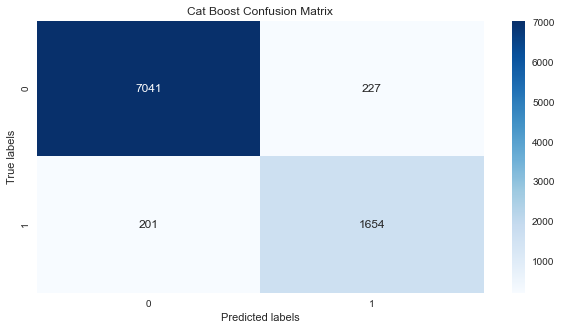

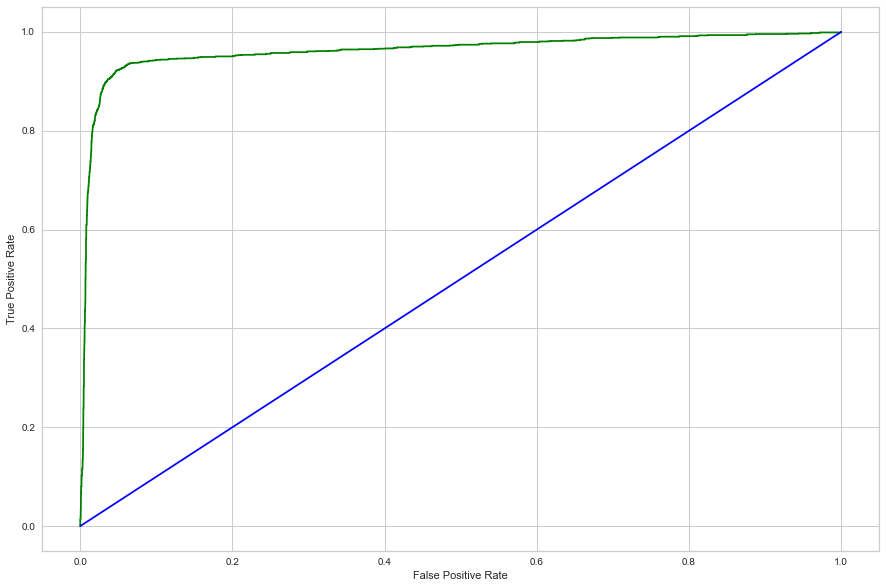

In [83]:
# initialize classifier with best params
cb = CatBoostClassifier(boosting_type='Plain', learning_rate=1.0, n_estimators=1000)
get_model_info(cb, 'Cat Boost')

## LIGHT GBM

In [81]:
# create a parameter grid
param_grid_lgbm = {'learning_rate':[0.1, 1.0], 
                   'n_estimators':[100, 200],
                   'boosting_type': ['gbdt', 'dart', 'goss', 'rf']}
# determine best params
best_params = grid_search(LGBMClassifier(), param_grid_lgbm)
best_params

{'boosting_type': 'gbdt', 'learning_rate': 1.0, 'n_estimators': 200}

5-CV Scores: [0.96821221 0.96843144 0.96634879 0.96755453 0.96821221]
Average 5-CV score: 0.9675326098870987
Train score: 0.8890989805984874
Test accuracy: 0.857831853556944
Difference: 0.03126712704154333

Lgbm Classifier Classification Report

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      7268
           1       0.69      0.55      0.61      1855

    accuracy                           0.86      9123
   macro avg       0.79      0.74      0.76      9123
weighted avg       0.85      0.86      0.85      9123



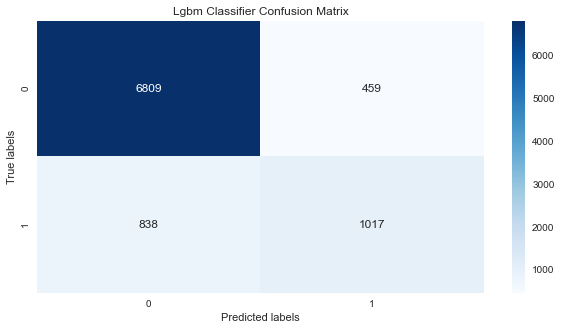

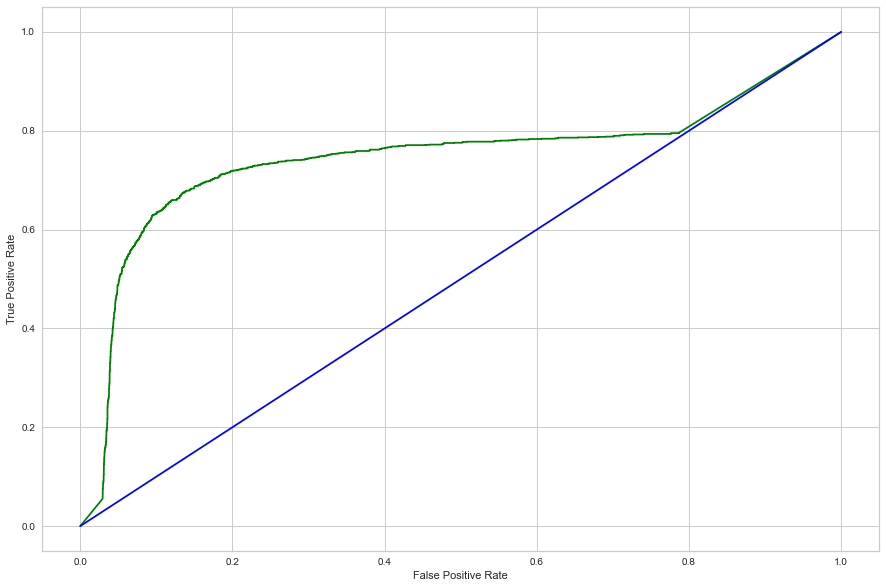

In [84]:
# initialize classifier with best params
lgbm = LGBMClassifier(boosting_type='gbdt', learning_rate = 1.0, n_estimators=200)
get_model_info(lgbm, 'LGBM Classifier')

Light GBM performs terribly overall. However, while CatBoost performs relatively well, it does not make the cut for top 3 best voting classifiers. Therefore, we will use Random Forest, Extra Trees, and Decision Trees with the recommended parameters from GridSearchCV.

## VOTING CLASSIFIER

In [97]:
# use the top 3 best performing models as part of our voting classifier with their optimal parameters
clf1 = RandomForestClassifier()
clf2 = ExtraTreesClassifier()
clf3 = DecisionTreeClassifier()

In [98]:
from tqdm import tqdm

In [ ]:
w1 = []
w2 = []
w3 = []
avg_5_cv_scores = []
train_scores = []
accuracy_scores = []
train_test_diff = []
recall_scores = []

for i in tqdm(np.arange(0.1, 1, 0.1)):
    for j in np.arange(0.1, 1, 0.1):
        for k in np.arange(0.1, 1, 0.1):
            clf_voting = VotingClassifier(estimators=[('rf', clf1), ('et', clf2), ('dt', clf3)],
                                          voting = 'soft',
                                          weights = [i, j, k])
            # evaluate model
            clf_voting.fit(X_train, y_train)
            y_pred = clf_voting.predict(X_test)
            
            # find all scores
            avg_cv_score = round(cross_val_score(clf_voting, X=X, y=y, cv=5).mean(), 2)
            train_score = round(clf_voting.score(X_train, y_train), 2)
            accuracy = round(accuracy_score(y_test, y_pred), 2)
            diff = round(train_score - accuracy, 2)
            recall = round(recall_score(y_test, y_pred), 2)
            
            # append to list
            w1.append(i)
            w2.append(j)
            w3.append(k)
            avg_5_cv_scores.append(avg_cv_score)
            train_scores.append(train_score)
            accuracy_scores.append(accuracy)
            train_test_diff.append(diff)
            recall_scores.append(recall)

  0%|                                                                                                                                                                                                               | 0/9 [00:00<?, ?it/s]

In [ ]:
# create a dataframe
d = {'weight1': w1, 'weight2': w2, 'weight3': w3,
     'avg_5cv_scores': avg_5_cv_scores, 'train': train_scores, 
     'accuracy': accuracy_scores, 'train_test_diff': train_test_diff, 
     'recall': recall_scores }

weights_df = pd.DataFrame(data=d)

In [ ]:
weights_df['sum_of_weights'] = weights_df.weight1 + weights_df.weight2 + weights_df.weight3
valid_scores = weights_df.loc[weights_df.sum_of_weights == 1, :]
valid_scores.sort_values(by = 'recall', ascending=False).head()

# FEATURE SELECTION

# REFERENCES
- https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm
- https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
- https://towardsdatascience.com/catalog-of-variable-transformations-to-make-your-model-works-better-7b506bf80b97
- https://www.marsja.se/transform-skewed-data-using-square-root-log-box-cox-methods-in-python/
- https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/#h2_5
- https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
- sklearn documentation
- catboost documentation
- light boost gradient machine documentation